In [1]:
# Walkthrough : https://www.youtube.com/watch?v=XhfhR7Z01S0
        
# Requirements:
    # conda install -c anaconda cloudpickle 
    # conda install -c conda-forge jsanimation
    # conda install -c anaconda progressbar 

In [2]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils
from parallelEnv import parallelEnv
import numpy as np
import pickle

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [3]:
import gym
import time
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
# env = gym.make('Pong-v4')
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())
RIGHT = 4
LEFT = 5
# do not learn to use FIRE. Directly use them
# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


c:\users\simon.chauvin\documents\private github\deep-reinforcement-learning\python\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original image has size = (210, 160, 3)


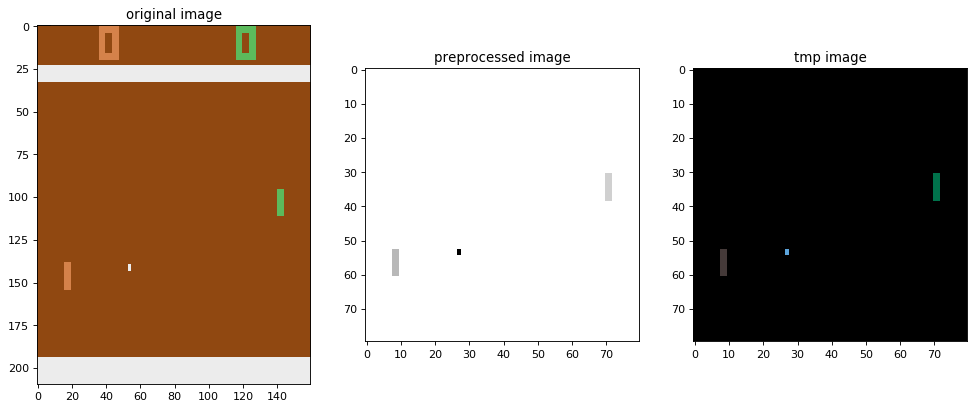

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# show what a preprocessed image looks like
env.reset()
f0, _, _, _ = env.step(0)  # (210, 160, 3)
print("original image has size = {}".format(np.shape(f0)))

# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

fig = plt.figure(num=None, figsize=(15, 15), dpi=80)

plt.subplot(1, 3, 3)
bkg_color=np.array([144, 72, 17])
tmp = frame[34:-16:2, ::2]-bkg_color
plt.imshow(tmp)
plt.title('tmp image')

# original image
plt.subplot(1, 3, 1)
plt.imshow(frame)
plt.title('original image')

# 80 x 80 black and white image
plt.subplot(1, 3, 2)
plt.title('preprocessed image')
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')

plt.show()

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving right. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # input size = 80x80x2 (stacked frame)
        
        # stride = step size when moving the filter "step by step" along the picture
        # stride == 2 -> every two pixels
        # outputsize = (inputsize - kernel_size + stride)/stride
        
        # from 80x80x2 to 38x38x4
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=4,
                               kernel_size=6, stride=2, bias=False)
        
        # from 38x38x4 to 9x9x16
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,
                               kernel_size=6, stride=4)
        self.size=9*9*16  # 9*9*16 = 1296
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # [1, 4, 38, 38]
        x = F.relu(self.conv2(x))  # [1, 16, 9, 9]
        x = x.view(-1, self.size)  # [1, 1296] - the size -1 is inferred from other dimensions296x=
        x = F.relu(self.fc1(x))  # [1, 256]
        return self.sig(self.fc2(x))  # [1, 1]

In [6]:
# run your own policy!
policy=Policy().to(device)
# policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)


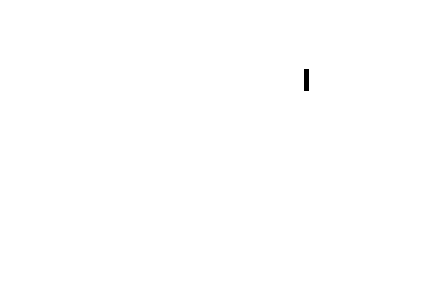
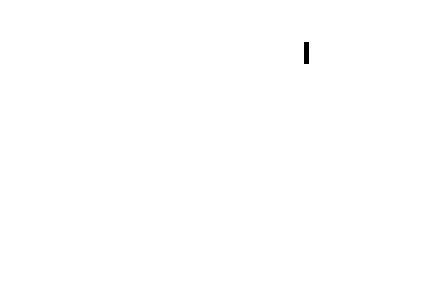
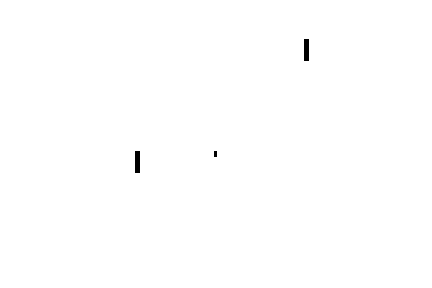
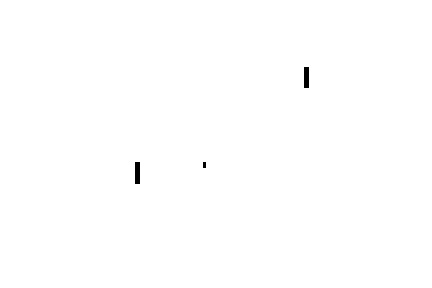
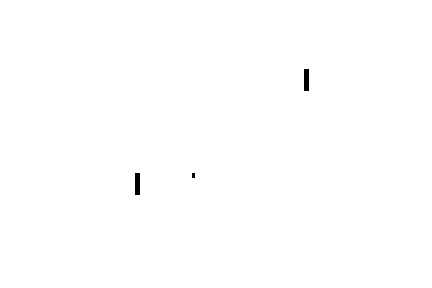
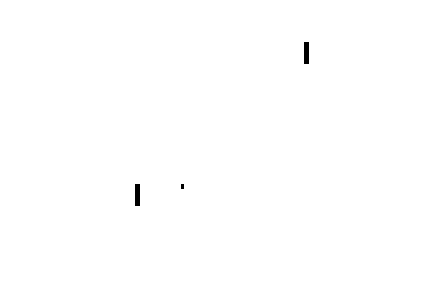
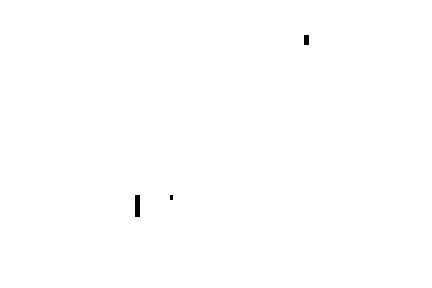
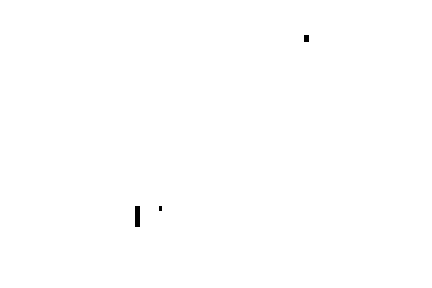
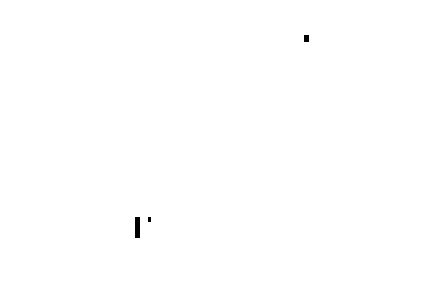
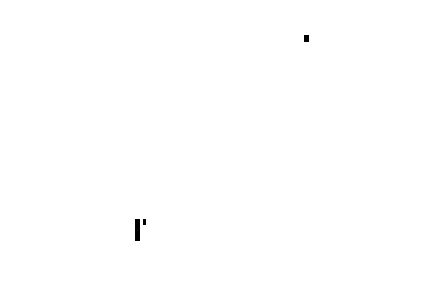
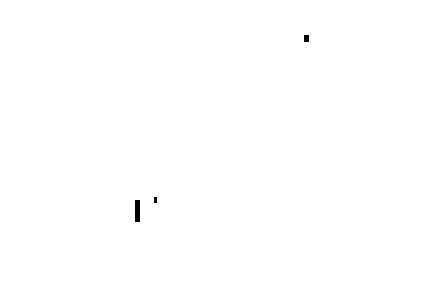
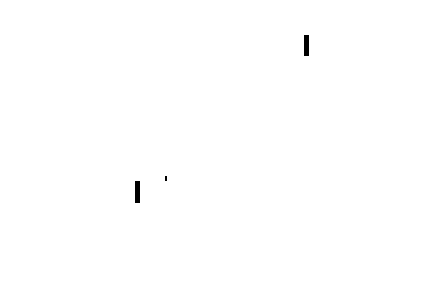
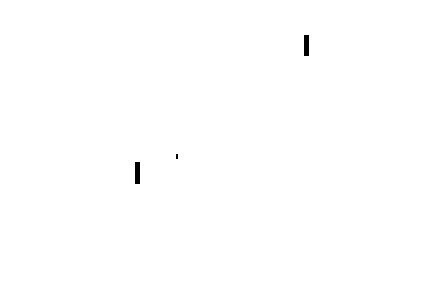
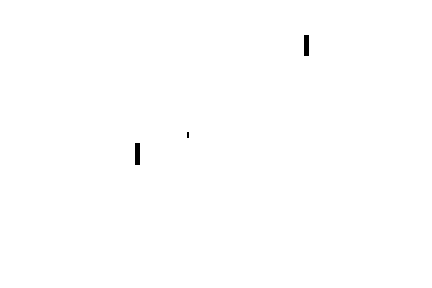
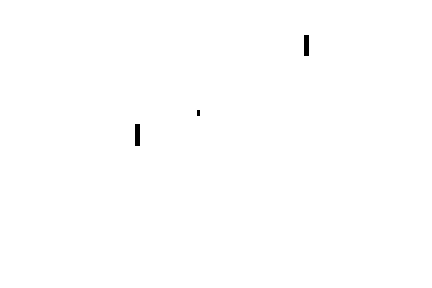
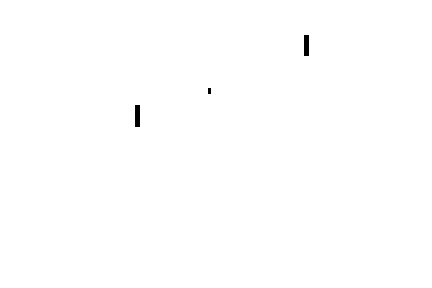
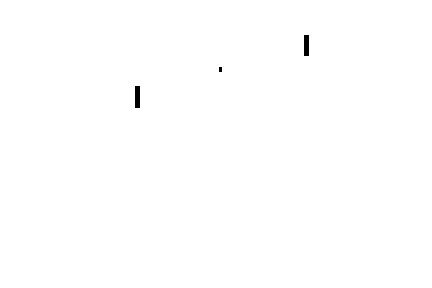
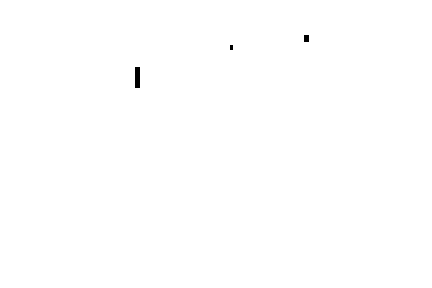
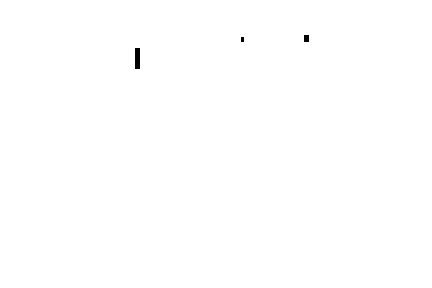
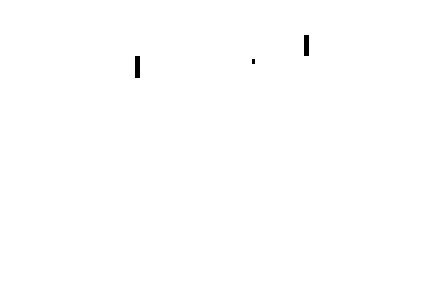
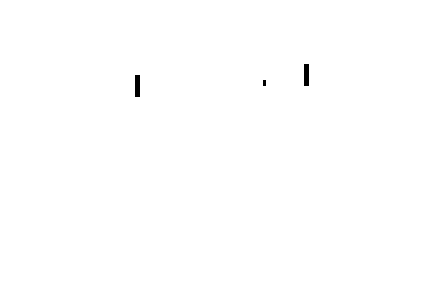
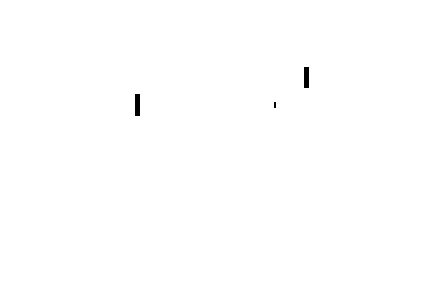
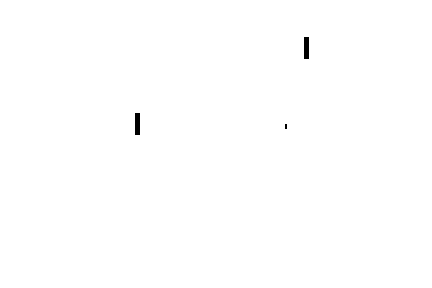
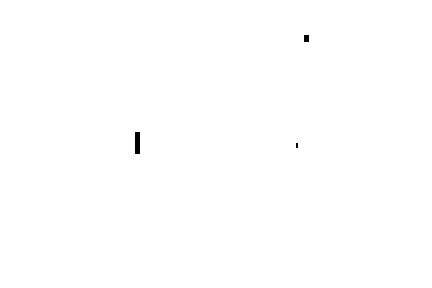
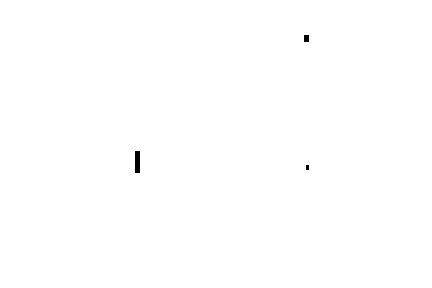
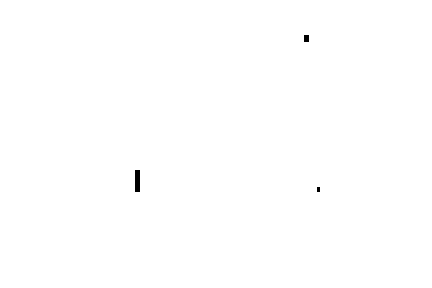
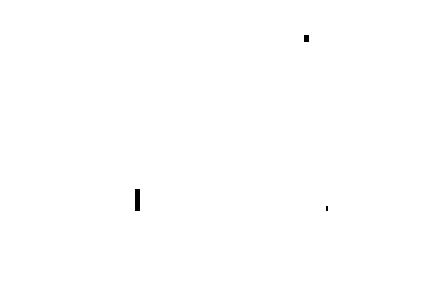
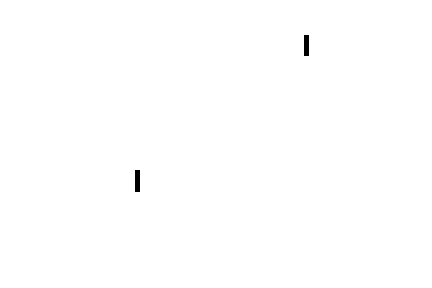
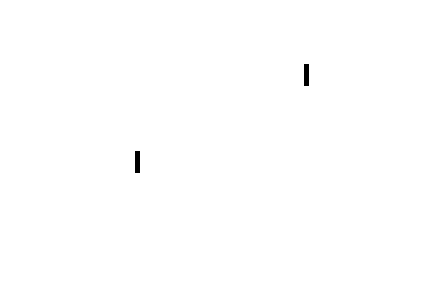
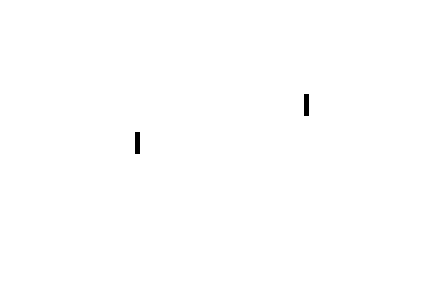
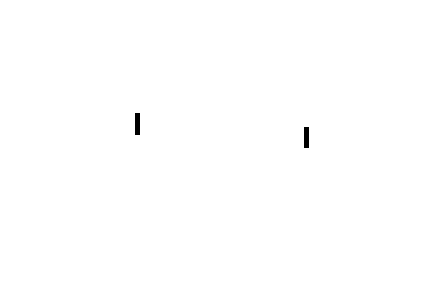
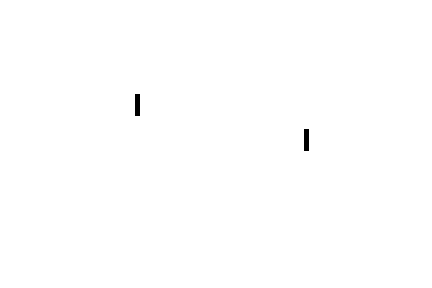
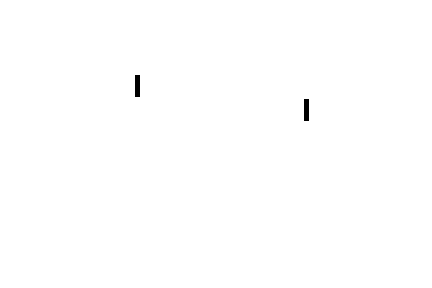
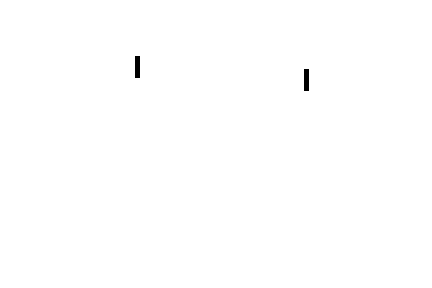
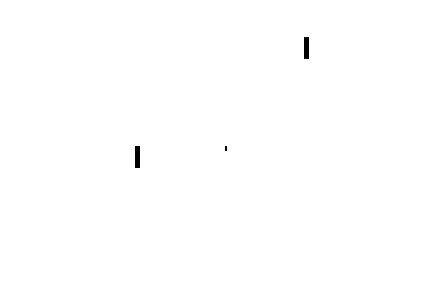
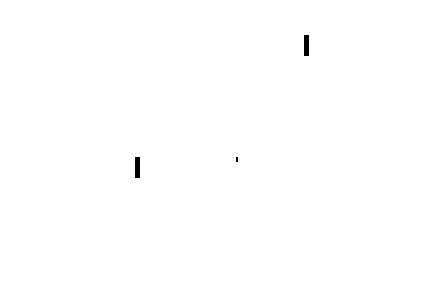
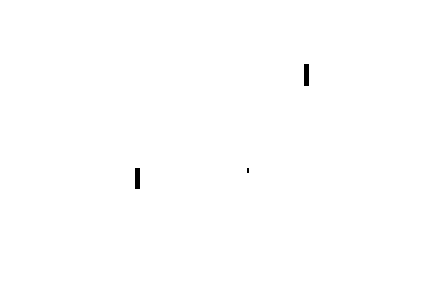
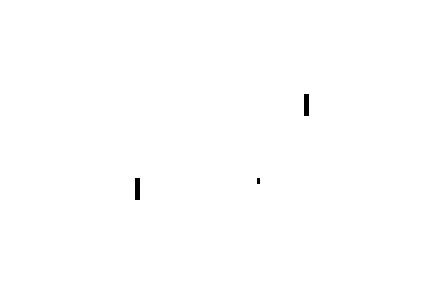
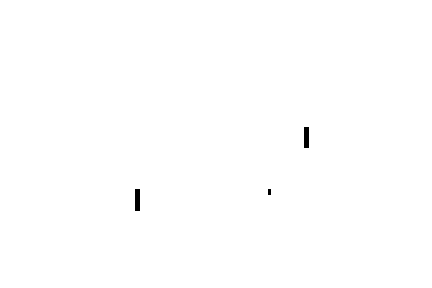
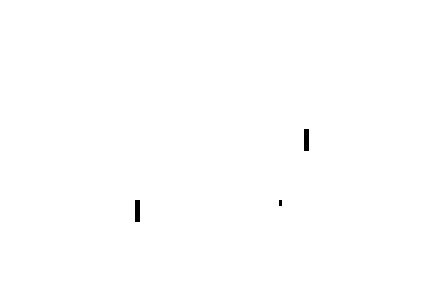
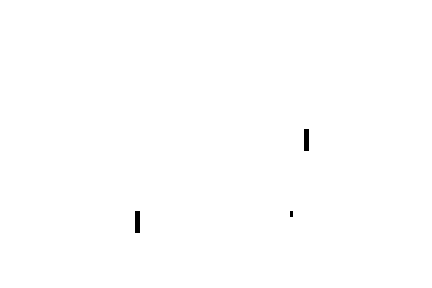
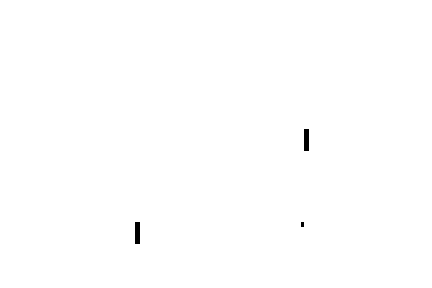
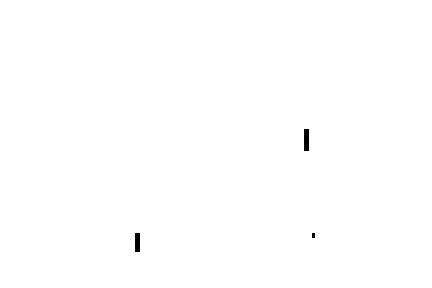
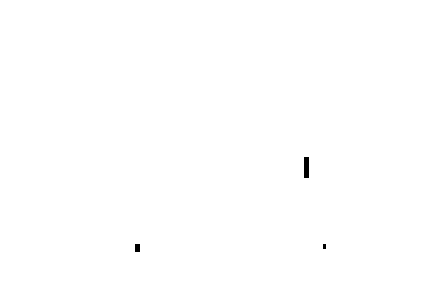
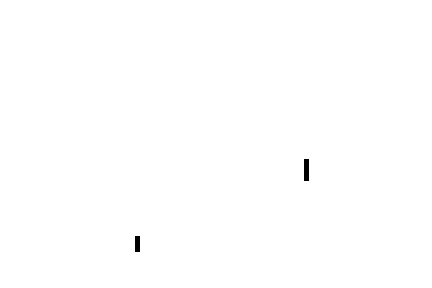
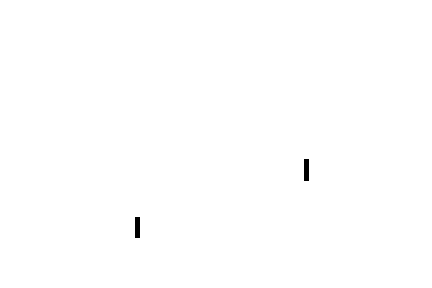
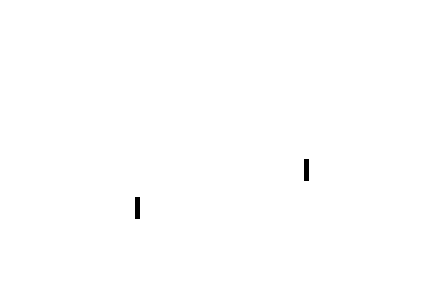
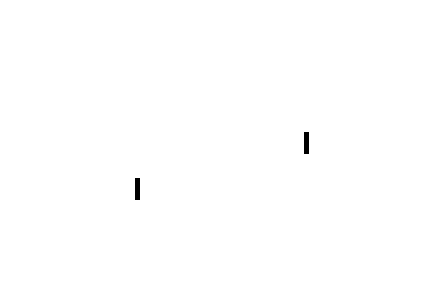
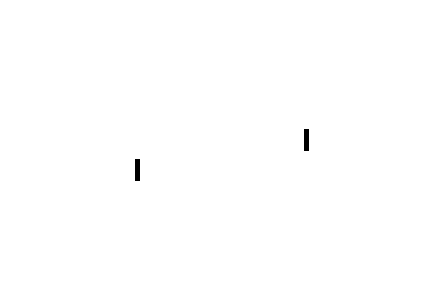
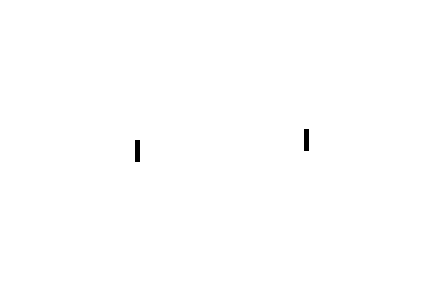
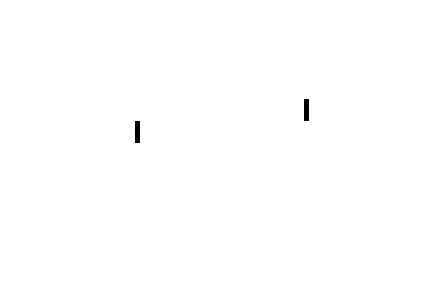
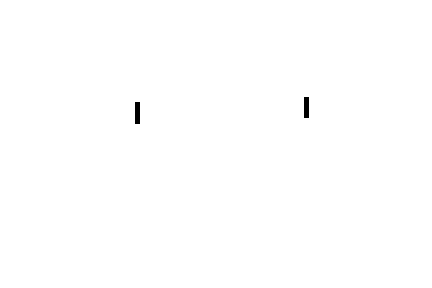
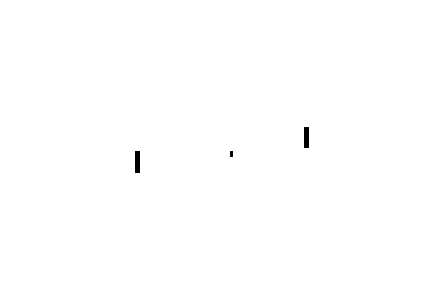
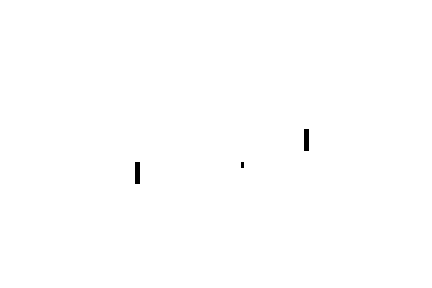
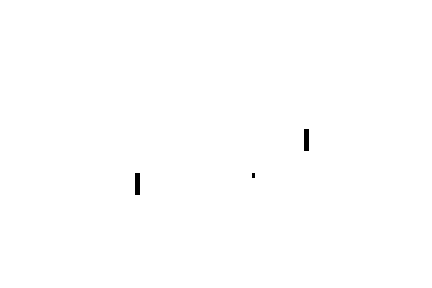
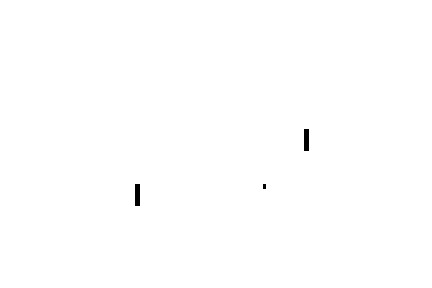
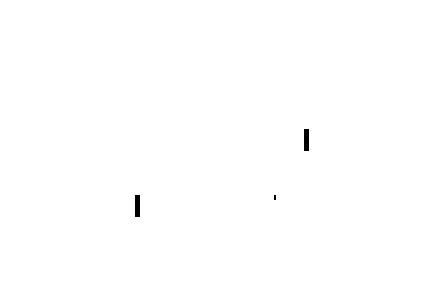
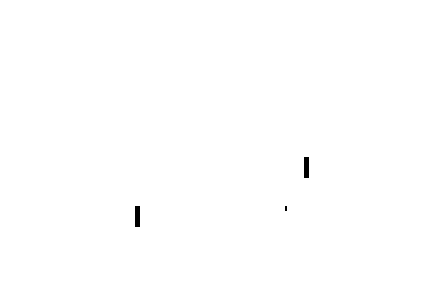
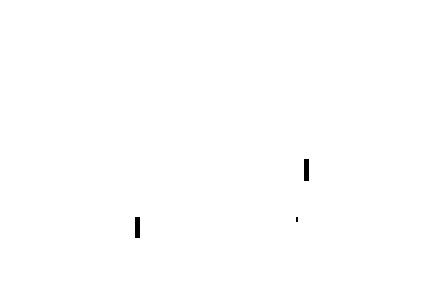
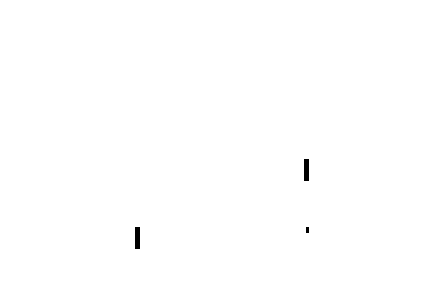
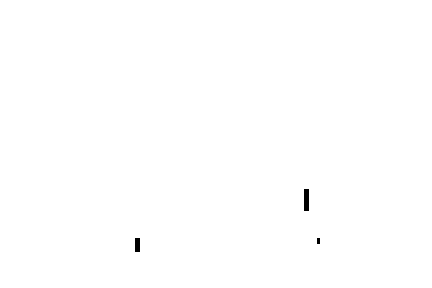
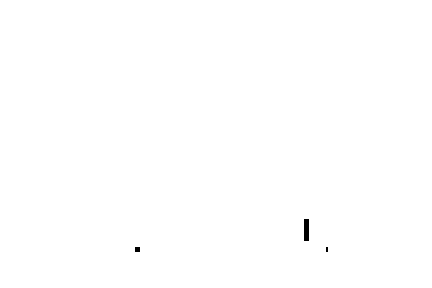
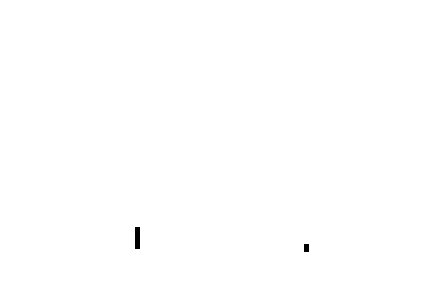
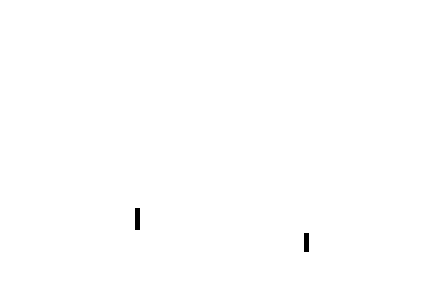
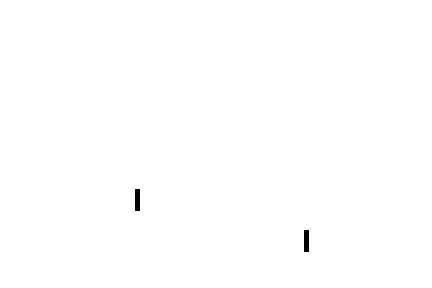
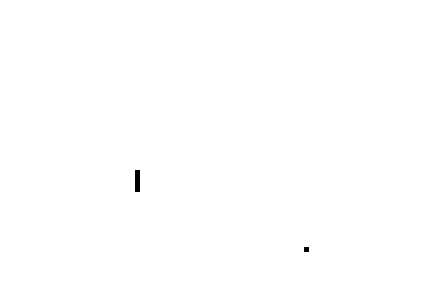
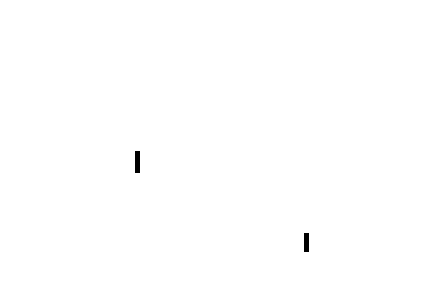
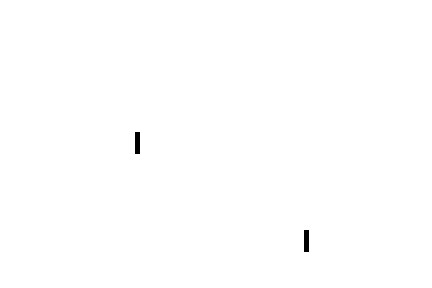
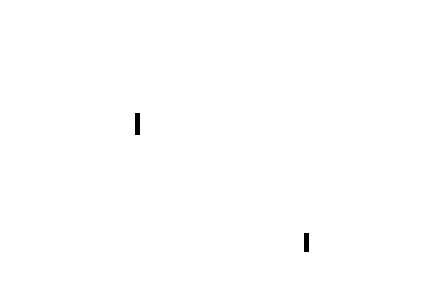
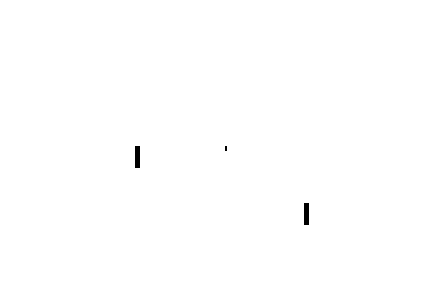
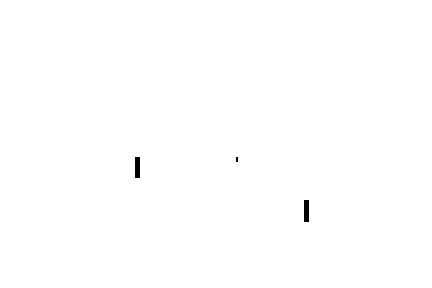
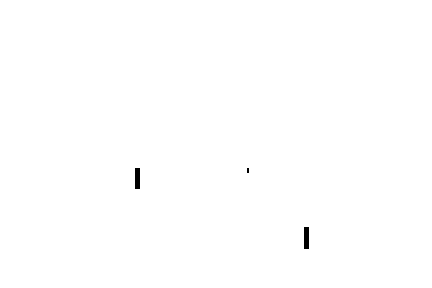
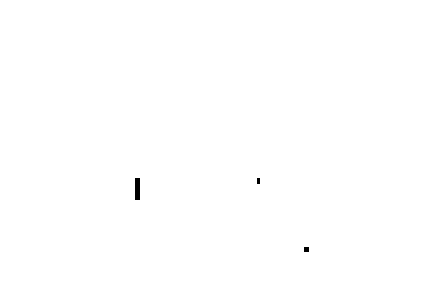
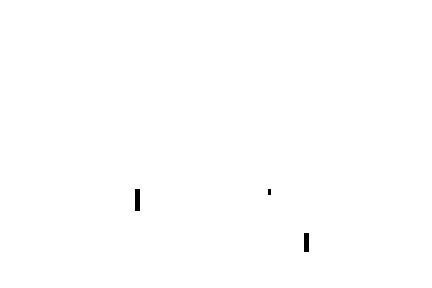
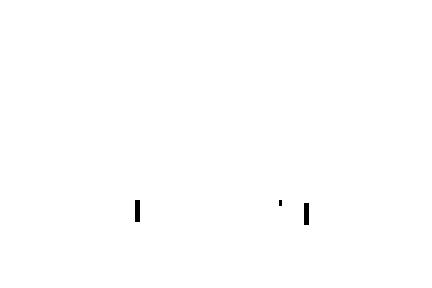
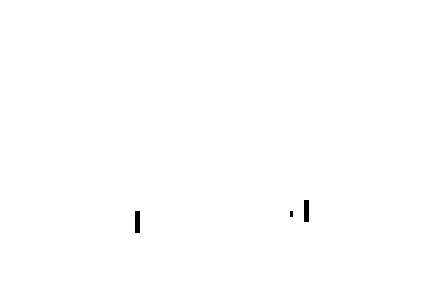
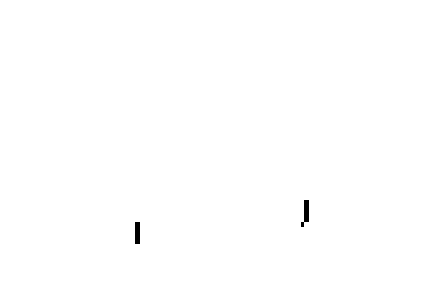
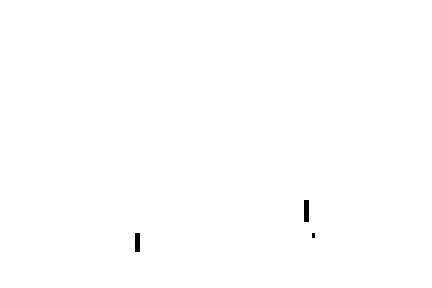
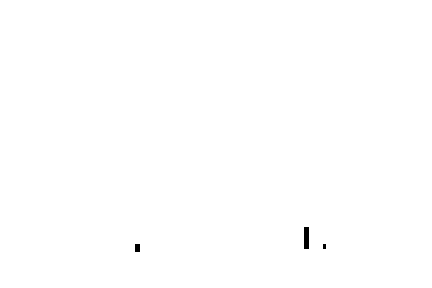
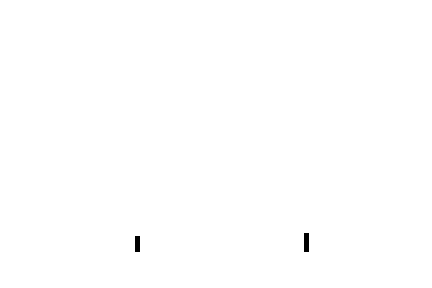
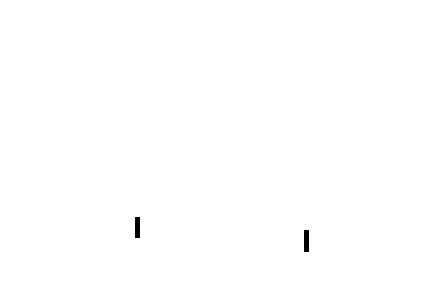
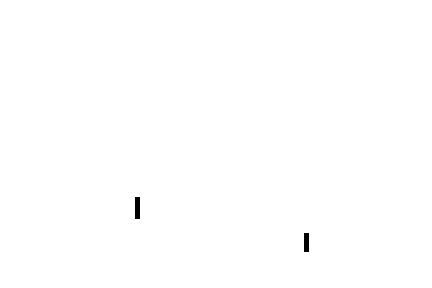
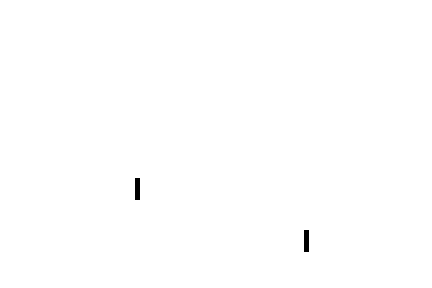
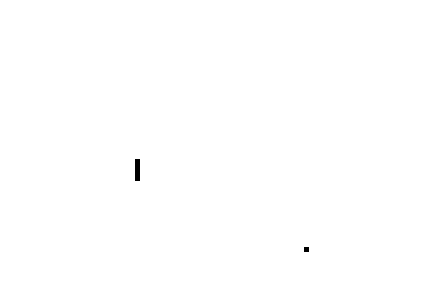
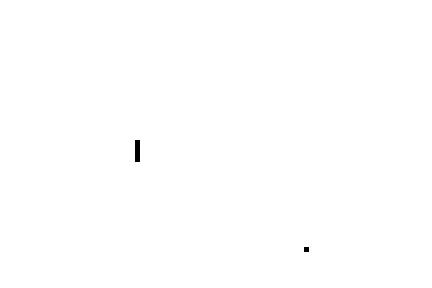
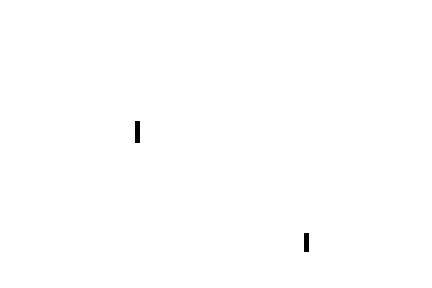
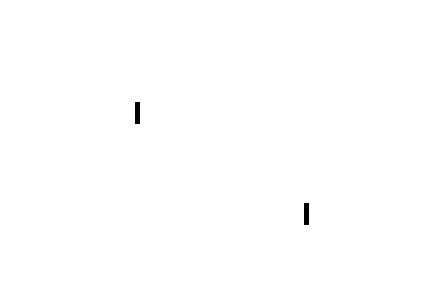
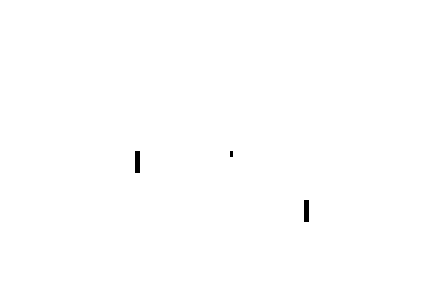
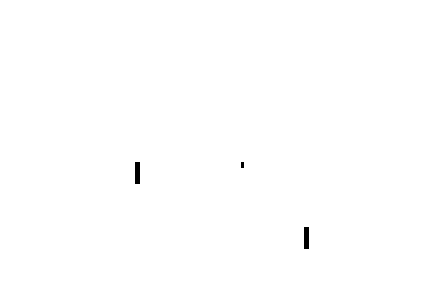
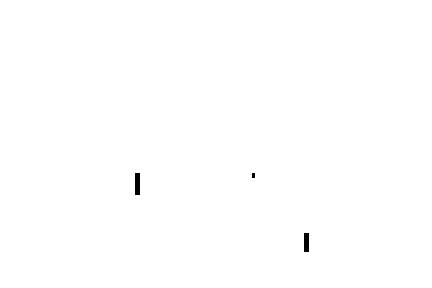
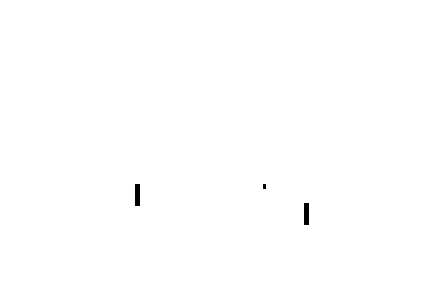
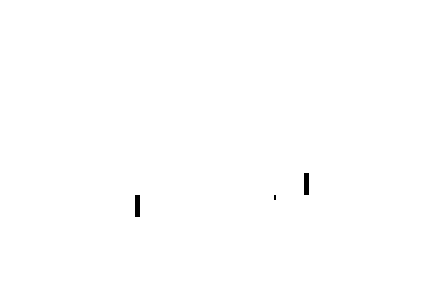
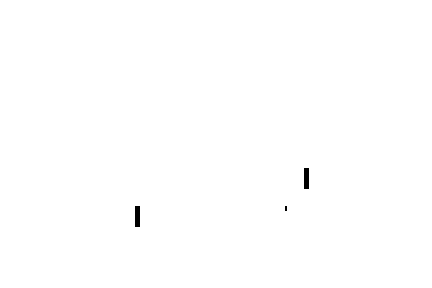
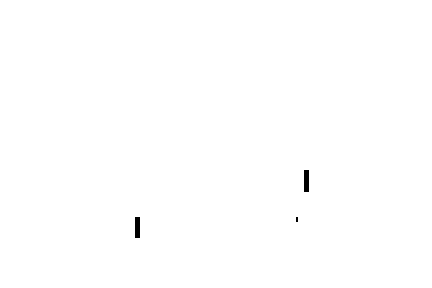
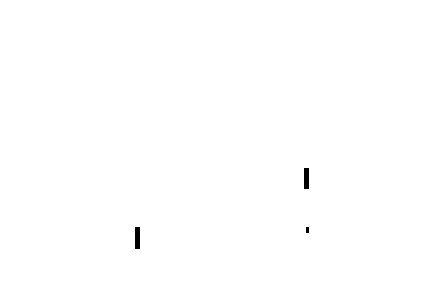
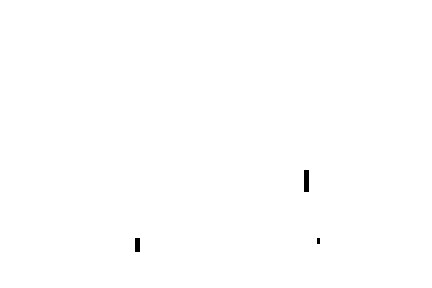
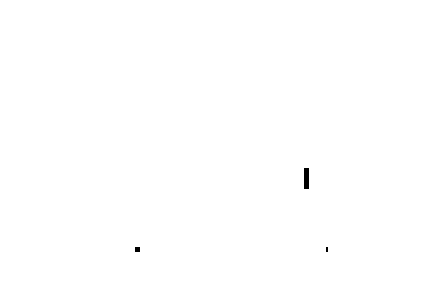
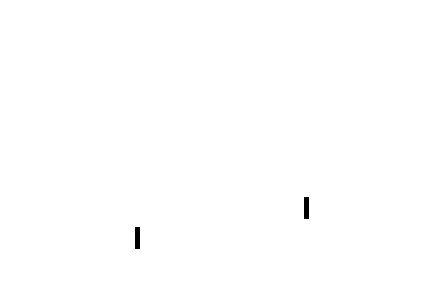
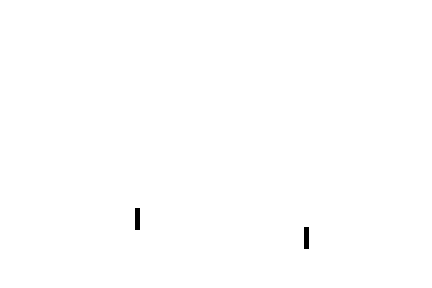
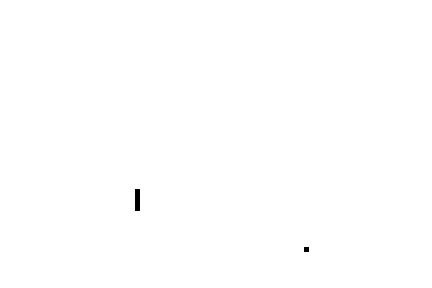
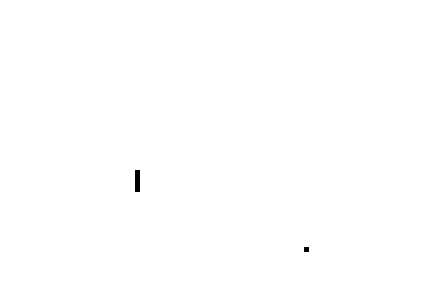
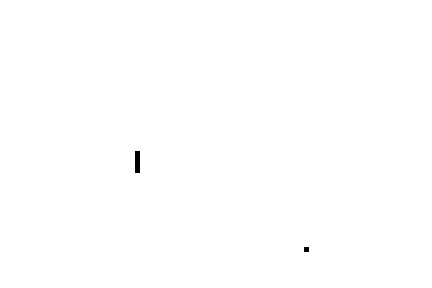
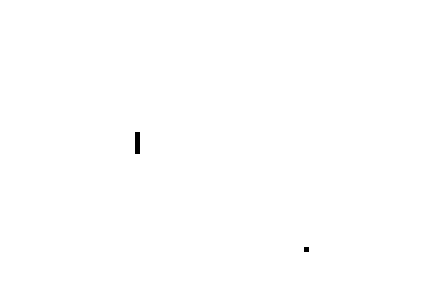
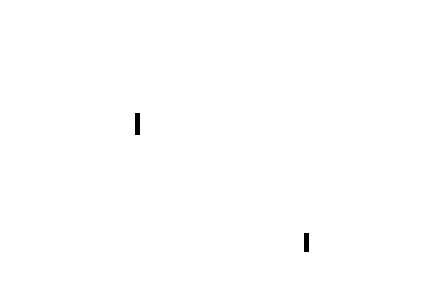
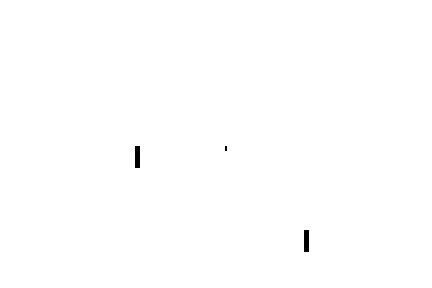
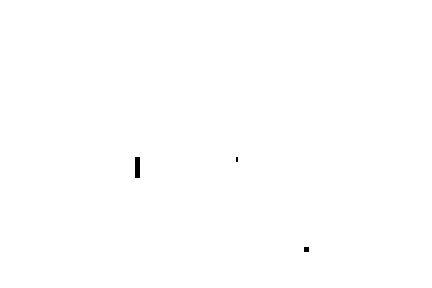
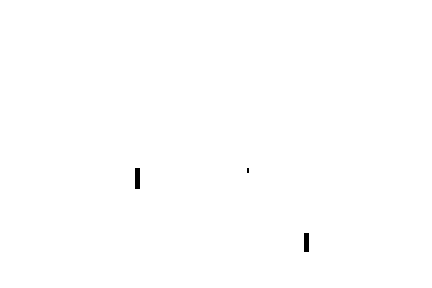
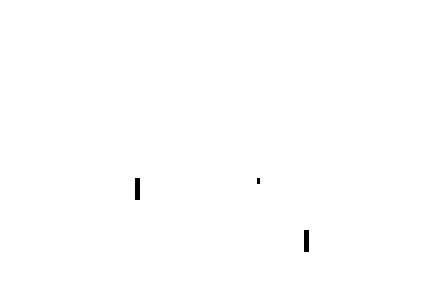
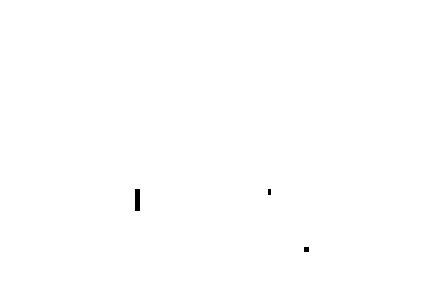
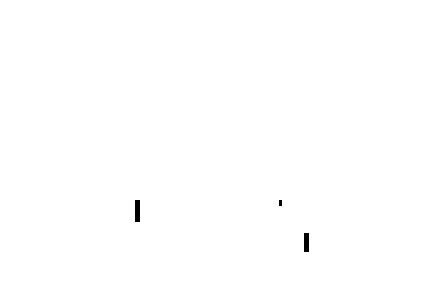
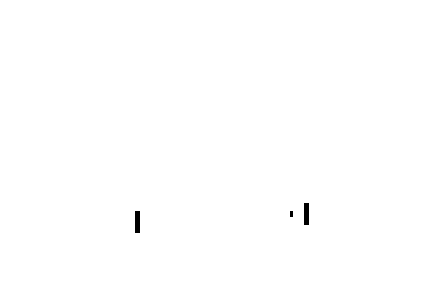
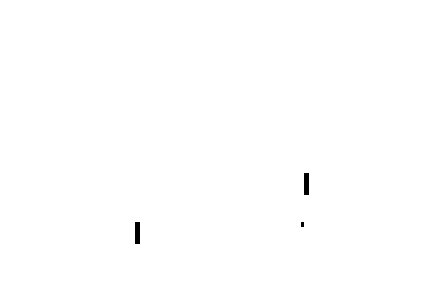
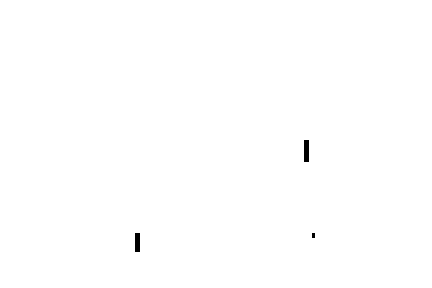
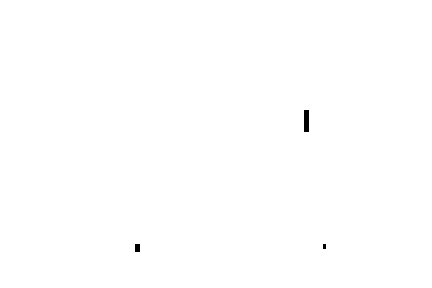
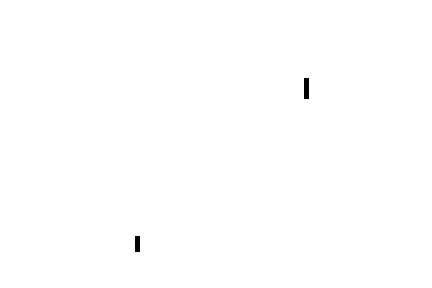
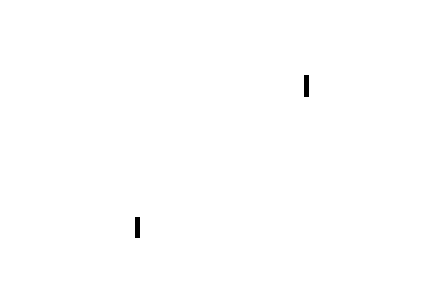
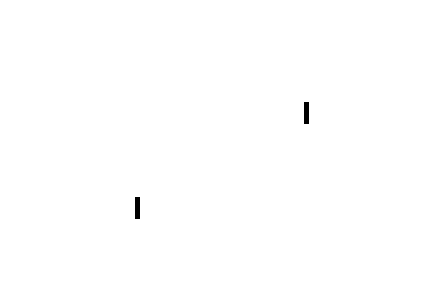
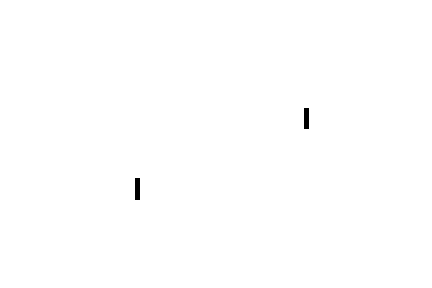
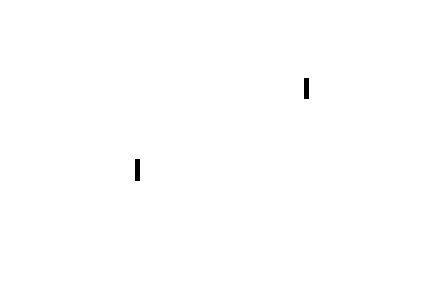
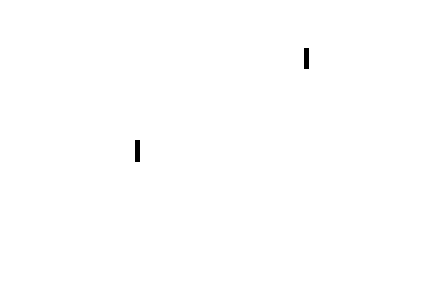
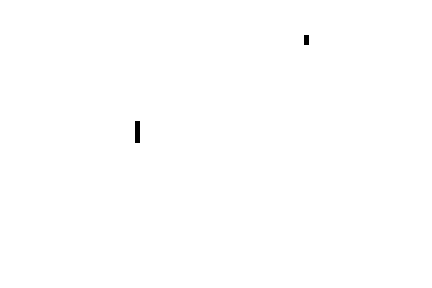
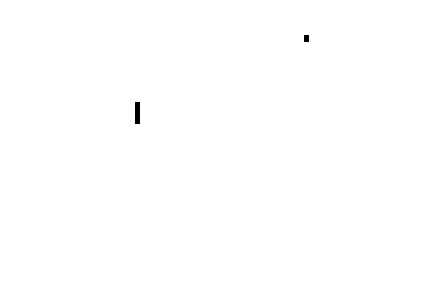
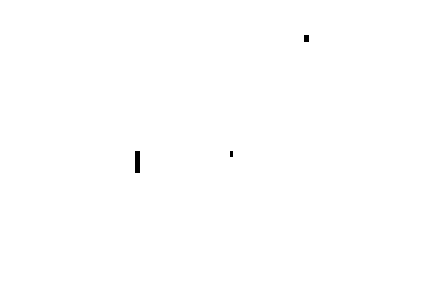
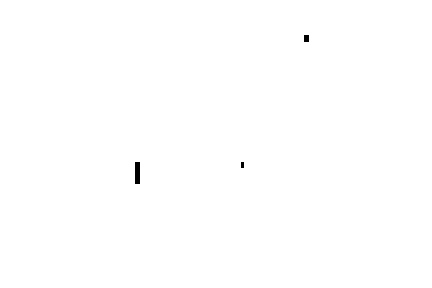
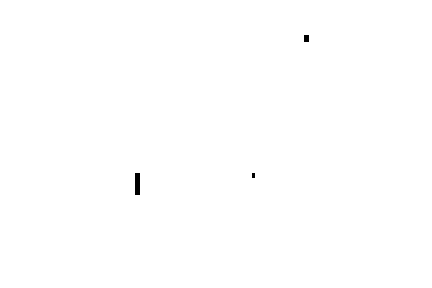
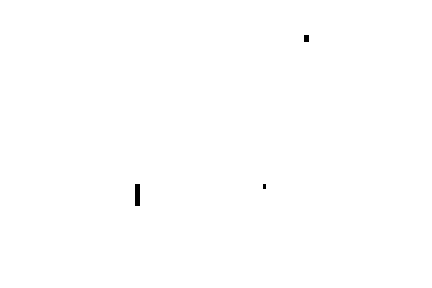
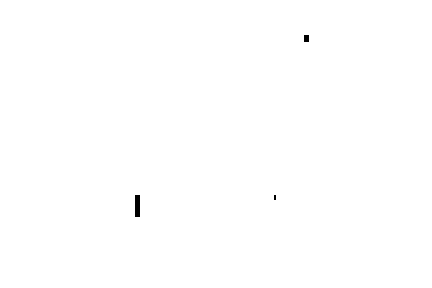
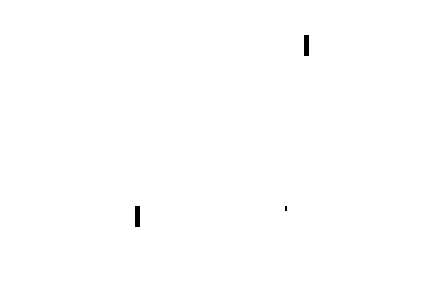
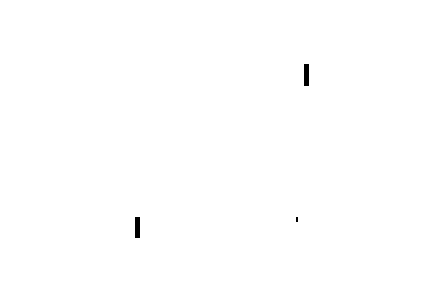
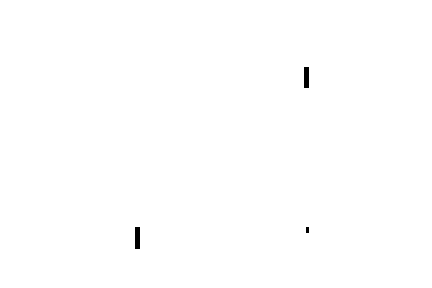
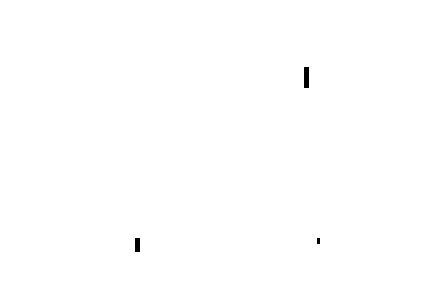
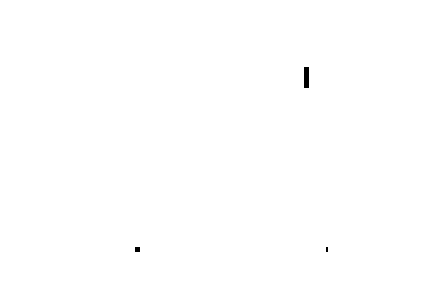
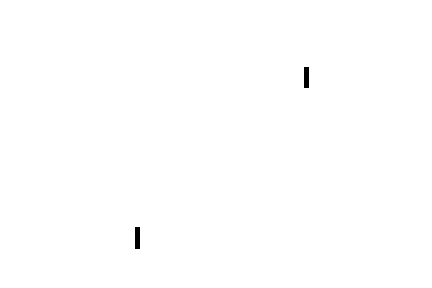
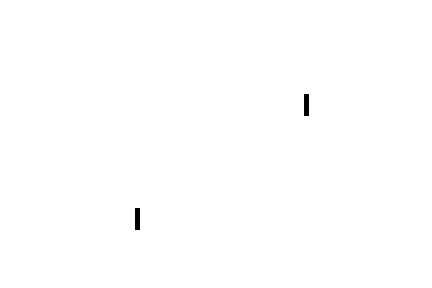
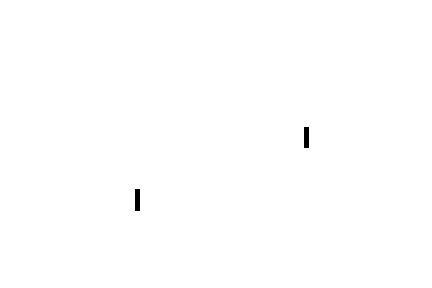
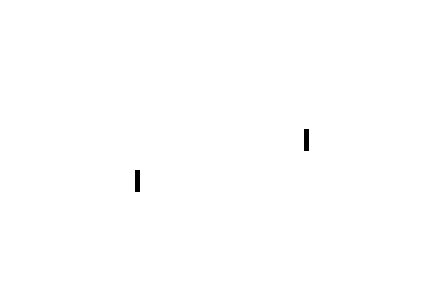
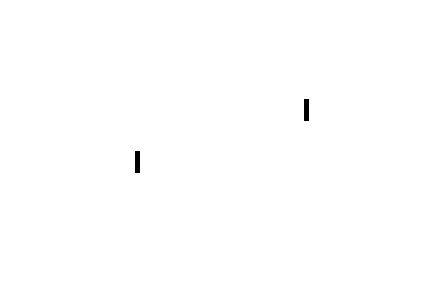
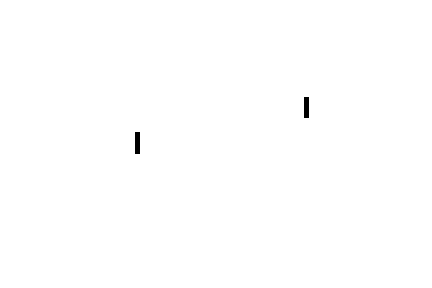
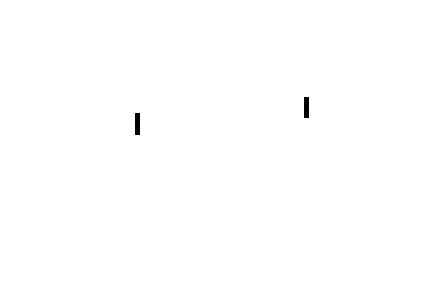
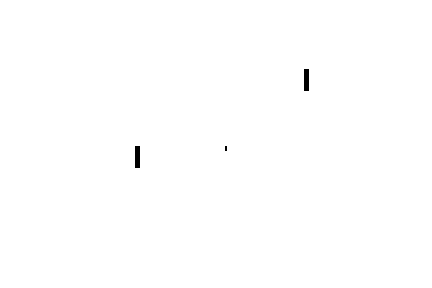
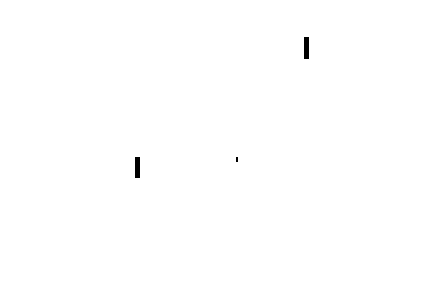
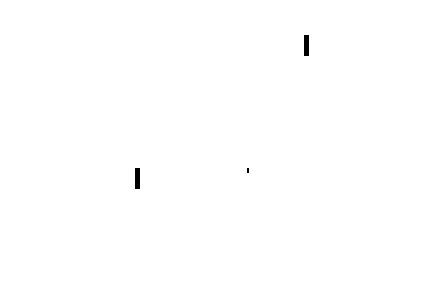
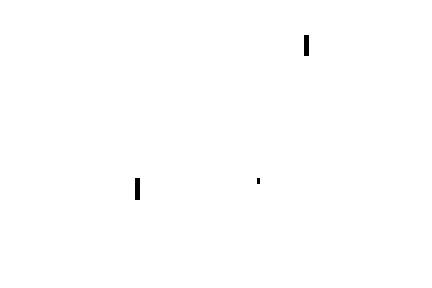
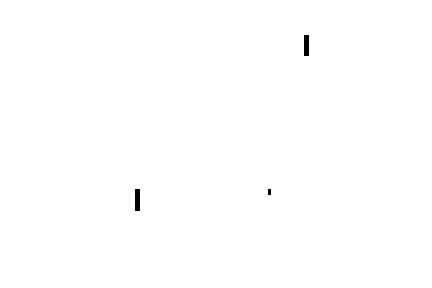
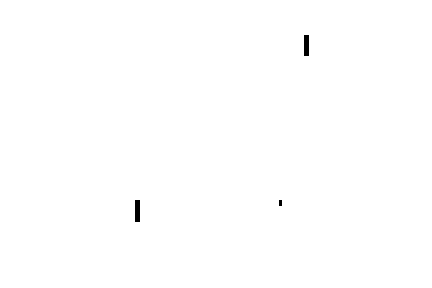
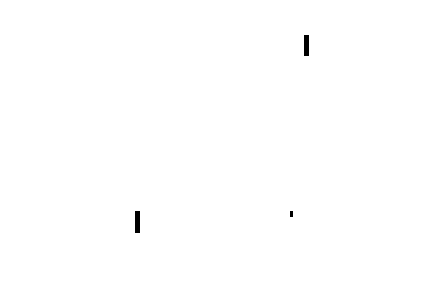
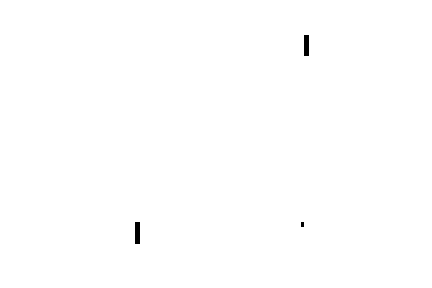
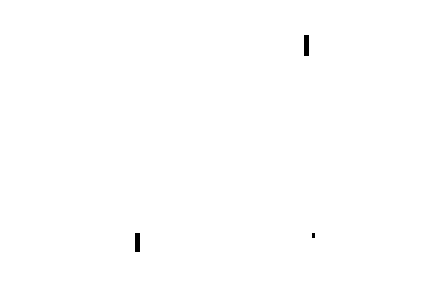
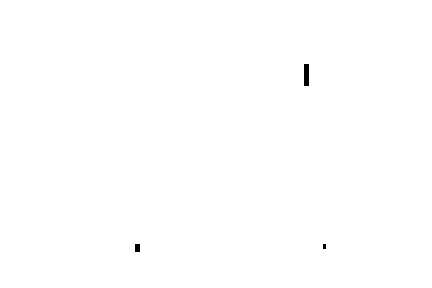
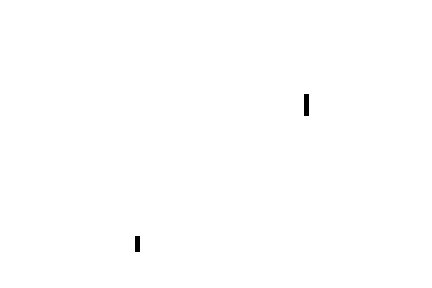
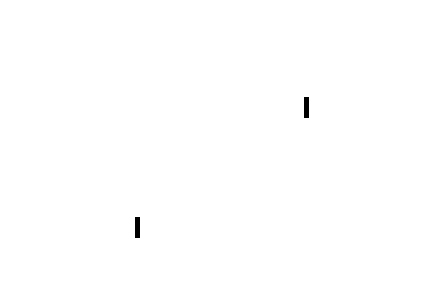
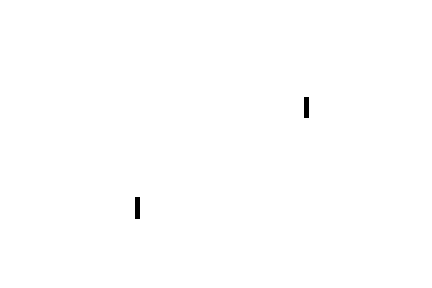
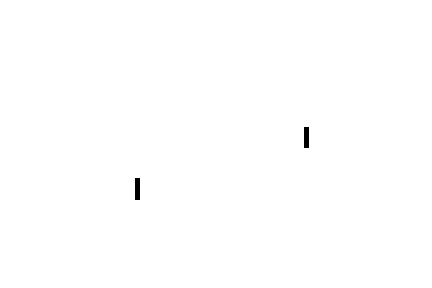
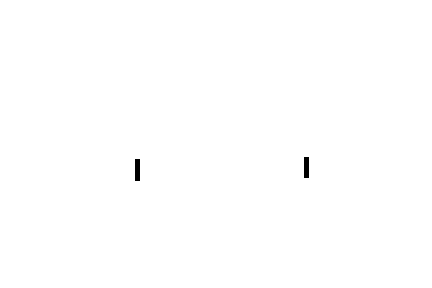
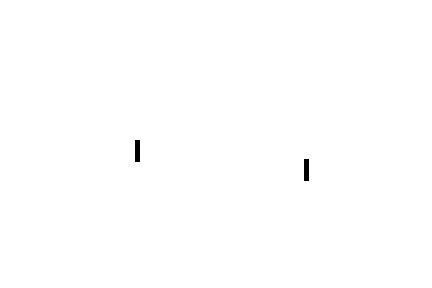
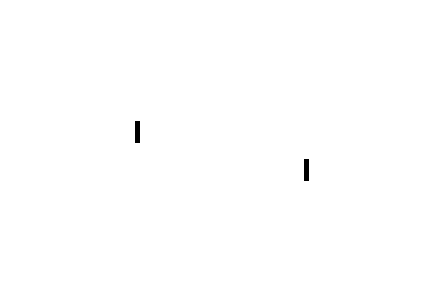
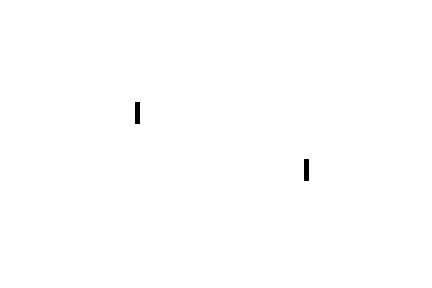
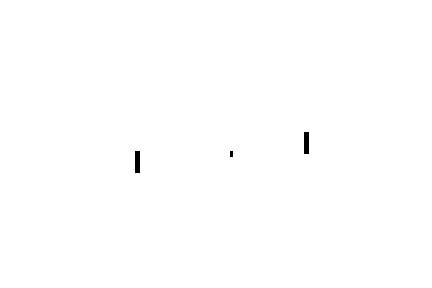
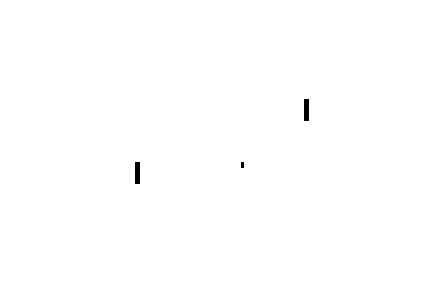
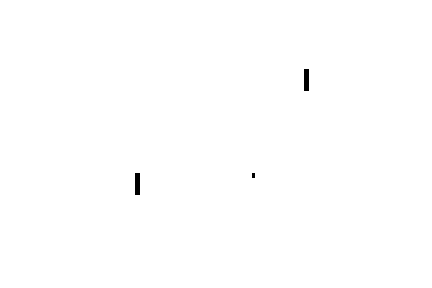
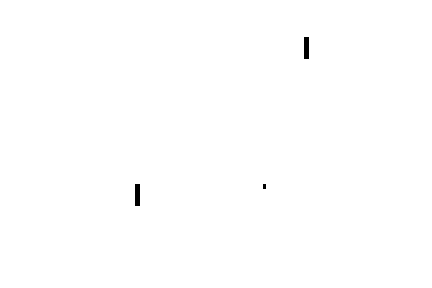
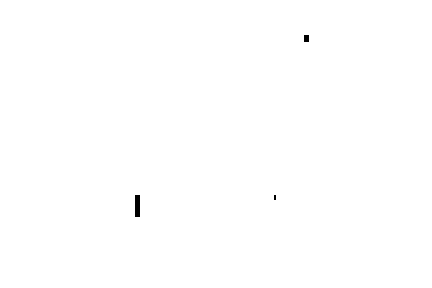
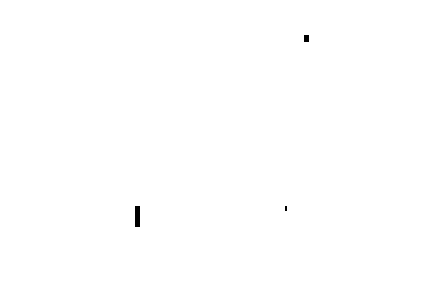
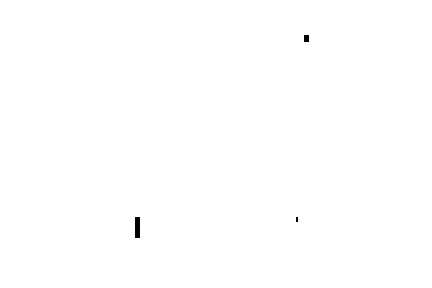
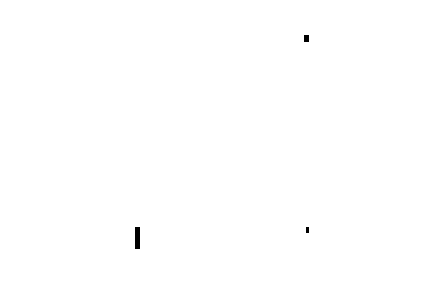
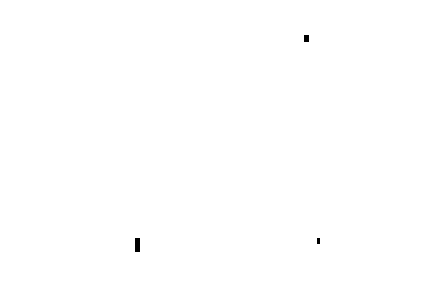
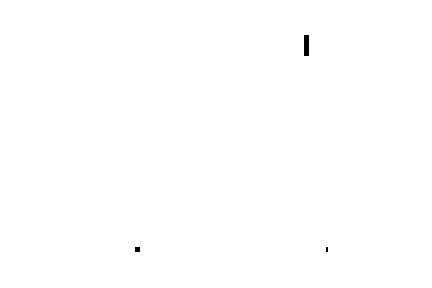
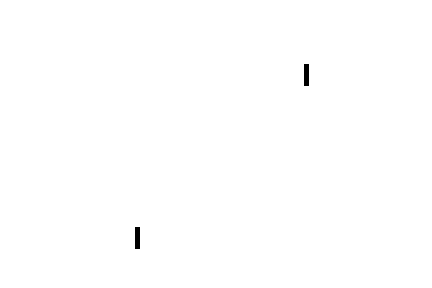
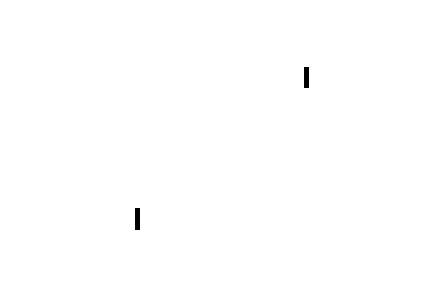
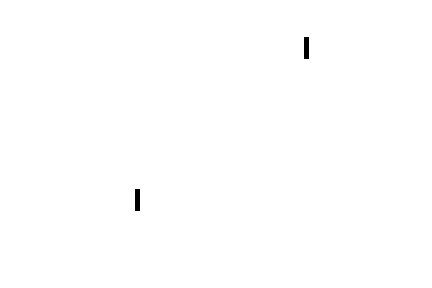
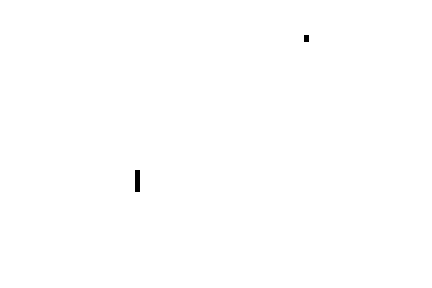
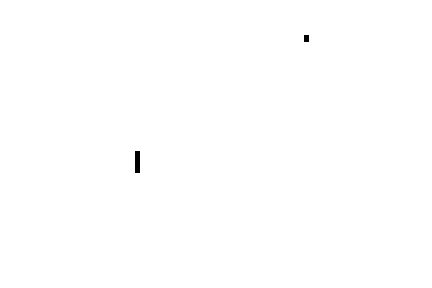
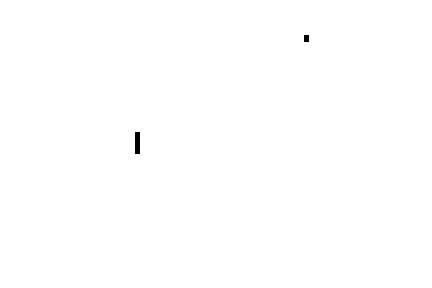
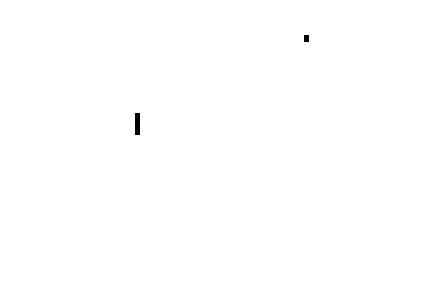
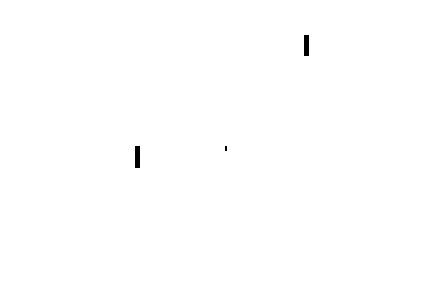
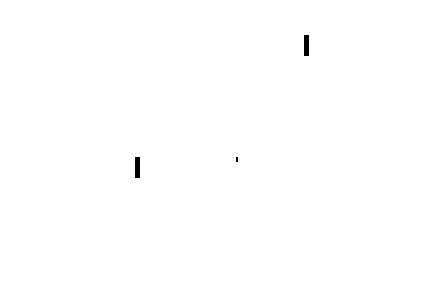
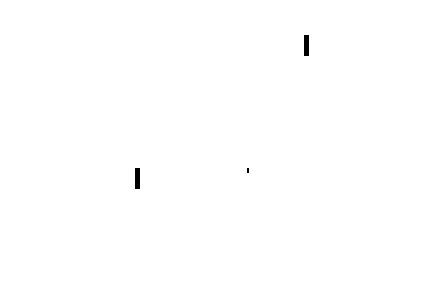
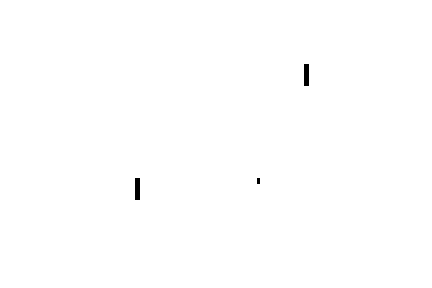
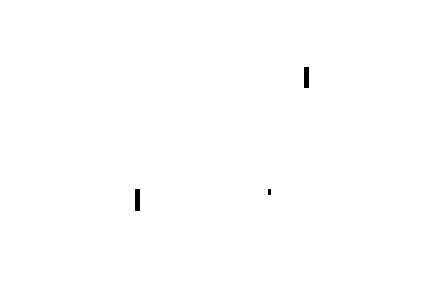
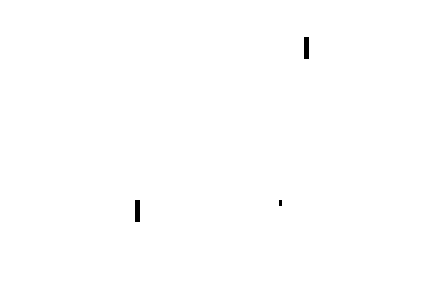
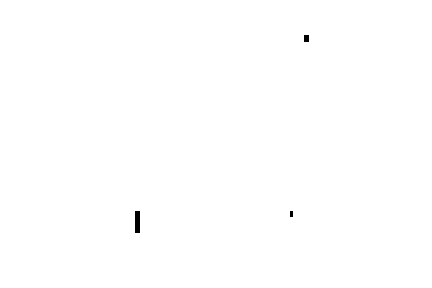
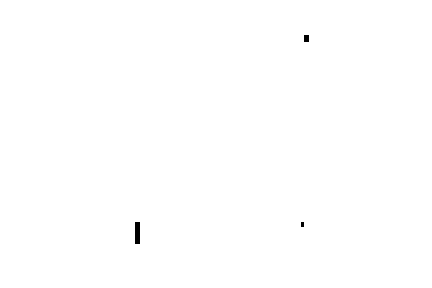
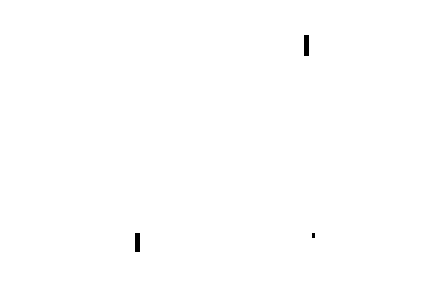
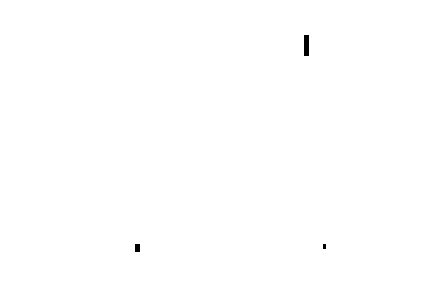
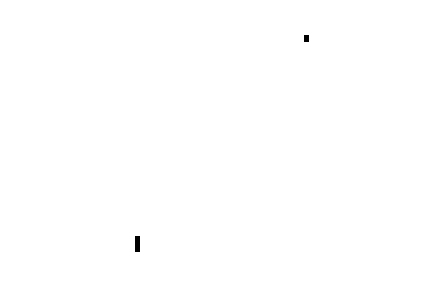
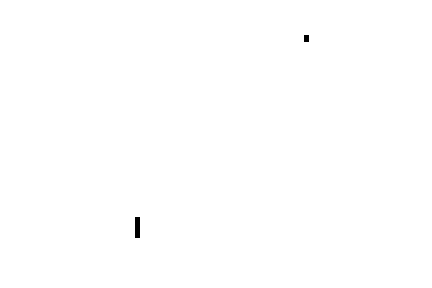
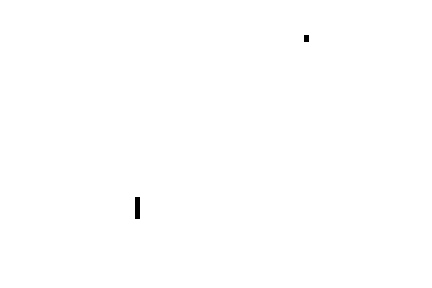
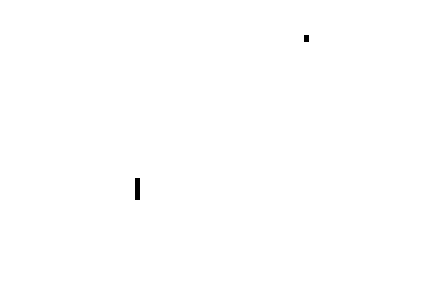
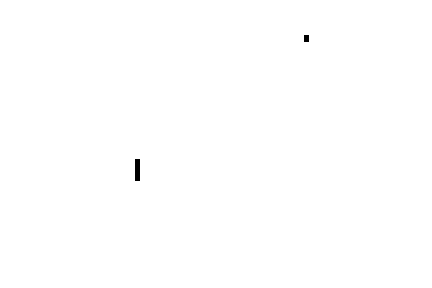
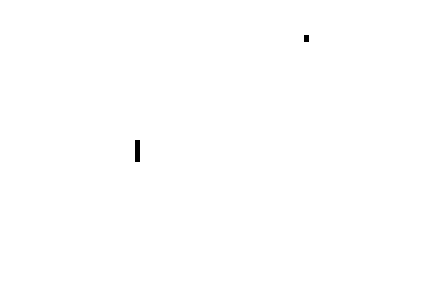
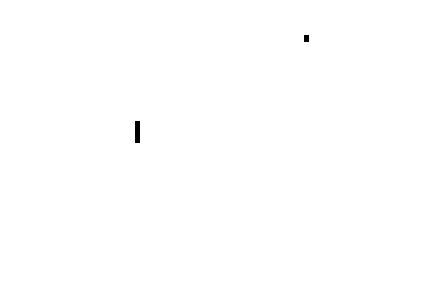
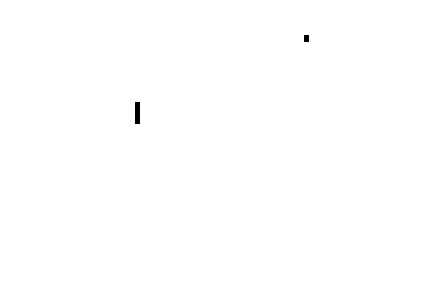
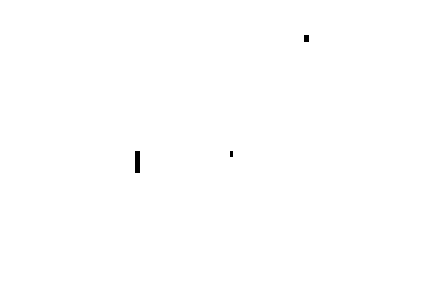
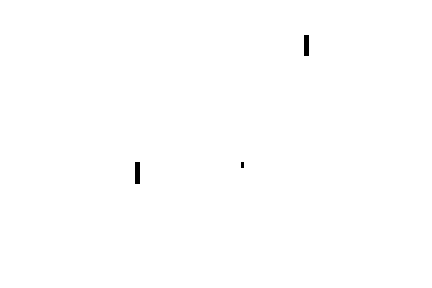
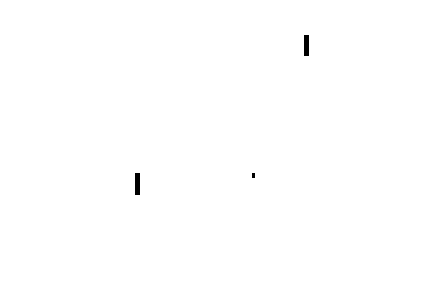
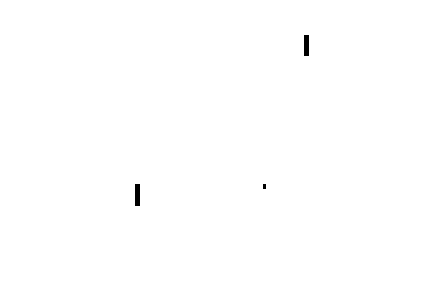
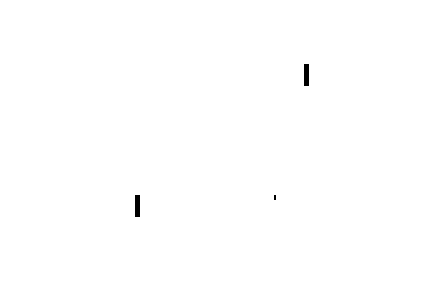
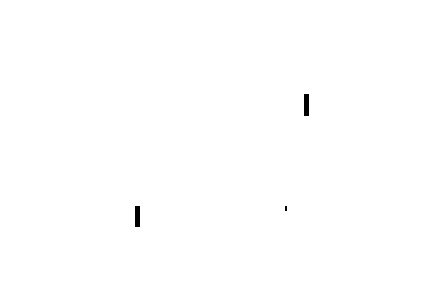
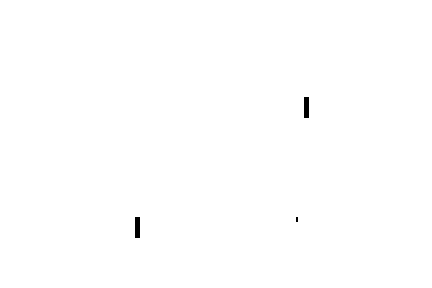
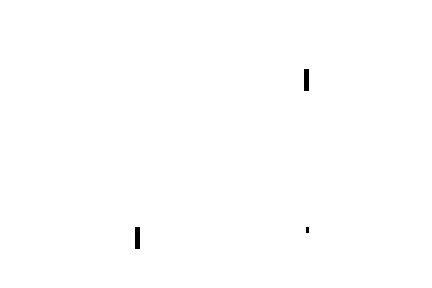

In [7]:
# No Game visualization - need JSAnimation
pong_utils.play(env, policy, preprocess=pong_utils.preprocess_single, time=200)
# pong_utils.play(env, policy, preprocess=None, time=200)

# Function Definitions
Here you will define key functions for training. 

In [8]:
# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1, *states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

## Exercise 2 - REINFORCE: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed):

-   1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
-   2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

REINFORCE idea:
-	1. Collect experience from one policy
-	2. Estimate the gradient of that policy (Theorem)
-	3. Gradient ascent


In [9]:
def surrogate(policy, old_probs, states, actions, rewards,
              discount=0.995, beta=0.01):
    """
    return sum of log-prob divided by T
    same thing as minus*policy_loss
    """

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:, np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:, np.newaxis])/std[:, np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10) +
                (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)
#     return torch.mean(beta*entropy)

In [10]:
# example
envs = parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, t_max=100)
Lsur = surrogate(policy, prob, state, action, reward)
print(Lsur)

c:\users\simon.chauvin\documents\private github\deep-reinforcement-learning\python\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward1>)


## Exercise 2 - PPO: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

Definition:

- PPO = a **family** of policy optimization methods that use **multiple epochs** of **stochastic gradient ascent** to perform each policy update
- offers the stability and reliability of *trust-region methods* but are **much simpler to implement**

PPO Algorithm:
- 1- First, collect some trajectories based on some policy $\pi_{\theta}$, and initialize theta prime $\theta'=\theta$
- 2- Next, compute the gradient of the clipped surrogate function using the trajectories
- 3- Update $\theta'$ using gradient ascent $\theta'\leftarrow\theta' +\alpha \nabla_{\theta'}L_{\rm sur}^{\rm clip}(\theta', \theta)$
- 4- Then we repeat step 2-3 without generating new trajectories. Typically, step 2-3 are only repeated a few times
- 5- Set $\theta=\theta'$, go back to step 1, repeat.

In [11]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      entropies=[],
                      discount=0.995,
                      epsilon=0.1, beta=0.01):
    """
    clipped surrogate function (the objective to maximize)
    similar as minus*policy_loss
    """
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:, np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    # normalization against shift in distribution of rewards 
    rewards_normalized = (rewards_future - mean[:, np.newaxis])/std[:, np.newaxis]
    # if reward = [1, 2, 1], then rewards_normalized has 3 rows like [-0.70  1.41 -0.70]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    # removes the incentive for moving rt outside of the interval [1 − e, 1 + e]
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    # the final objective is a lower bound - pessimistic:
    #  - ignore the change in probability ratio when it would make the objective improve
    #  - include it when it makes the objective worse
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term to force the policy to not be exactly equal to 0 or 1
    # this steers new_policy towards 0.5
    # also add in 1.e-10 to avoid log(0) which gives nan
    #     Actually, it is the cross-entropy
    # That is how "far away" predictions (old_probs) are from the true distribution (new_probs)
    # H(p,q) = D_KL(p||q) + H(p)
    # if new_probs == old_probs, then H(p,q)=H(p)
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    entropies.append(np.mean(entropy.cpu().data.numpy()))
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

In [12]:
# example
envs = parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(
    envs, policy, t_max=10)
# for 4 parallel agents, if t_max=10, then prob has size (4*10)
# And L is the average of this table: L = 0.0011
L_clip_sur = clipped_surrogate(policy, prob, state, action, reward)
print(L_clip_sur.cpu().data.numpy())
print(float(L_clip_sur.cpu().data.numpy()))

c:\users\simon.chauvin\documents\private github\deep-reinforcement-learning\python\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


0.006928008
0.006928008049726486


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
# training loop max iterations
episode = 5000

In [8]:
# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

In [9]:
# parallel environment to collect multiple trajectories in a row
# since GPU mode has 4 parallel virtual GPU, chose a multiple of 4 
envs = parallelEnv('PongDeterministic-v4', n=4, seed=1234)

c:\users\simon.chauvin\documents\private github\deep-reinforcement-learning\python\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [10]:
# Examples
probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, t_max=2)
print("probs = {}".format(probs))
print("state.size() of 1st state = {}".format((states[0]).size()))
print("actions = {}".format(actions))
print("rewards = {}".format(rewards))

probs = [array([0.5126145 , 0.5126145 , 0.48736396, 0.51264143], dtype=float32), array([0.51261103, 0.51261103, 0.5126806 , 0.48749948], dtype=float32)]
state.size() of 1st state = torch.Size([4, 2, 80, 80])
actions = [array([5, 5, 4, 5]), array([5, 5, 5, 4])]
rewards = [array([0., 0., 0., 0.]), array([0., 0., 0., 0.])]


In [11]:
# method = "REINFORCED"
method = "PPO"

For interpretation and setting of PPO paramters, refer to
https://github.com/llSourcell/Unity_ML_Agents/blob/master/docs/best-practices-ppo.md

In [12]:
# common to PPO and REINFORCE
discount_rate = .99
epsilon = 0.1   # for clipping - removes the incentive for moving rt outside of [1 − e, 1 + e]
# acceptable threshold of divergence between the old and new policies during GD updating
# small epsilon will result in more stable updates, but will also slow the training process.
t_max = 320  # to have trajectories that are smaller than one full episode
# how many steps of experience to collect per-agent before adding it to the experience buffer

# batch_size: how many experiences are used for each gradient descent update
# should always be a fraction of the buffer_size
# here, we do not sample from a buffer. We use all the available trajectories
# hence batch_size = buffer_size = t_max*n_agents 
# for 4 agents and t_max=10, prob, entropy and clipped_surrogate have size (4*10)

# specific to PPO
beta = .01  # strength of the entropy regularization -- makes the policy "more random"
# only for Discrete Control
# beta be adjusted such that the entropy slowly decreases alongside increases in reward
SGD_epoch = 4  # to reuse trajectories
# number of passes through the experience buffer during gradient descent. 

In [11]:
# keep track of progress - book-keeping
mean_rewards = []
entropies = []
losses = []

In [ ]:
# where do we set θ′=θ ??
for e in range(episode):
    # first, collect some trajectories based on some policy πθ
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, t_max=t_max)

    total_rewards = np.sum(rewards, axis=0)

    if method == "REINFORCE":
        # next, compute the gradient of the (clipped) surrogate function using the trajectories
        L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
        # Update θ′ using gradient ascent
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L

    elif method == "PPO":
        # repeat step "compute the gradient" and "Update θ′" without generating new trajectories
        for _ in range(SGD_epoch):

            # Update θ′ using gradient ascent
            # pytorch by default does gradient DESCENT. Hence minus term
            L = -clipped_surrogate(policy, old_probs, states,
                                   actions, rewards,
                                   entropies,
                                   epsilon=epsilon, beta=beta)

            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            losses.append(((L.cpu().data.numpy()).tolist()))
#             print(losses)
            del L

    # the clipping parameter (PPO only) reduces as time goes on
    epsilon *= .999

    # the regulation term also reduces
    # this reduces exploration in later runs
    beta *= .995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (e+1) % 20 == 0:
        print("Episode: {0:d}, score: {1:f}".format(
            e+1, np.mean(total_rewards)))
        print(total_rewards)

    if (e+1) % 50 == 0:
        # save the policy
        if method == "REINFORCE":
            torch.save(policy, 'REINFORCE.policy')
        elif method == "PPO":
            torch.save(policy, 'PPO.policy')
        with open("rewards.txt", "wb") as fp:
            pickle.dump(mean_rewards, fp)
        with open("entropies.txt", "wb") as fp:
            pickle.dump(entropies, fp) 
        with open("losses.txt", "wb") as fp:
            pickle.dump(losses, fp)

    # update progress widget bar
    timer.update(e+1)

timer.finish()

Episode: 20, score: -14.000000
[-10. -15. -15. -16.]


Episode: 40, score: -14.750000
[-13. -16. -16. -14.]


C:\Users\simon.chauvin\AppData\Local\Continuum\anaconda3\envs\drlnd\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Episode: 60, score: -14.000000
[-16. -14. -10. -16.]


Episode: 80, score: -14.750000
[-12. -14. -17. -16.]


Episode: 100, score: -13.500000
[-12. -12. -16. -14.]


Episode: 120, score: -15.250000
[-15. -16. -15. -15.]


Episode: 140, score: -12.000000
[ -9. -13. -13. -13.]


Episode: 160, score: -14.750000
[-16. -13. -17. -13.]


Episode: 180, score: -15.750000
[-16. -16. -16. -15.]


Episode: 200, score: -14.500000
[-16. -16. -16. -10.]


Episode: 220, score: -15.500000
[-13. -16. -17. -16.]


Episode: 240, score: -15.000000
[-16. -14. -16. -14.]


Episode: 260, score: -11.000000
[-13.  -8. -14.  -9.]


Episode: 280, score: -10.250000
[-10.  -9. -11. -11.]


Episode: 300, score: -8.250000
[-12. -10.  -3.  -8.]


Episode: 320, score: -9.250000
[-12.  -5.  -9. -11.]


Episode: 340, score: -8.500000
[ -6.  -7. -10. -11.]


Episode: 360, score: -5.750000
[-8. -5. -7. -3.]


Episode: 380, score: -8.000000
[-8. -9. -7. -8.]


Episode: 400, score: -5.750000
[-10.  -5.  -7.  -1.]


Episode: 420, score: -4.000000
[-5. -2. -6. -3.]


Episode: 440, score: -2.250000
[-1. -1. -2. -5.]


Episode: 460, score: -1.500000
[-3. -1.  0. -2.]


Episode: 480, score: -2.000000
[-1. -2. -1. -4.]


Episode: 500, score: -3.000000
[-3. -1. -5. -3.]


Episode: 520, score: -0.250000
[ 0.  0.  0. -1.]


Episode: 540, score: -1.000000
[-1. -1.  0. -2.]


Episode: 560, score: -1.500000
[-2. -1. -1. -2.]


Episode: 580, score: -0.500000
[-1.  0. -1.  0.]


Episode: 600, score: 0.000000
[-1.  0.  1.  0.]


Episode: 620, score: 0.250000
[ 2.  0. -2.  1.]


Episode: 640, score: -0.750000
[-1.  0.  1. -3.]


Episode: 660, score: -0.250000
[ 0.  0. -1.  0.]


Episode: 680, score: 0.500000
[ 1.  1.  1. -1.]


Episode: 700, score: 0.750000
[0. 2. 0. 1.]


Episode: 720, score: -0.250000
[-1.  1. -2.  1.]


Episode: 740, score: -0.500000
[ 0.  1. -1. -2.]


Episode: 760, score: 1.250000
[1. 2. 1. 1.]


Episode: 780, score: 2.000000
[2. 2. 2. 2.]


Episode: 800, score: 1.750000
[2. 2. 1. 2.]


Episode: 820, score: 0.500000
[ 1.  2. -2.  1.]


Episode: 840, score: 2.000000
[ 3.  5. -1.  1.]


Episode: 860, score: 1.500000
[-7.  5.  3.  5.]


Episode: 880, score: 3.250000
[1. 5. 5. 2.]


Episode: 900, score: 5.000000
[5. 5. 5. 5.]


Episode: 920, score: 3.500000
[2. 5. 2. 5.]


Episode: 940, score: 4.500000
[3. 5. 5. 5.]


Episode: 960, score: 2.750000
[5. 2. 2. 2.]


Episode: 980, score: 4.500000
[3. 5. 5. 5.]


Episode: 1000, score: 4.000000
[1. 5. 5. 5.]


Episode: 1020, score: 5.000000
[5. 5. 5. 5.]


Episode: 1040, score: 5.000000
[5. 5. 5. 5.]


Episode: 1060, score: 5.000000
[5. 5. 5. 5.]


Episode: 1080, score: 5.000000
[5. 5. 5. 5.]


Episode: 1100, score: 4.750000
[5. 4. 5. 5.]


Episode: 1120, score: 5.000000
[5. 5. 5. 5.]


Episode: 1140, score: 3.750000
[0. 5. 5. 5.]


Episode: 1160, score: 5.000000
[5. 5. 5. 5.]


Episode: 1180, score: 4.750000
[5. 5. 4. 5.]


Episode: 1200, score: 4.000000
[5. 3. 5. 3.]


Episode: 1220, score: 5.000000
[5. 5. 5. 5.]


Episode: 1240, score: 5.000000
[5. 5. 5. 5.]


Episode: 1260, score: 5.000000
[5. 5. 5. 5.]


Episode: 1280, score: 5.000000
[5. 5. 5. 5.]


Episode: 1300, score: 5.000000
[5. 5. 5. 5.]


Episode: 1320, score: 5.000000
[5. 5. 5. 5.]


Episode: 1340, score: 4.750000
[5. 4. 5. 5.]


Episode: 1360, score: 5.000000
[5. 5. 5. 5.]


Episode: 1380, score: 5.000000
[5. 5. 5. 5.]


Episode: 1400, score: 5.000000
[5. 5. 5. 5.]


Episode: 1420, score: 4.250000
[2. 5. 5. 5.]


Episode: 1440, score: 5.000000
[5. 5. 5. 5.]


Episode: 1460, score: 4.500000
[5. 5. 3. 5.]


Episode: 1480, score: 5.000000
[5. 5. 5. 5.]


Episode: 1500, score: 5.000000
[5. 5. 5. 5.]


Episode: 1520, score: 5.000000
[5. 5. 5. 5.]


Episode: 1540, score: 5.000000
[5. 5. 5. 5.]


Episode: 1560, score: 5.000000
[5. 5. 5. 5.]


Episode: 1580, score: 4.750000
[5. 5. 4. 5.]


Episode: 1600, score: 3.750000
[5. 5. 0. 5.]


Episode: 1620, score: 4.250000
[2. 5. 5. 5.]


Episode: 1640, score: 5.000000
[5. 5. 5. 5.]


Episode: 1660, score: 5.000000
[5. 5. 5. 5.]


Episode: 1680, score: 5.000000
[5. 5. 5. 5.]


Episode: 1700, score: 5.000000
[5. 5. 5. 5.]


Episode: 1720, score: 4.250000
[5. 2. 5. 5.]


Episode: 1740, score: 5.000000
[5. 5. 5. 5.]


Episode: 1760, score: 5.000000
[5. 5. 5. 5.]


Episode: 1780, score: 5.000000
[5. 5. 5. 5.]


Episode: 1800, score: 5.000000
[5. 5. 5. 5.]


Episode: 1820, score: 5.000000
[5. 5. 5. 5.]


Episode: 1840, score: 5.000000
[5. 5. 5. 5.]


Episode: 1860, score: 5.000000
[5. 5. 5. 5.]


Episode: 1880, score: 2.500000
[ 5.  5. -3.  3.]


Episode: 1900, score: 5.000000
[5. 5. 5. 5.]


Episode: 1920, score: 5.000000
[5. 5. 5. 5.]


Episode: 1940, score: 5.000000
[5. 5. 5. 5.]


Episode: 1960, score: 5.000000
[5. 5. 5. 5.]


Episode: 1980, score: 5.000000
[5. 5. 5. 5.]


Episode: 2000, score: 5.000000
[5. 5. 5. 5.]


Episode: 2020, score: 5.000000
[5. 5. 5. 5.]


Episode: 2040, score: 5.000000
[5. 5. 5. 5.]


Episode: 2060, score: 5.000000
[5. 5. 5. 5.]


Episode: 2080, score: 5.000000
[5. 5. 5. 5.]


Episode: 2100, score: 5.000000
[5. 5. 5. 5.]


Episode: 2120, score: 5.000000
[5. 5. 5. 5.]


Episode: 2140, score: 5.000000
[5. 5. 5. 5.]


Episode: 2160, score: 5.000000
[5. 5. 5. 5.]


Episode: 2180, score: 5.000000
[5. 5. 5. 5.]


Episode: 2200, score: 5.000000
[5. 5. 5. 5.]


Episode: 2220, score: 5.000000
[5. 5. 5. 5.]


Episode: 2240, score: 5.000000
[5. 5. 5. 5.]


Episode: 2260, score: 5.000000
[5. 5. 5. 5.]


Episode: 2280, score: 5.000000
[5. 5. 5. 5.]


Episode: 2300, score: 5.000000
[5. 5. 5. 5.]


Episode: 2320, score: 5.000000
[5. 5. 5. 5.]


Episode: 2340, score: 5.000000
[5. 5. 5. 5.]


Episode: 2360, score: 5.000000
[5. 5. 5. 5.]


Episode: 2380, score: 5.000000
[5. 5. 5. 5.]


Episode: 2400, score: 5.000000
[5. 5. 5. 5.]


Episode: 2420, score: 5.000000
[5. 5. 5. 5.]


Episode: 2440, score: 5.000000
[5. 5. 5. 5.]


Episode: 2460, score: 5.000000
[5. 5. 5. 5.]


Episode: 2480, score: 5.000000
[5. 5. 5. 5.]


Episode: 2500, score: 5.000000
[5. 5. 5. 5.]


Episode: 2520, score: 5.000000
[5. 5. 5. 5.]


Episode: 2540, score: 5.000000
[5. 5. 5. 5.]


Episode: 2560, score: 5.000000
[5. 5. 5. 5.]


Episode: 2580, score: 5.000000
[5. 5. 5. 5.]


Episode: 2600, score: 5.000000
[5. 5. 5. 5.]


Episode: 2620, score: 5.000000
[5. 5. 5. 5.]


Episode: 2640, score: 5.000000
[5. 5. 5. 5.]


Episode: 2660, score: 5.000000
[5. 5. 5. 5.]


Episode: 2680, score: 5.000000
[5. 5. 5. 5.]


Episode: 2700, score: 5.000000
[5. 5. 5. 5.]


Episode: 2720, score: 5.000000
[5. 5. 5. 5.]


Episode: 2740, score: 5.000000
[5. 5. 5. 5.]


Episode: 2760, score: 5.000000
[5. 5. 5. 5.]


Episode: 2780, score: 5.000000
[5. 5. 5. 5.]


# Testing
Test the new policy


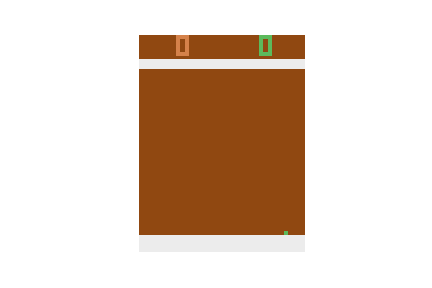
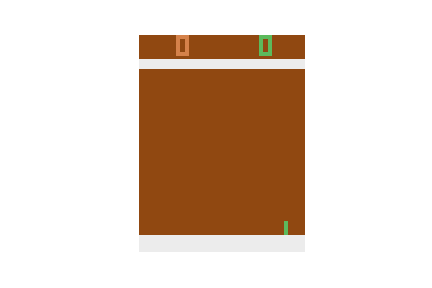
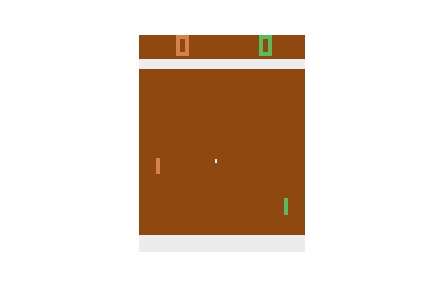
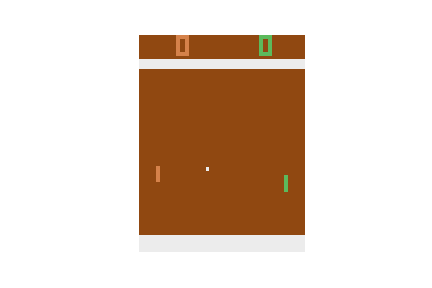
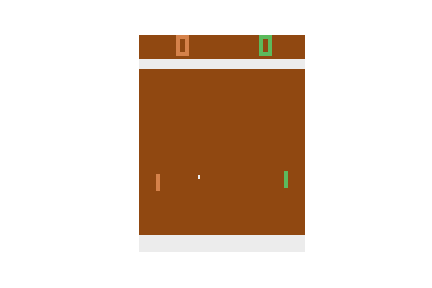
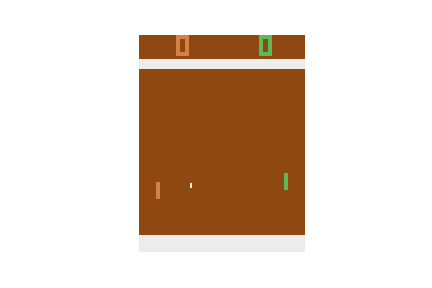
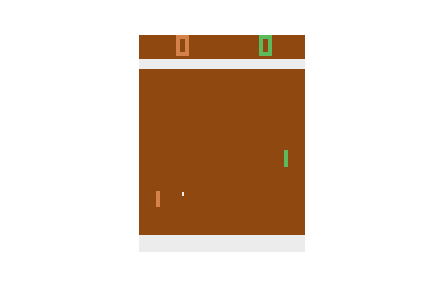
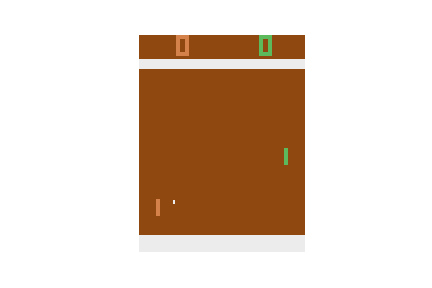
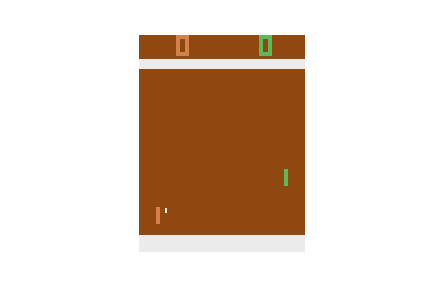
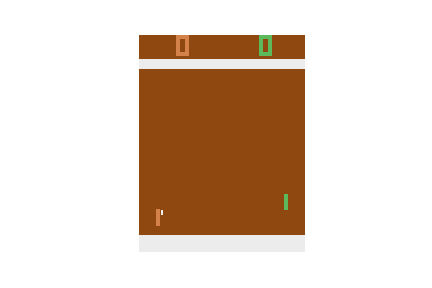
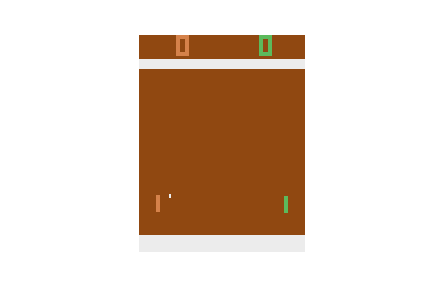
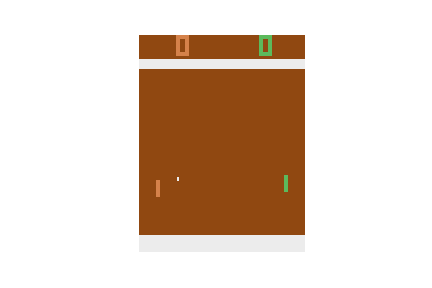
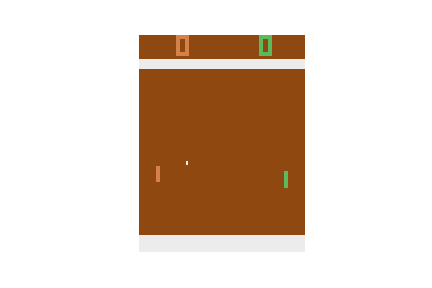
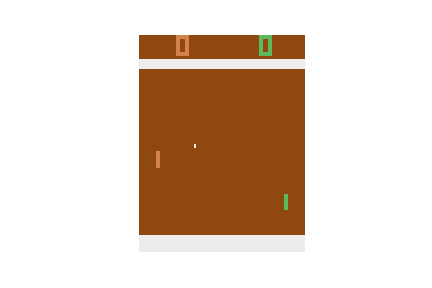
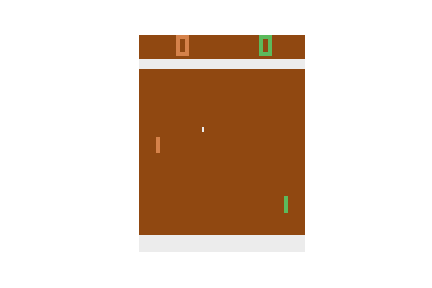
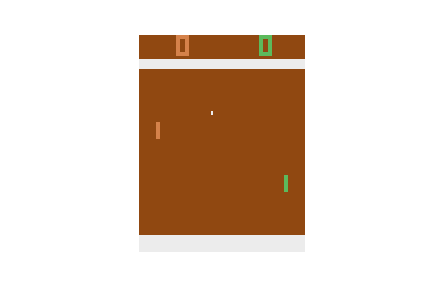
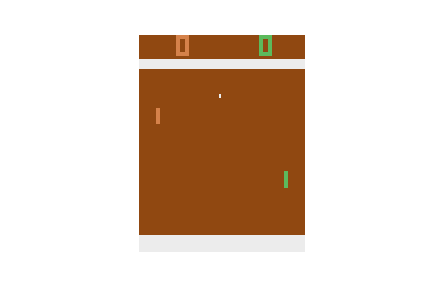
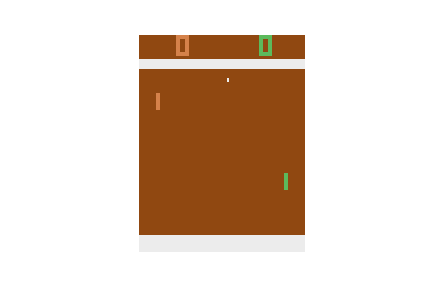
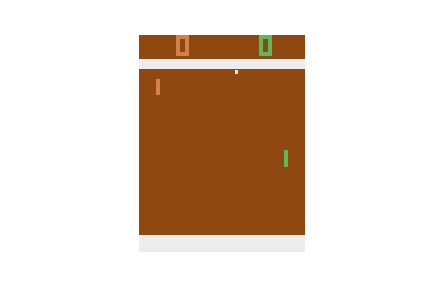
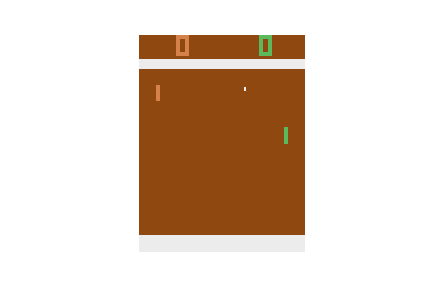
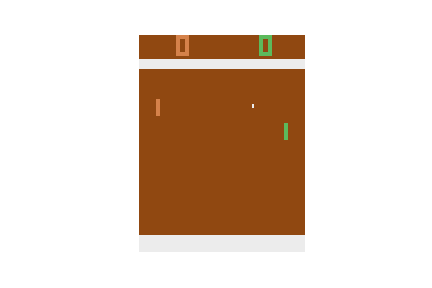
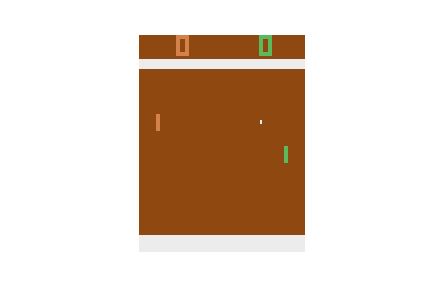
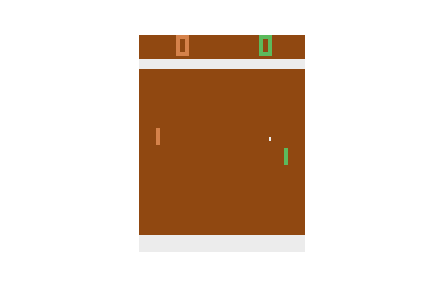
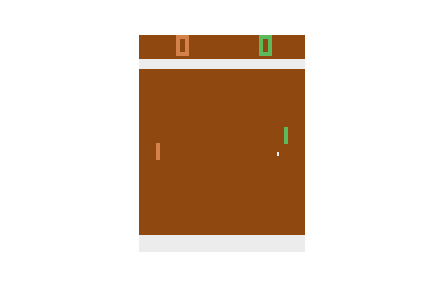
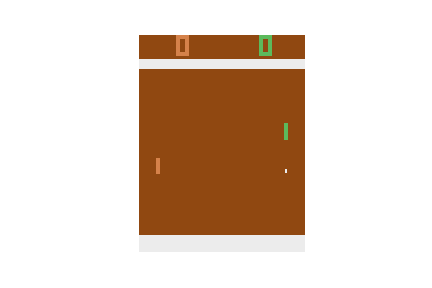
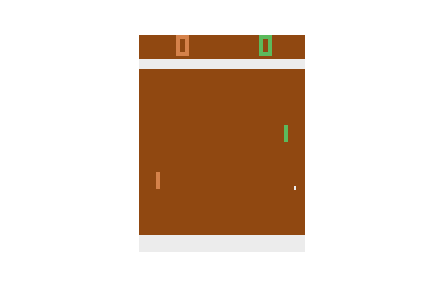
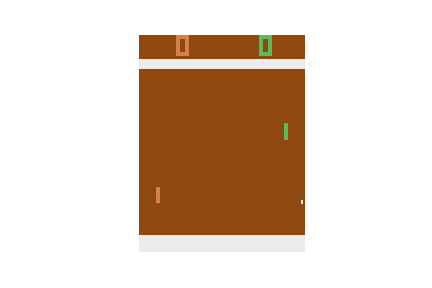
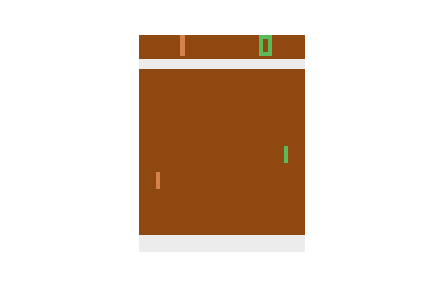
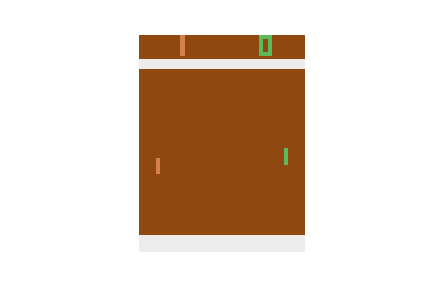
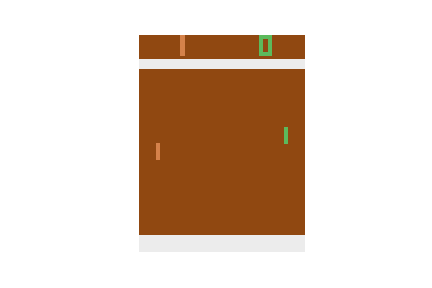
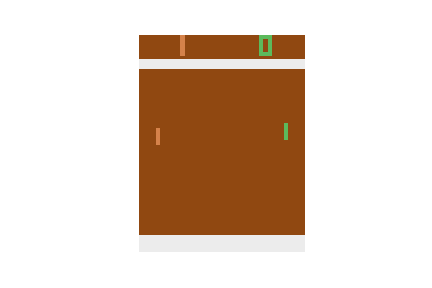
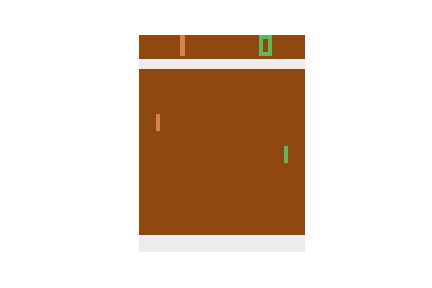
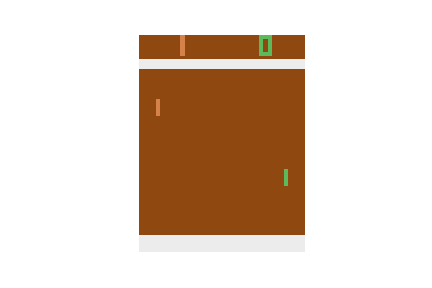
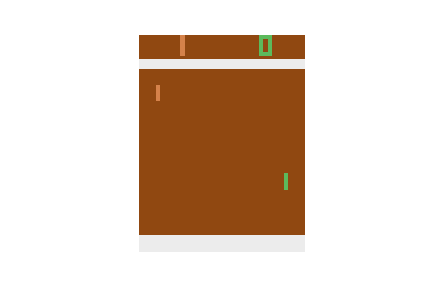
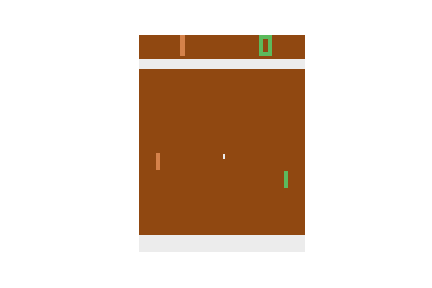
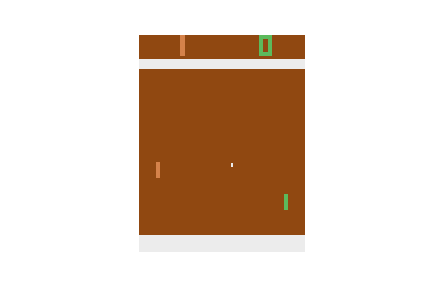
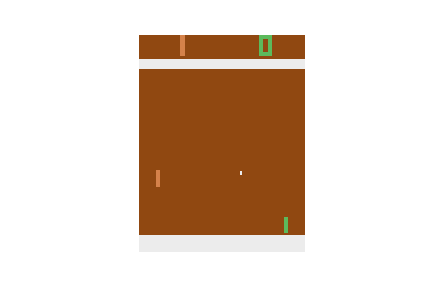
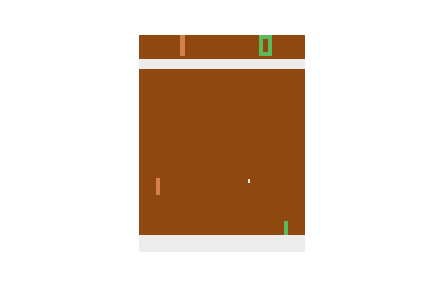
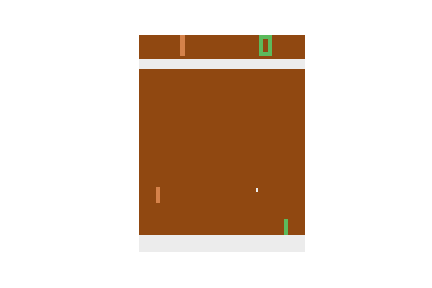
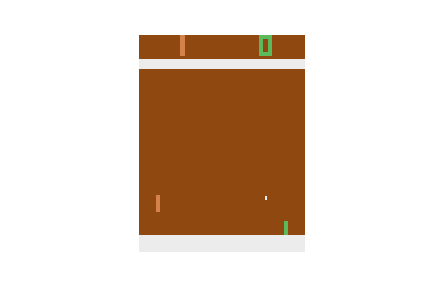
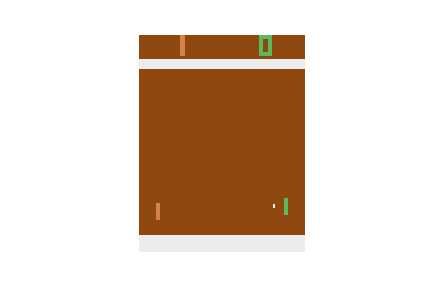
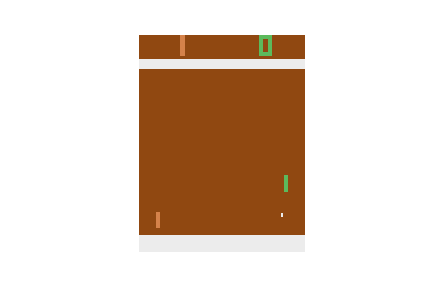
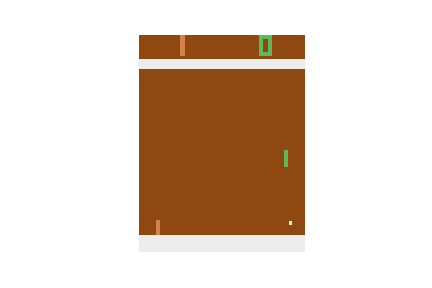
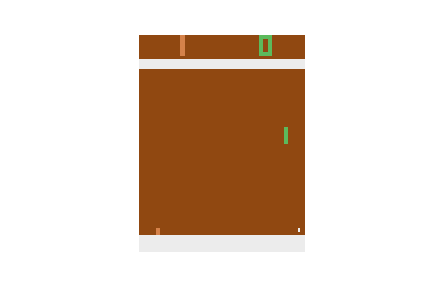
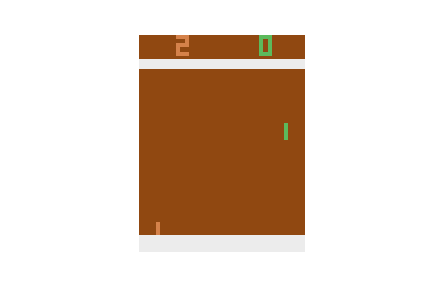
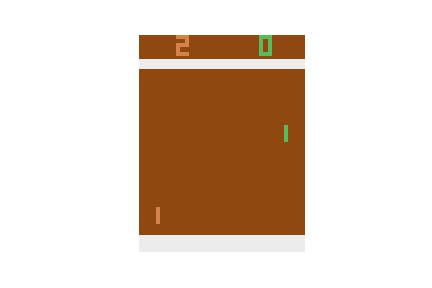
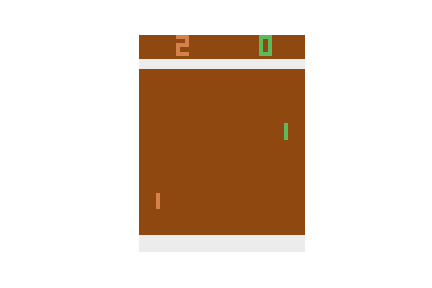
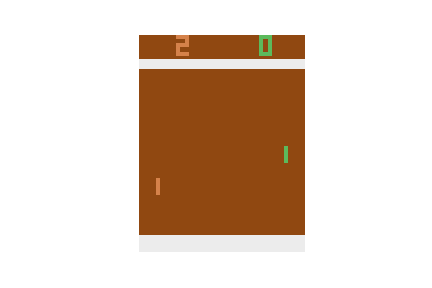
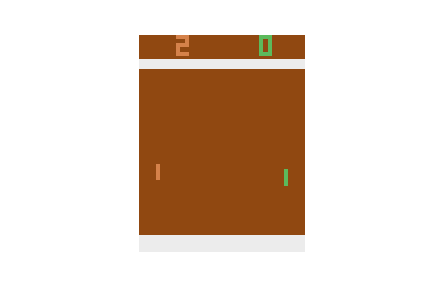
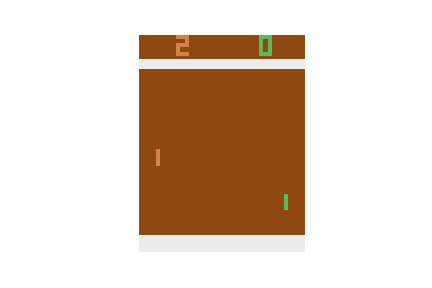
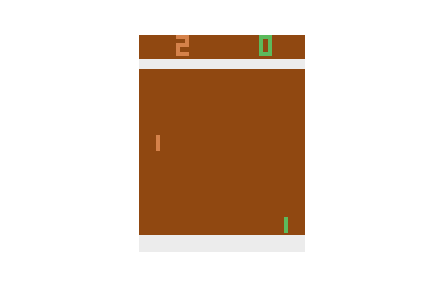
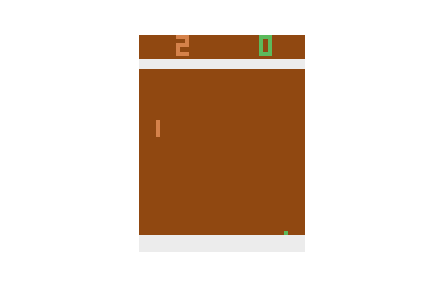
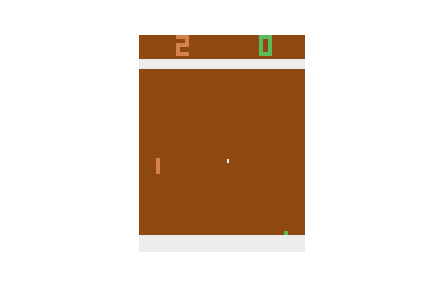
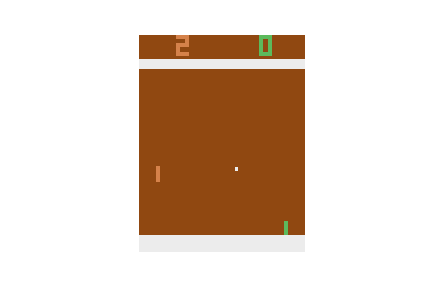
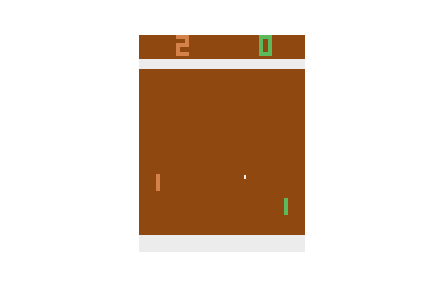
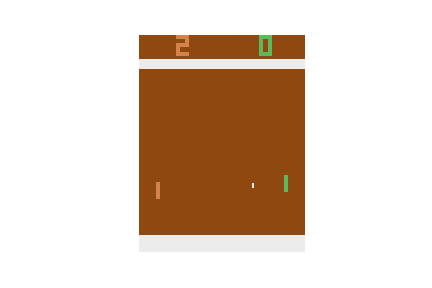
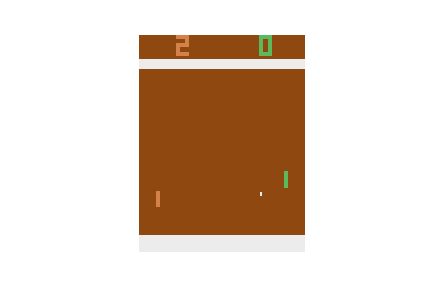
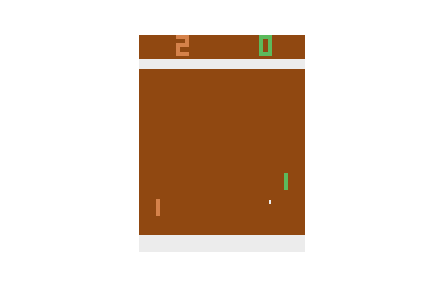
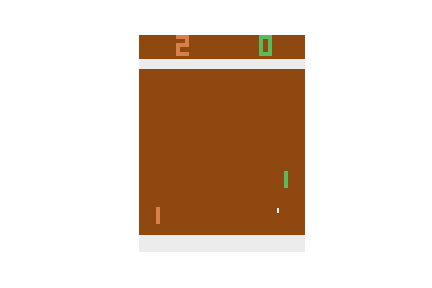
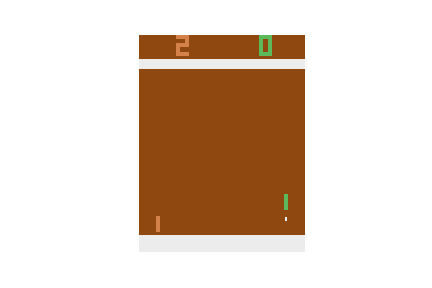
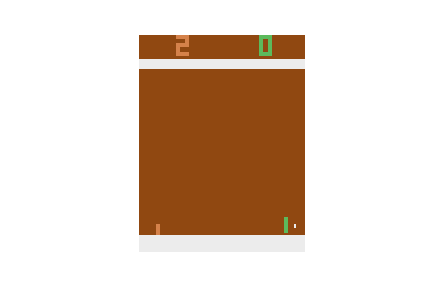
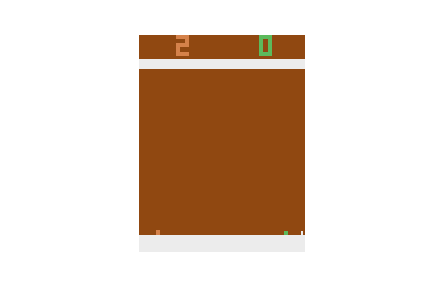
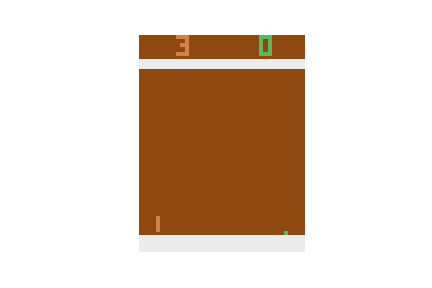
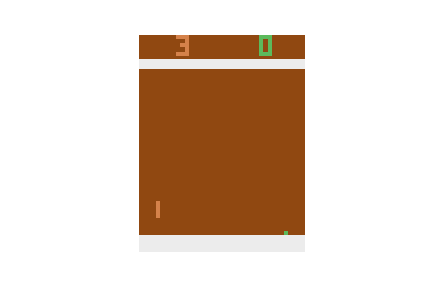
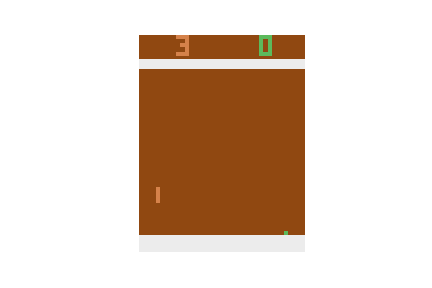
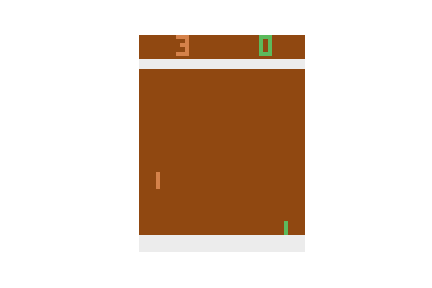
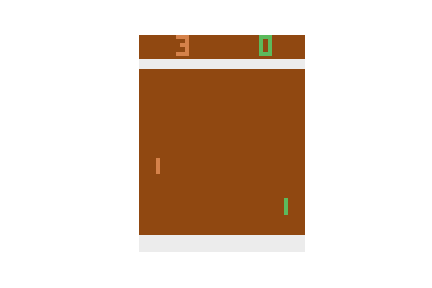
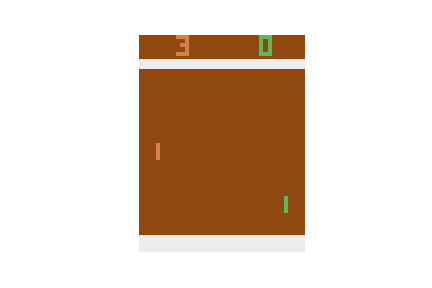
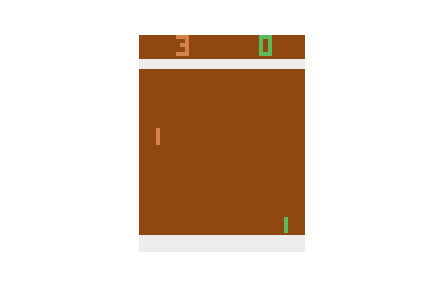
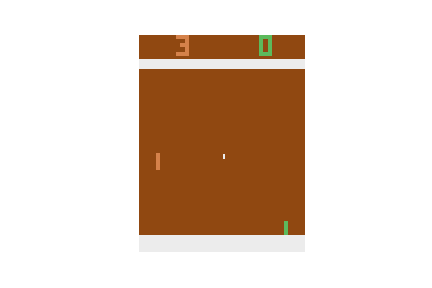
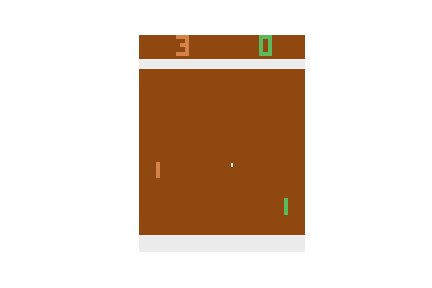
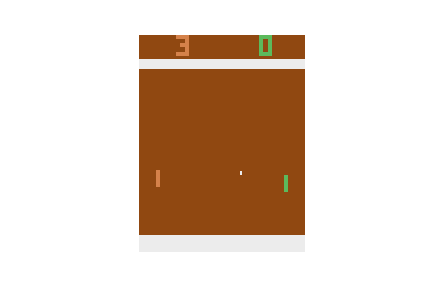
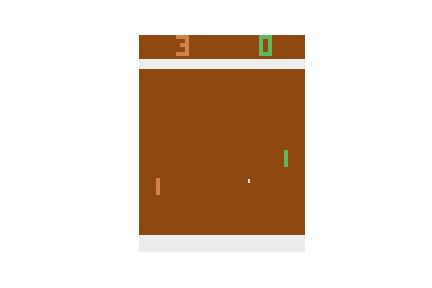
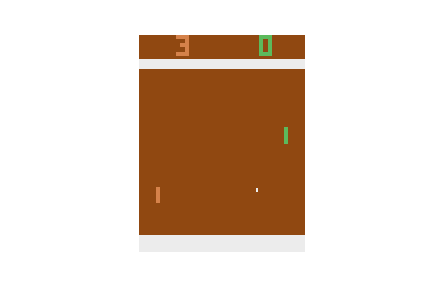
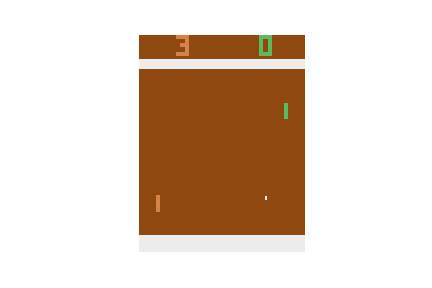
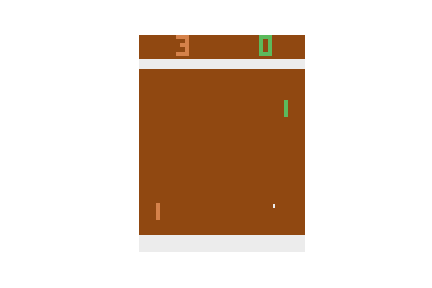
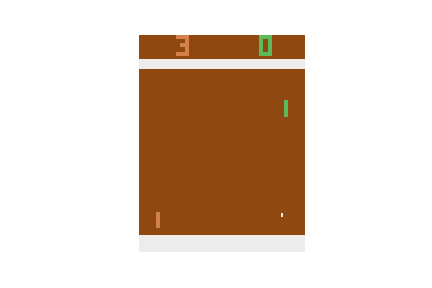
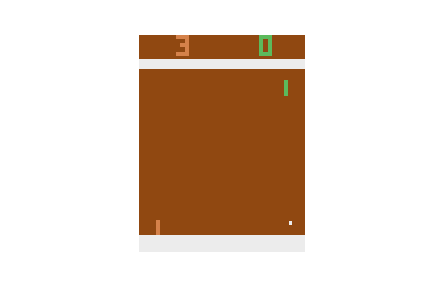
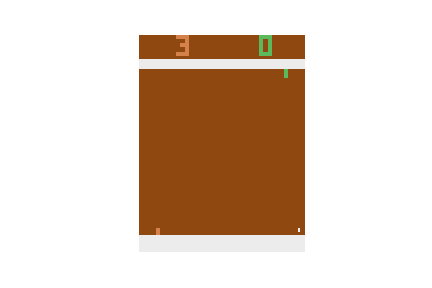
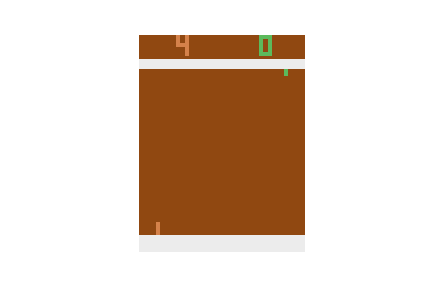
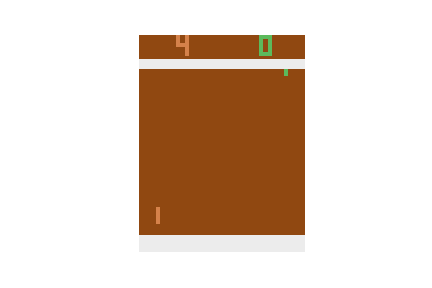
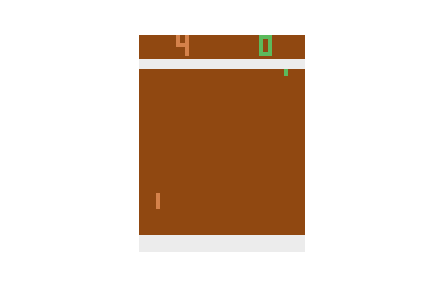
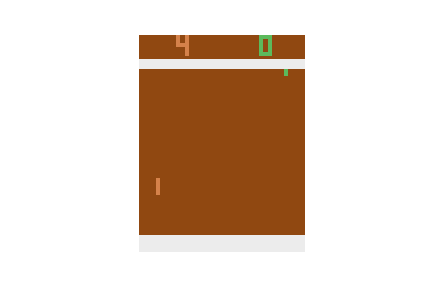
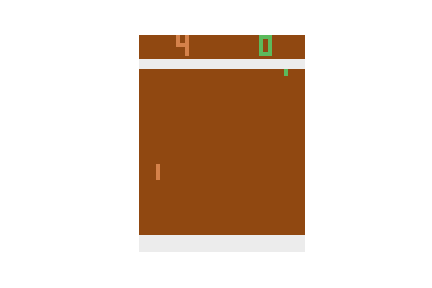
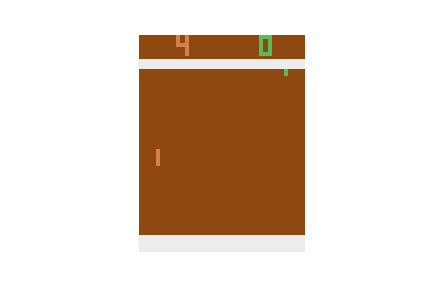
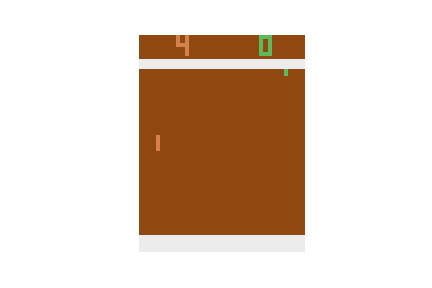
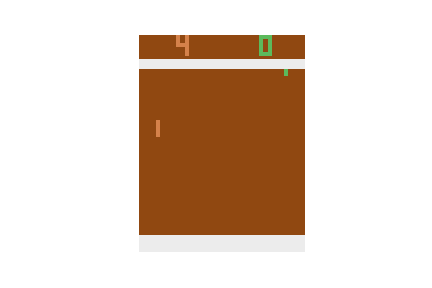
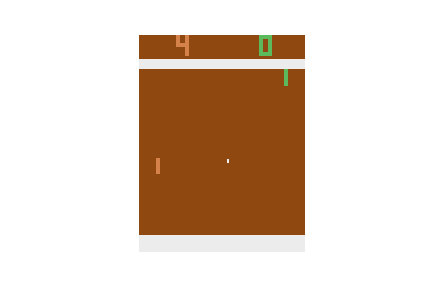
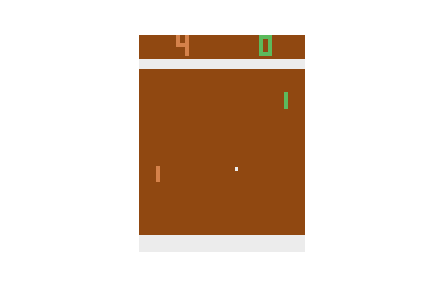
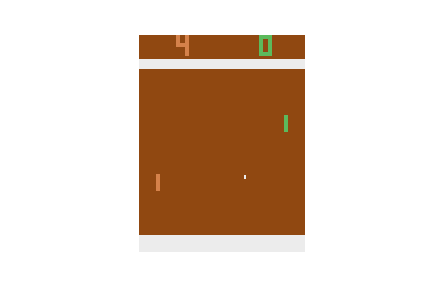
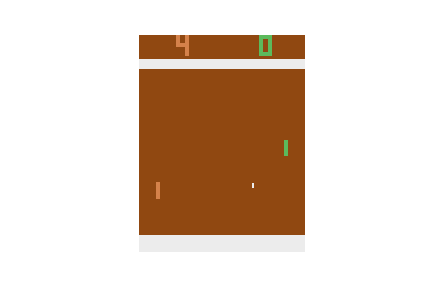
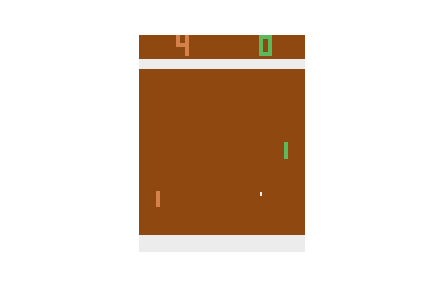
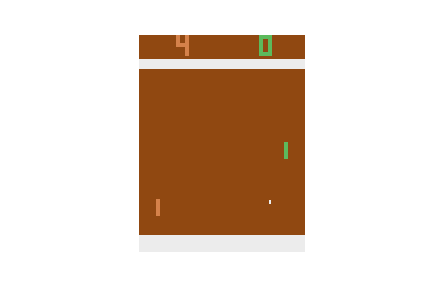
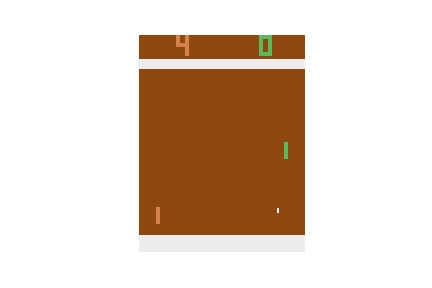
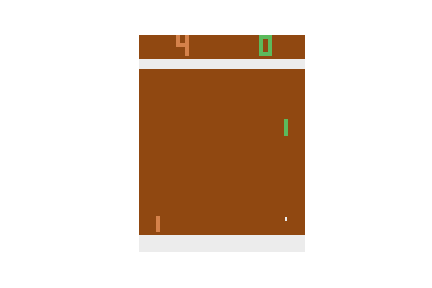
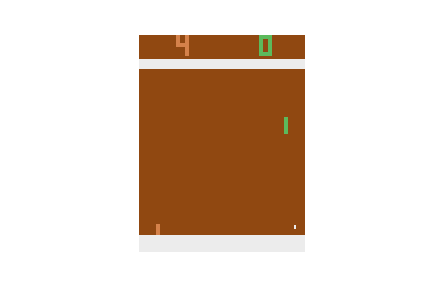
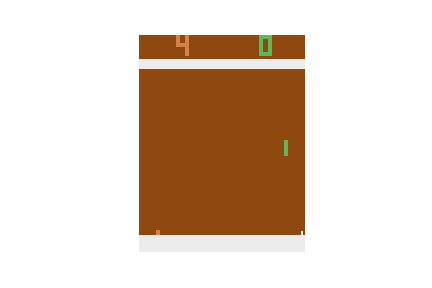
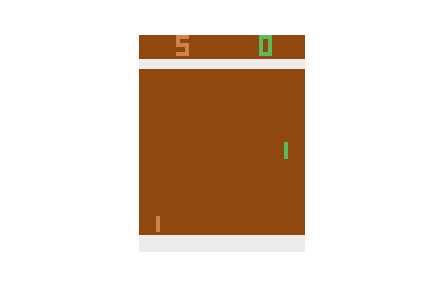
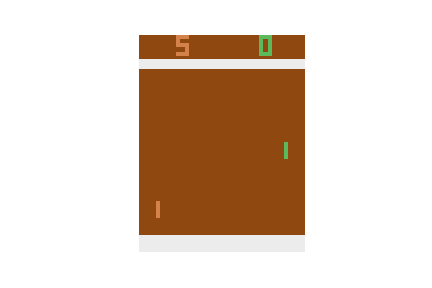
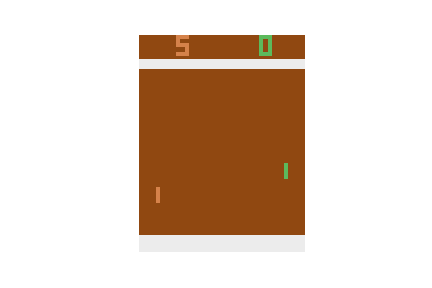
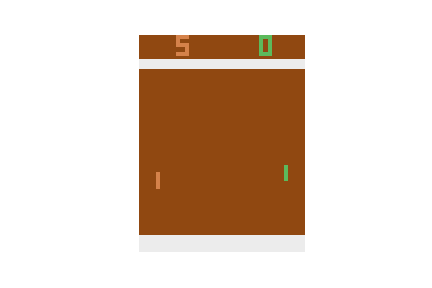
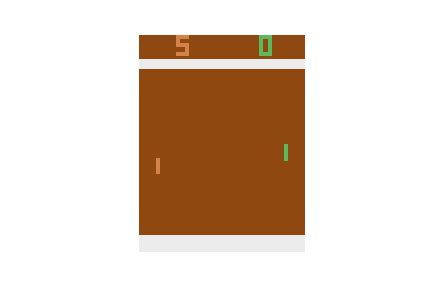
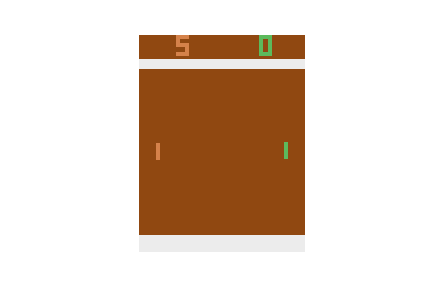
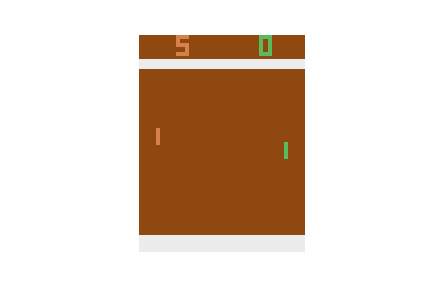
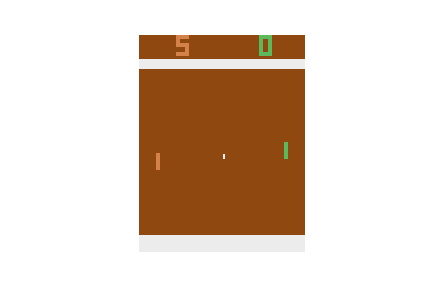
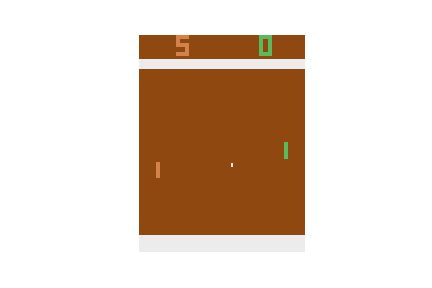
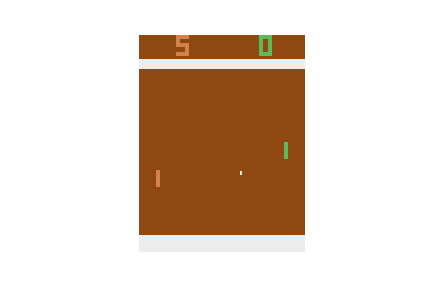
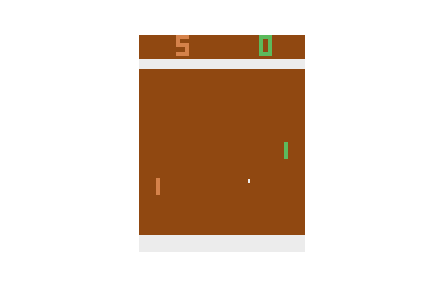
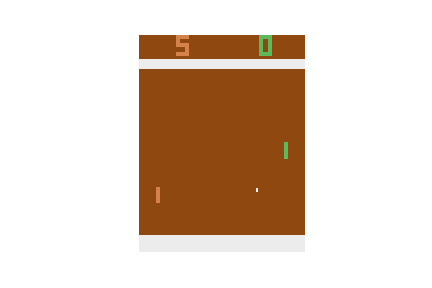
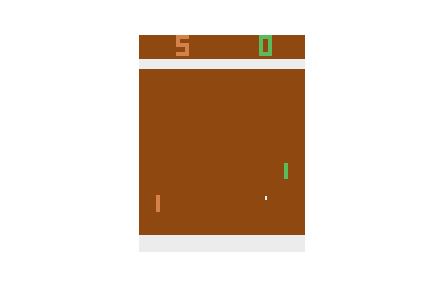
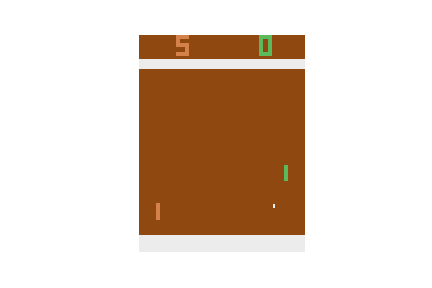
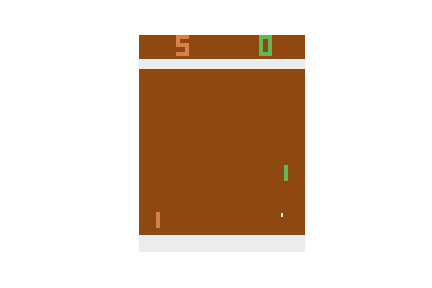
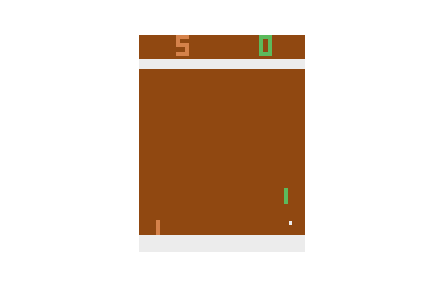
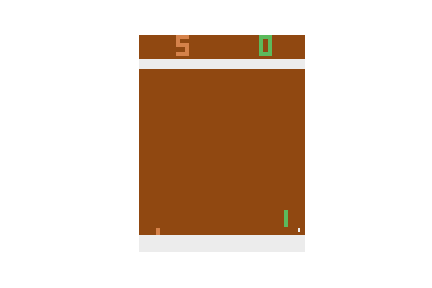
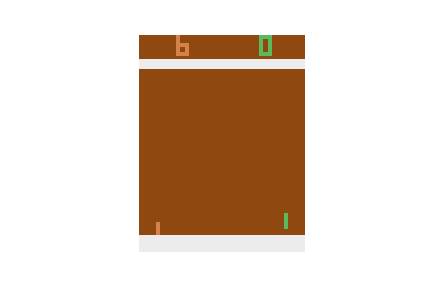
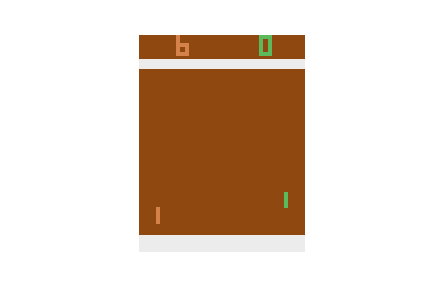
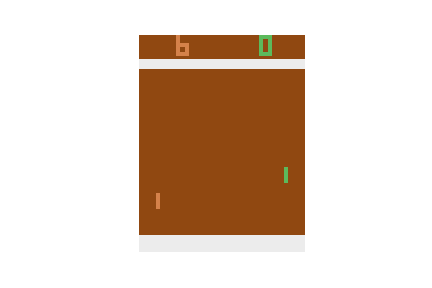
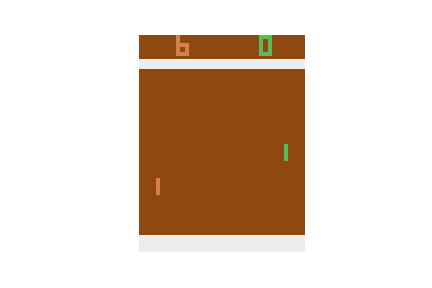
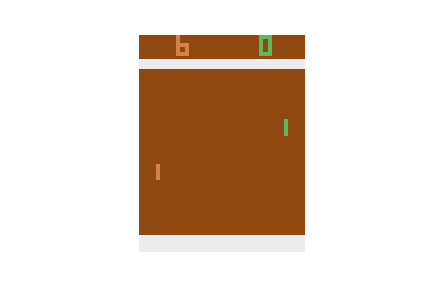
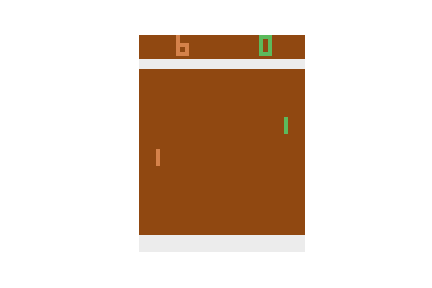
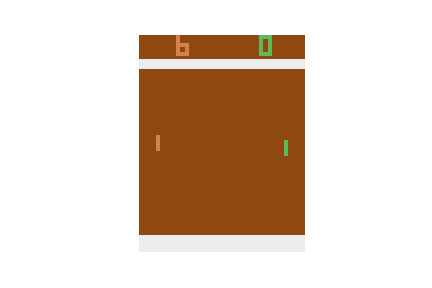
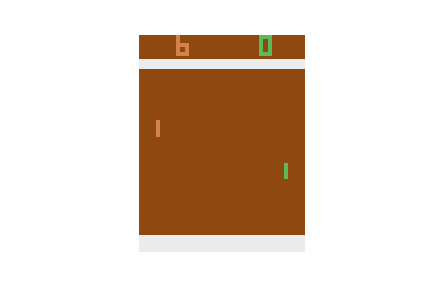
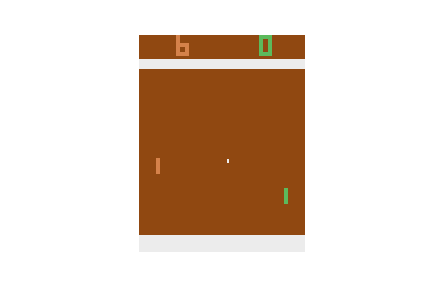
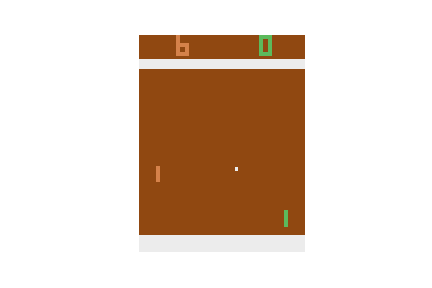
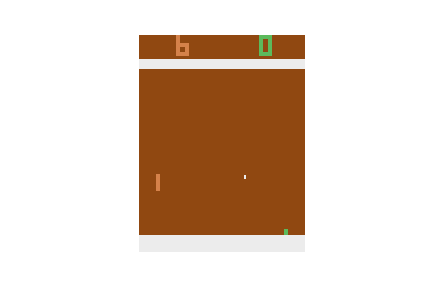
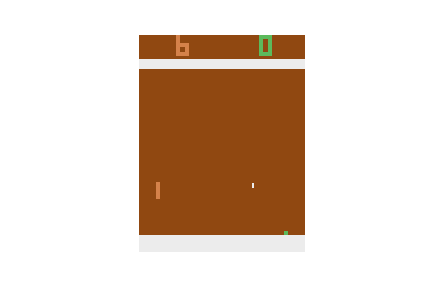
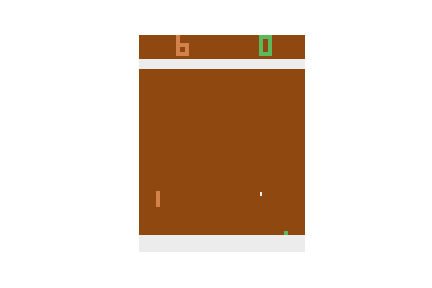
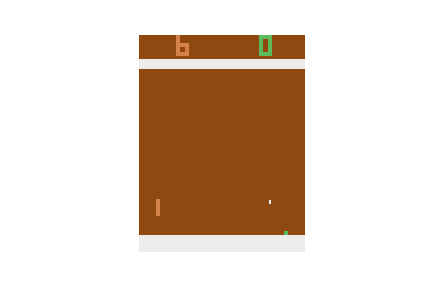
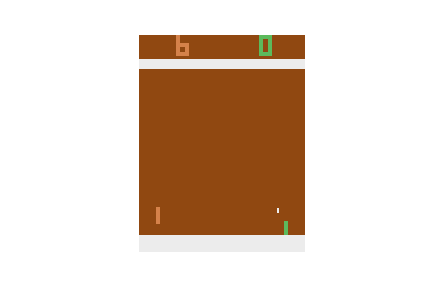
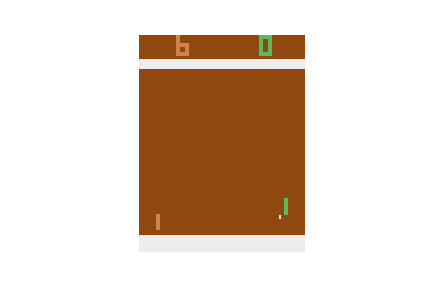
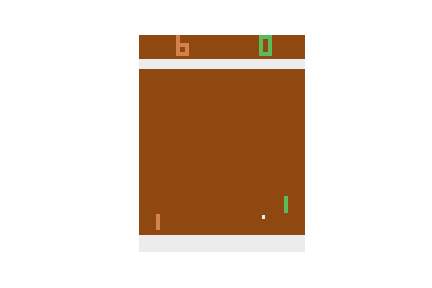
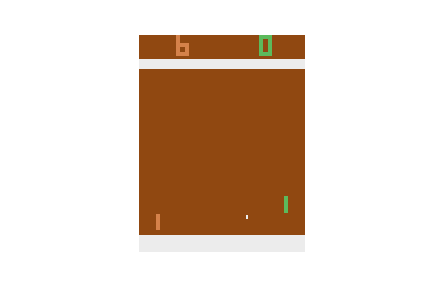
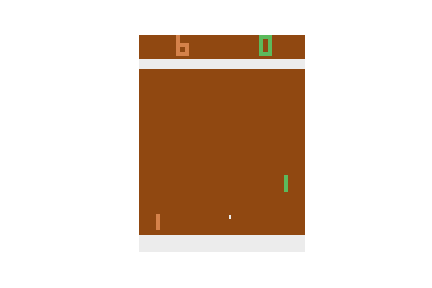
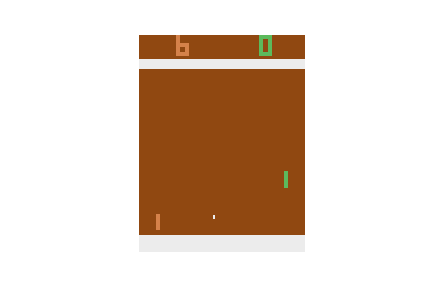
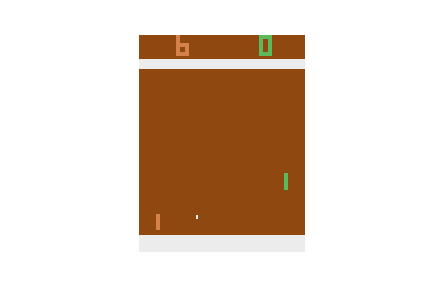
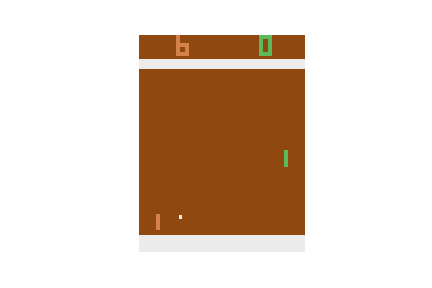
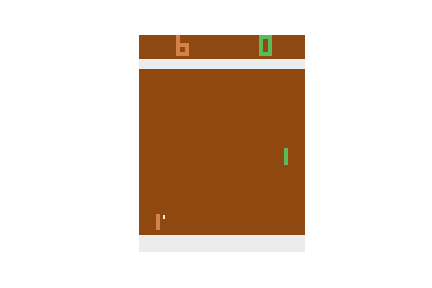
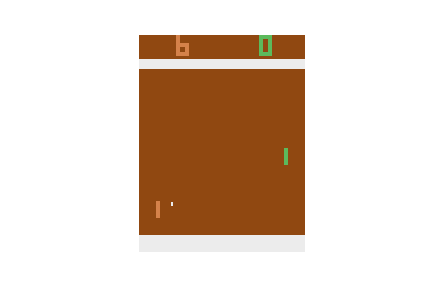
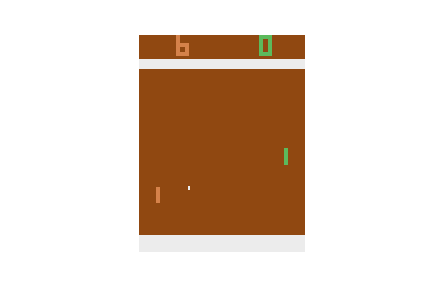
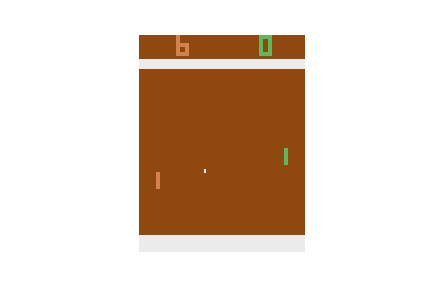
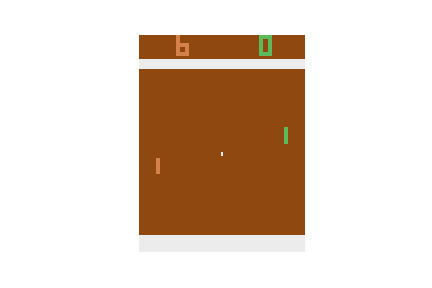
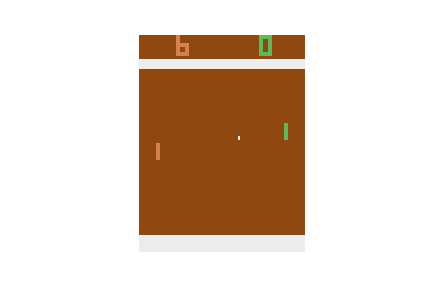
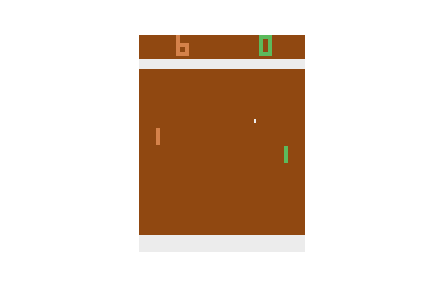
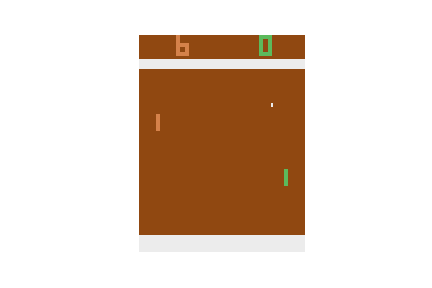
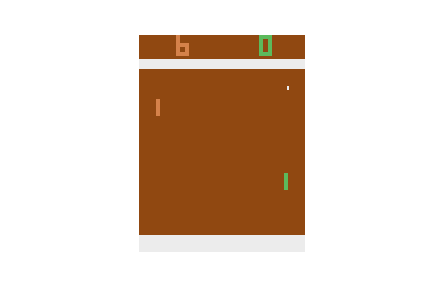
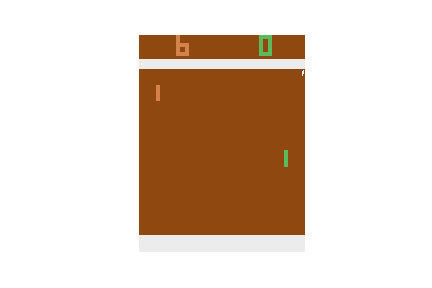
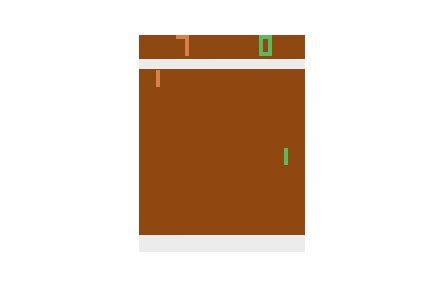
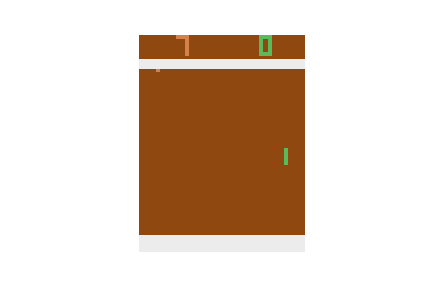
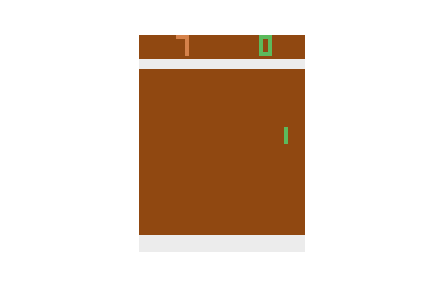
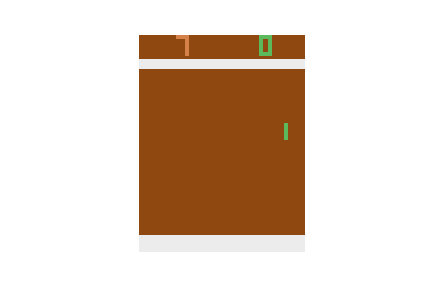
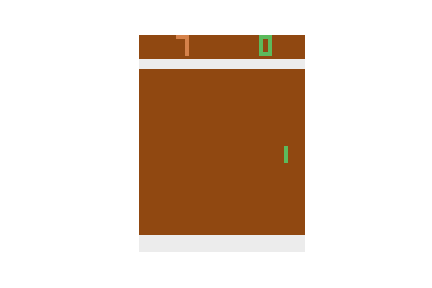
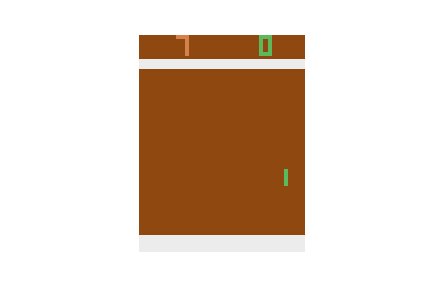
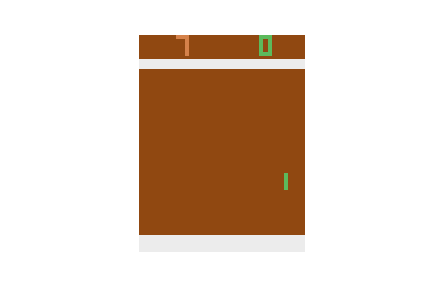
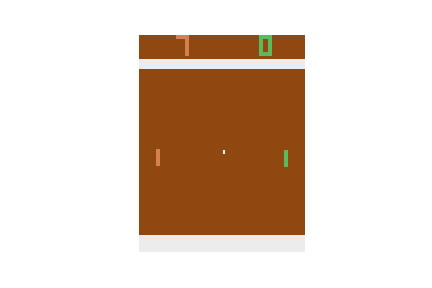
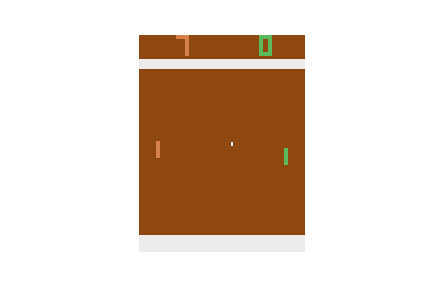
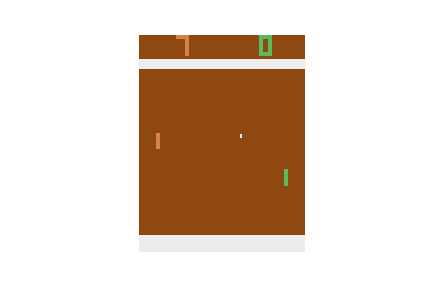
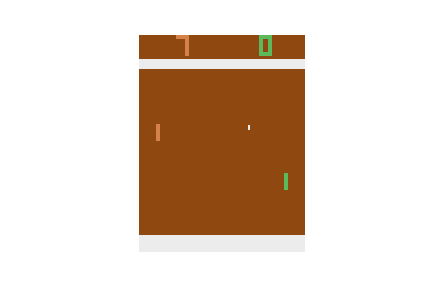
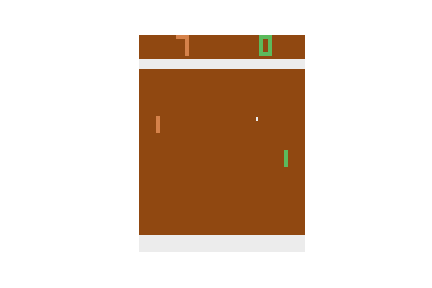
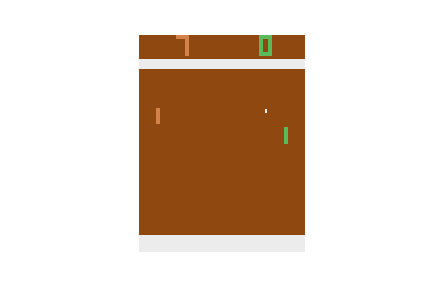
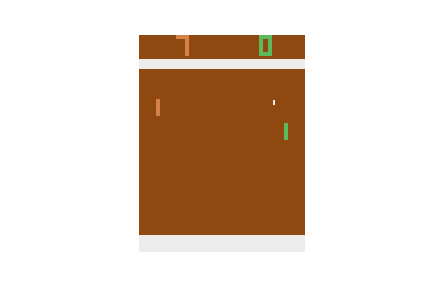
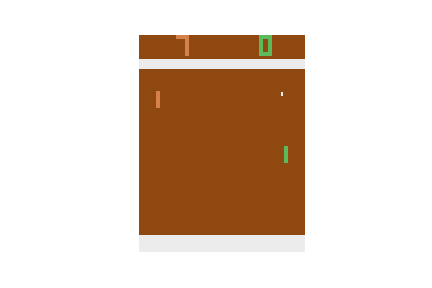
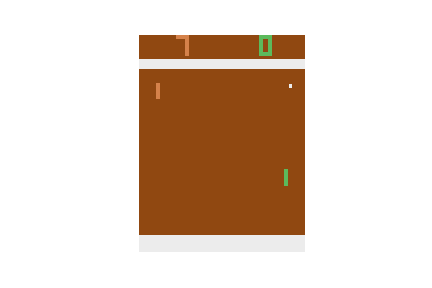
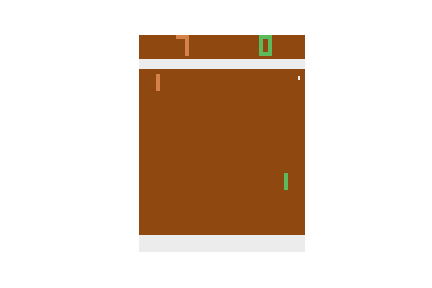
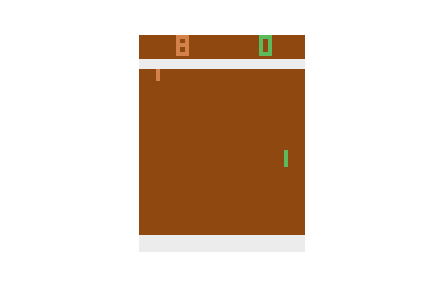
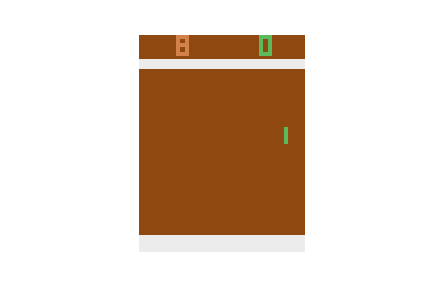
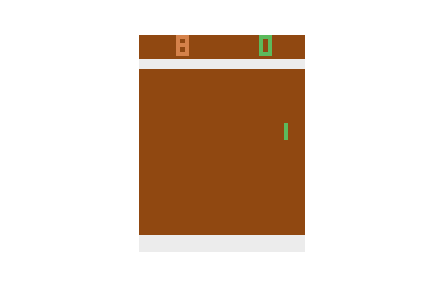
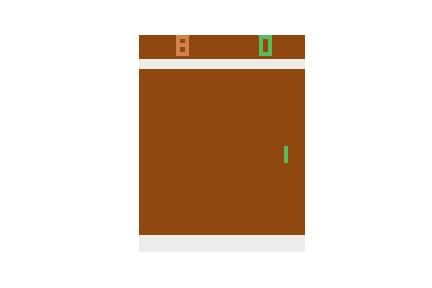
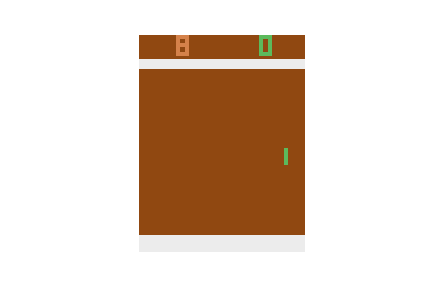
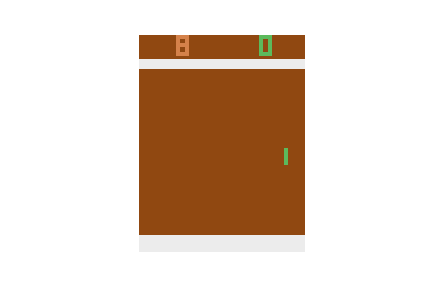
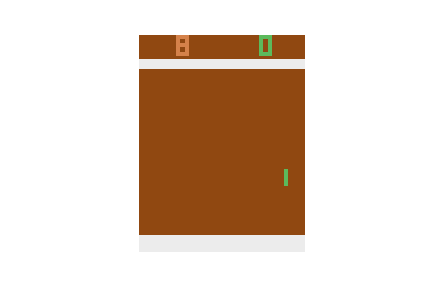
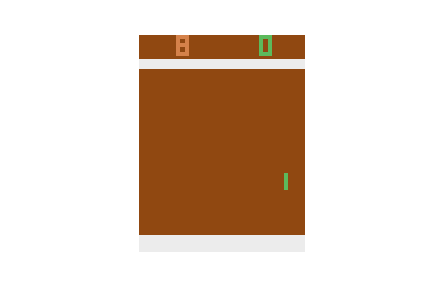
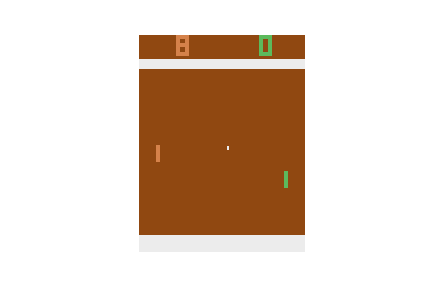
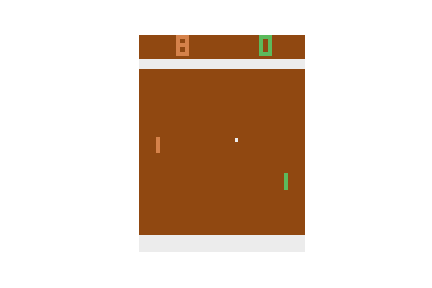
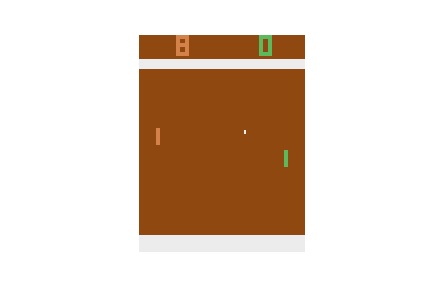
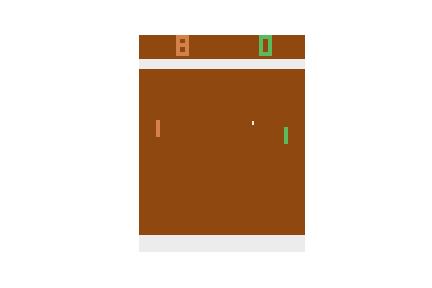
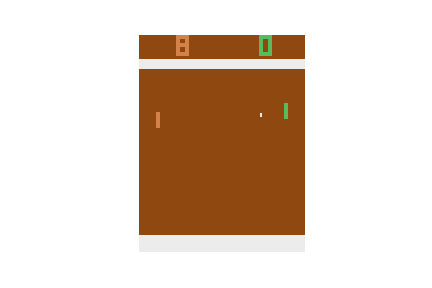
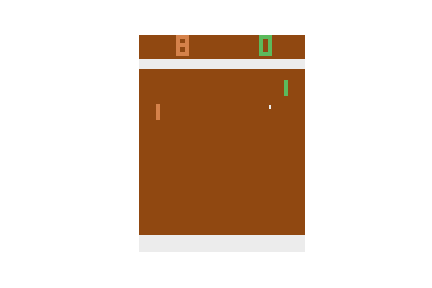
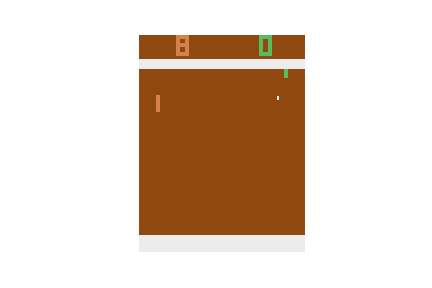
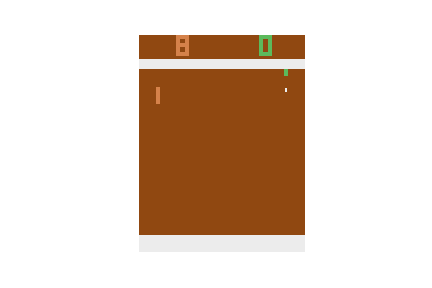
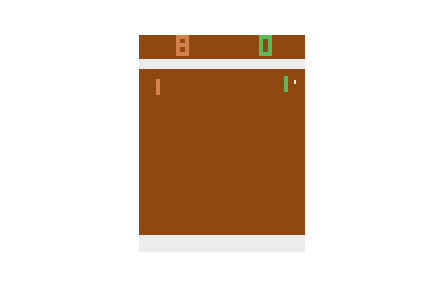
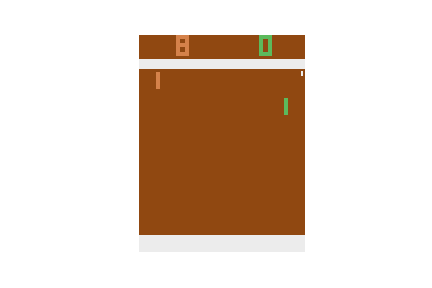
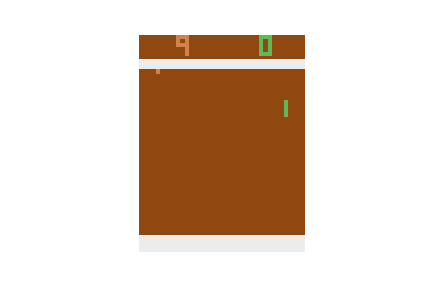
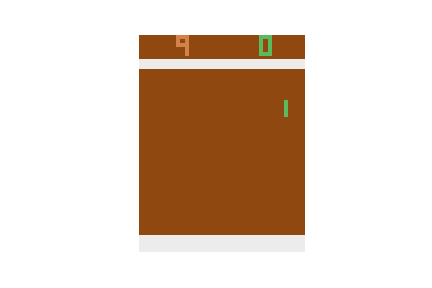
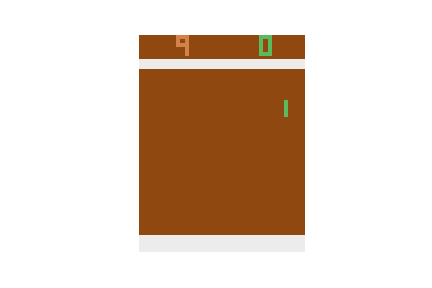
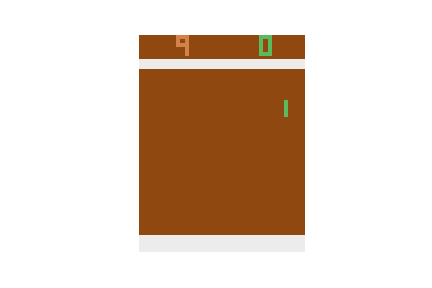
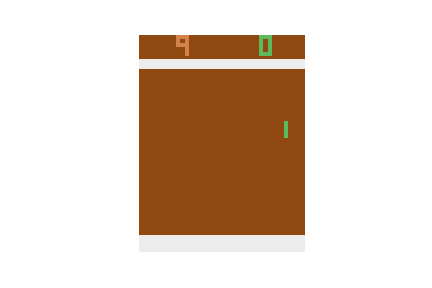
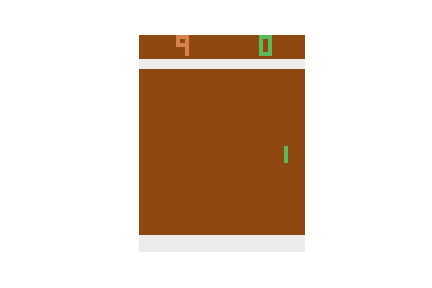
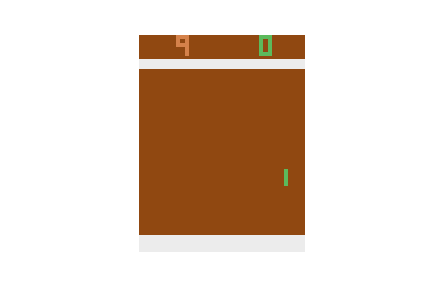
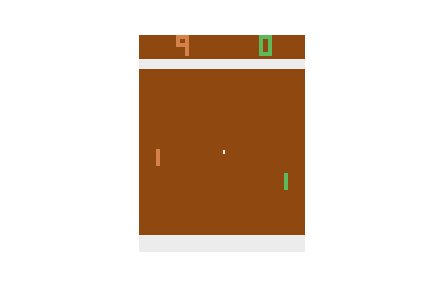
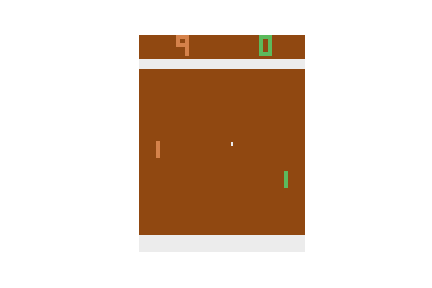
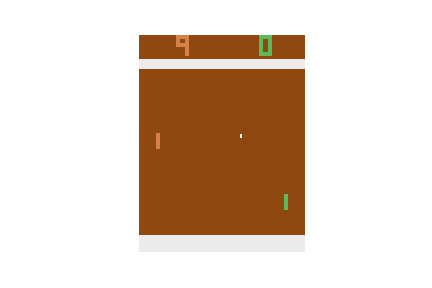
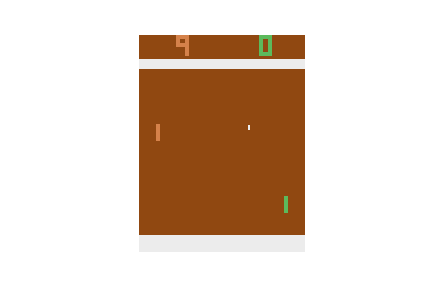
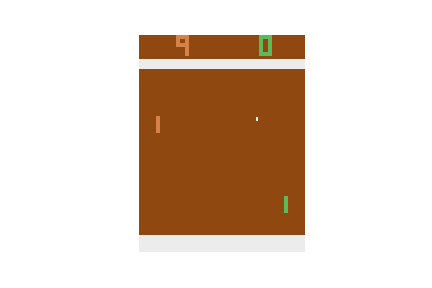
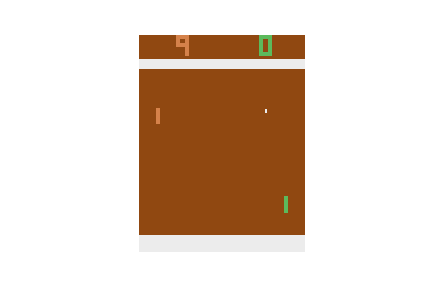
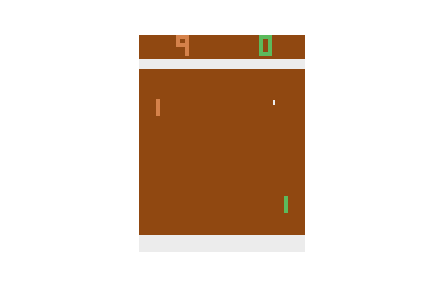
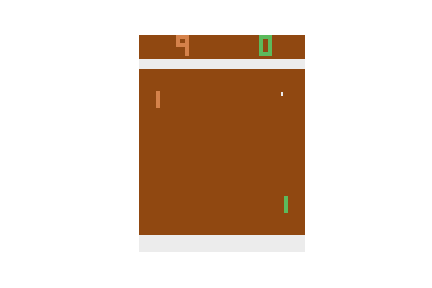
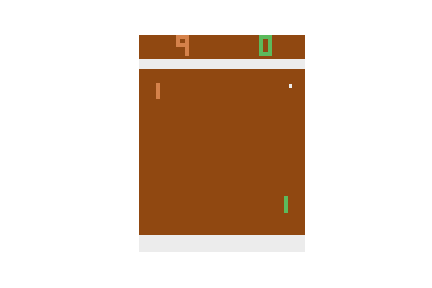
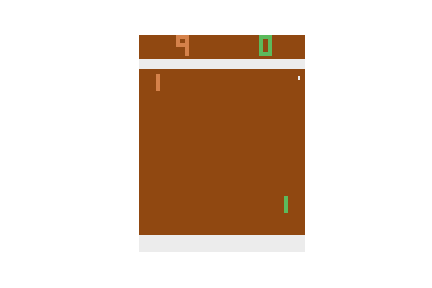
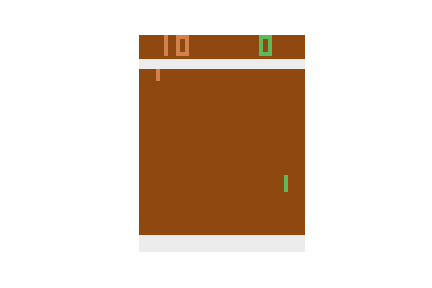
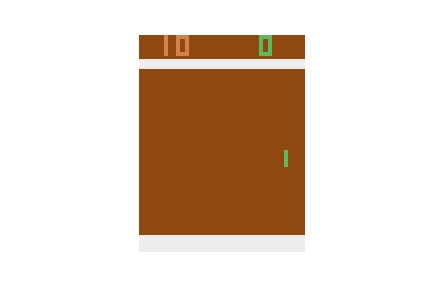
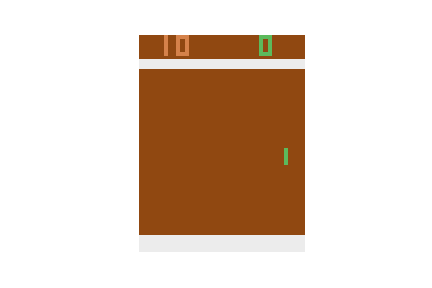
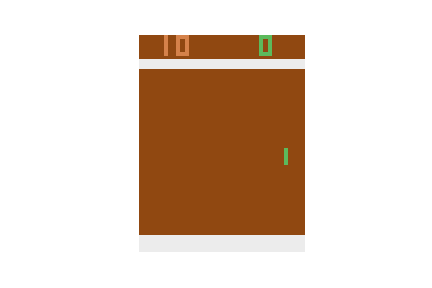
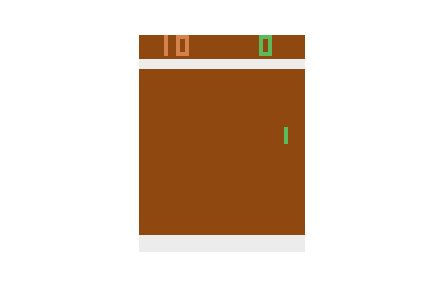
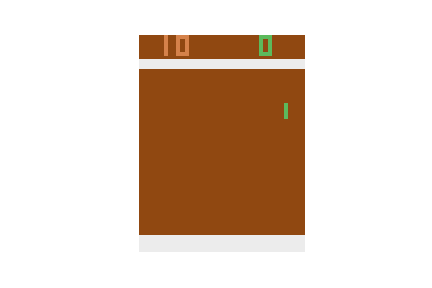
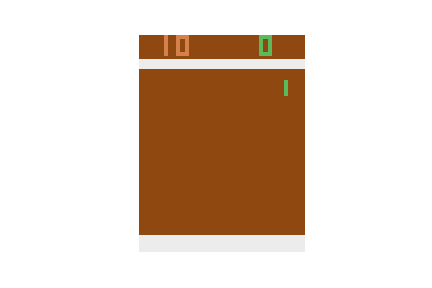
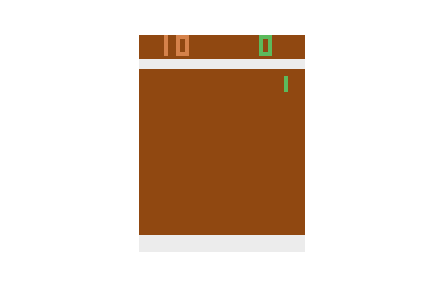
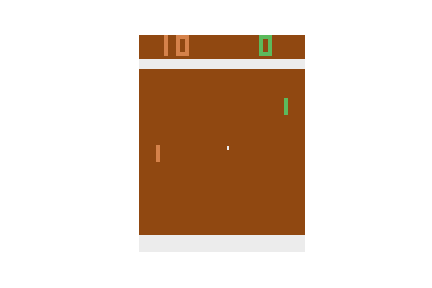
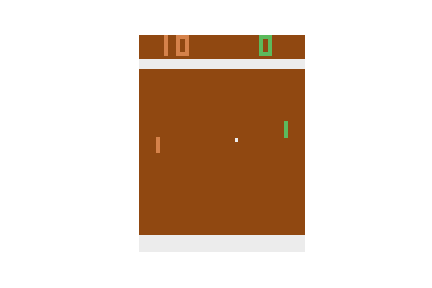
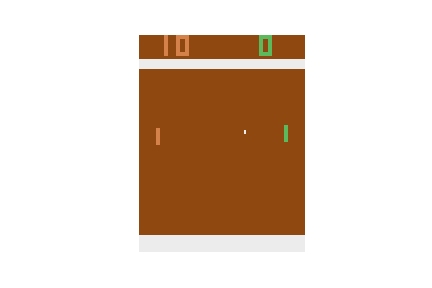
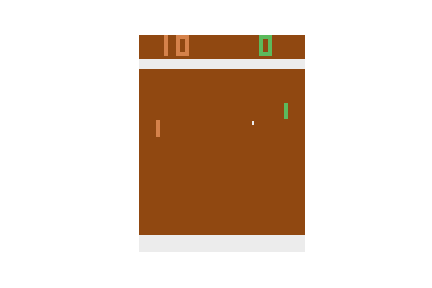
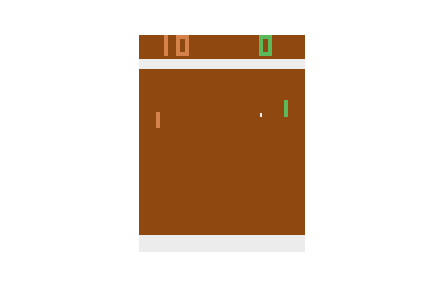
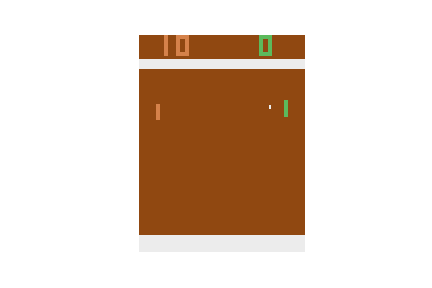
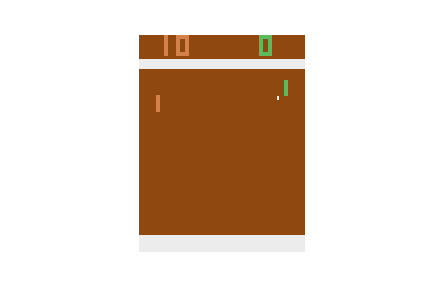
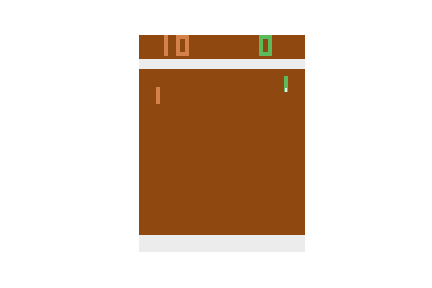
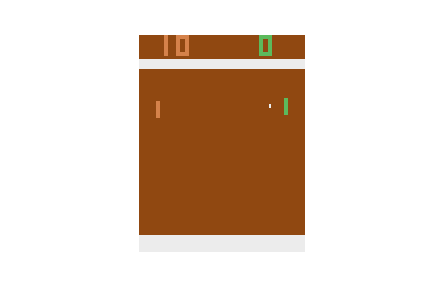
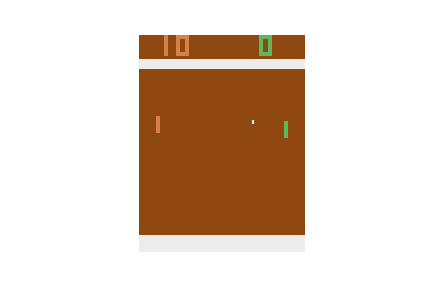
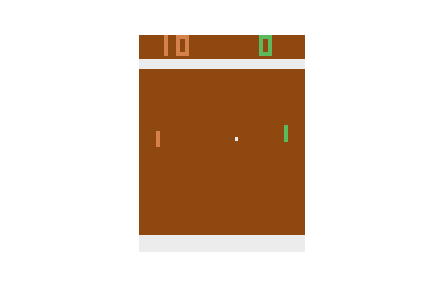
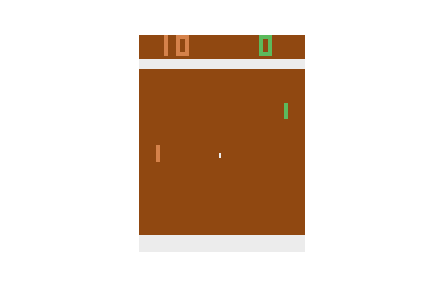
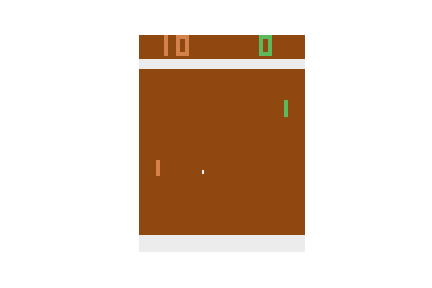
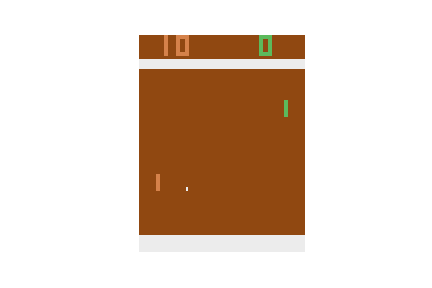
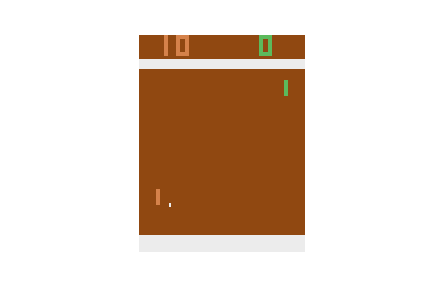
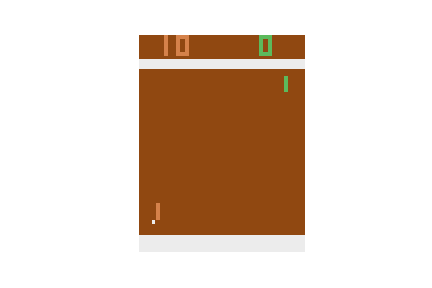
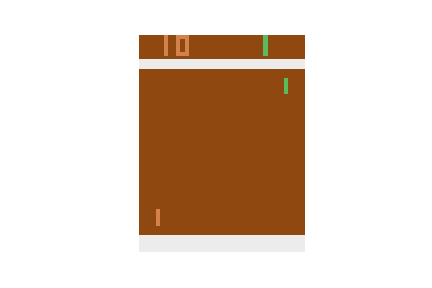
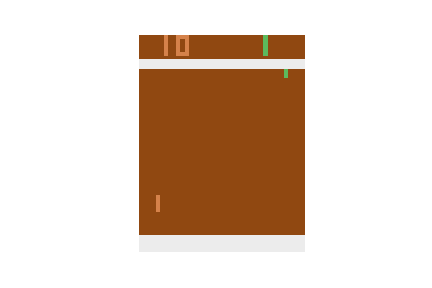
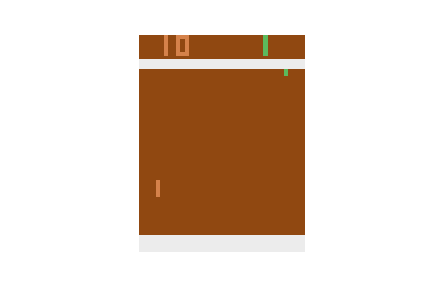
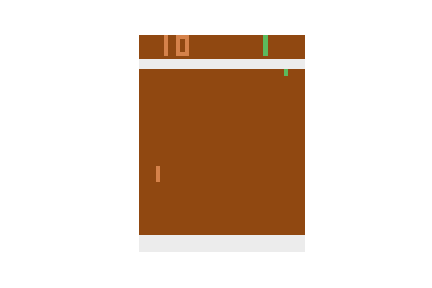
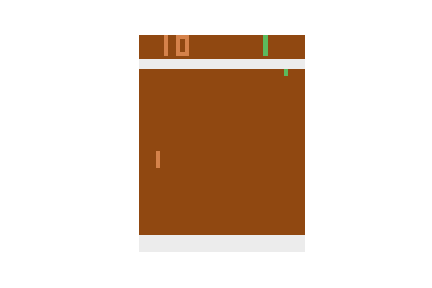
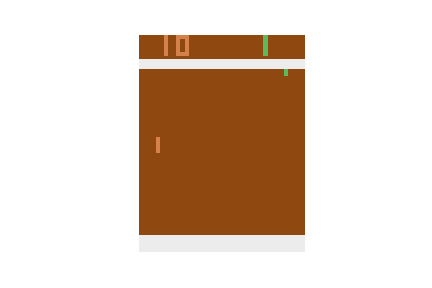
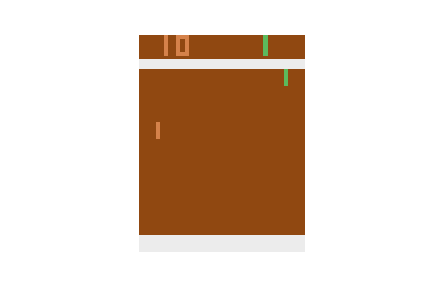
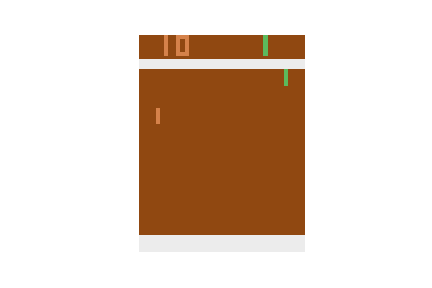
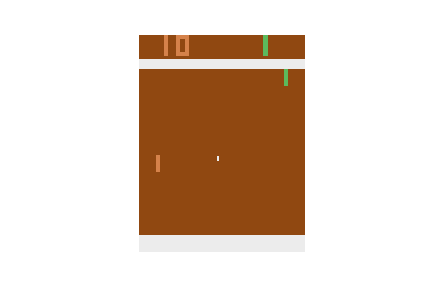
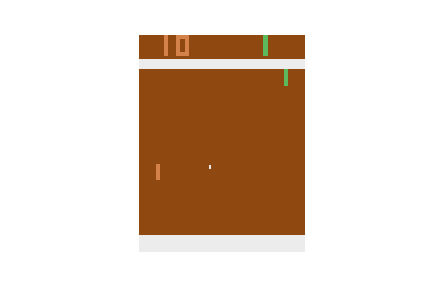
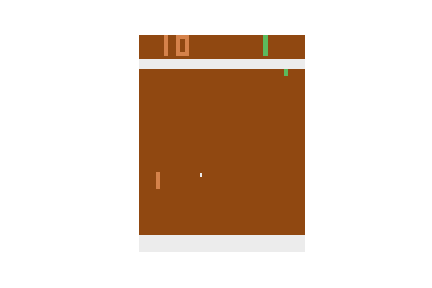
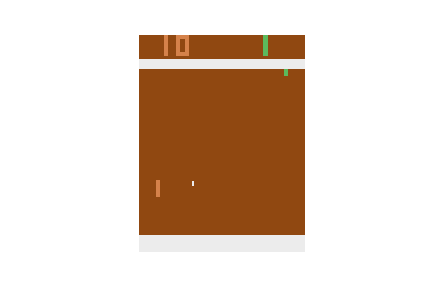
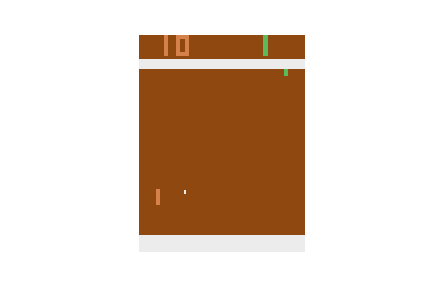
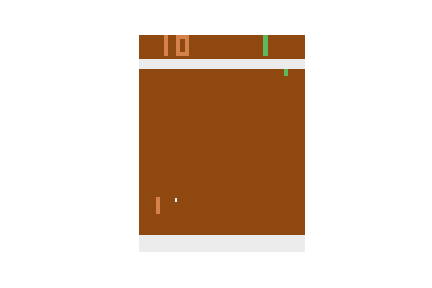
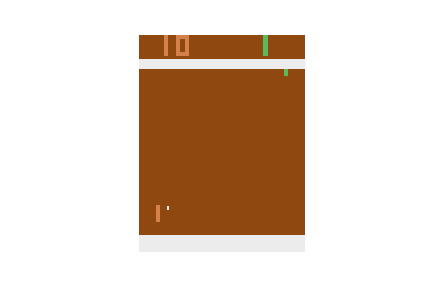
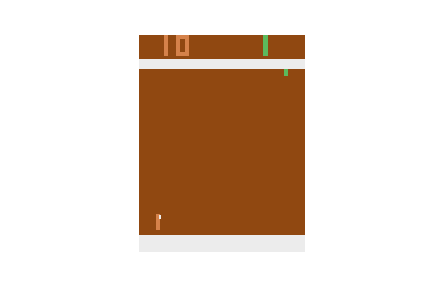
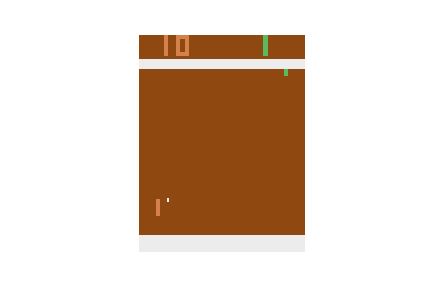
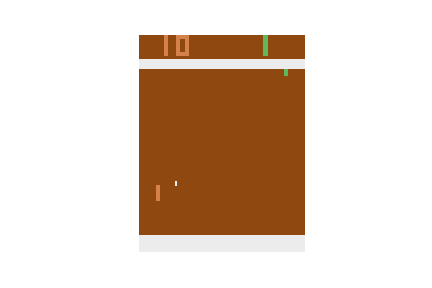
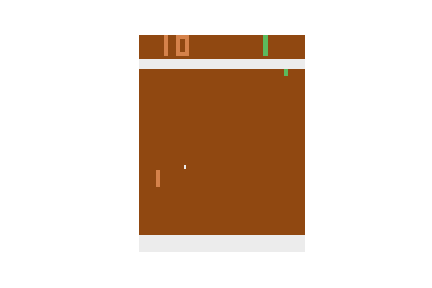
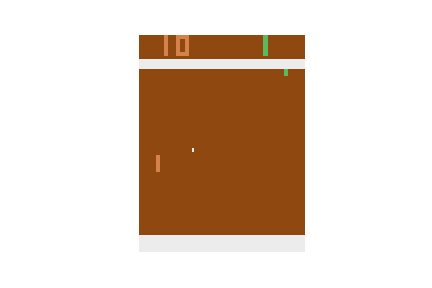
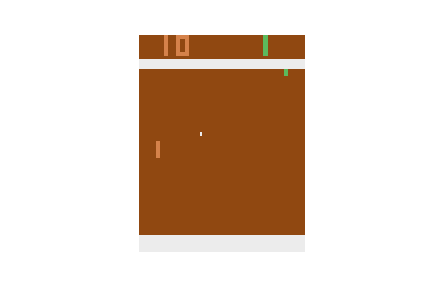
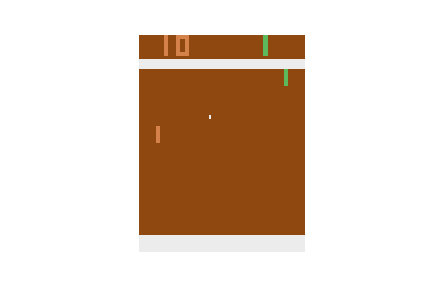
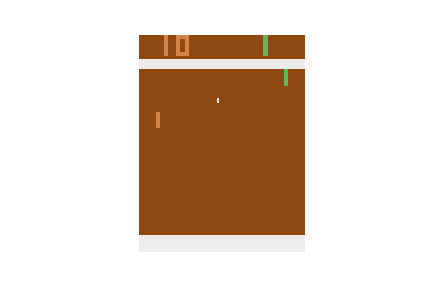
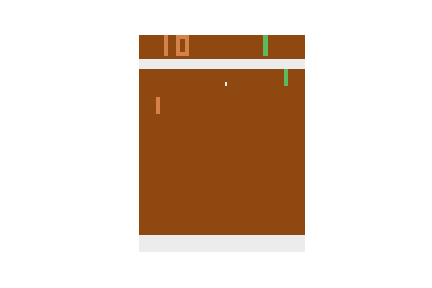
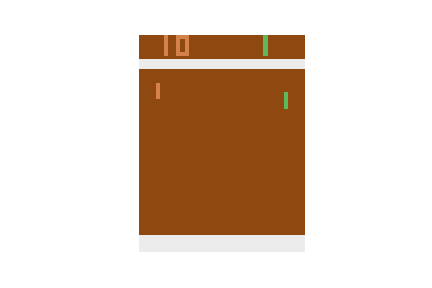
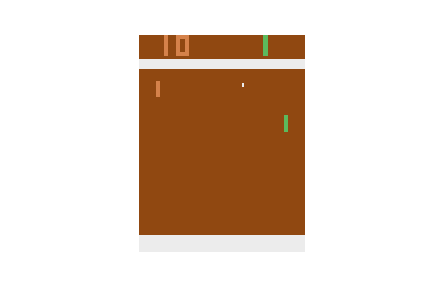
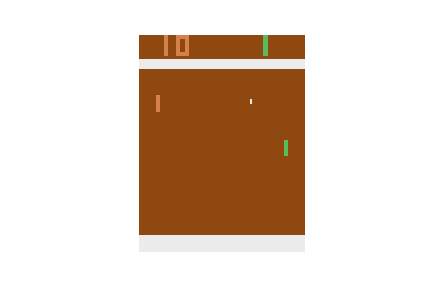
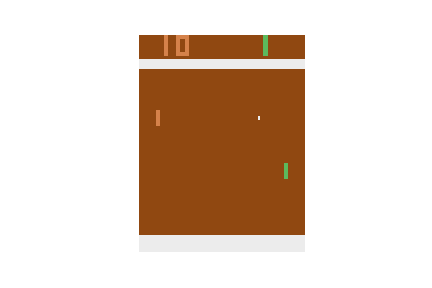
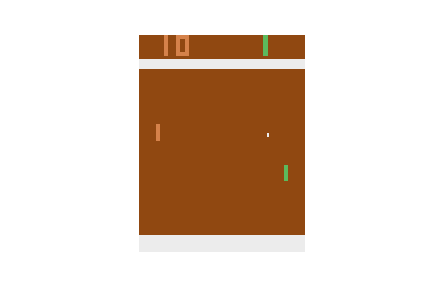
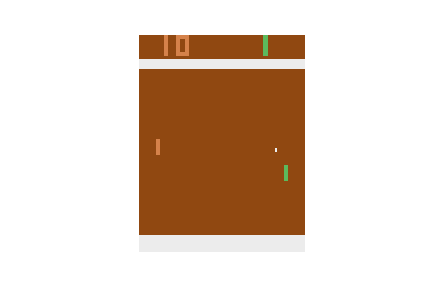
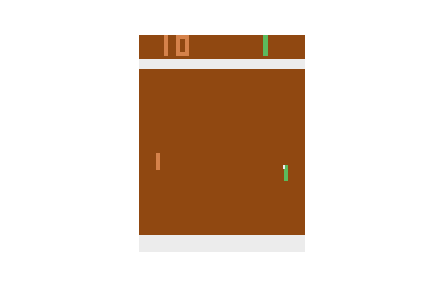
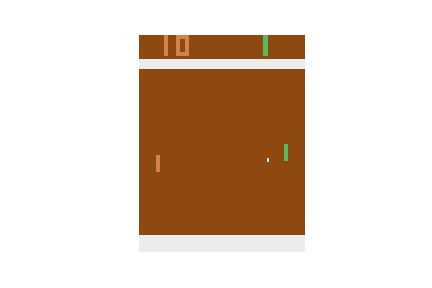
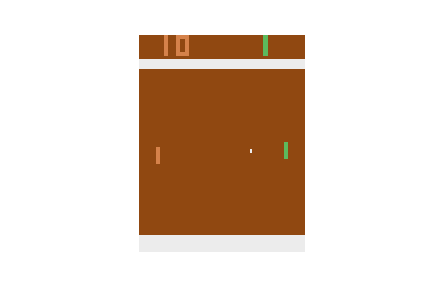
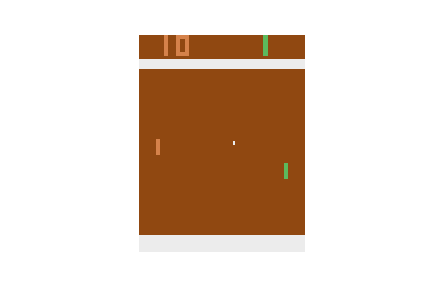
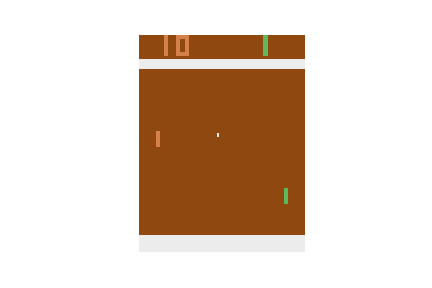
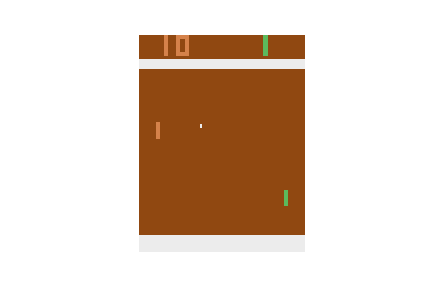
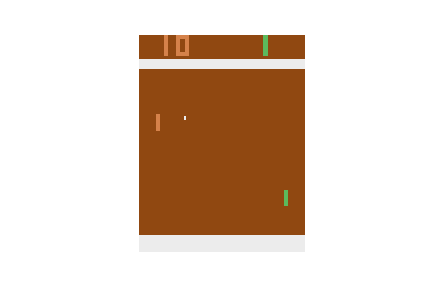
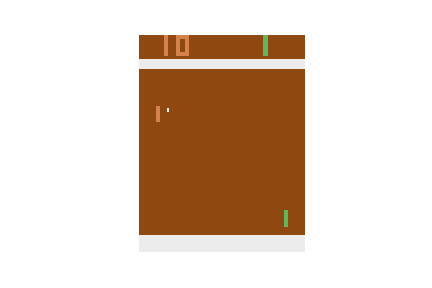
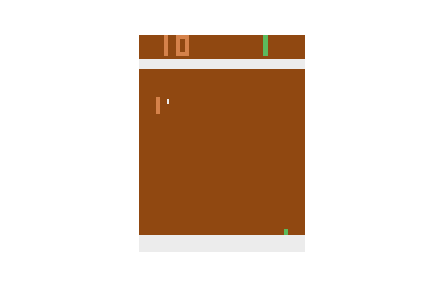
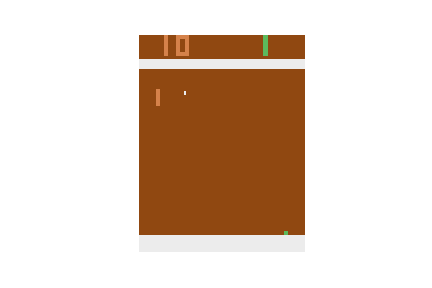
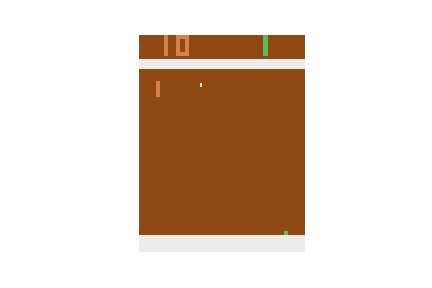
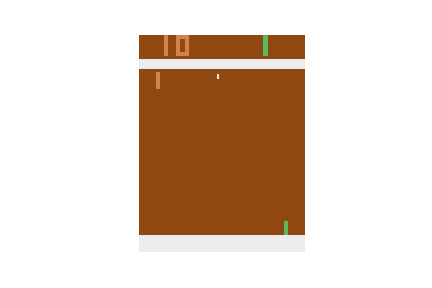
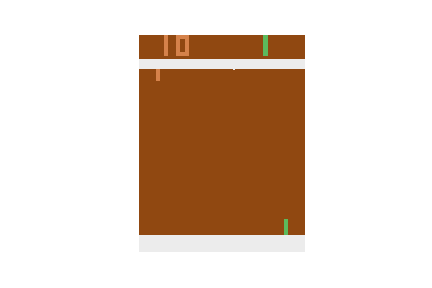
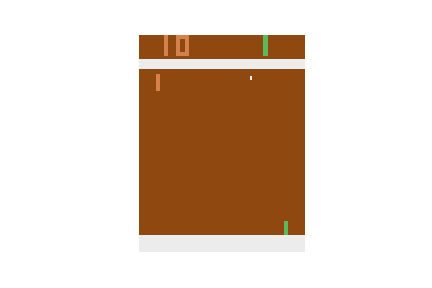
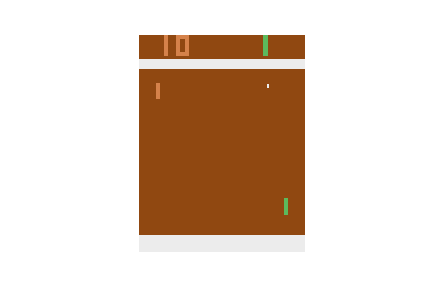
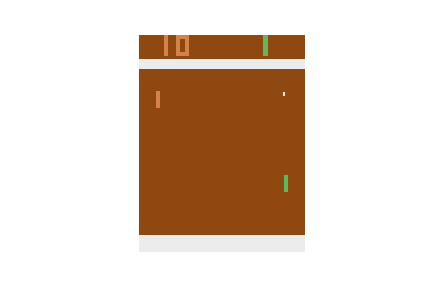
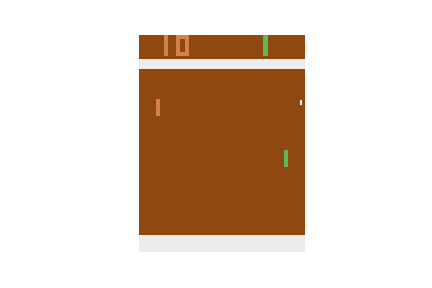
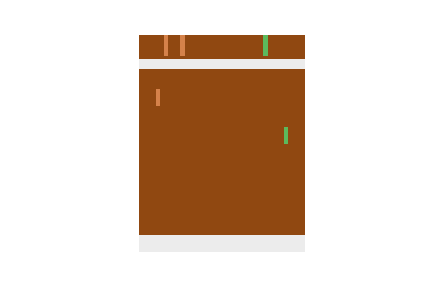
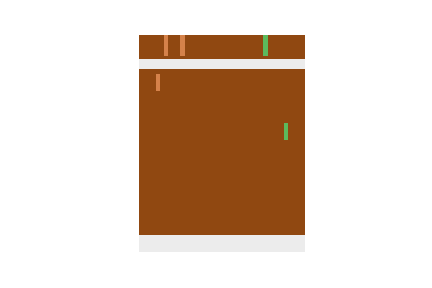
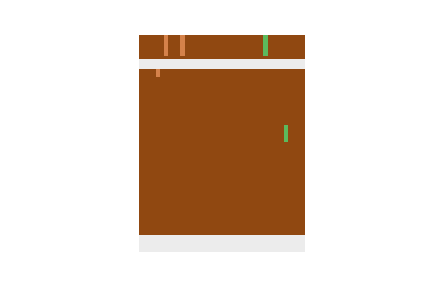
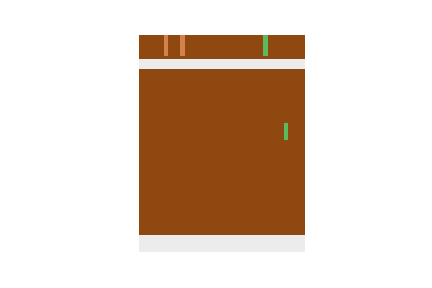
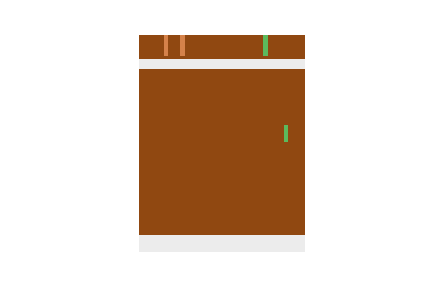
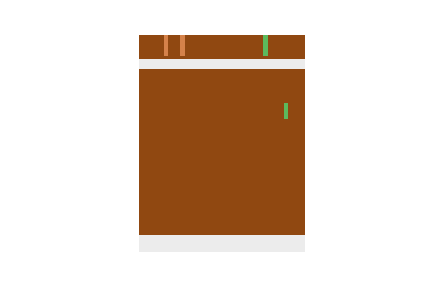
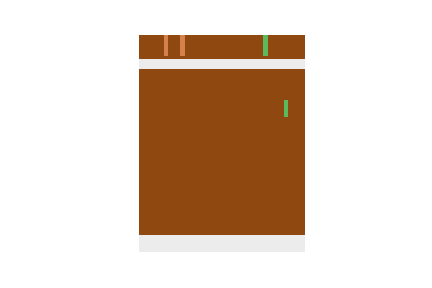
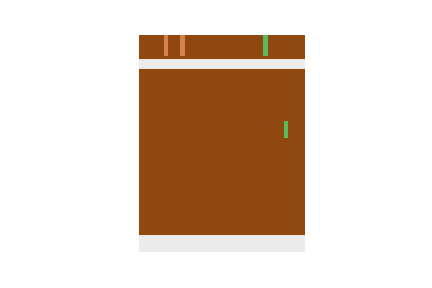
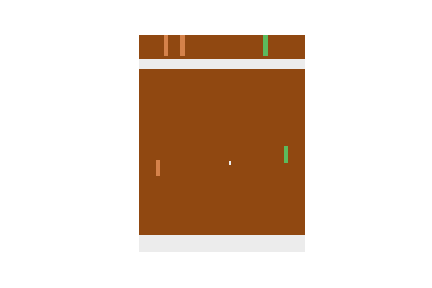
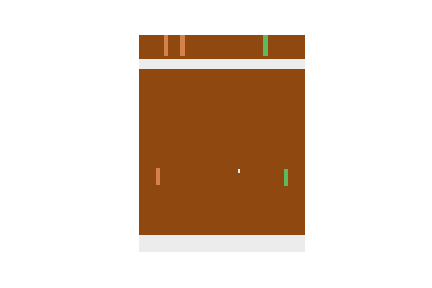
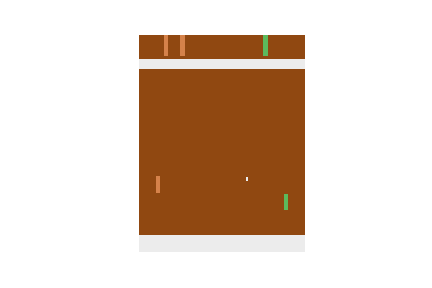
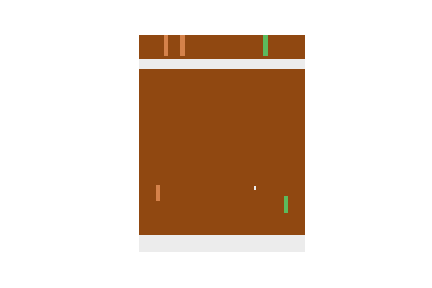
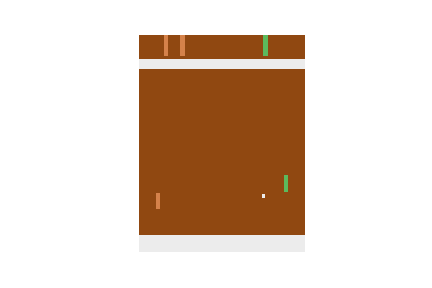
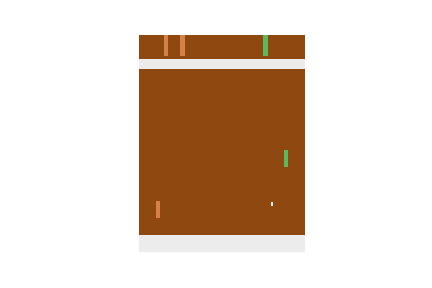
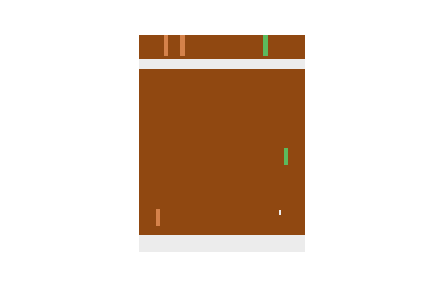
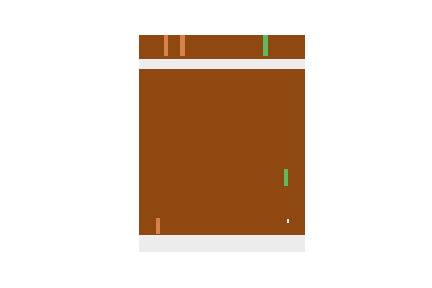
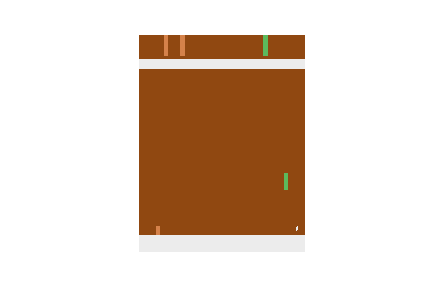
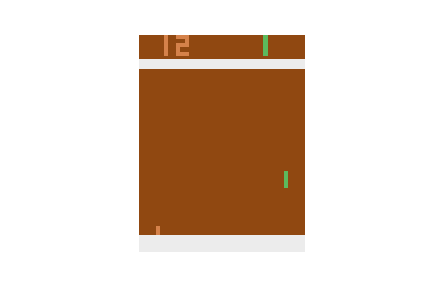
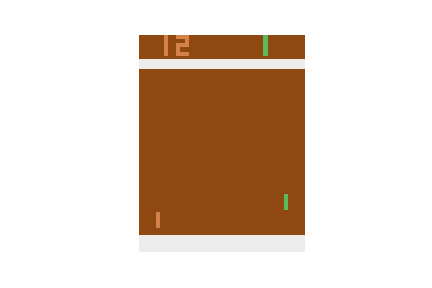
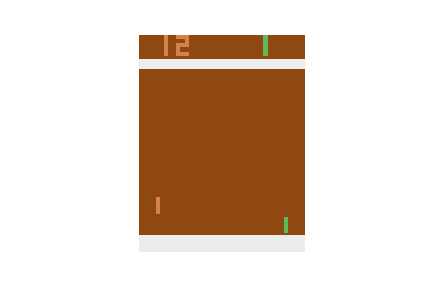
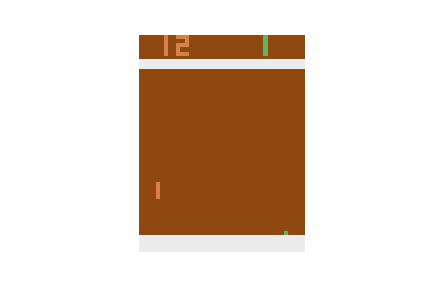
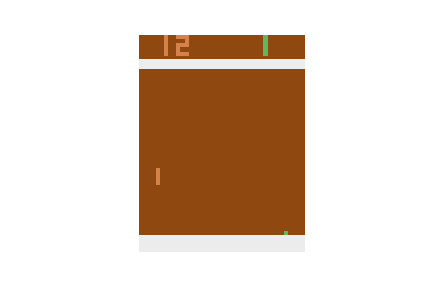
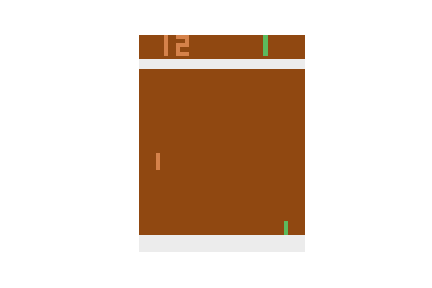
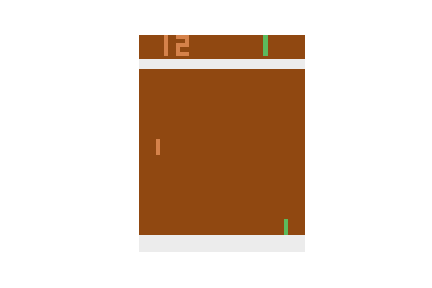
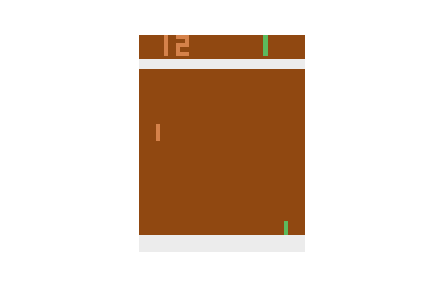
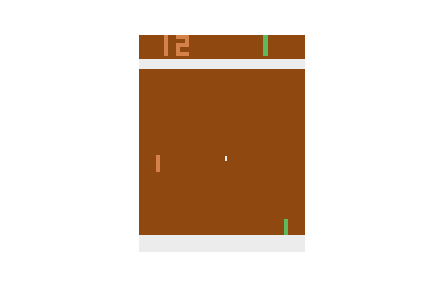
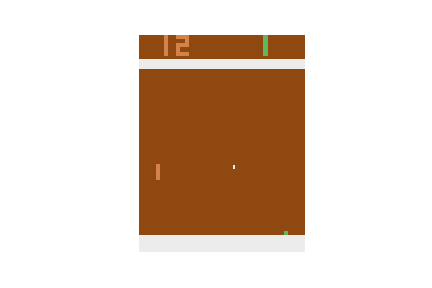
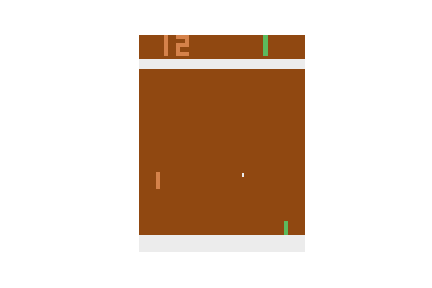
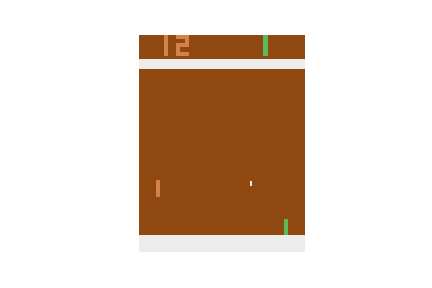
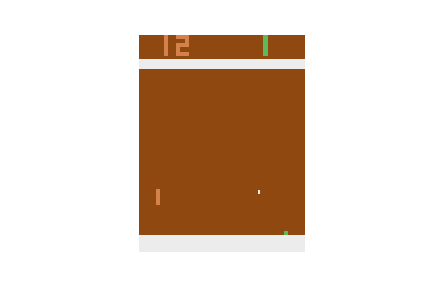
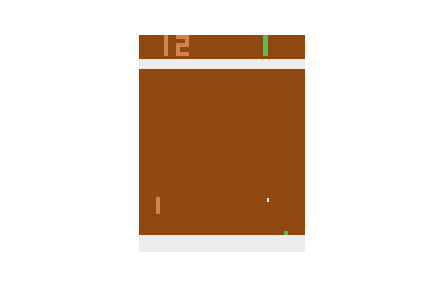
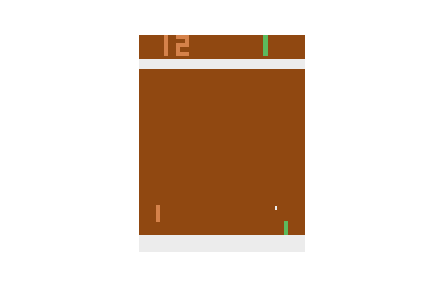
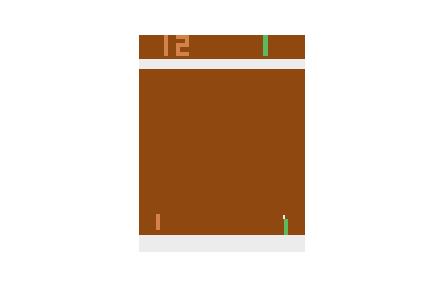
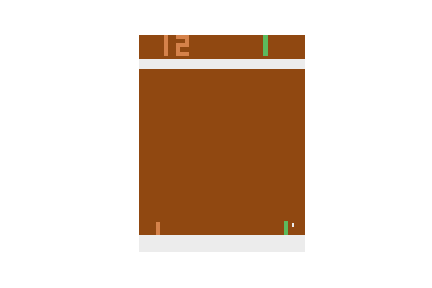
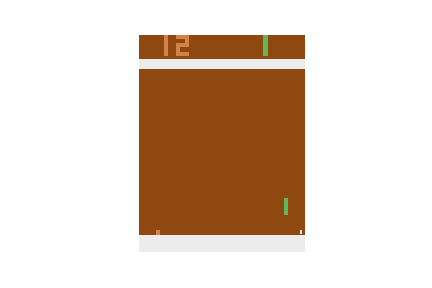
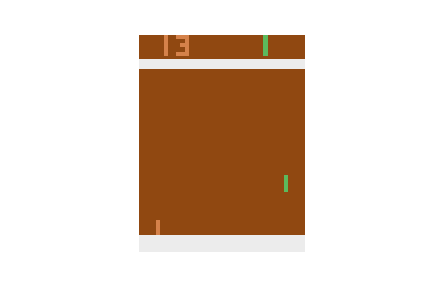
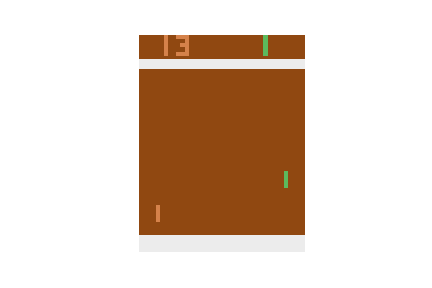
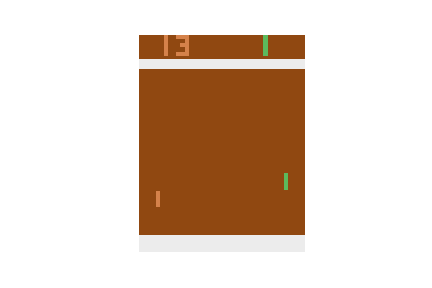
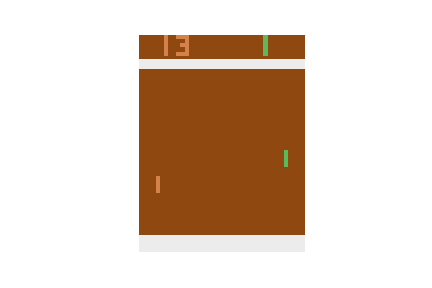
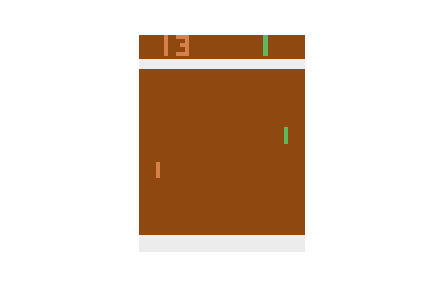
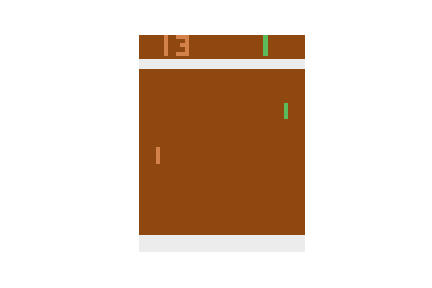
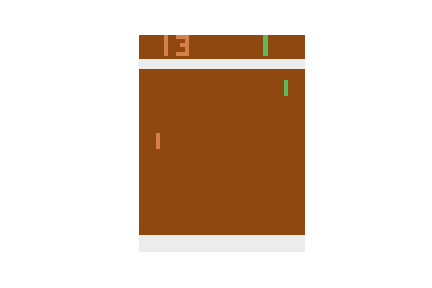
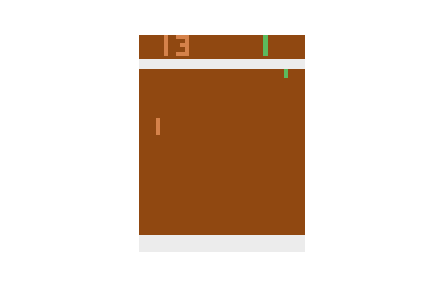
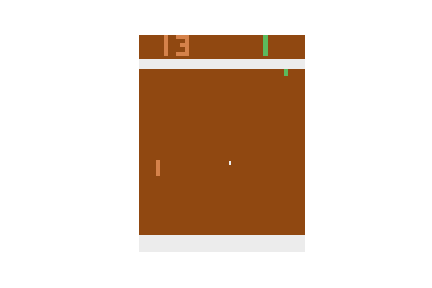
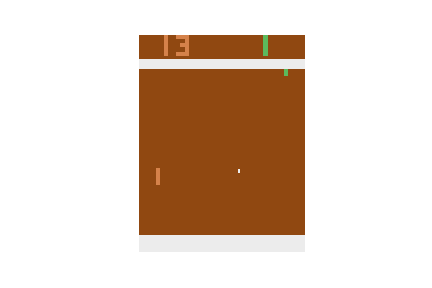
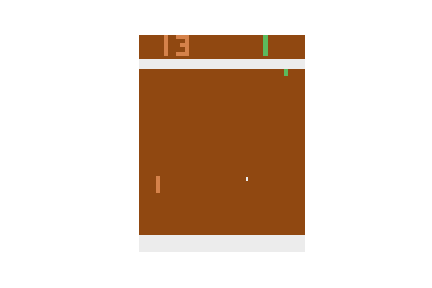
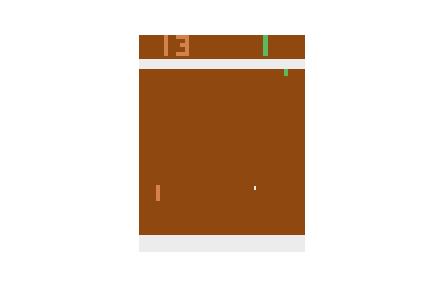
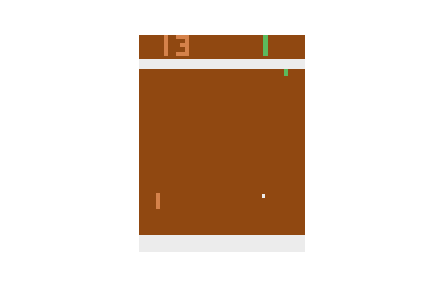
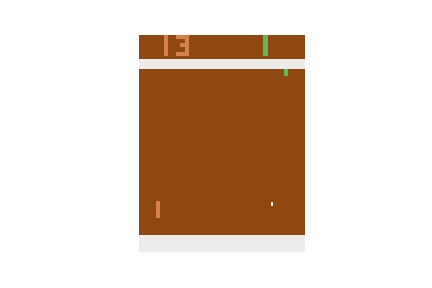
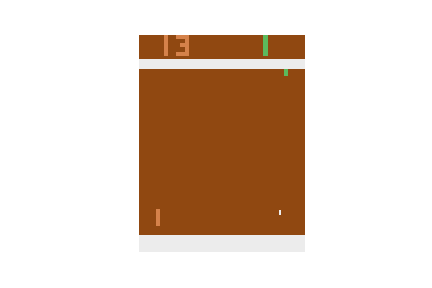
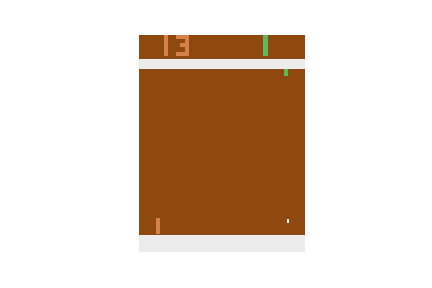
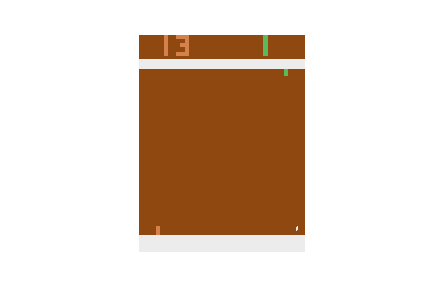
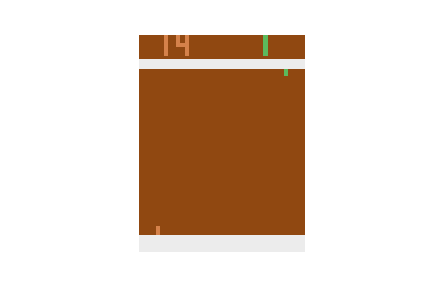
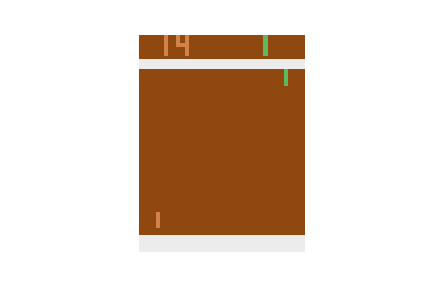
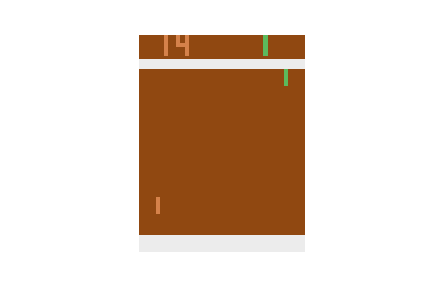
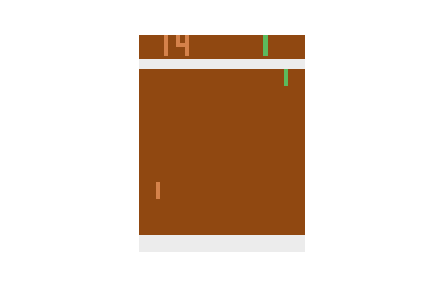
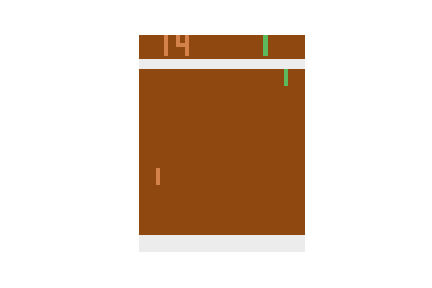
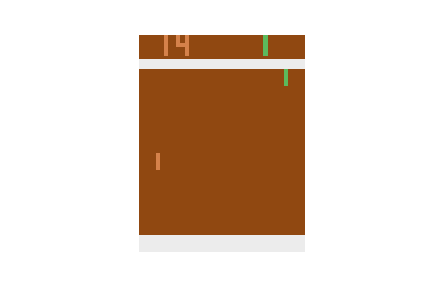
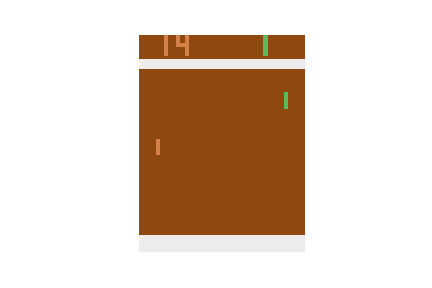
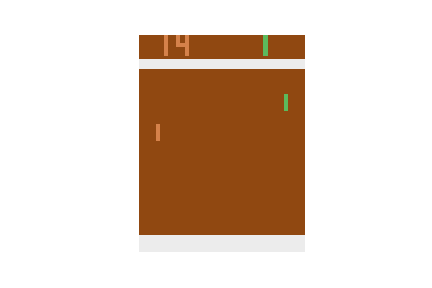
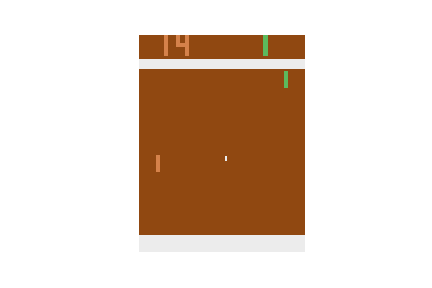
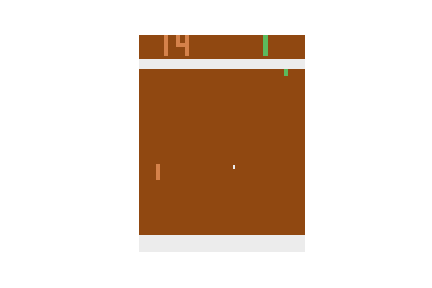
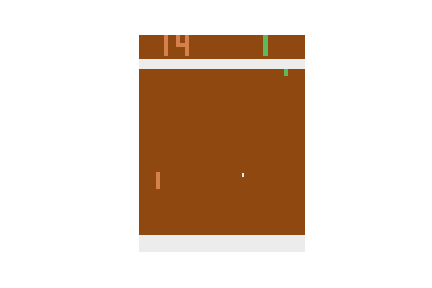
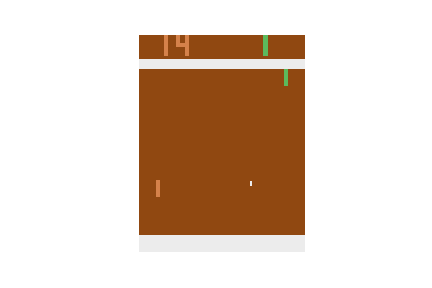
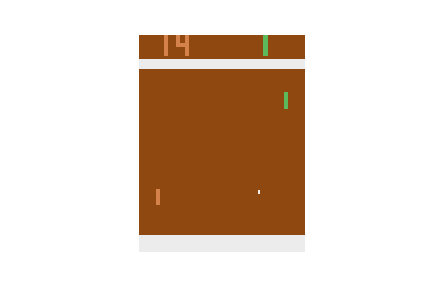
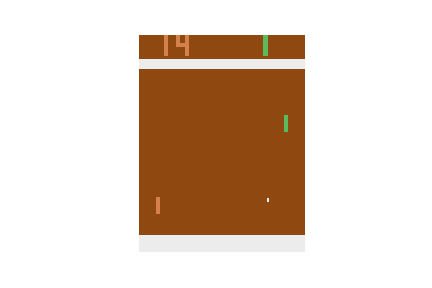
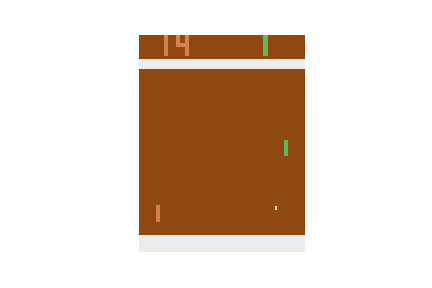
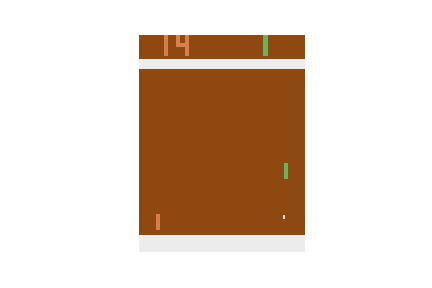
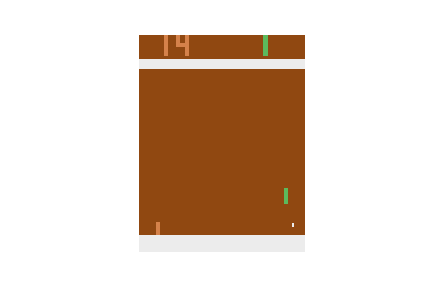
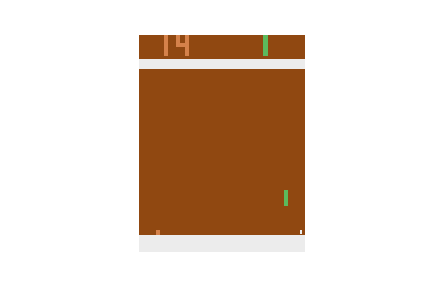
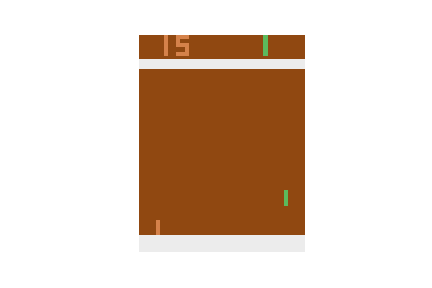
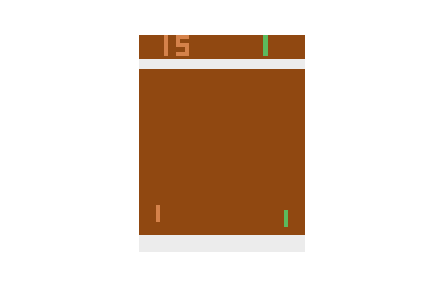
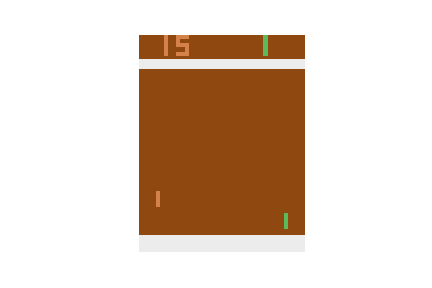
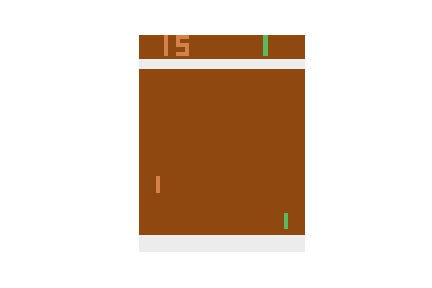
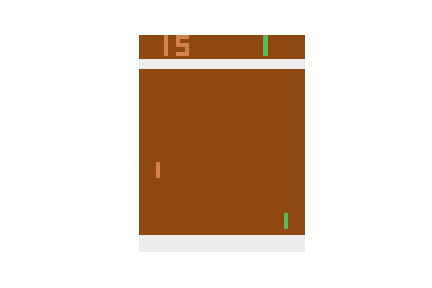
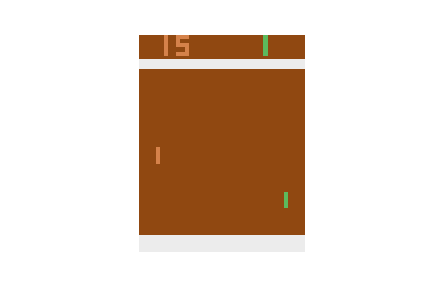
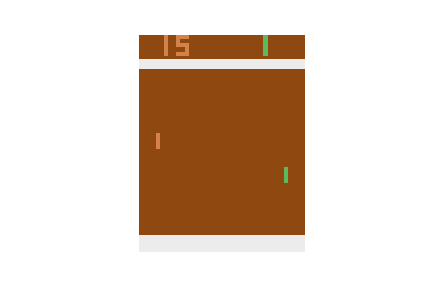
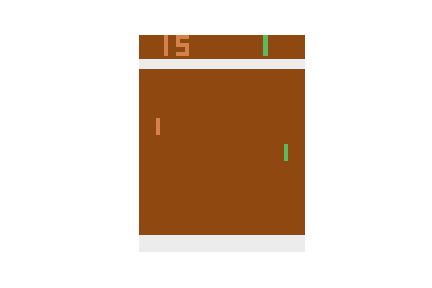
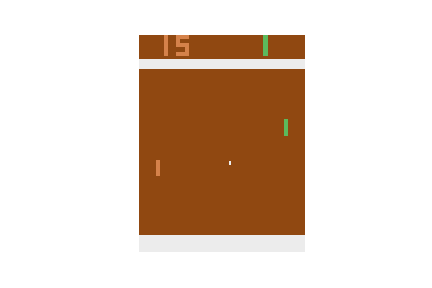
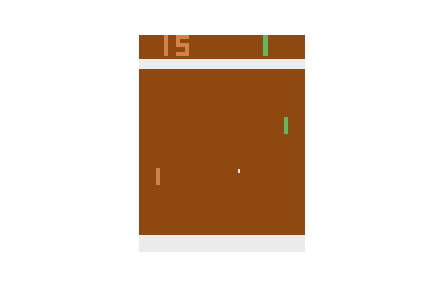
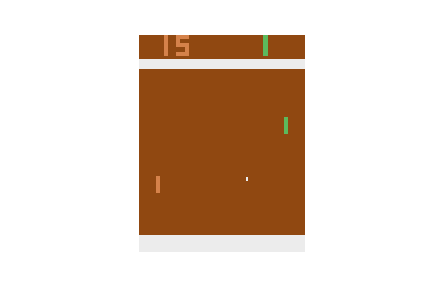
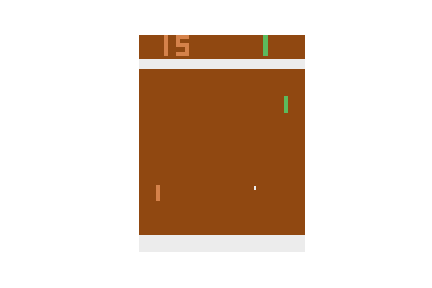
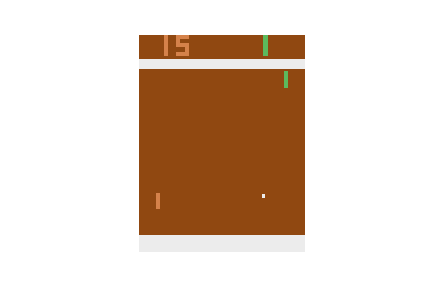
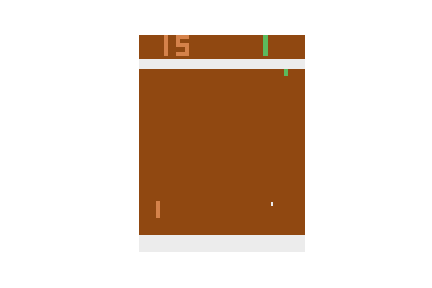
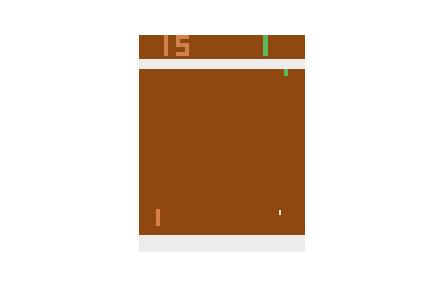
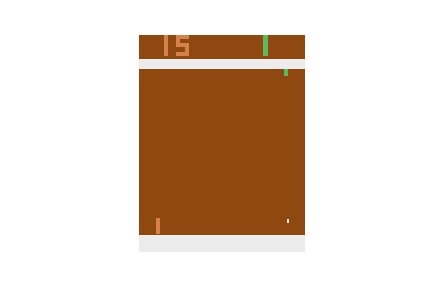
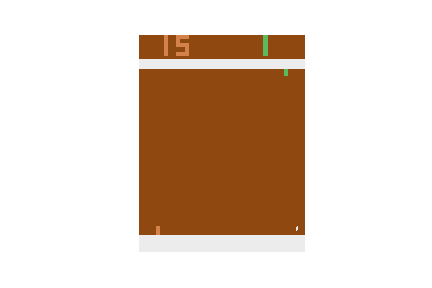
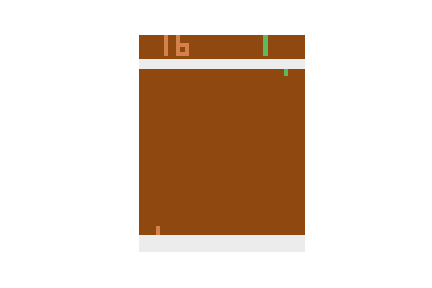
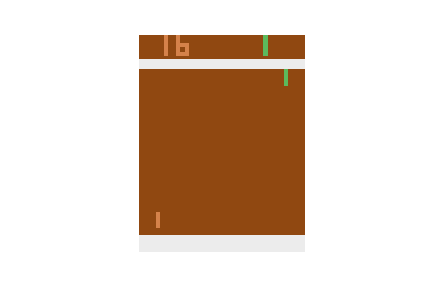
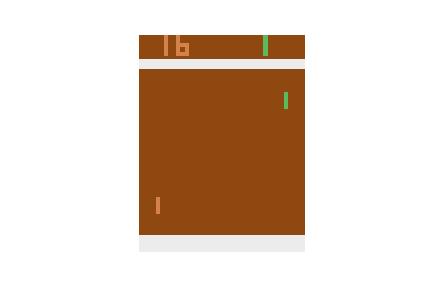
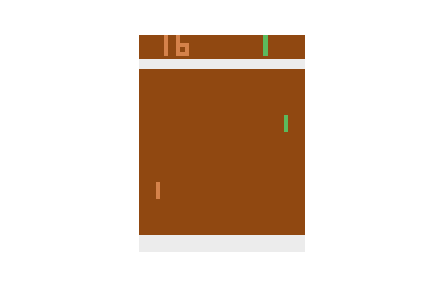
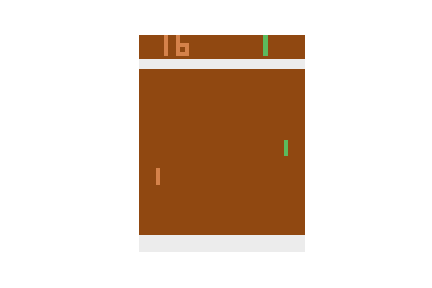
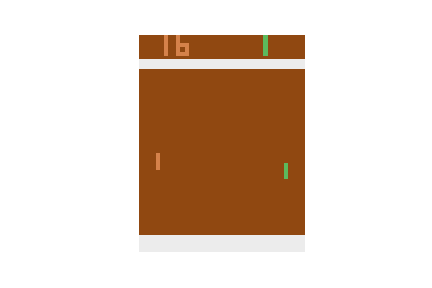
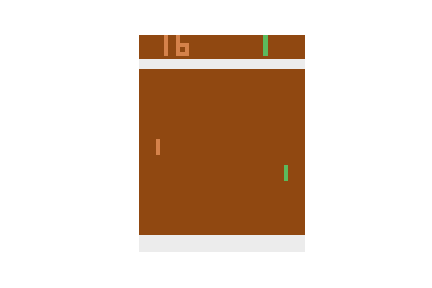
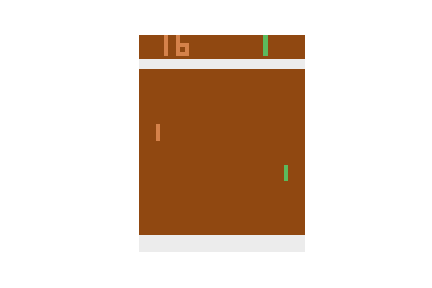
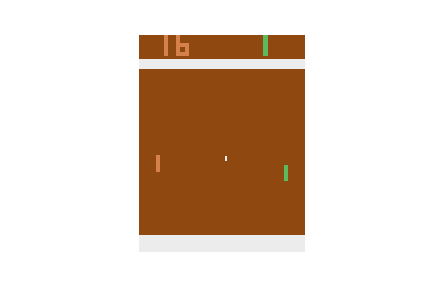
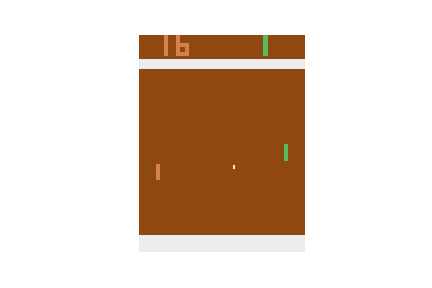
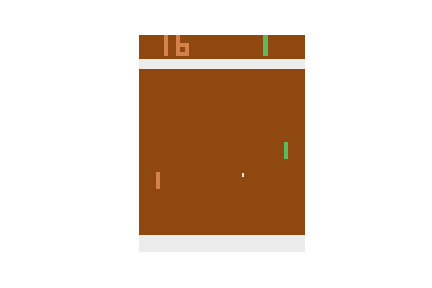
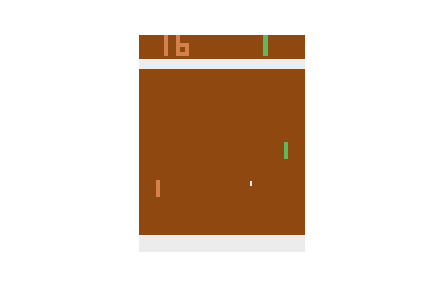
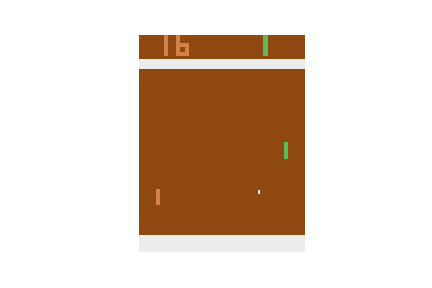
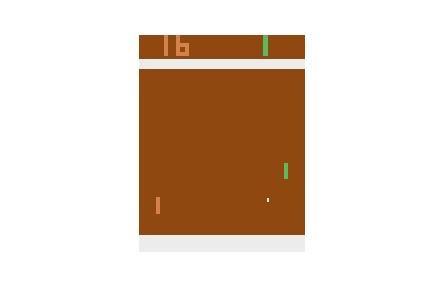
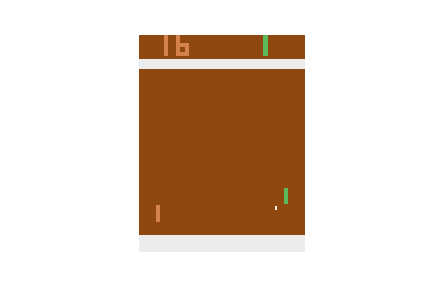
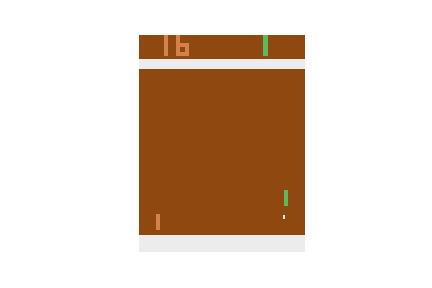
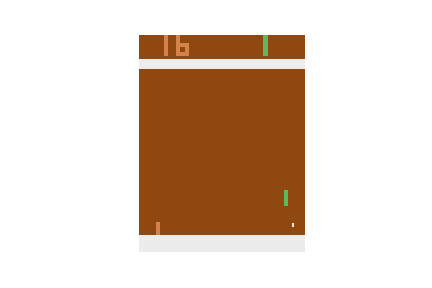
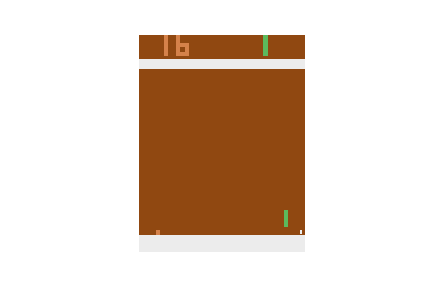
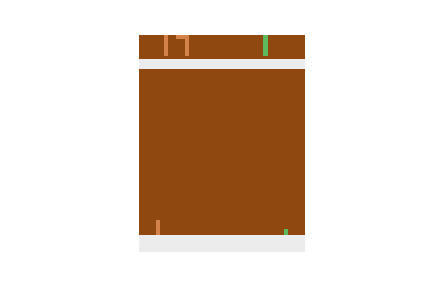
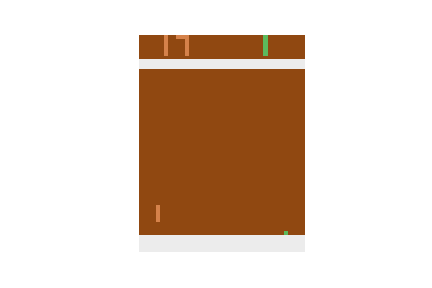
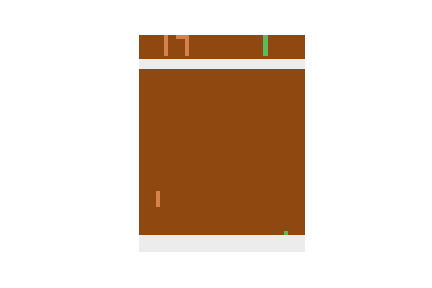
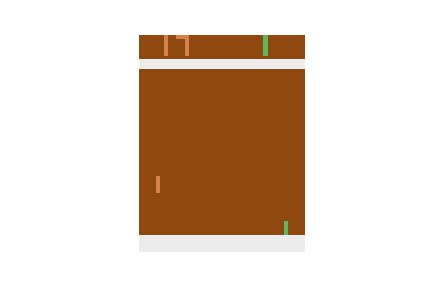
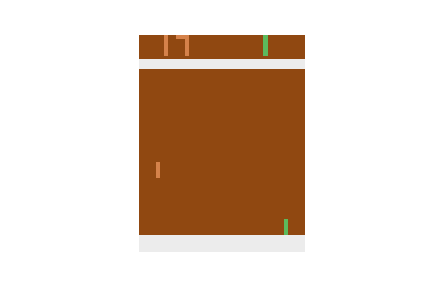
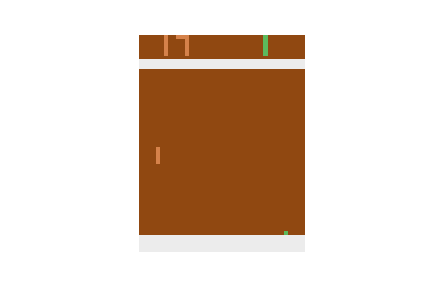
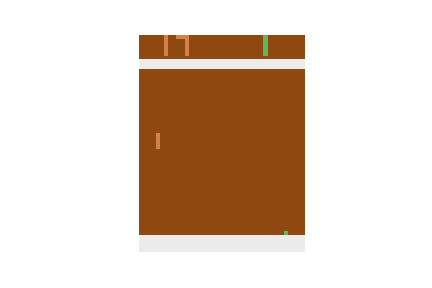
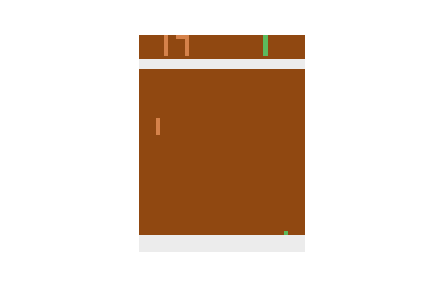
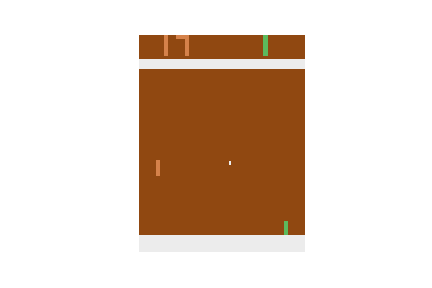
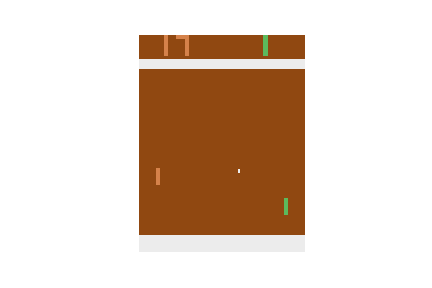
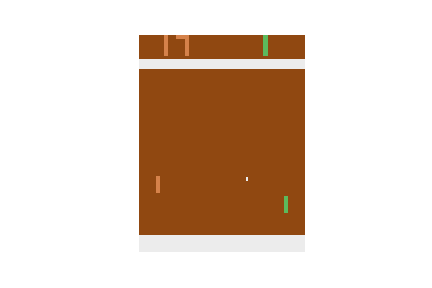
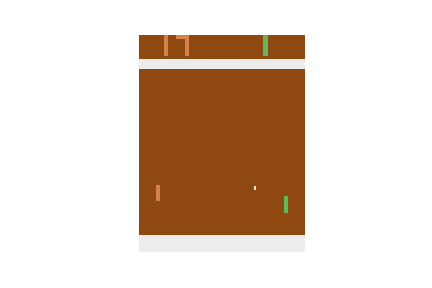
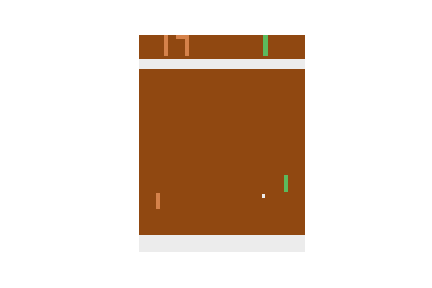
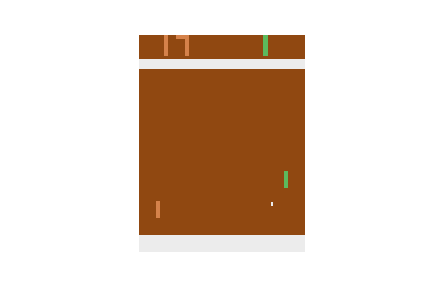
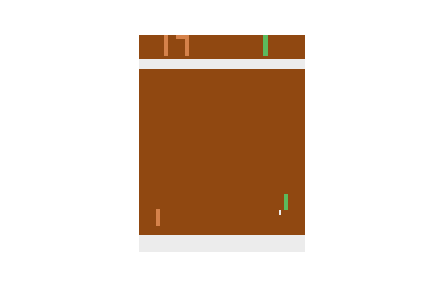
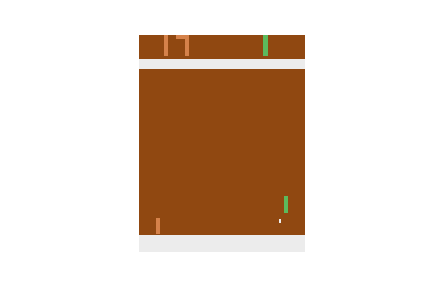
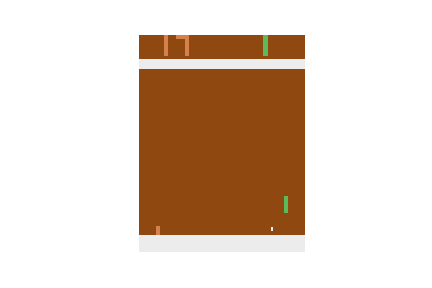
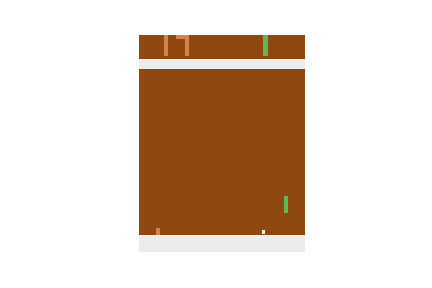
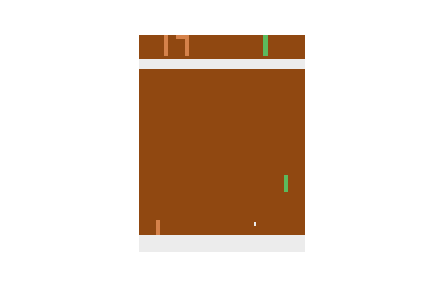
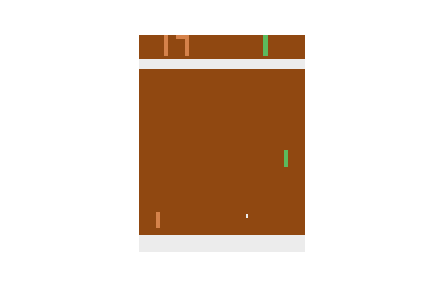
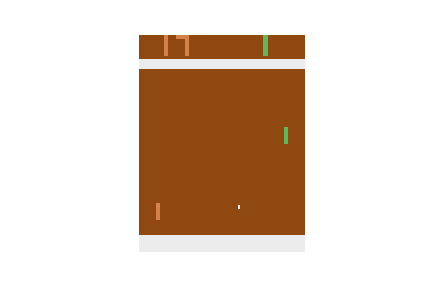
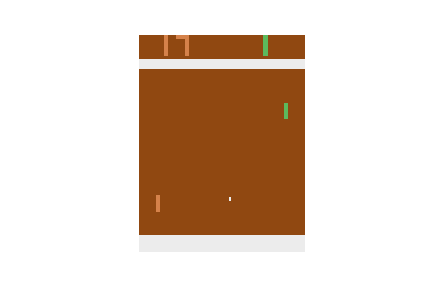
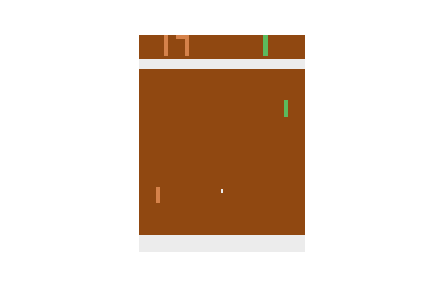
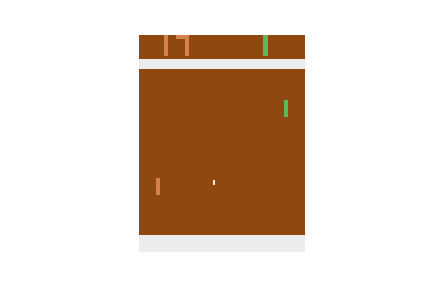
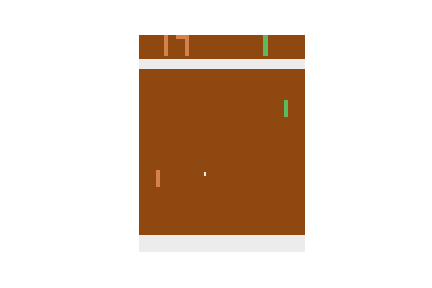
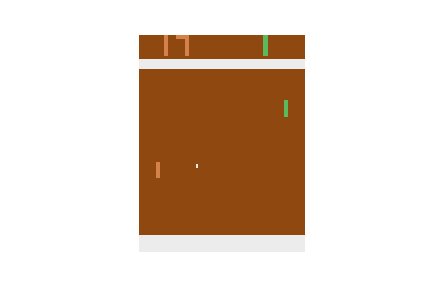
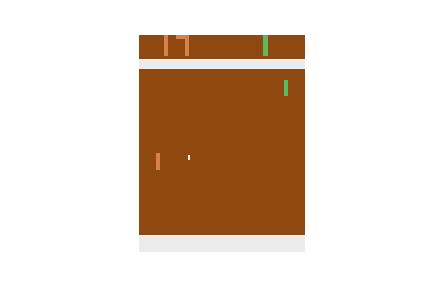
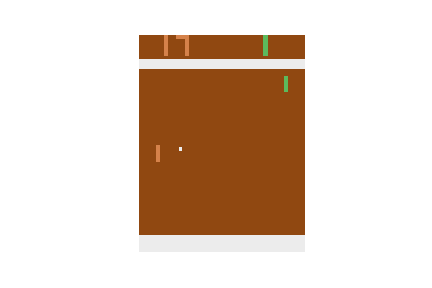
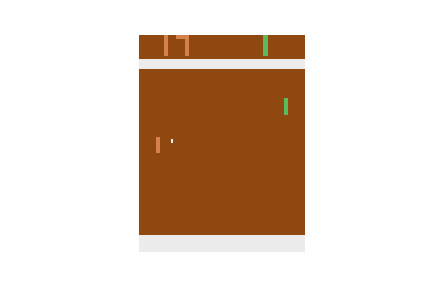
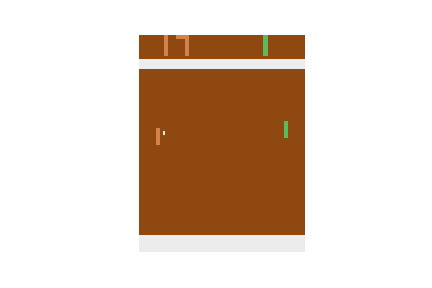
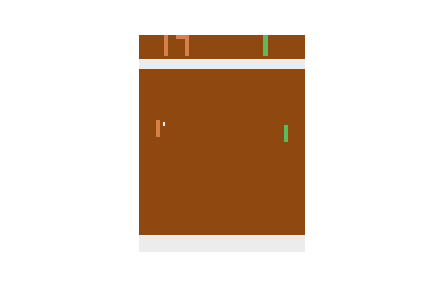
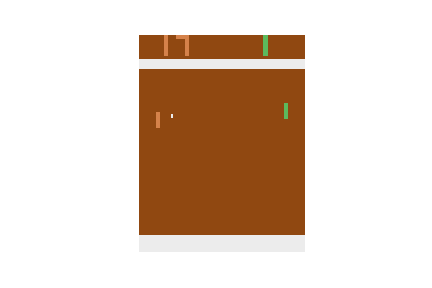
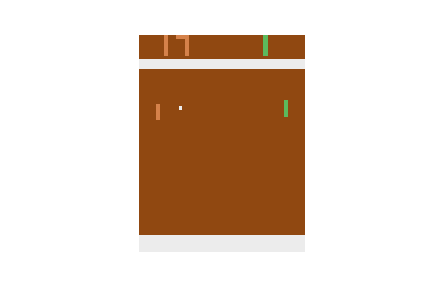
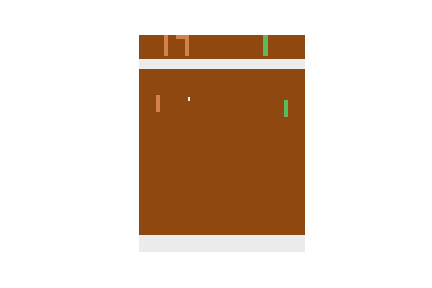
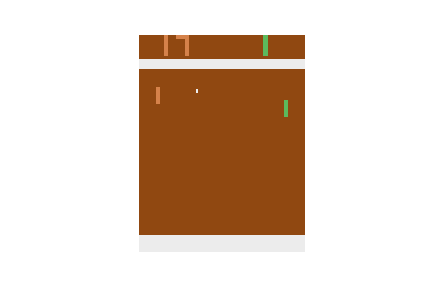
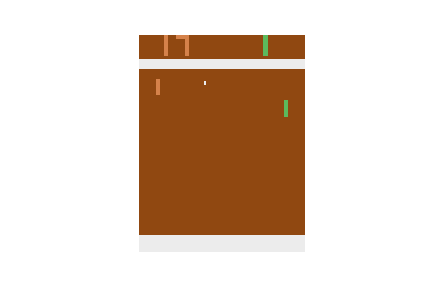
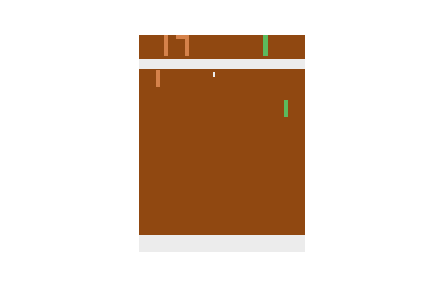
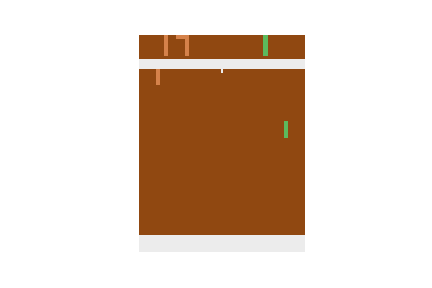
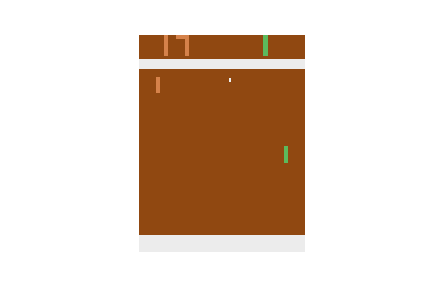
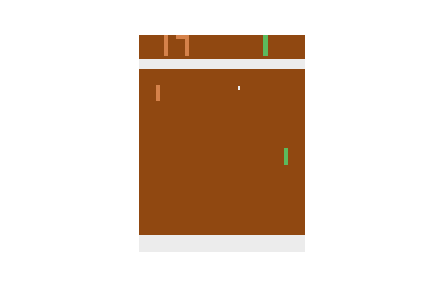
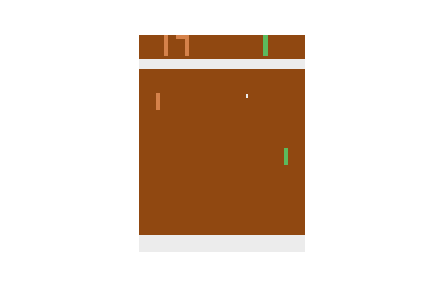
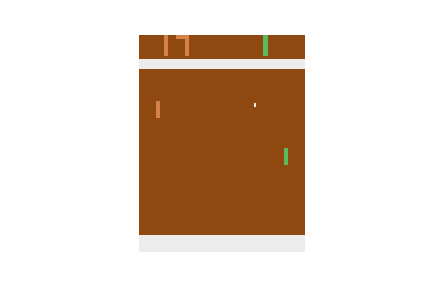
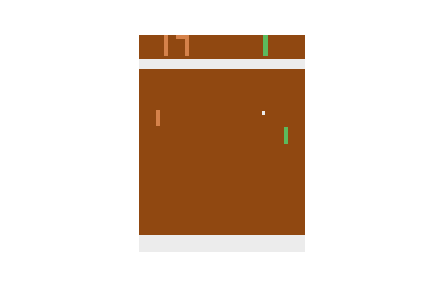
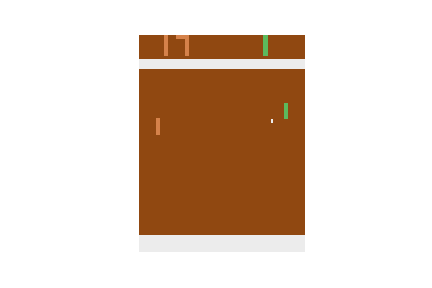
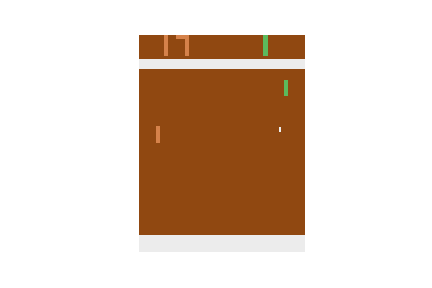
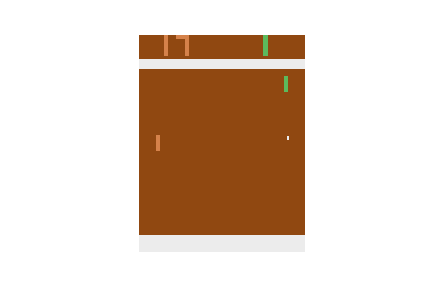
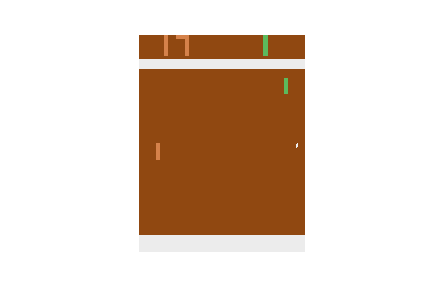
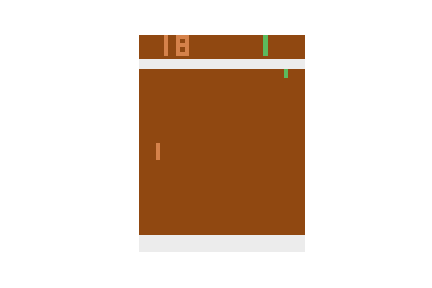
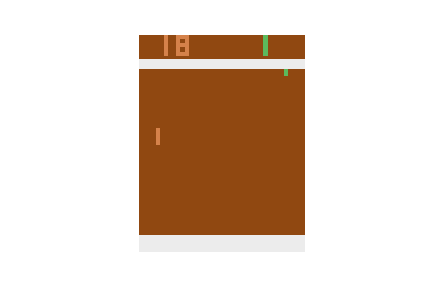
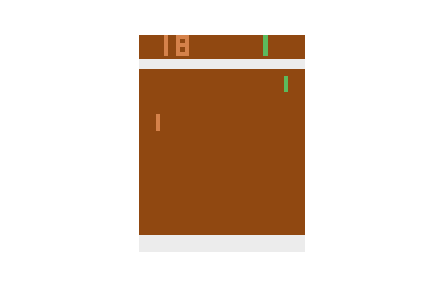
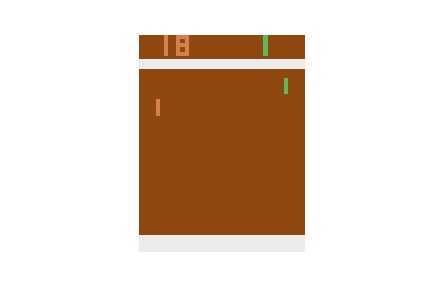
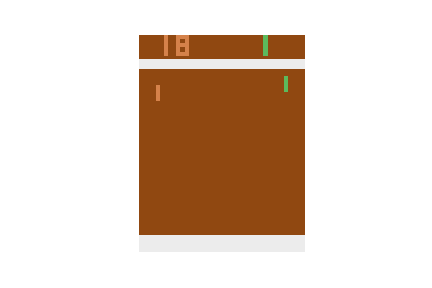
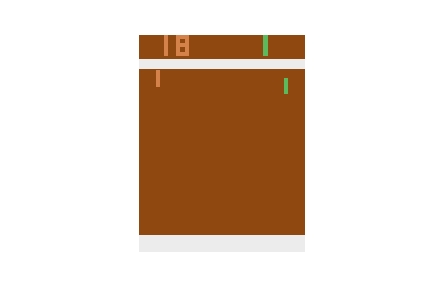
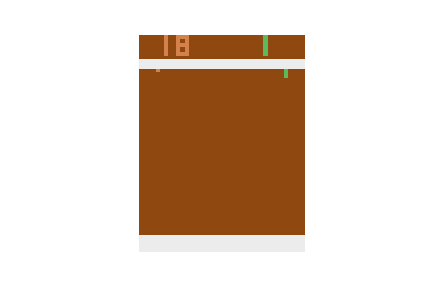
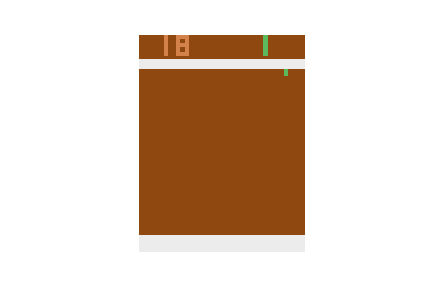
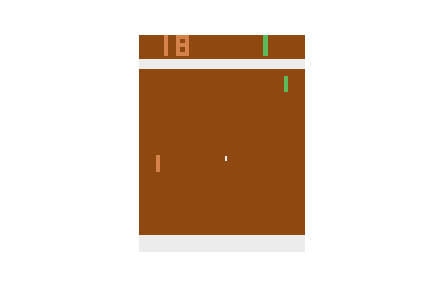
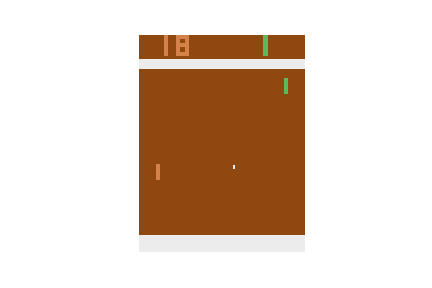
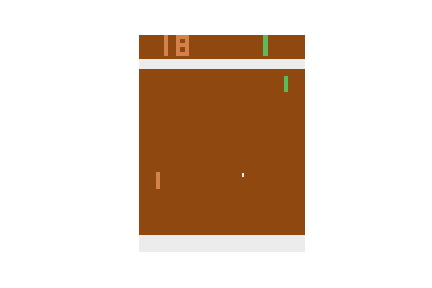
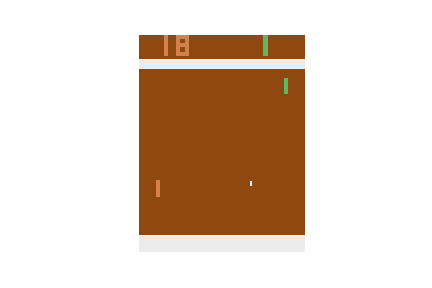
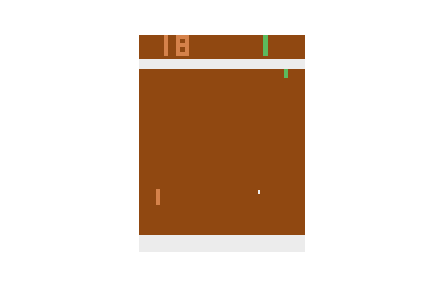
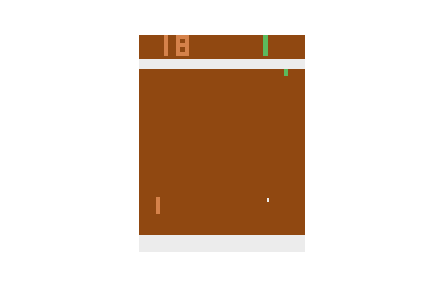
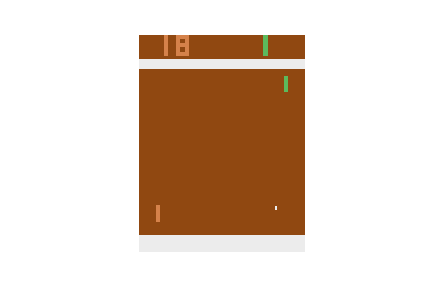
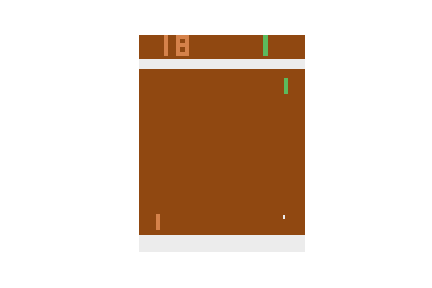
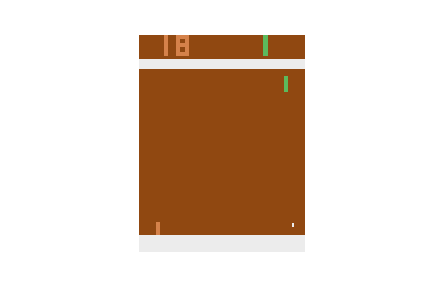
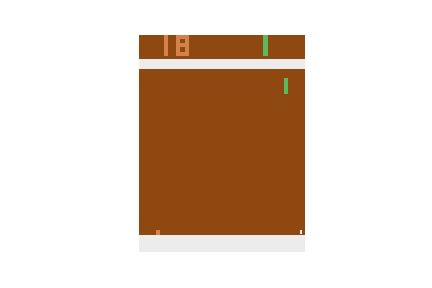
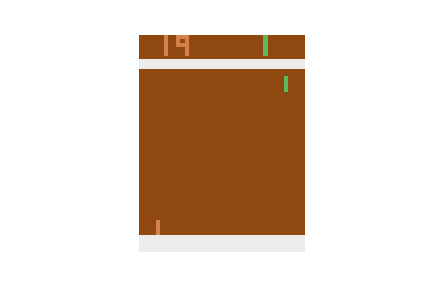
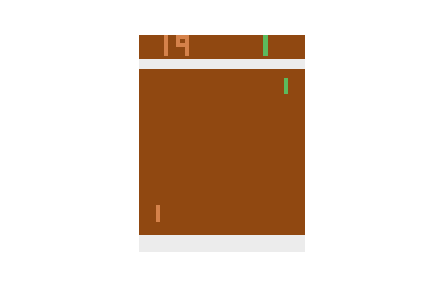
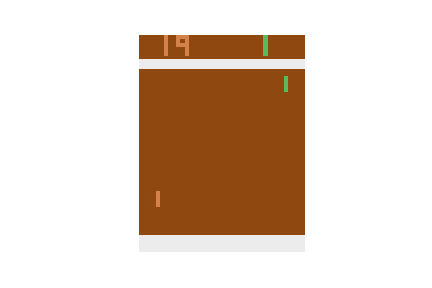
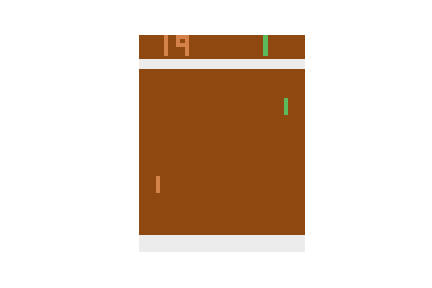
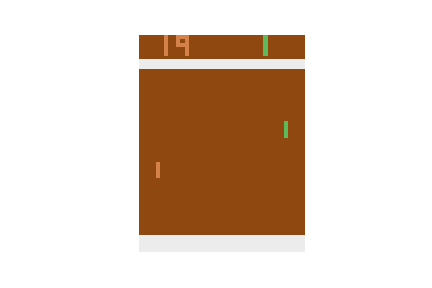
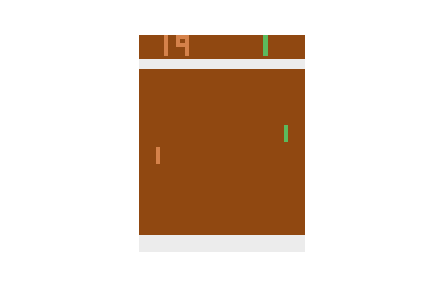
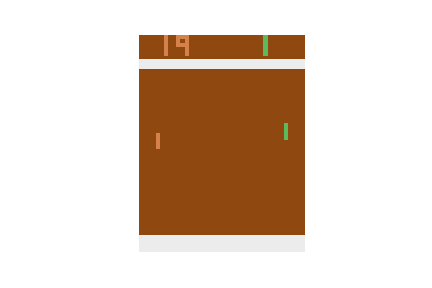
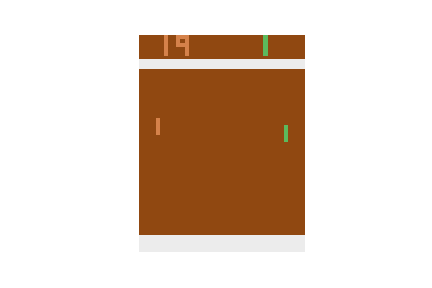
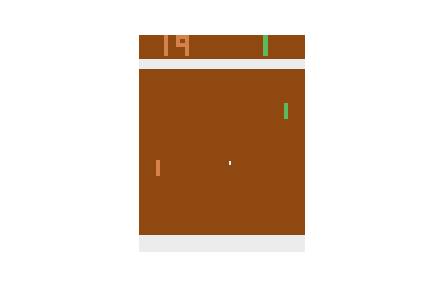
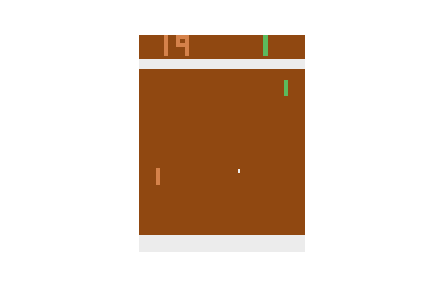
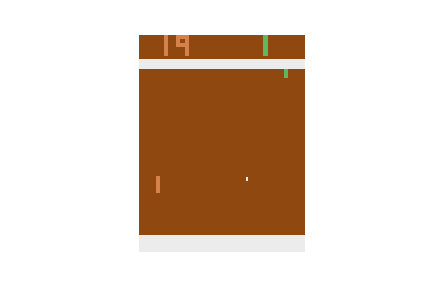
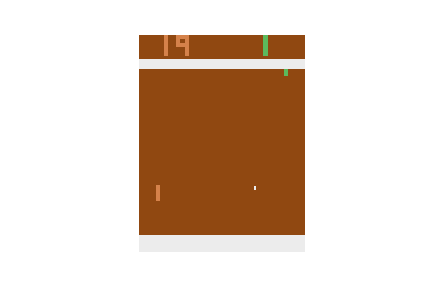
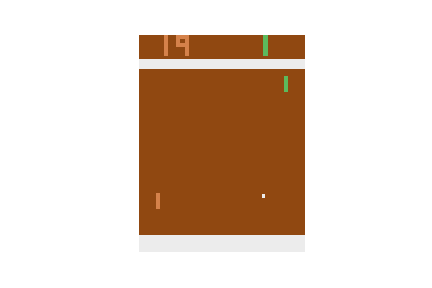
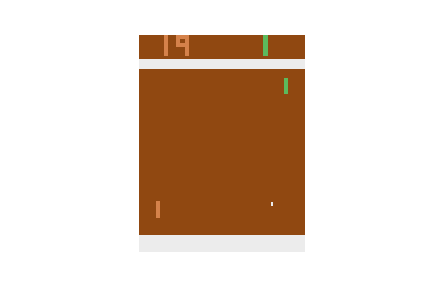
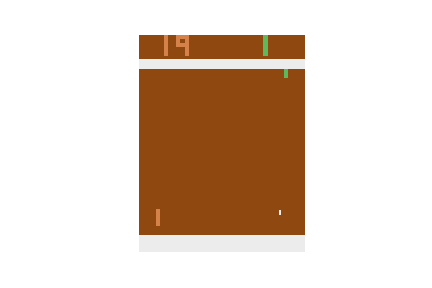
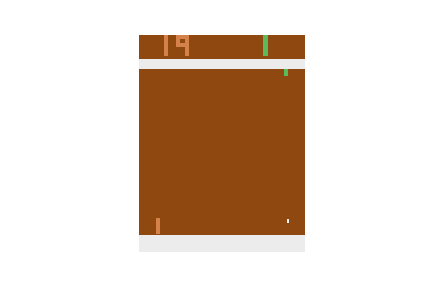
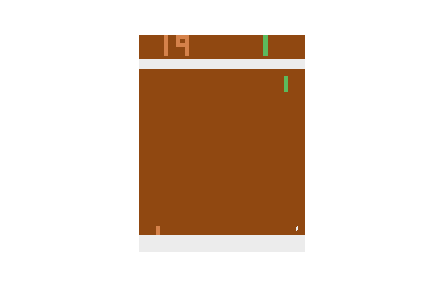
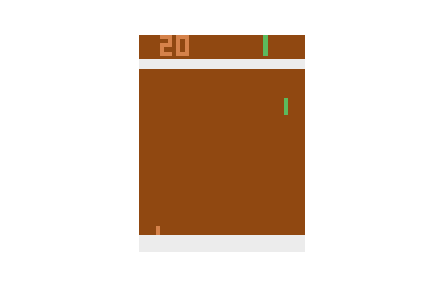
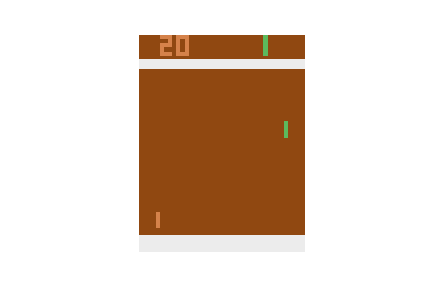
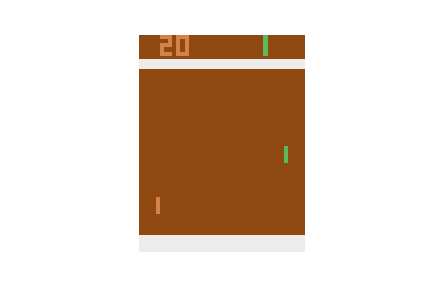
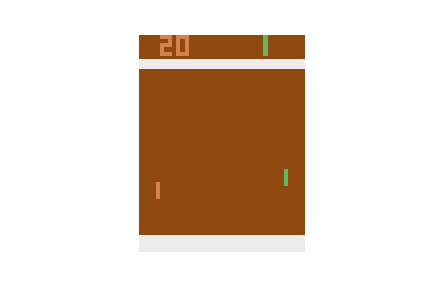
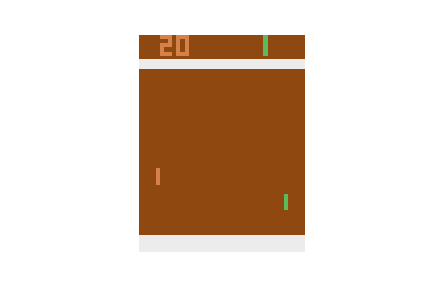
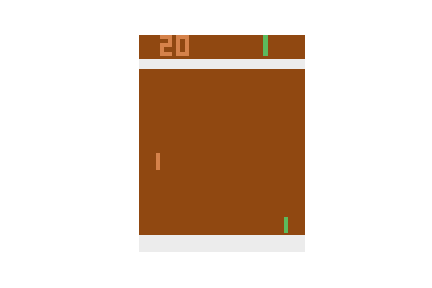
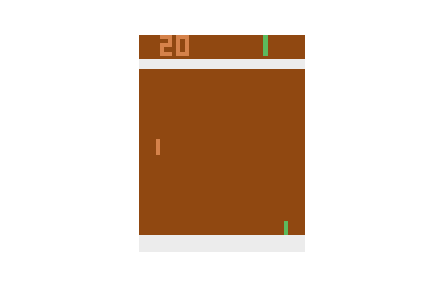
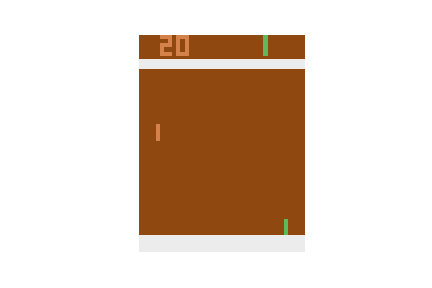
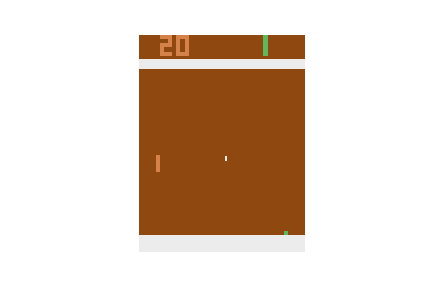
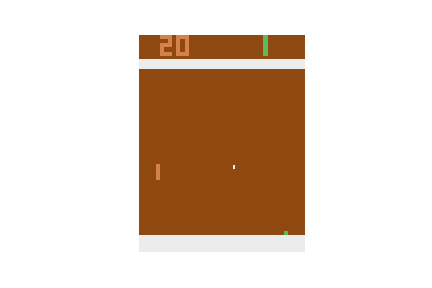
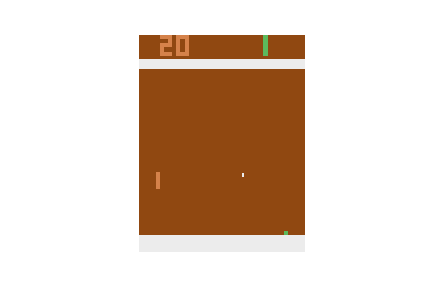
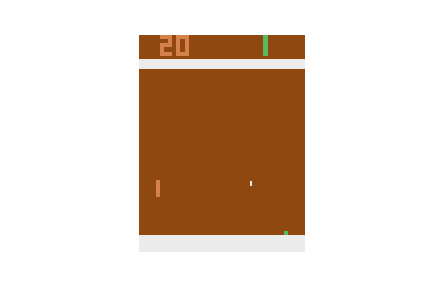
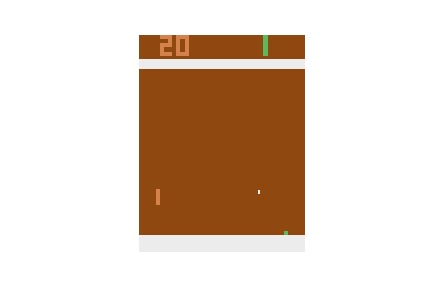
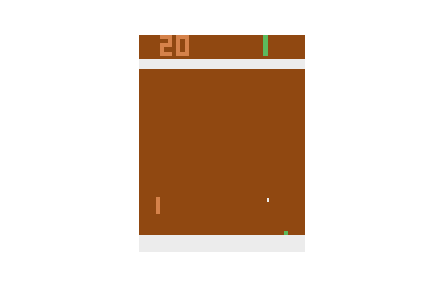
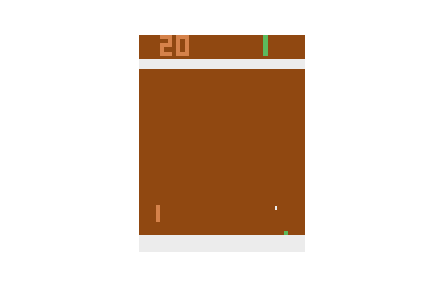
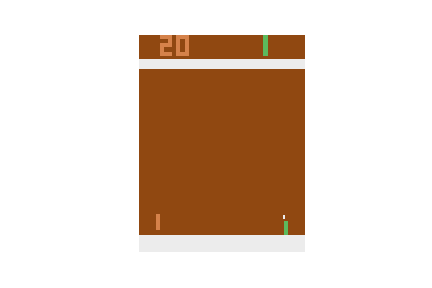
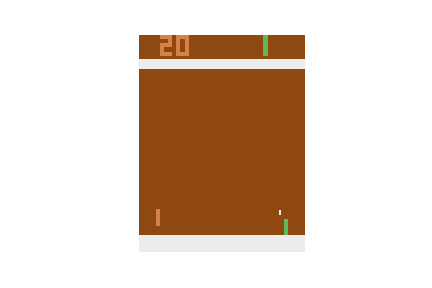
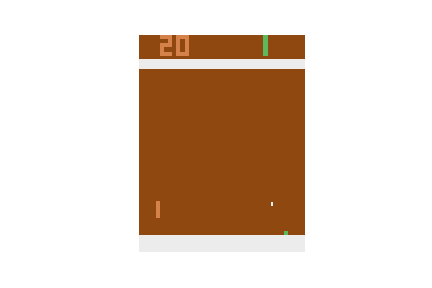
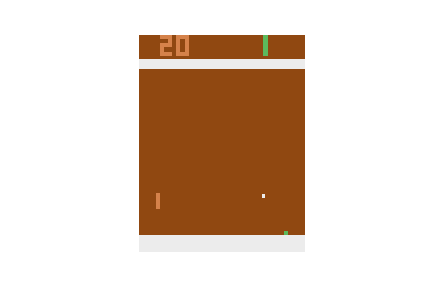
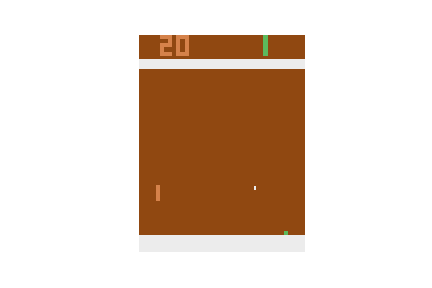
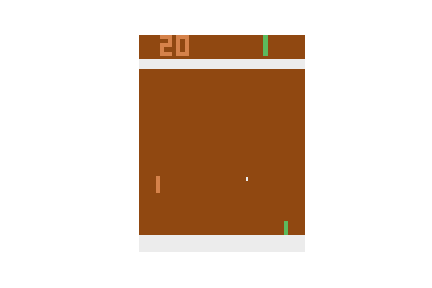
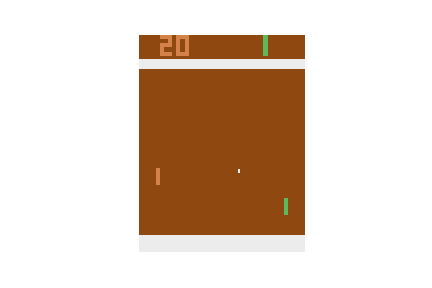
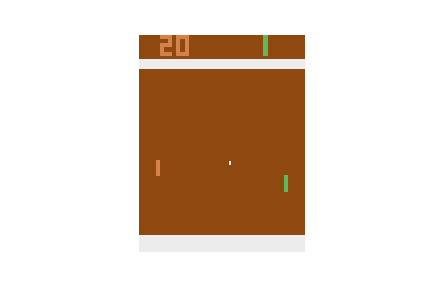
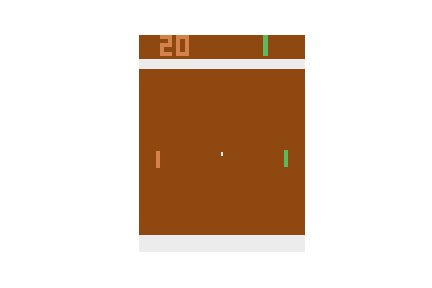
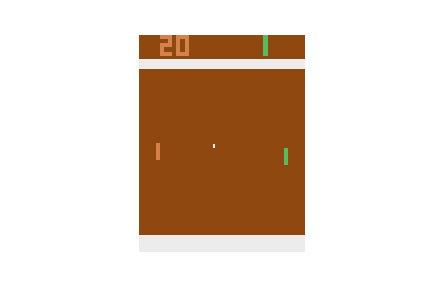
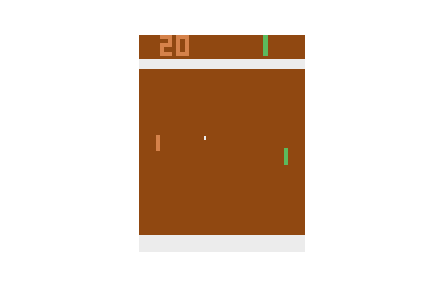
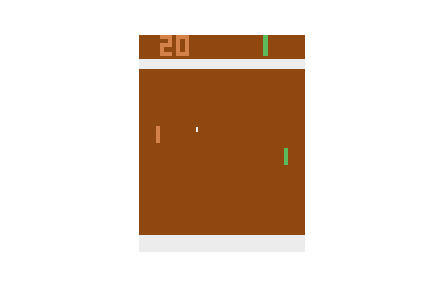
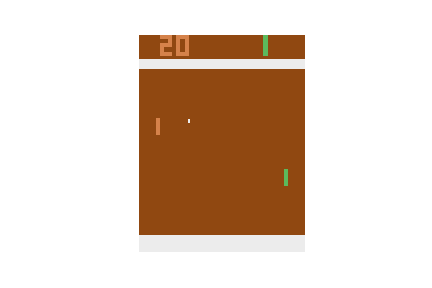
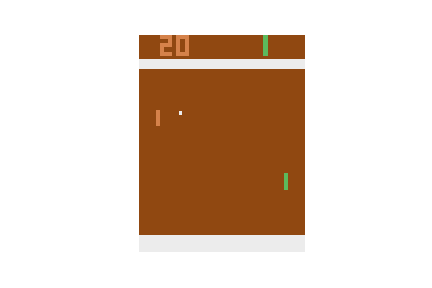
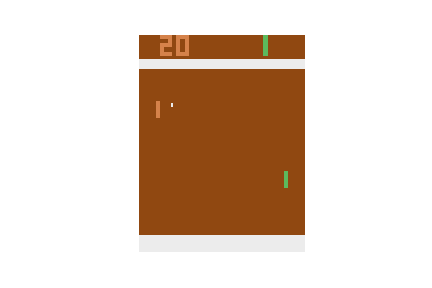
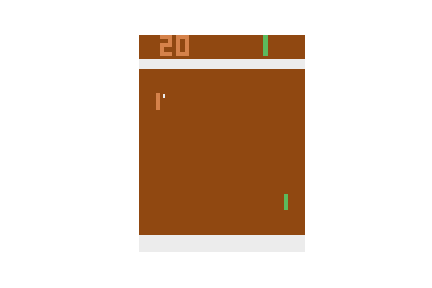
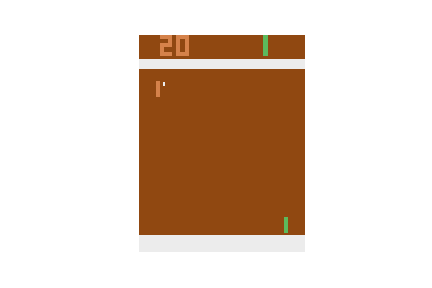
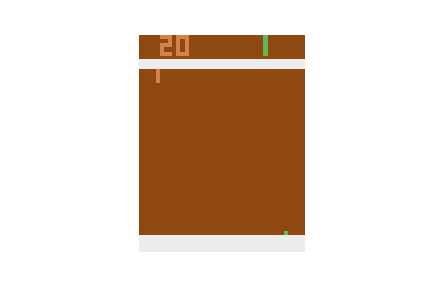
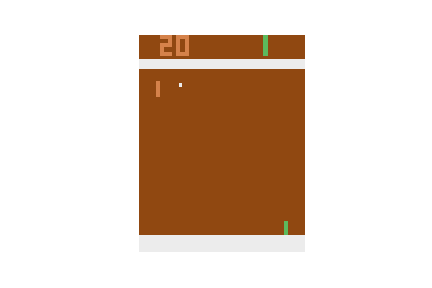
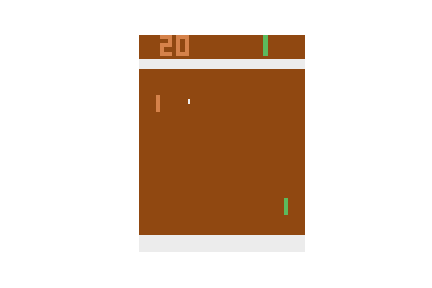
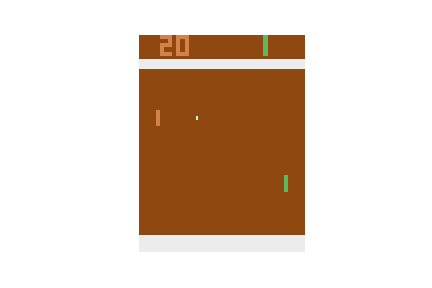
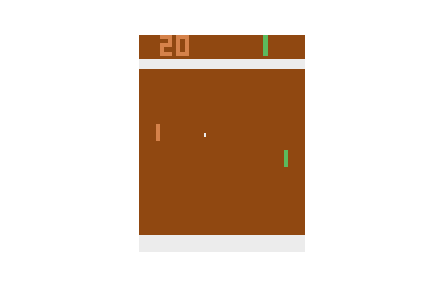
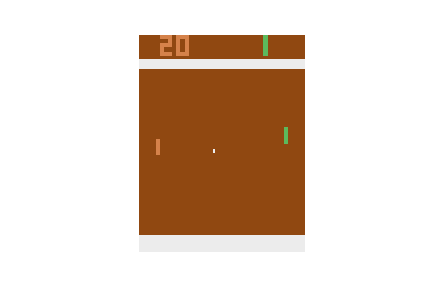
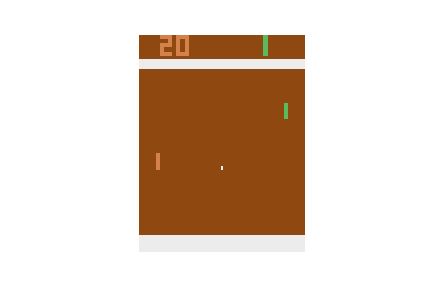
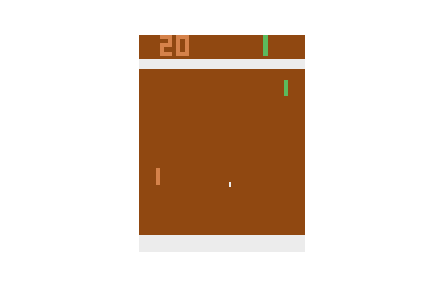
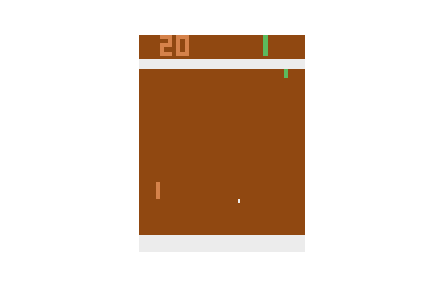
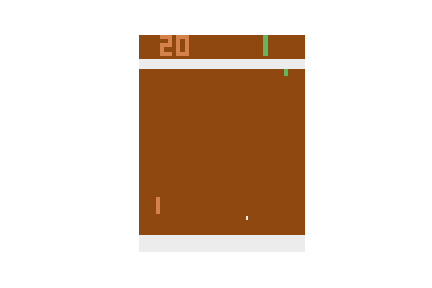
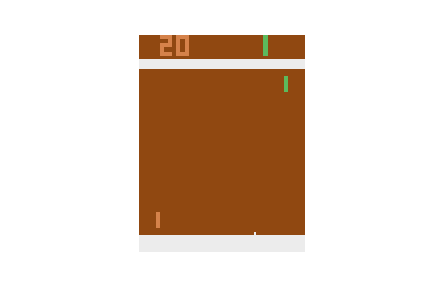
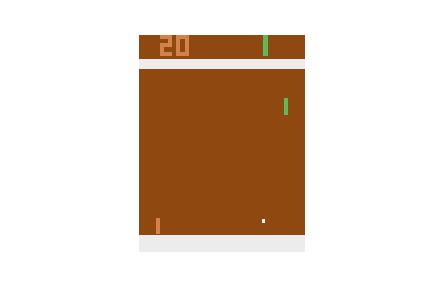
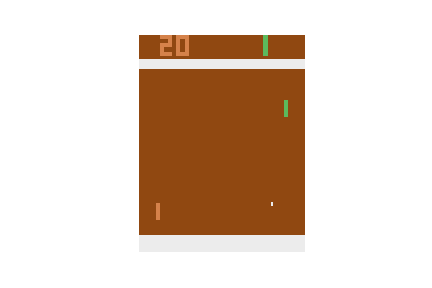
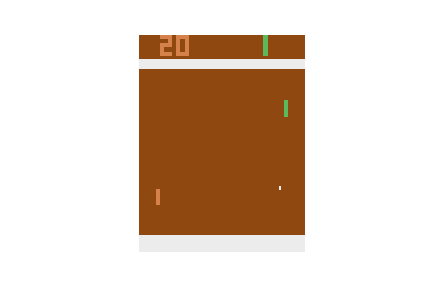
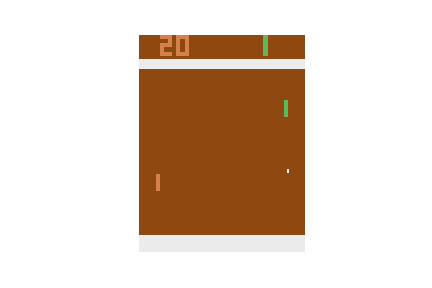
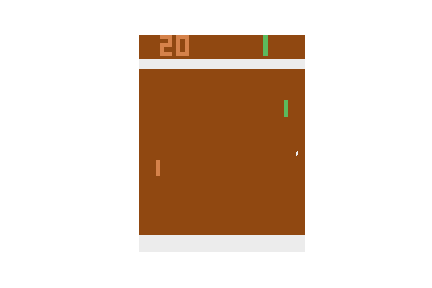
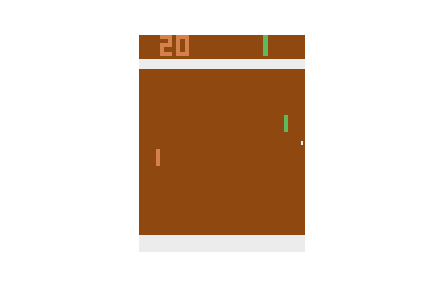

In [90]:
pong_utils.play(env, policy, time=2000)

# Results
Plot evolutions of the entropy, the rewards, the averaged rewards and the loss terms

In [53]:
with open("entropies_5000.txt", "rb") as fp:
    entropies = pickle.load(fp)
    print(np.mean(entropies))
    print(len(entropies))

with open("rewards_5000.txt", "rb") as fp:
    mean_rewards = pickle.load(fp)
    print(np.mean(mean_rewards))
    print(len(mean_rewards))

with open("losses_5000.txt", "rb") as fp:
    losses = pickle.load(fp)
    print(np.mean(losses))
    print(len(losses))

0.1345023
11200
1.5503571428571428
2800
-0.00051193830191323
11200


In [54]:
# compute statistics
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N
window_size = 100
threshold = 2

avg_mean_rewards = running_mean(mean_rewards, window_size)
success_index = next(x[0] for x in enumerate(
    avg_mean_rewards) if x[1] > threshold)
title = "Solved in {} episodes (={}*{} updates) -- for window_size = {} and threshold = {}".format(
    success_index, SGD_epoch, success_index, window_size, threshold)
print(title)

Solved in 780 episodes (=4*780 updates) -- for window_size = 100 and threshold = 2


In [55]:
# expand mean_rewards from (for each episode) to (for each SGD_epoch)
mean_rewards = [[e]*SGD_epoch for e in mean_rewards]
mean_rewards = [item for sublist in mean_rewards for item in sublist]
# padding for plotting
avg_mean_rewards = running_mean(mean_rewards, window_size)
avg_mean_rewards = list(avg_mean_rewards)
avg_mean_rewards = [avg_mean_rewards[0]] * (len(entropies) - len(avg_mean_rewards)) + avg_mean_rewards

In [56]:
print(len(losses)+1)
print(len(mean_rewards)+1)
print(len(avg_mean_rewards)+1)
print(len(entropies)+1)

11201
11201
11201
11201


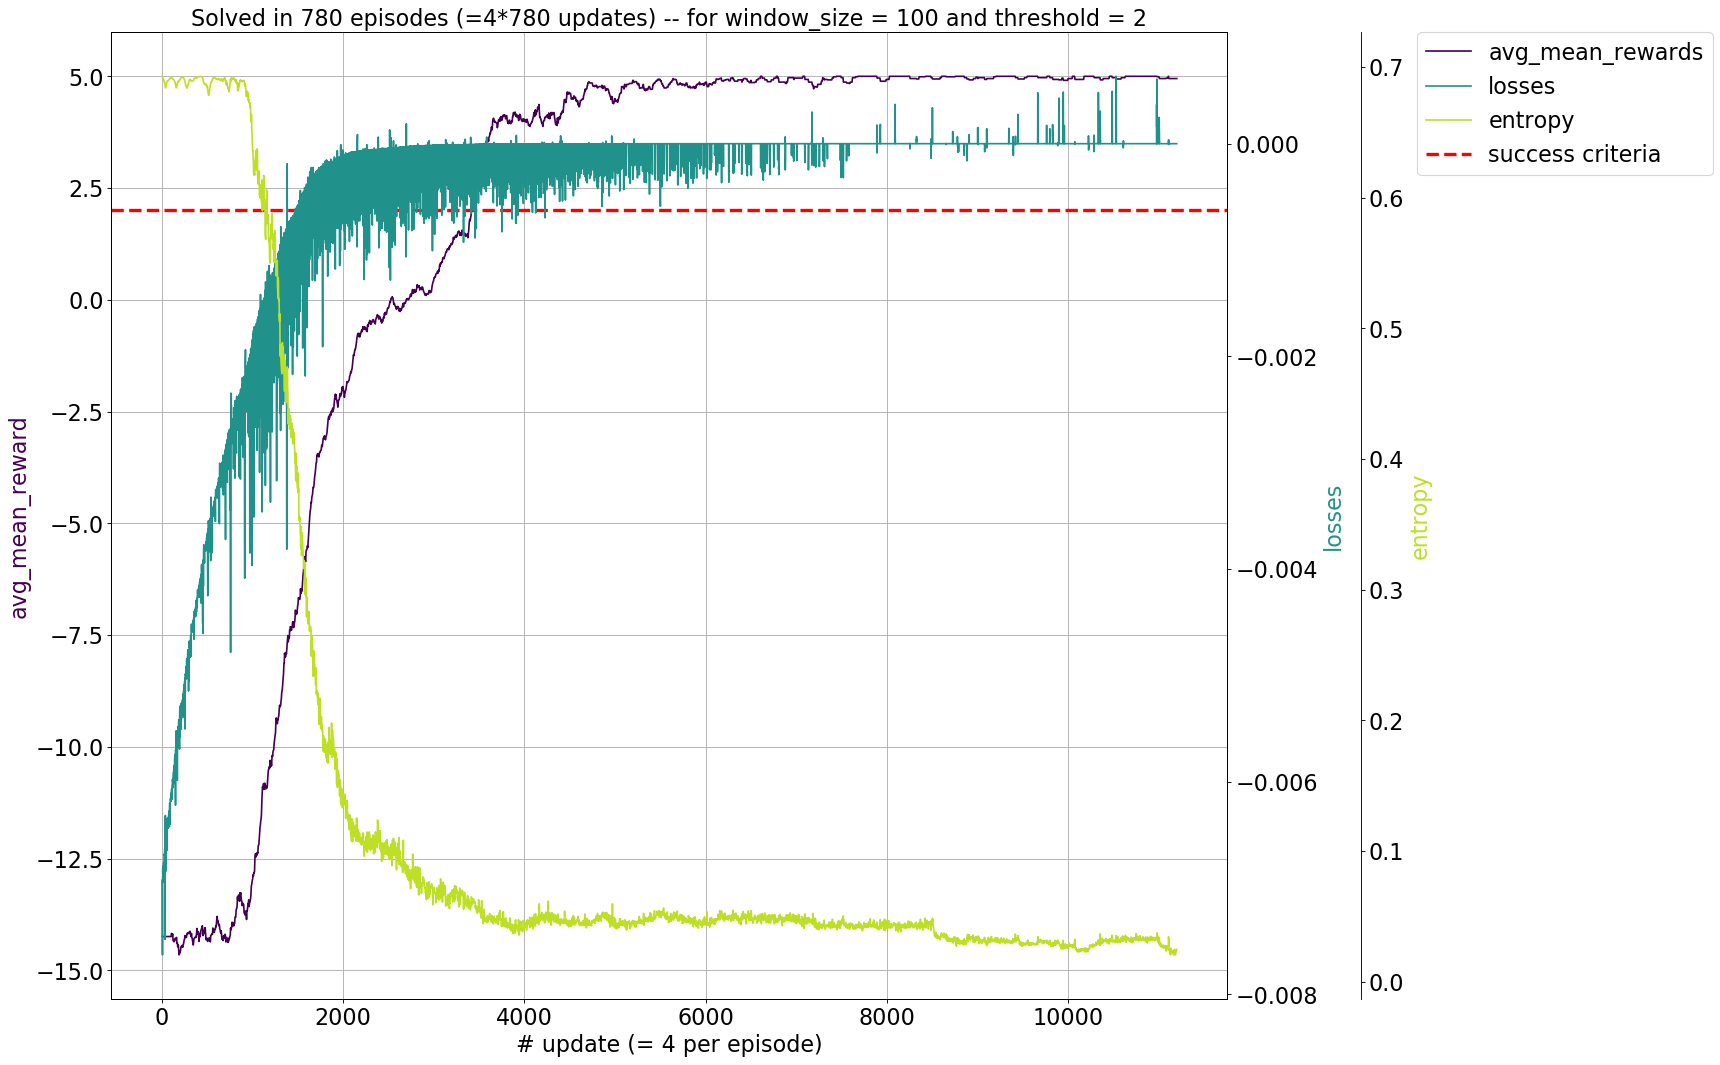

In [88]:
# plot results
# choose if you want to use the raw mean_rewards or its moving average
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

host.set_xlabel("# update (= " + str(SGD_epoch) + " per episode)", fontsize=20)
# host.set_ylabel("mean_reward", fontsize=20)
host.set_ylabel("avg_mean_reward", fontsize=20)
par1.set_ylabel("losses", fontsize=20)
par2.set_ylabel("entropy", fontsize=20)

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5)
color3 = plt.cm.viridis(.9)

# p1, = host.plot(np.arange(1, len(mean_rewards)+1), mean_rewards, color=color1, label="mean_rewards")
p1, = host.plot(np.arange(1, len(avg_mean_rewards)+1), np.asarray(avg_mean_rewards), color=color1, label="avg_mean_rewards")
p2, = par1.plot(np.arange(1, len(losses)+1), losses, color=color2, label="losses", zorder=5)
p3, = par2.plot(np.arange(1, len(entropies)+1), entropies, color=color3, label="entropy")
p4 = host.axhline(y=threshold, c="r", label="success criteria", linestyle="--", linewidth=3)

lns = [p1, p2, p3, p4]
labs = [l.get_label() for l in lns]
par2.spines['right'].set_position(('outward', 120))      

# text sizes
host.legend(lns, labs, prop={'size': 20}, bbox_to_anchor=(1.17, 1), borderaxespad=0.)
host.xaxis.set_tick_params(labelsize=20)
host.yaxis.set_tick_params(labelsize=20)
par1.yaxis.set_tick_params(labelsize=20)
par2.yaxis.set_tick_params(labelsize=20)

# text color
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# title
duration = 10
plt.title(title, fontsize=20)

host.grid()
# plt.savefig("training.png", bbox_inches='tight')

In [29]:
# save the policy
if method == "REINFORCE":
    torch.save(policy, 'REINFORCE_solution.policy')
elif method == "PPO":
    torch.save(policy, 'PPO_solution.policy')

C:\Users\simon.chauvin\AppData\Local\Continuum\anaconda3\envs\drlnd\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Testing

In [91]:
# mind the method
policy = torch.load('PPO_BU.policy')
# policy = torch.load('REINFORCE.policy')


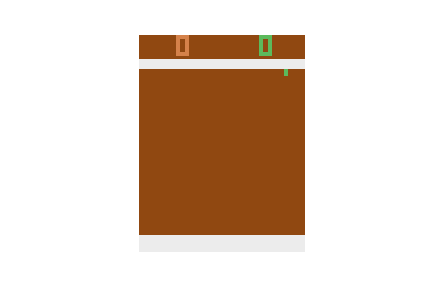
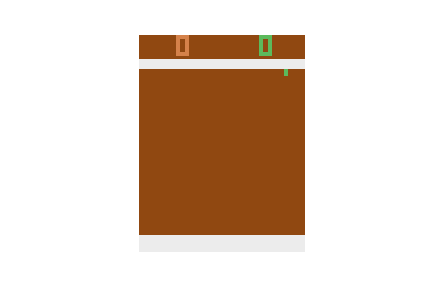
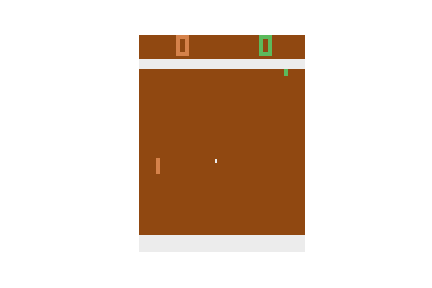
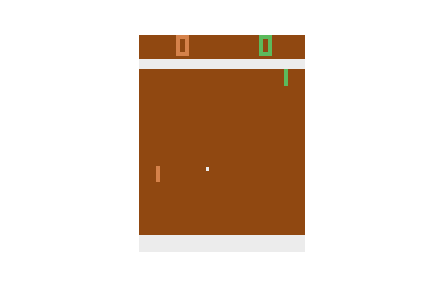
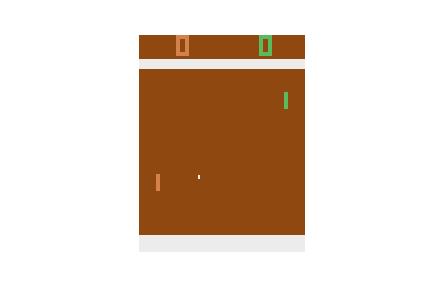
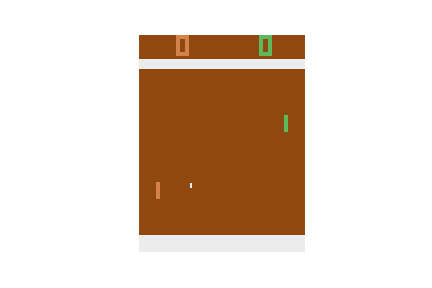
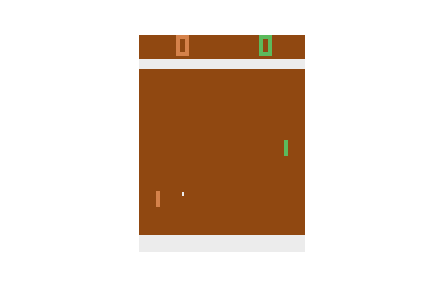
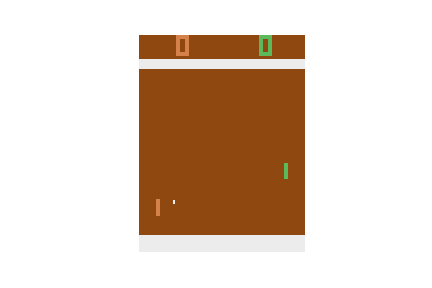
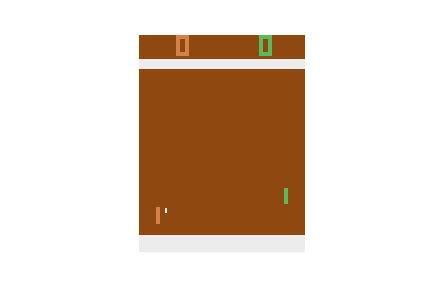
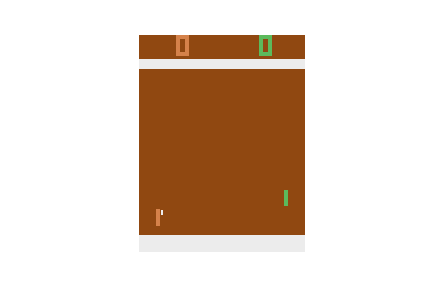
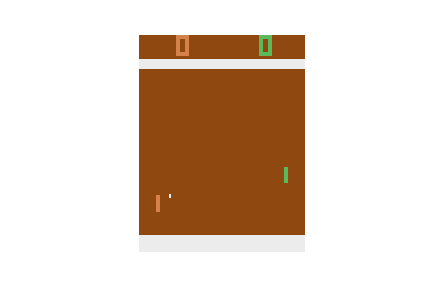
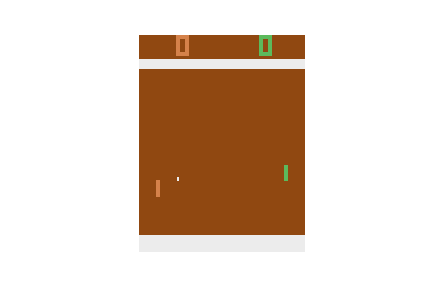
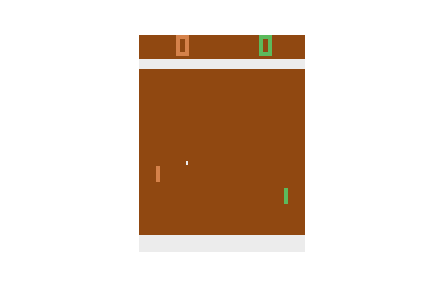
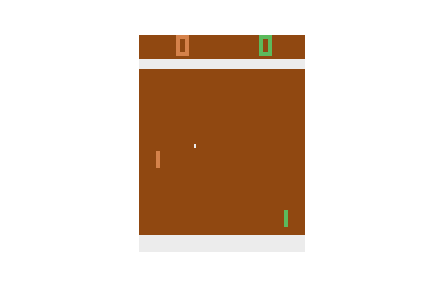
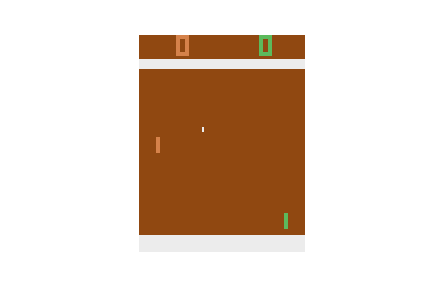
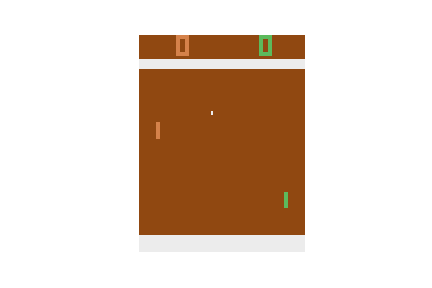
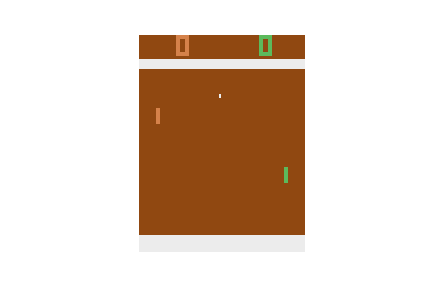
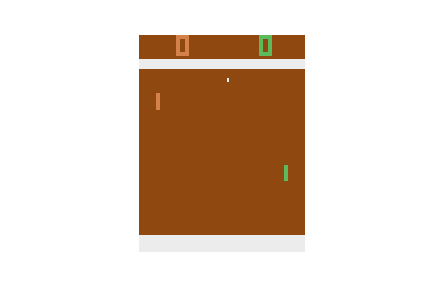
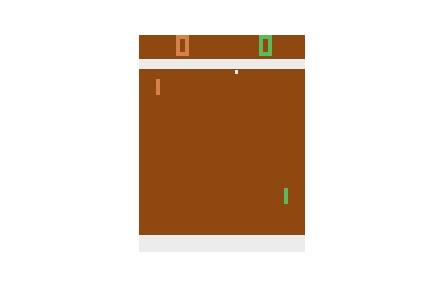
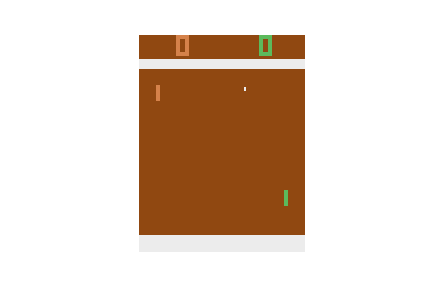
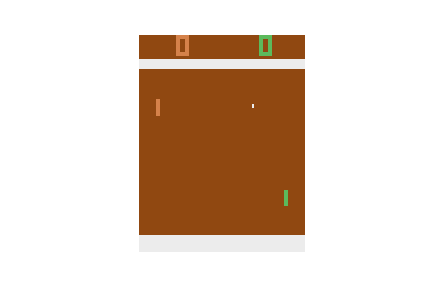
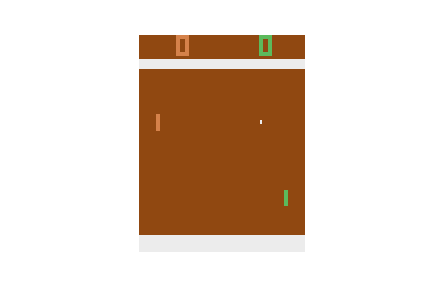
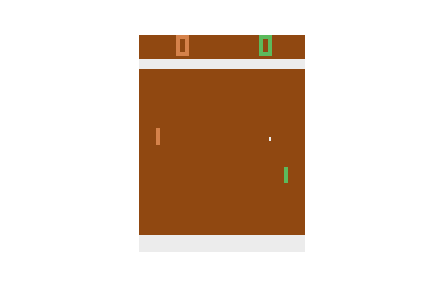
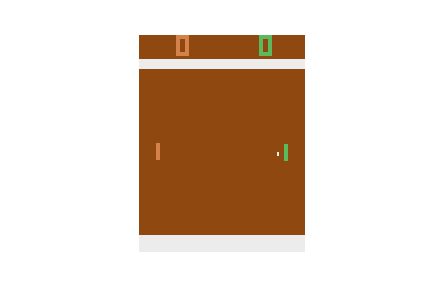
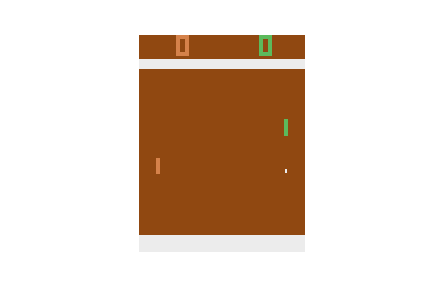
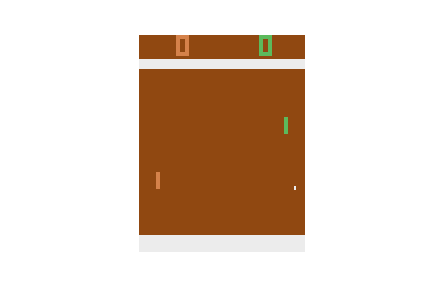
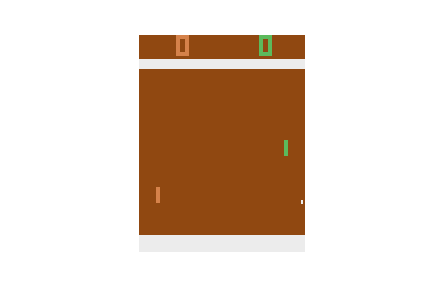
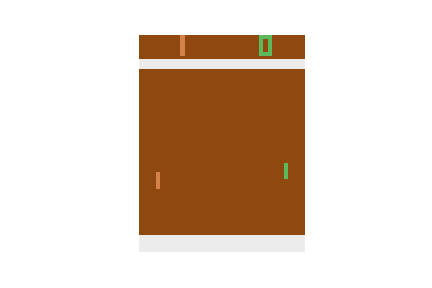
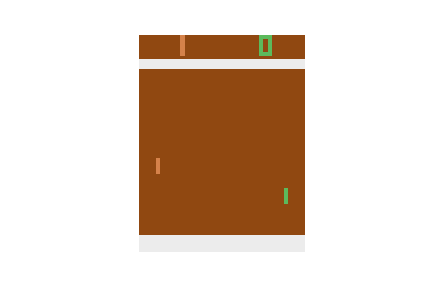
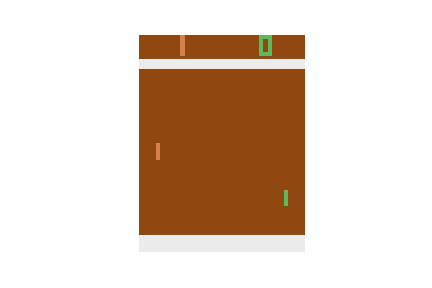
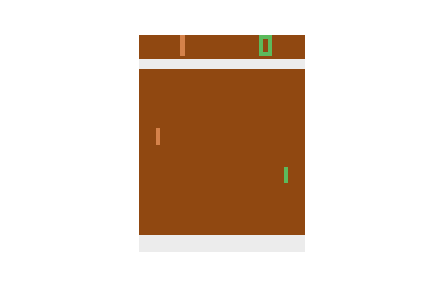
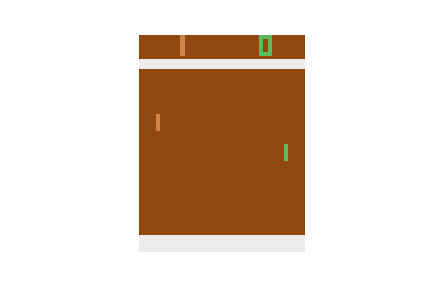
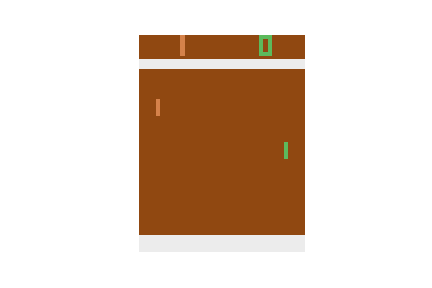
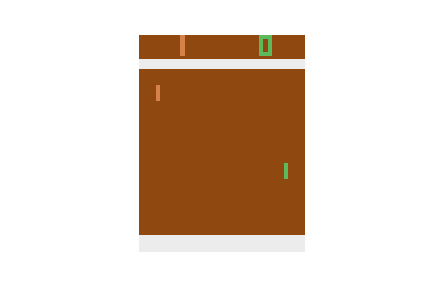
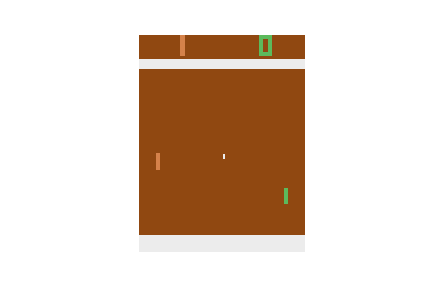
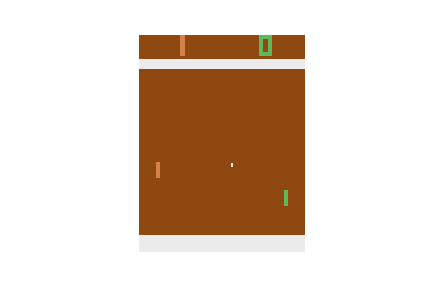
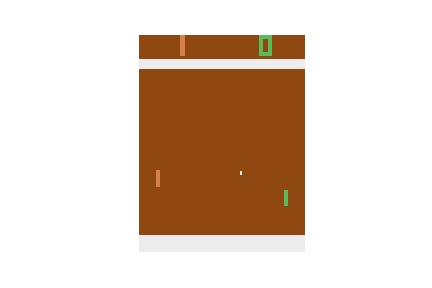
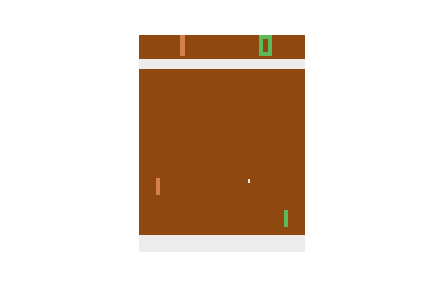
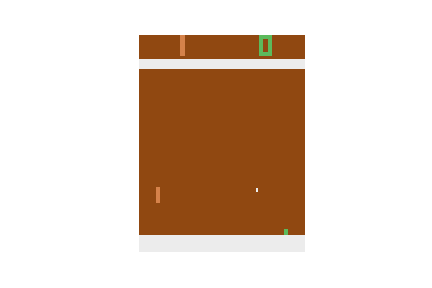
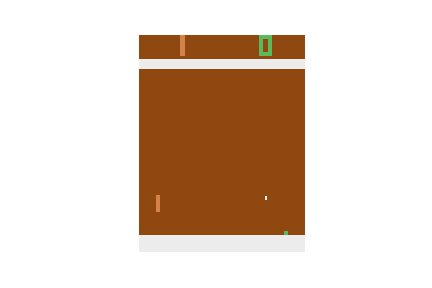
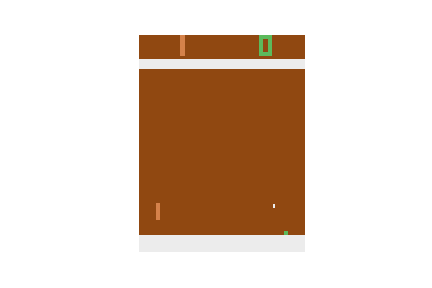
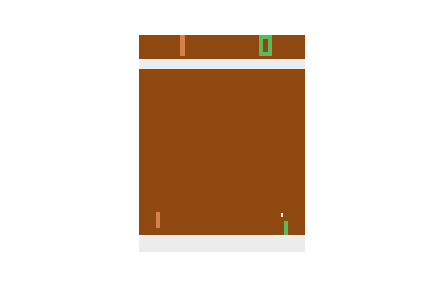
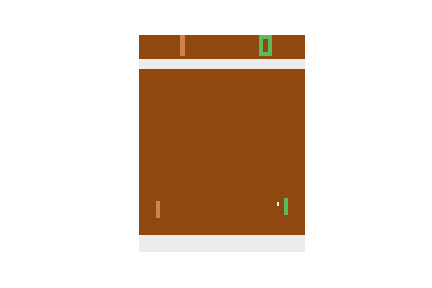
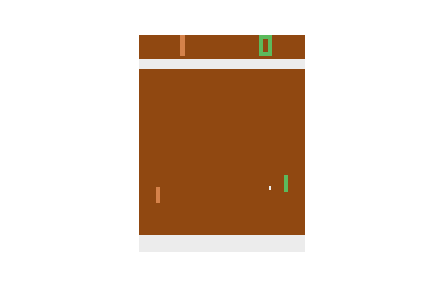
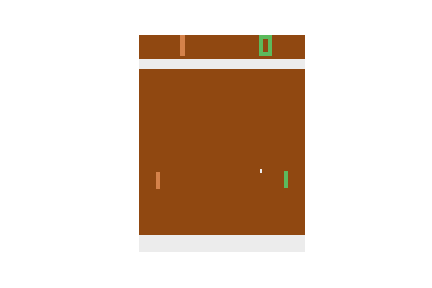
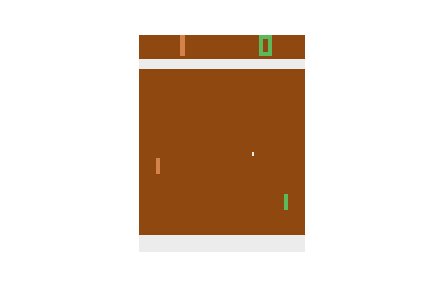
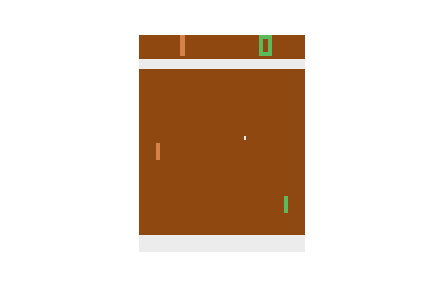
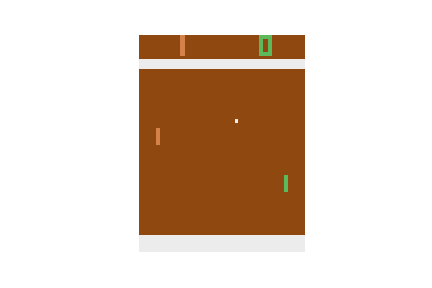
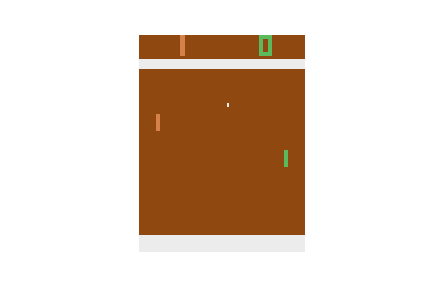
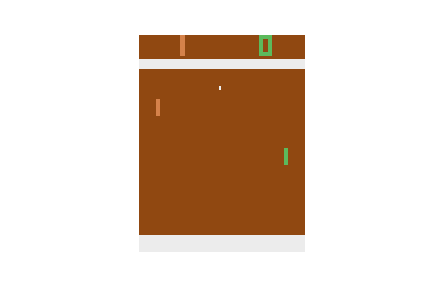
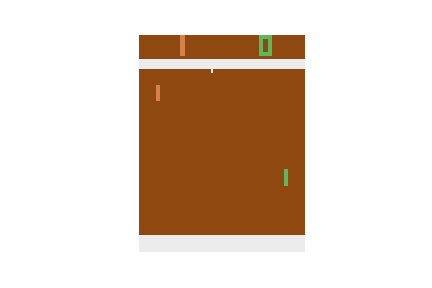
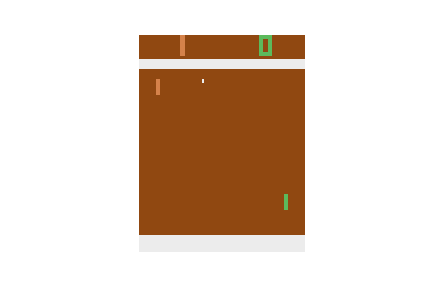
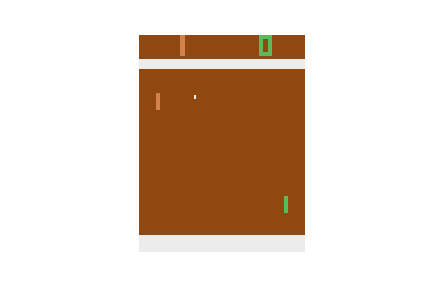
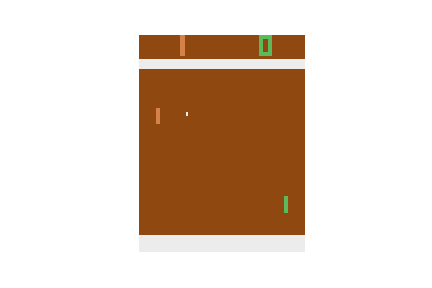
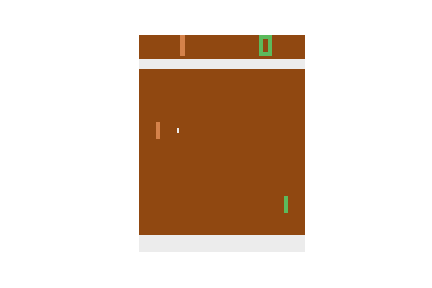
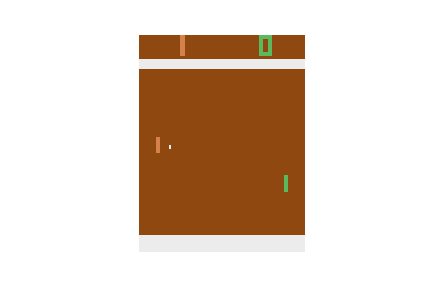
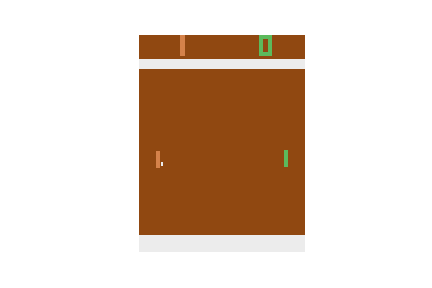
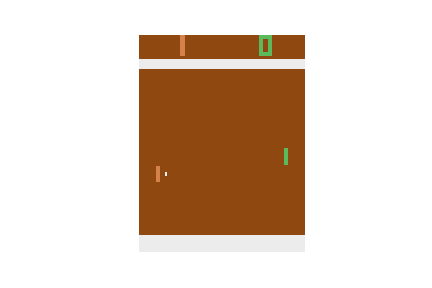
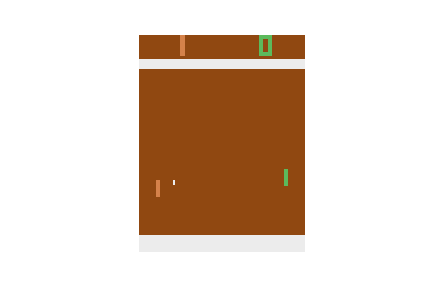
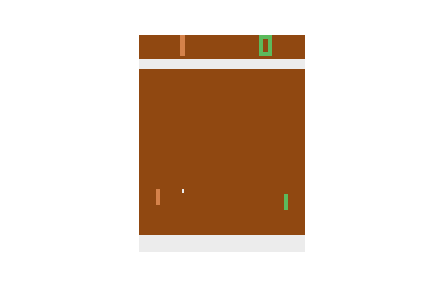
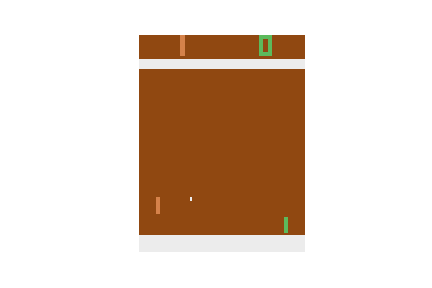
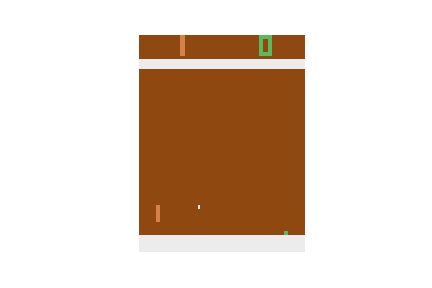
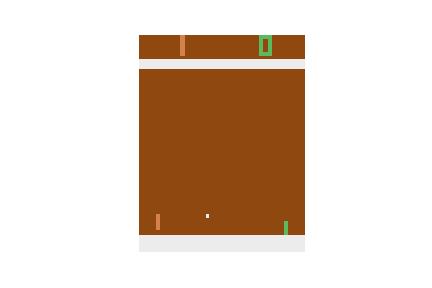
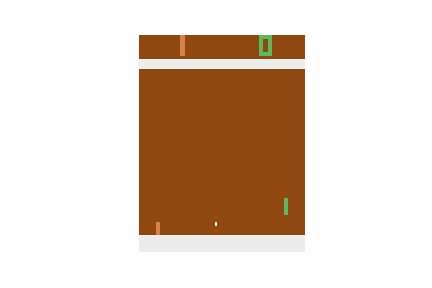
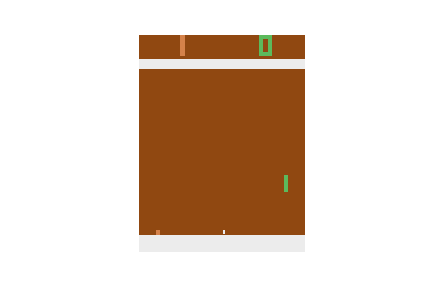
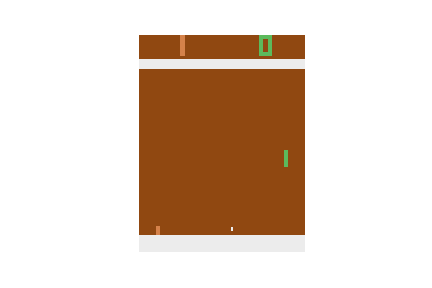
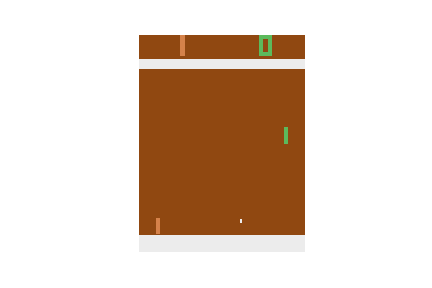
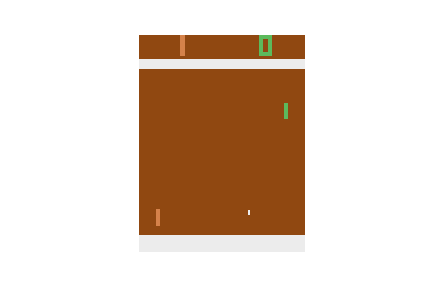
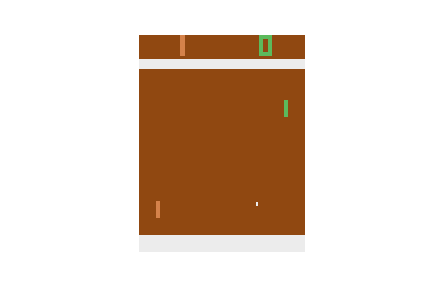
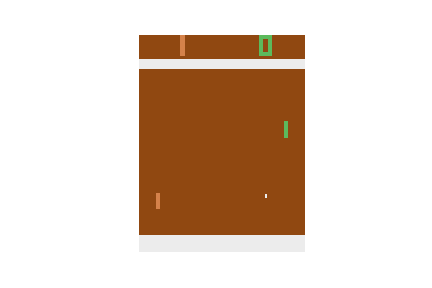
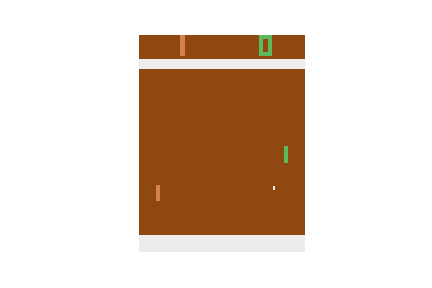
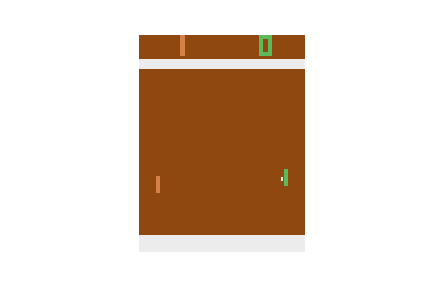
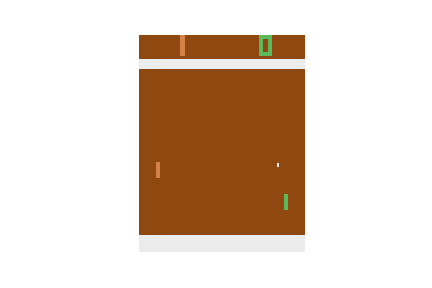
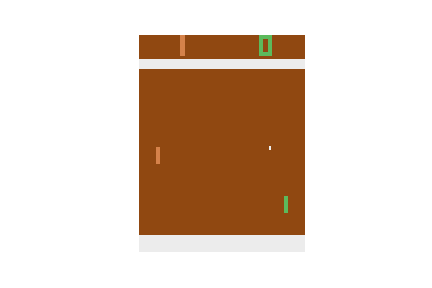
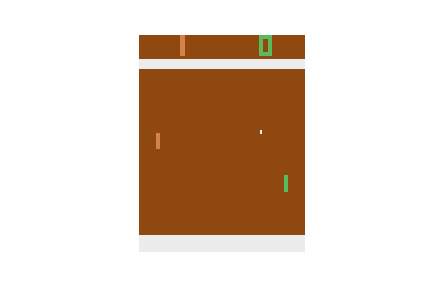
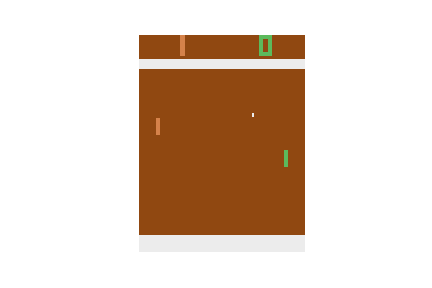
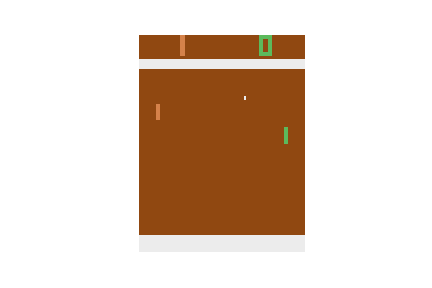
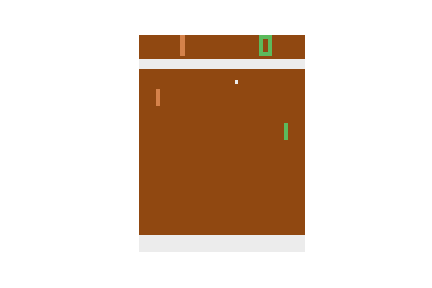
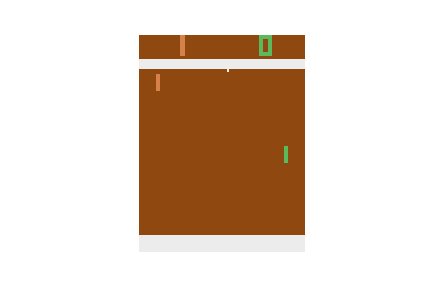
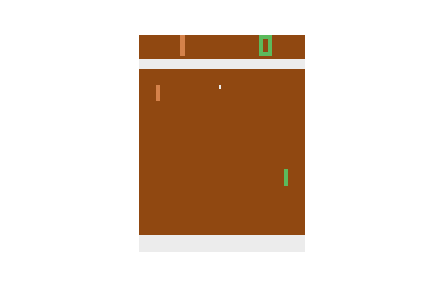
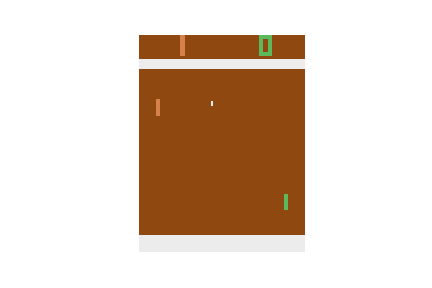
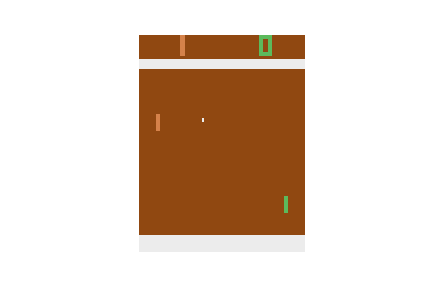
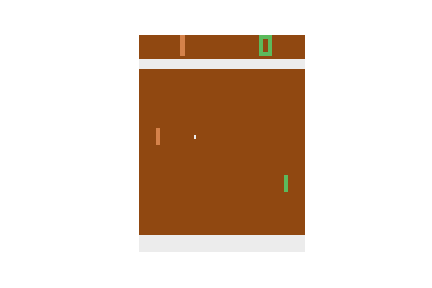
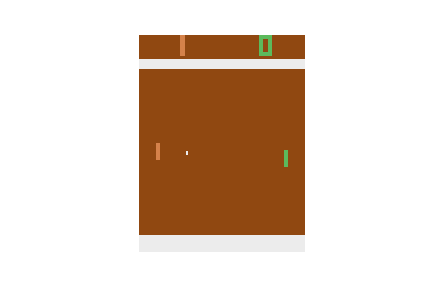
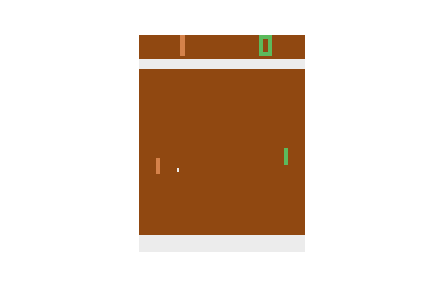
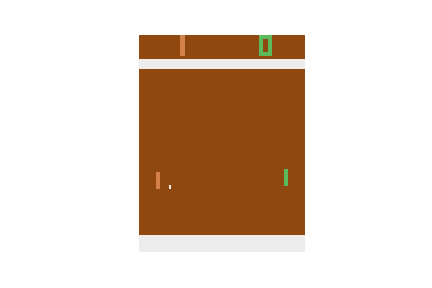
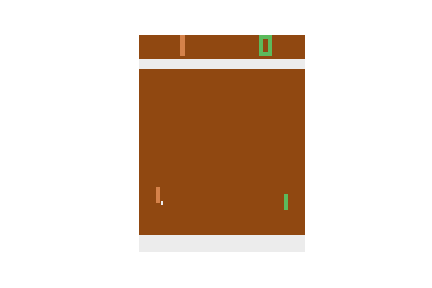
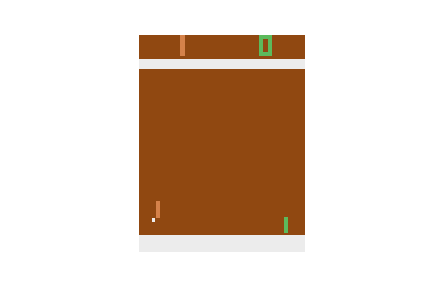
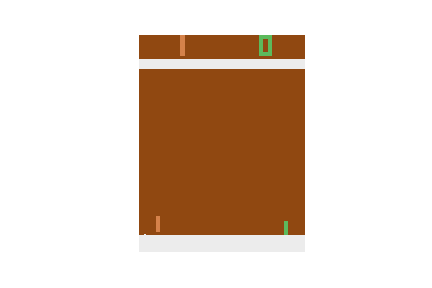
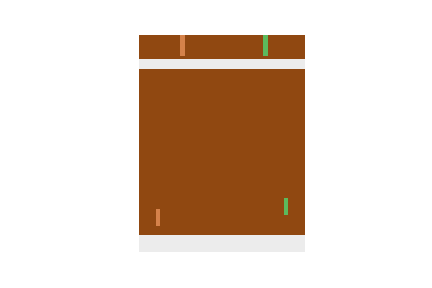
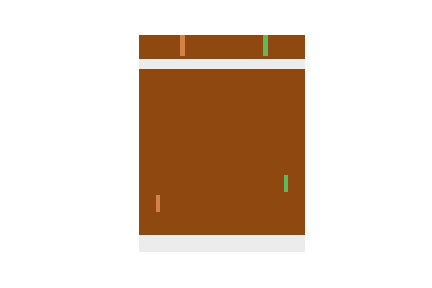
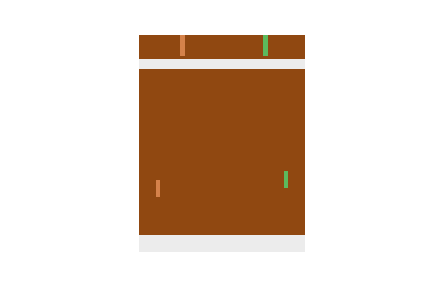
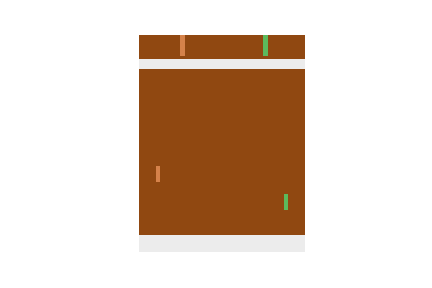
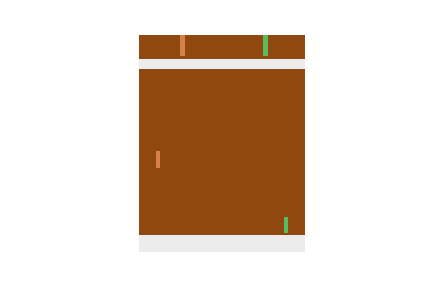
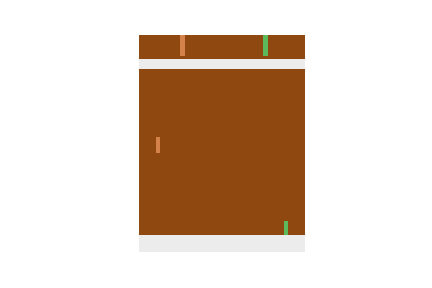
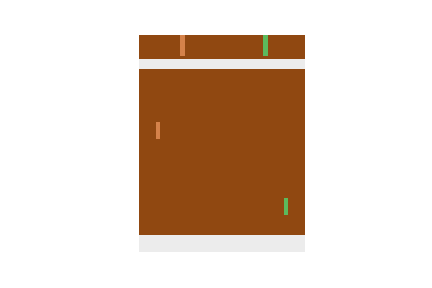
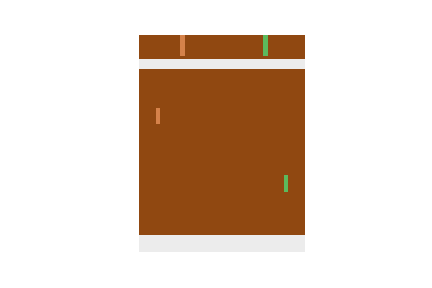
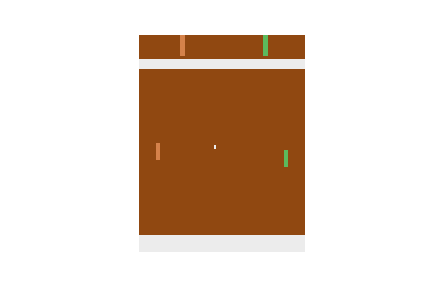
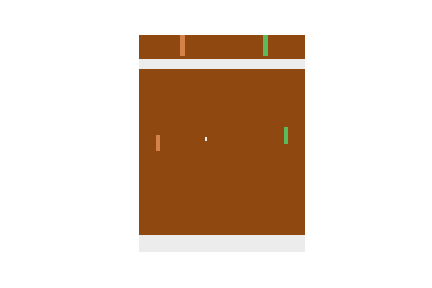
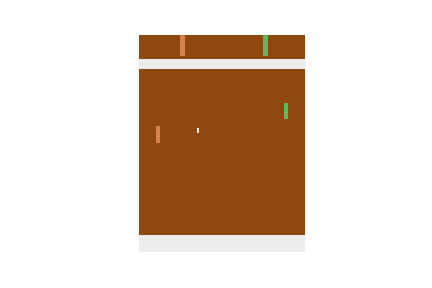
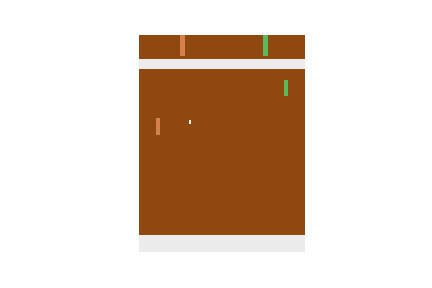
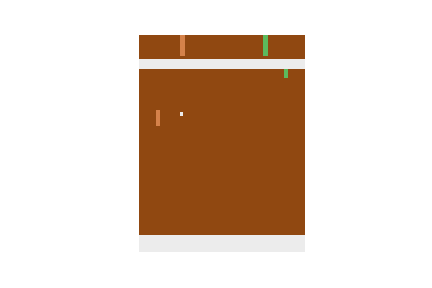
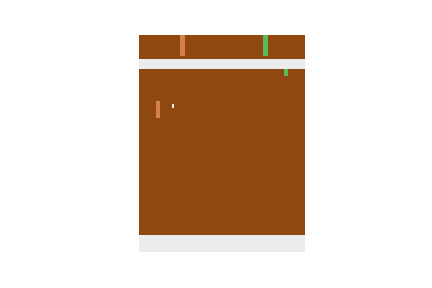
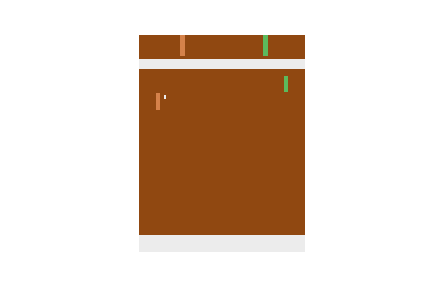
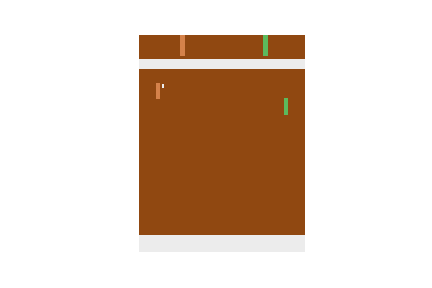
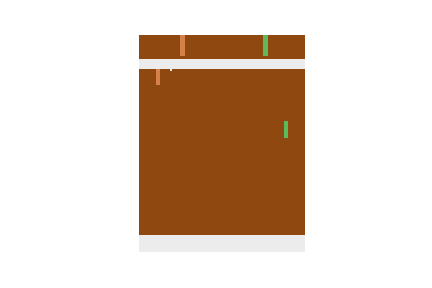
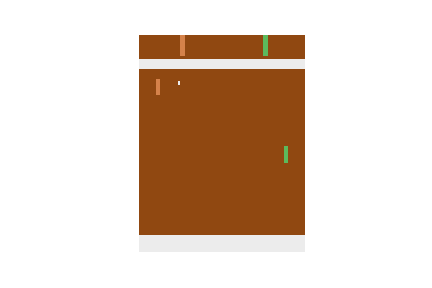
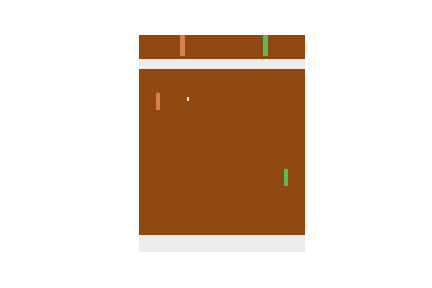
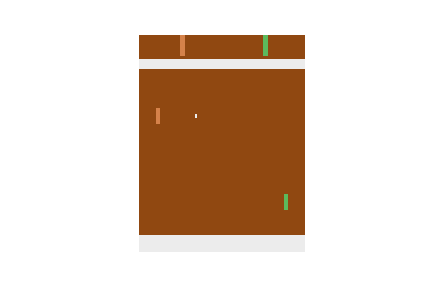
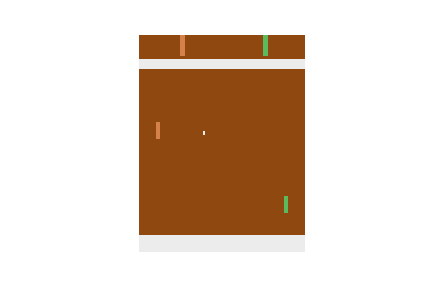
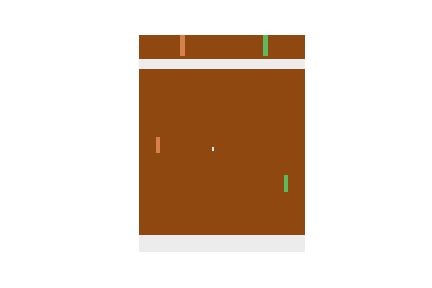
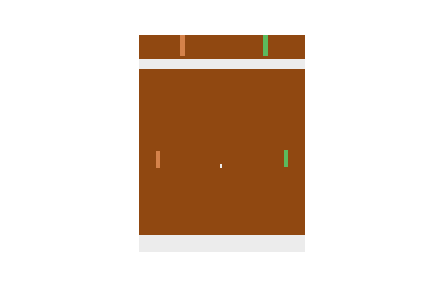
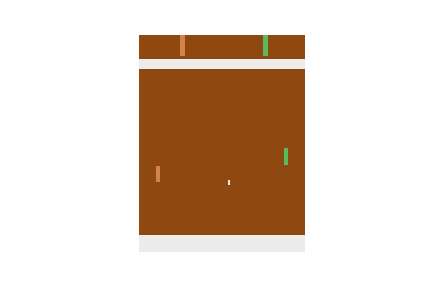
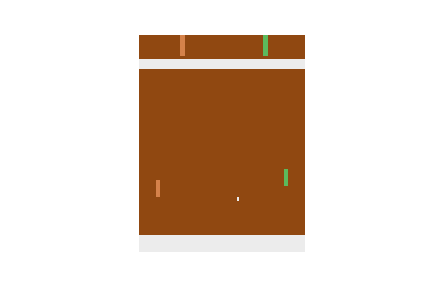
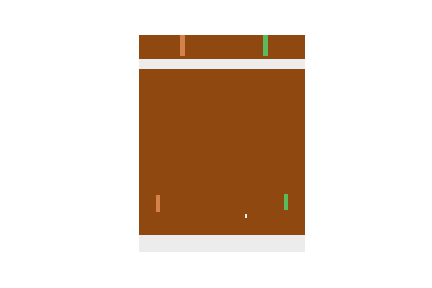
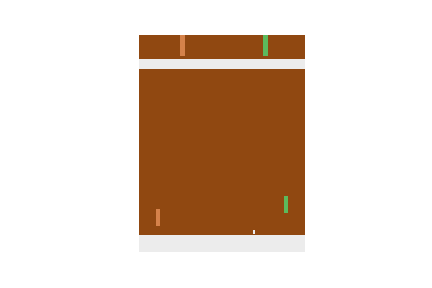
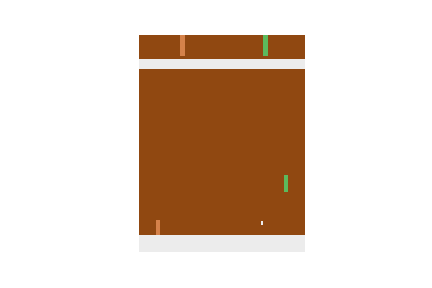
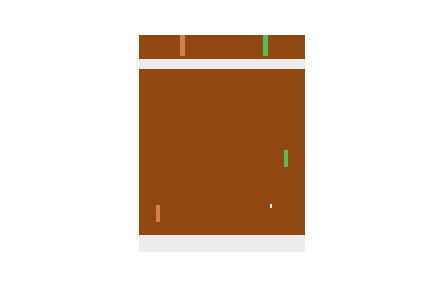
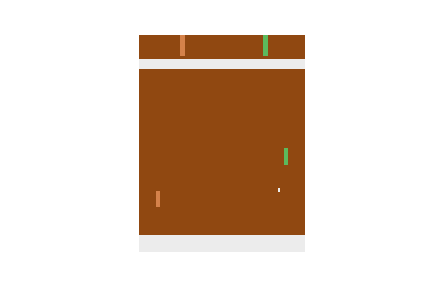
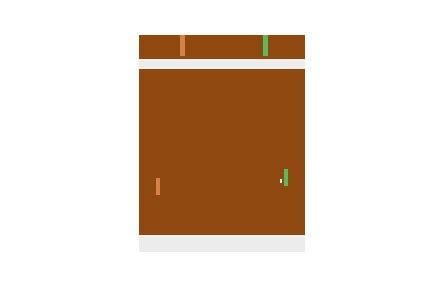
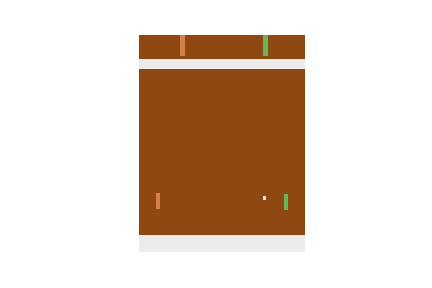
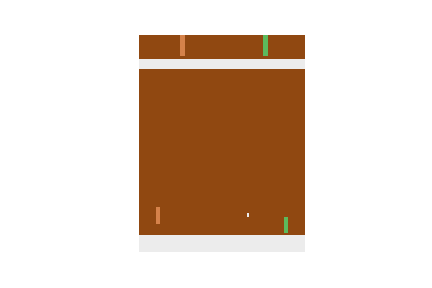
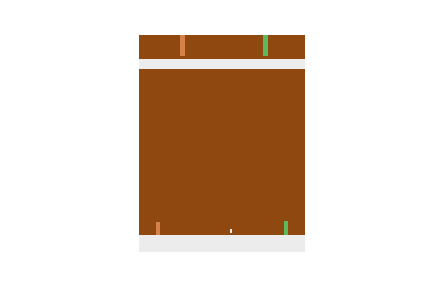
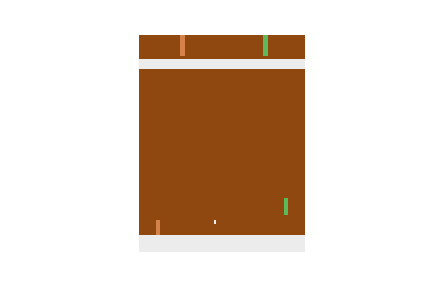
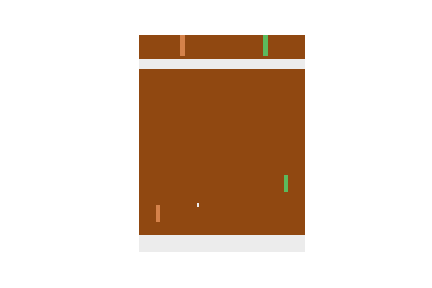
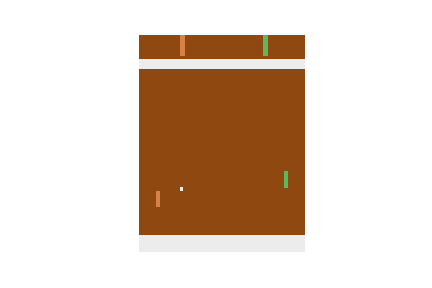
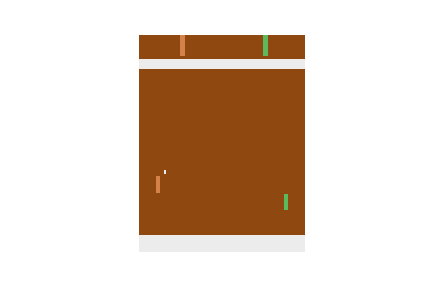
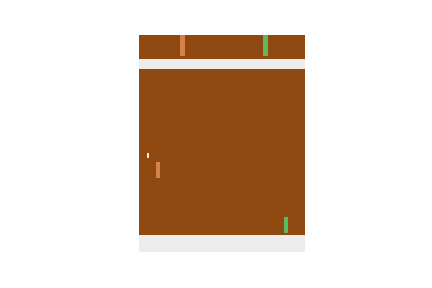
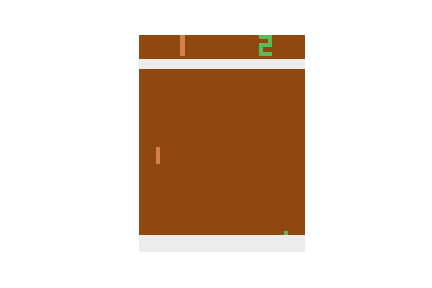
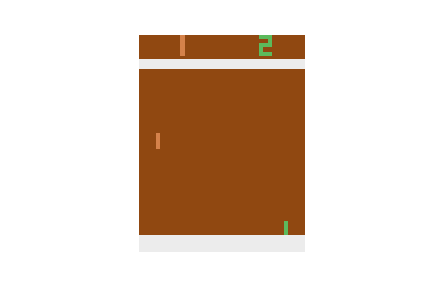
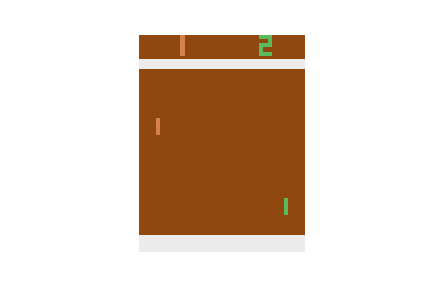
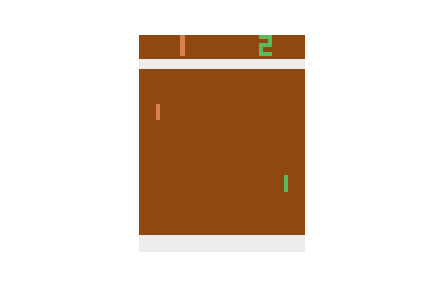
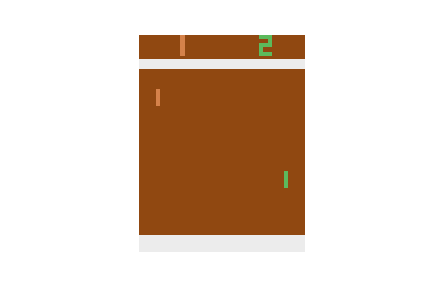
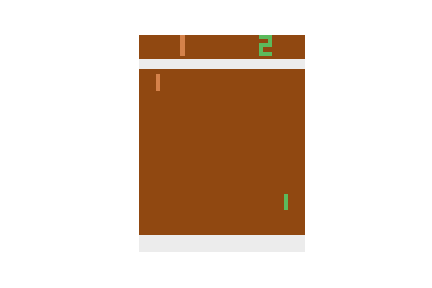
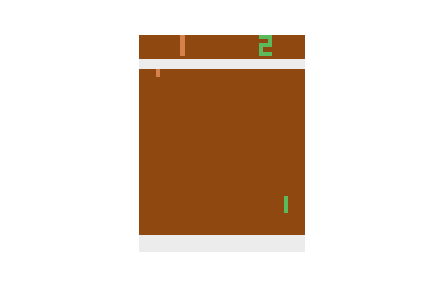
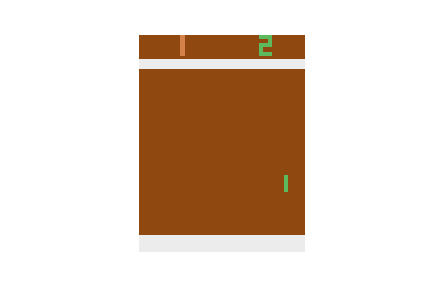
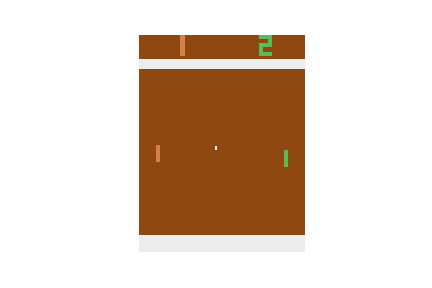
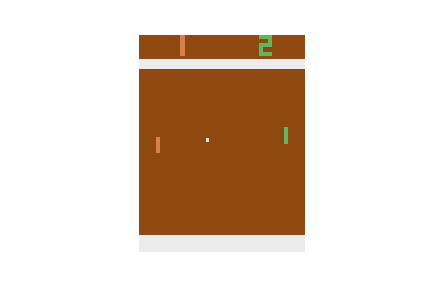
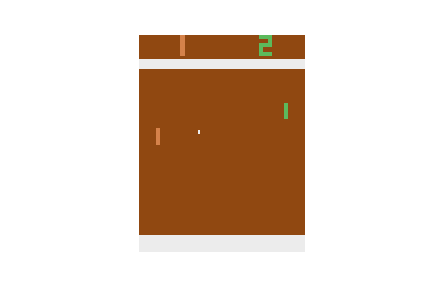
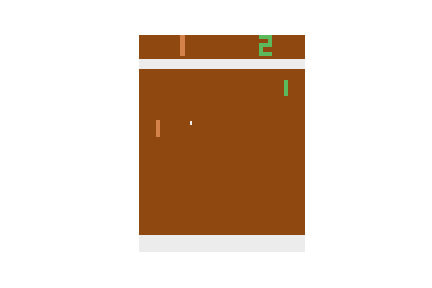
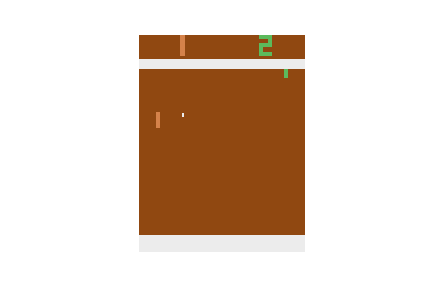
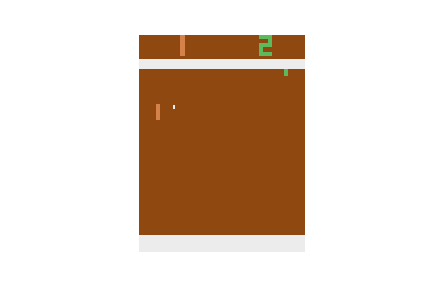
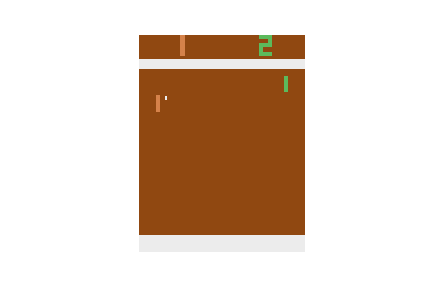
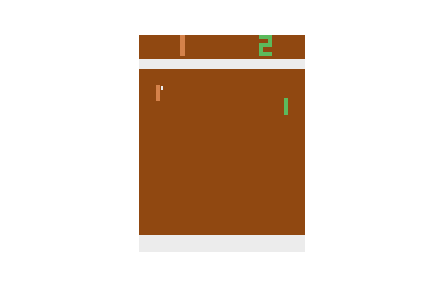
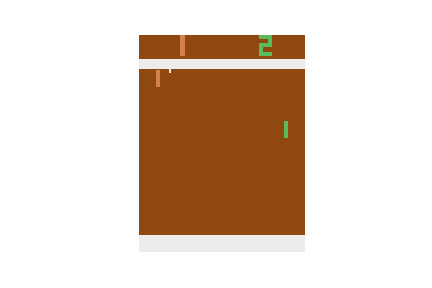
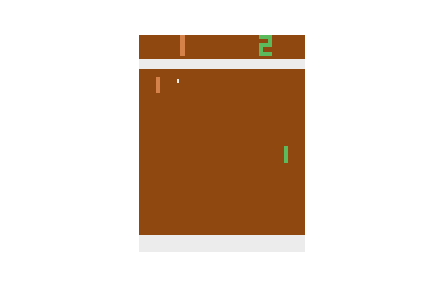
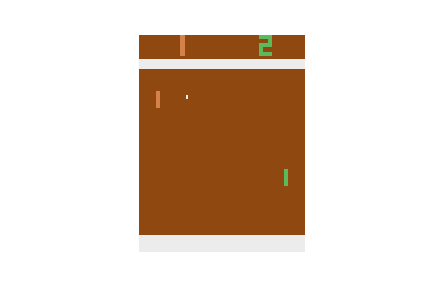
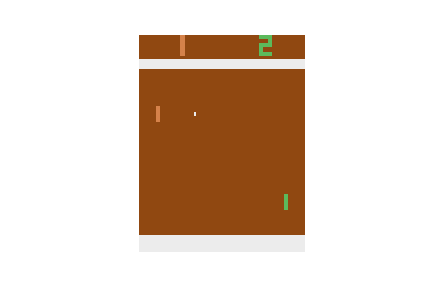
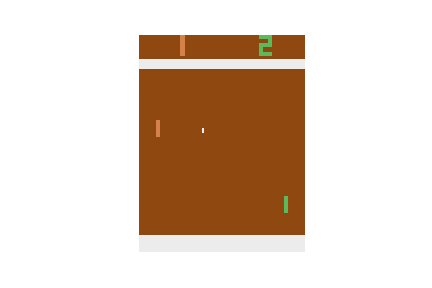
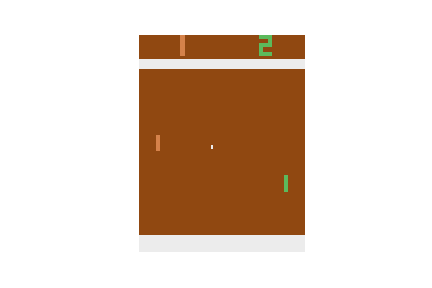
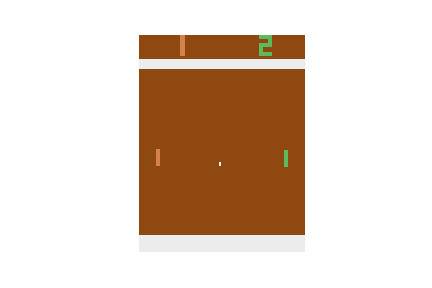
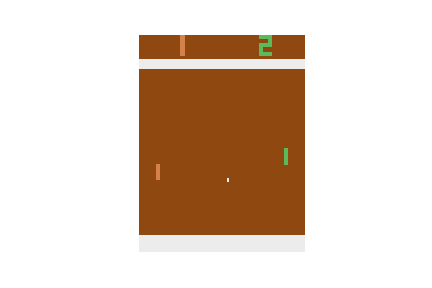
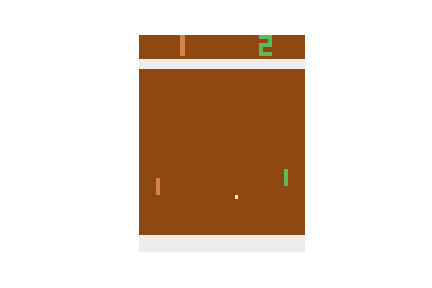
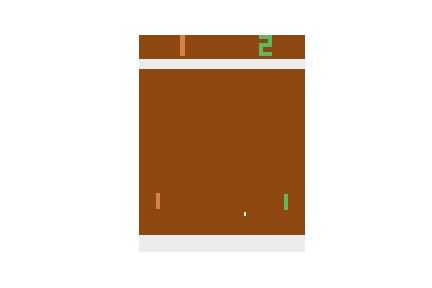
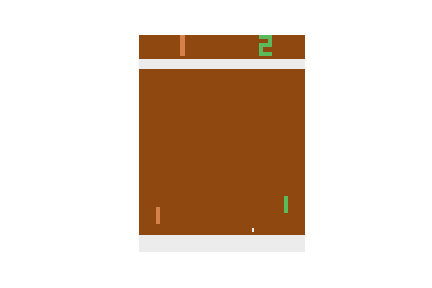
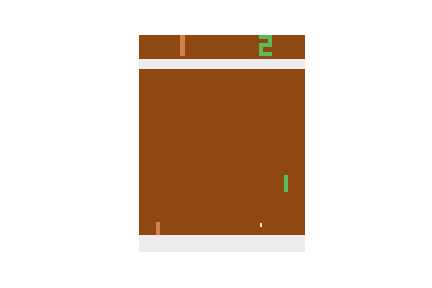
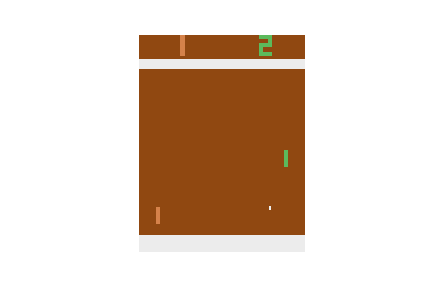
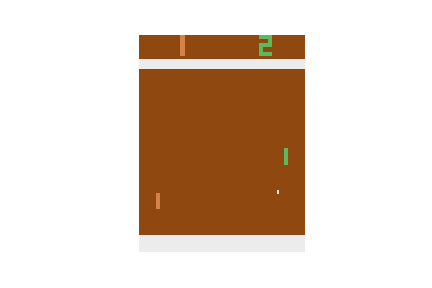
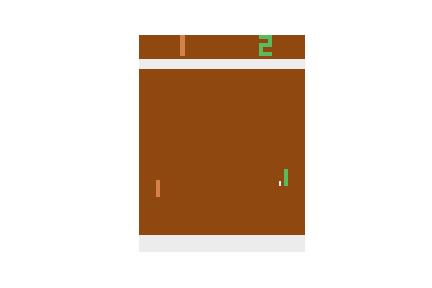
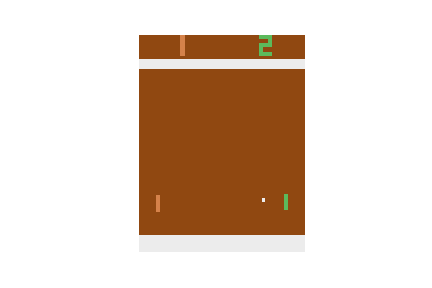
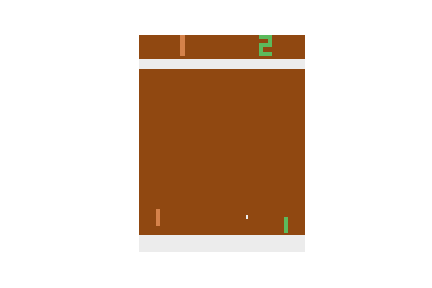
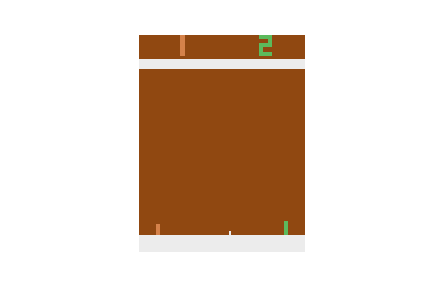
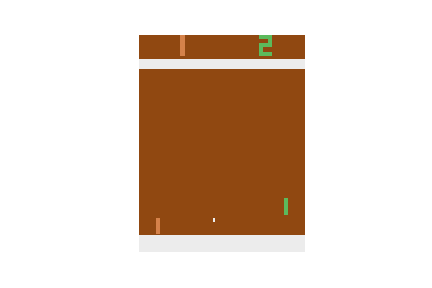
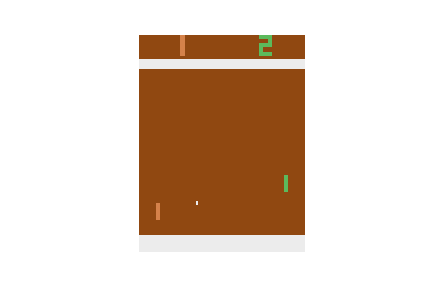
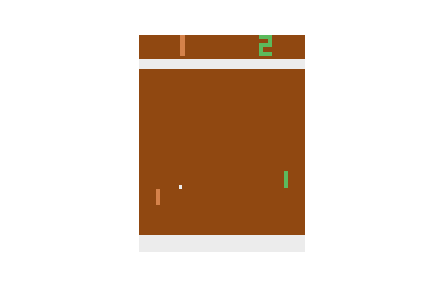
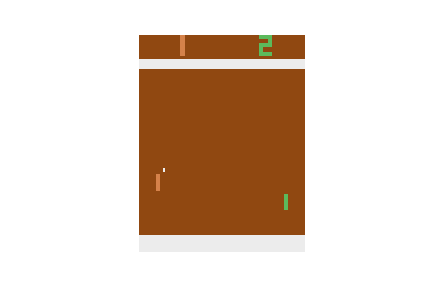
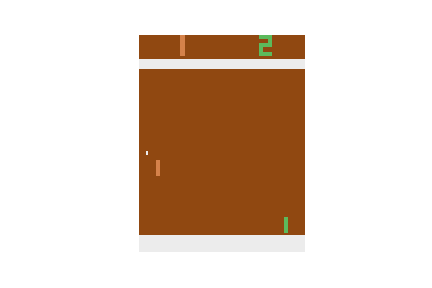
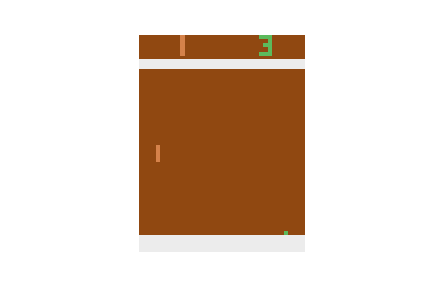
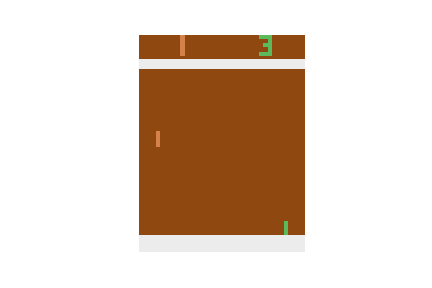
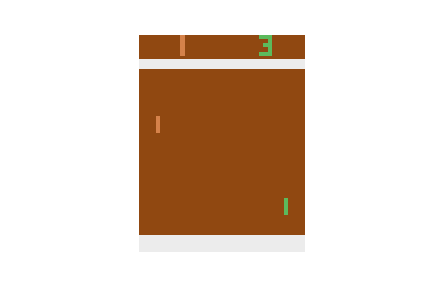
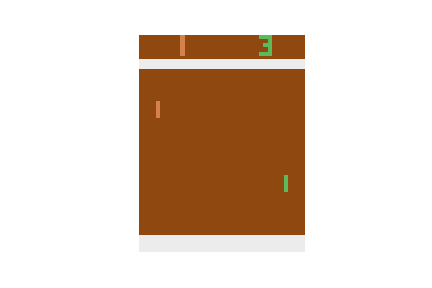
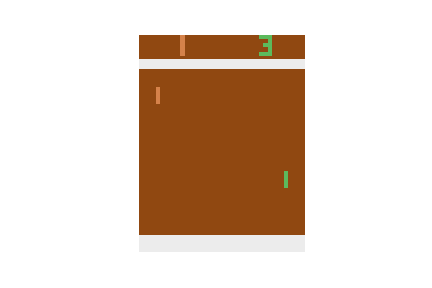
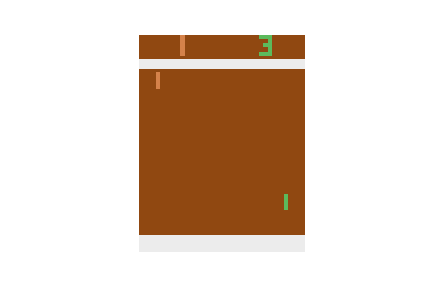
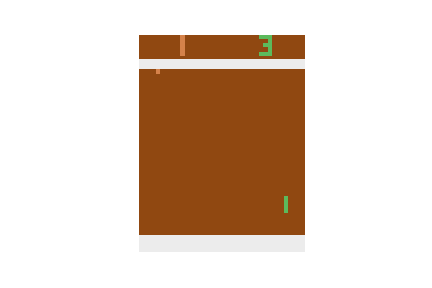
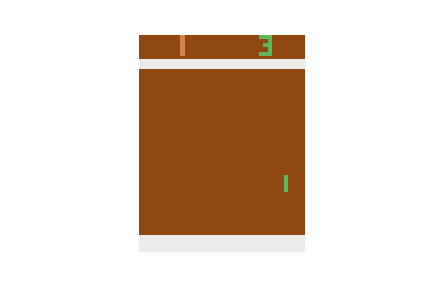
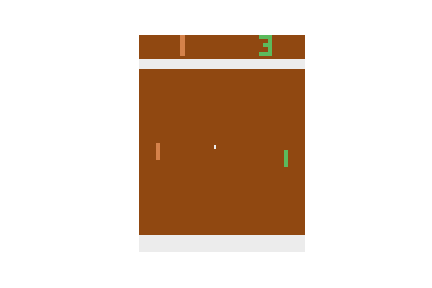
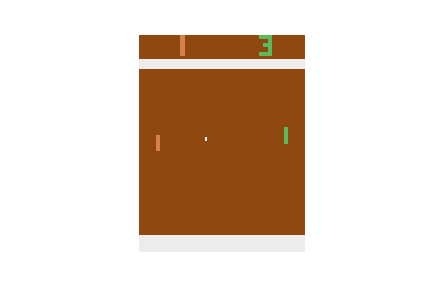
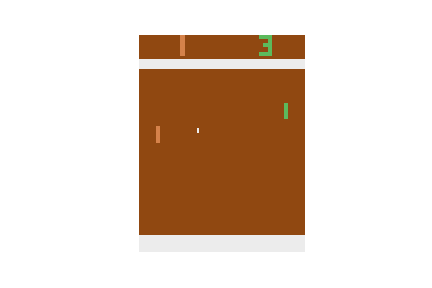
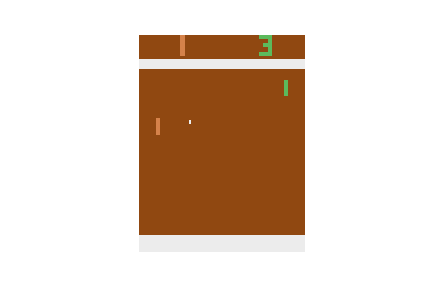
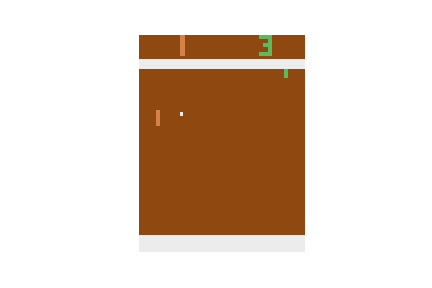
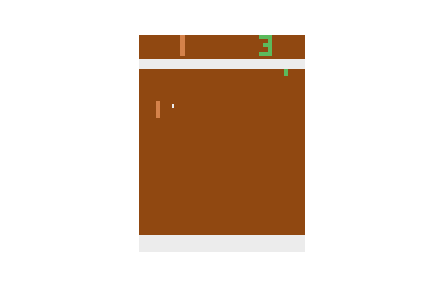
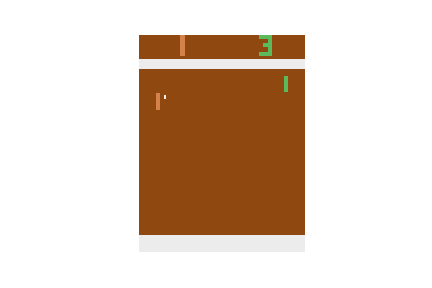
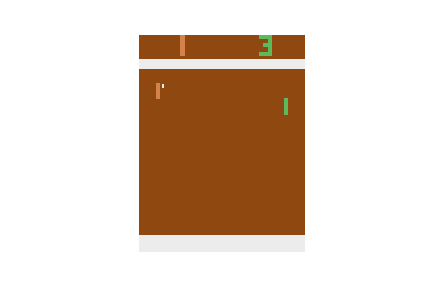
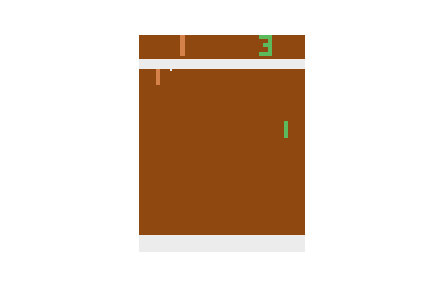
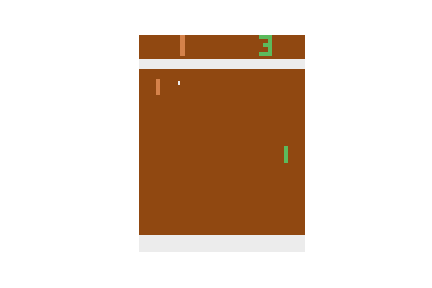
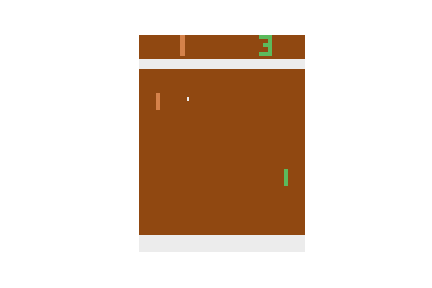
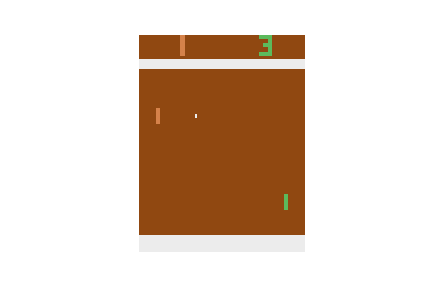
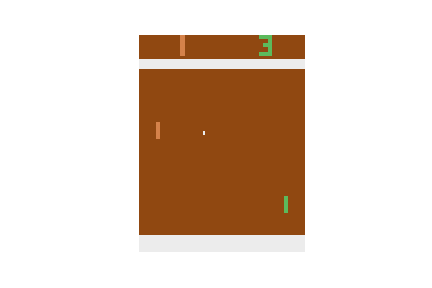
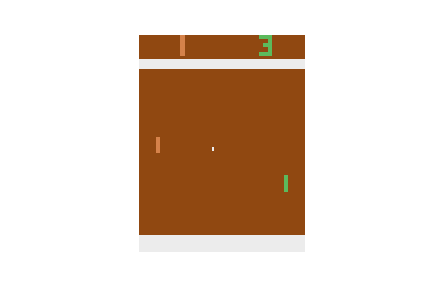
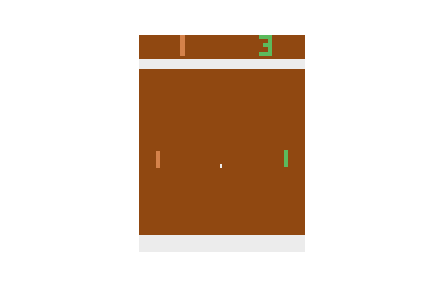
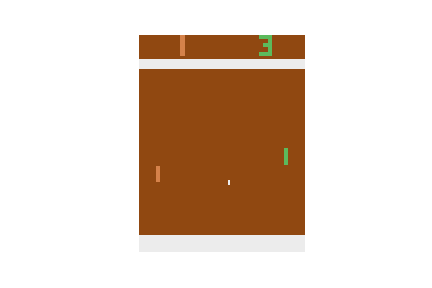
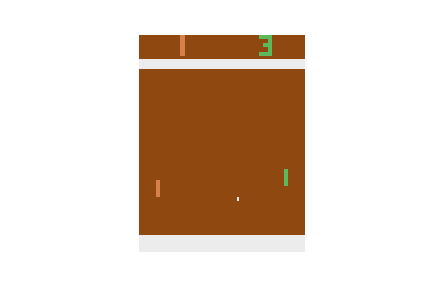
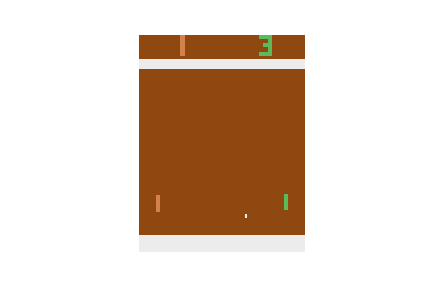
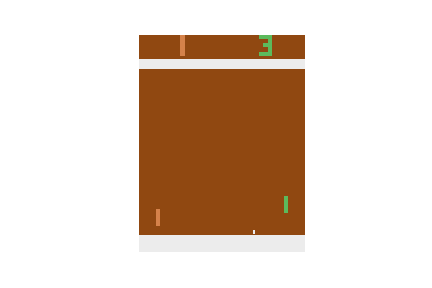
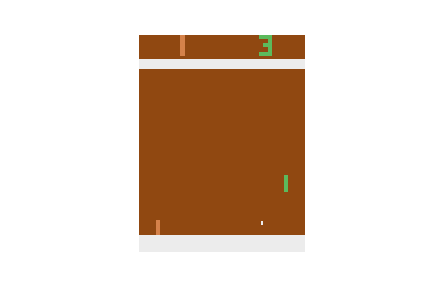
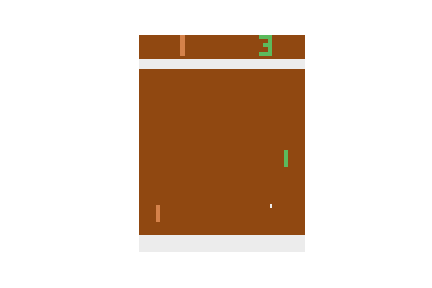
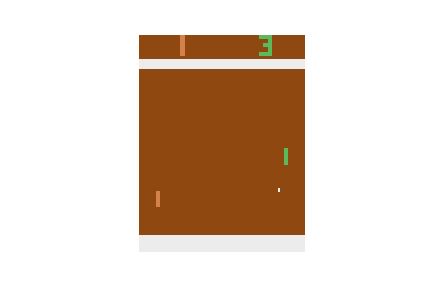
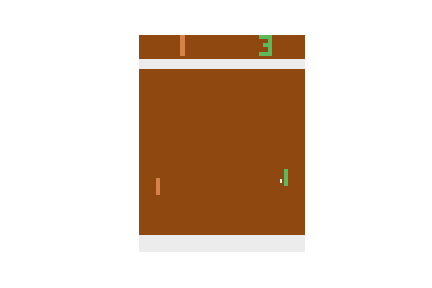
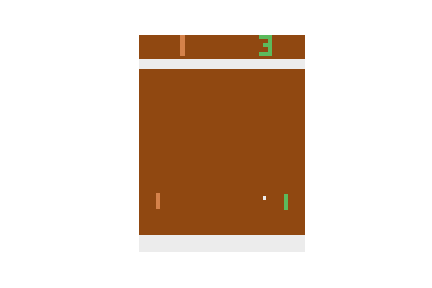
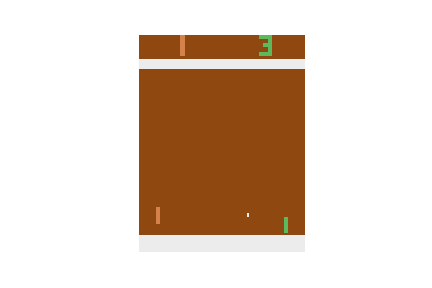
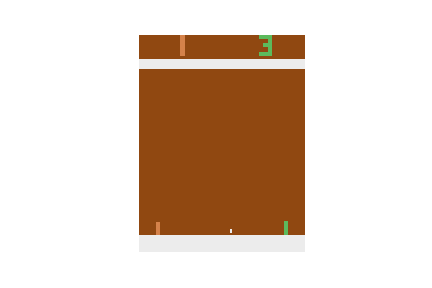
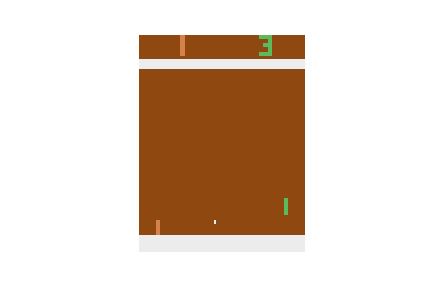
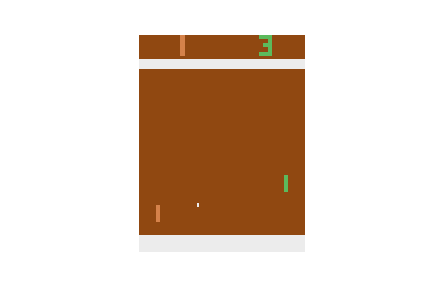
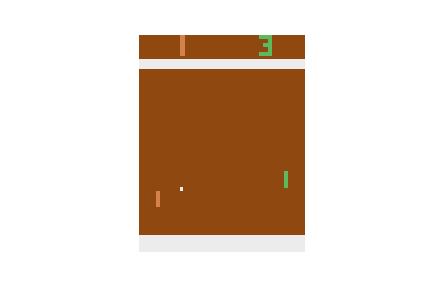
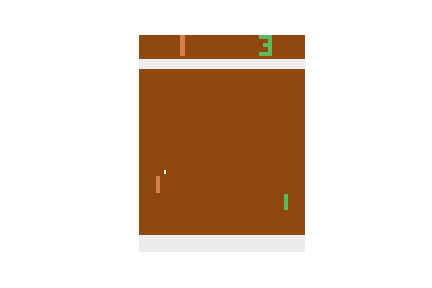
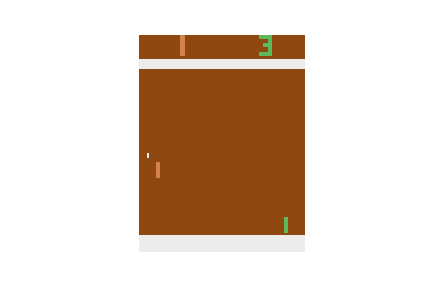
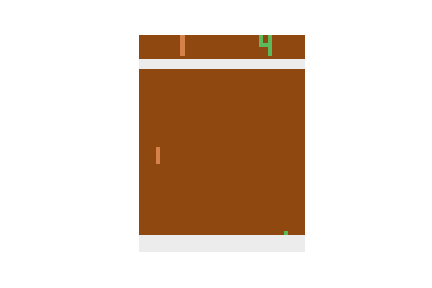
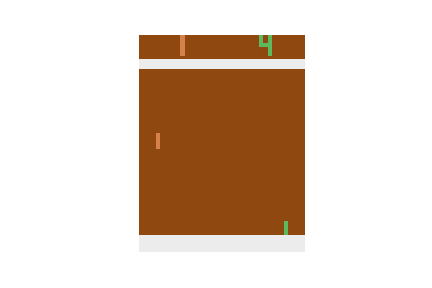
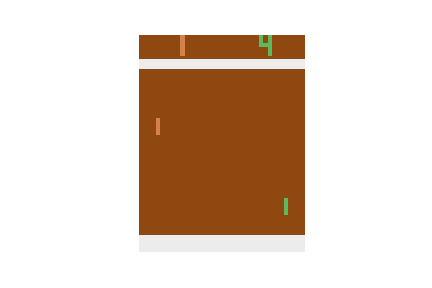
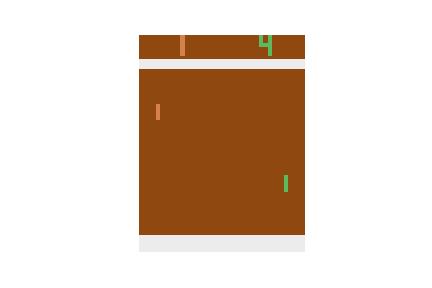
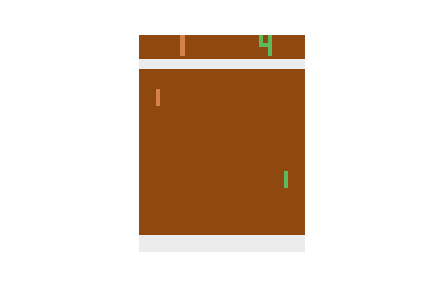
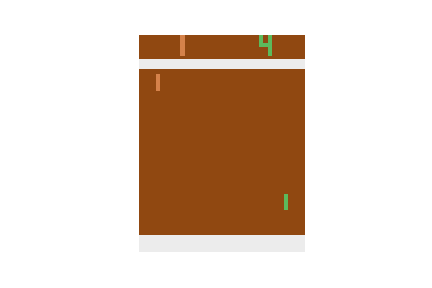
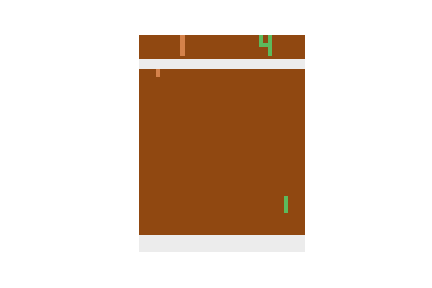
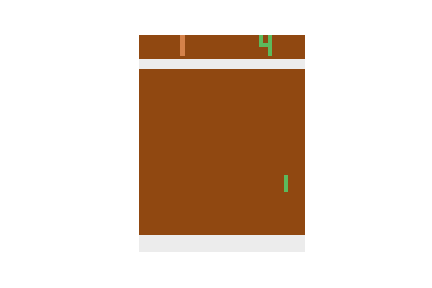
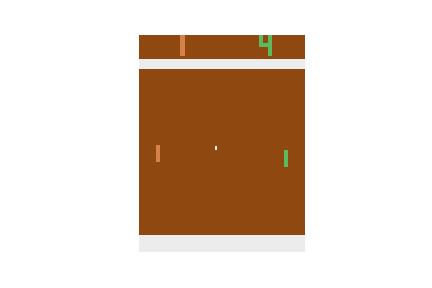
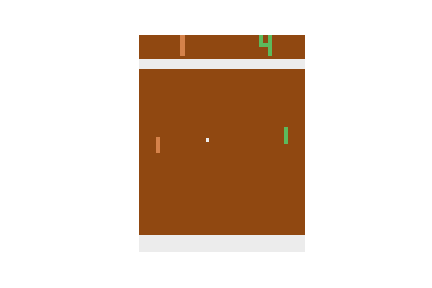
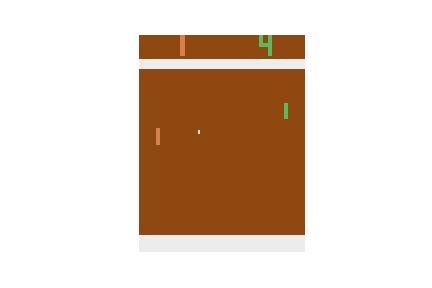
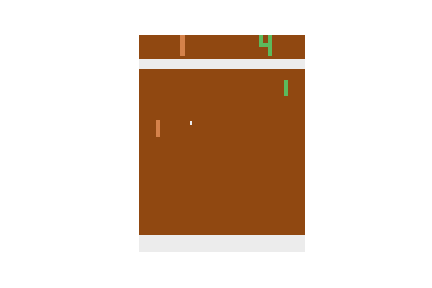
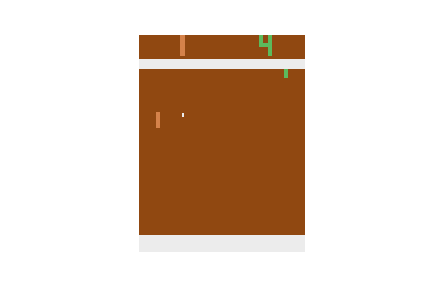
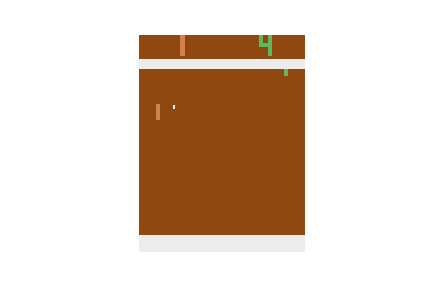
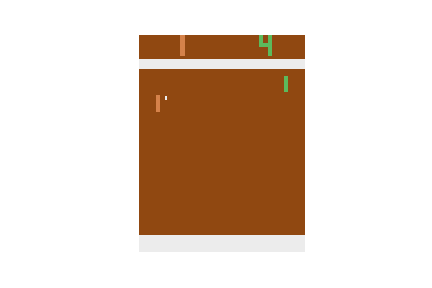
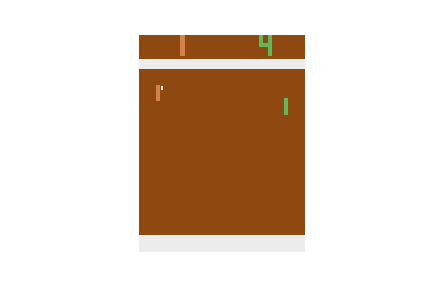
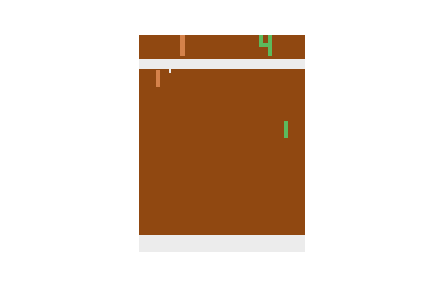
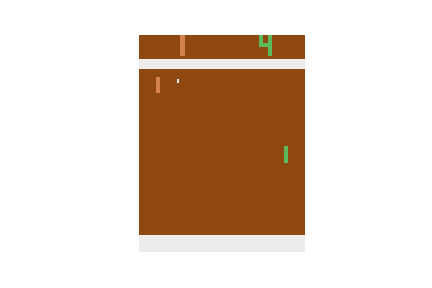
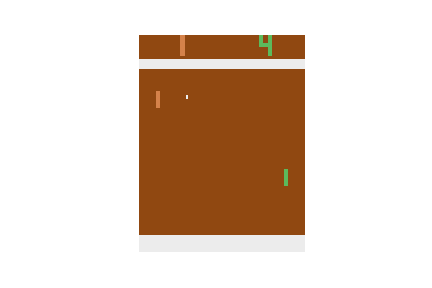
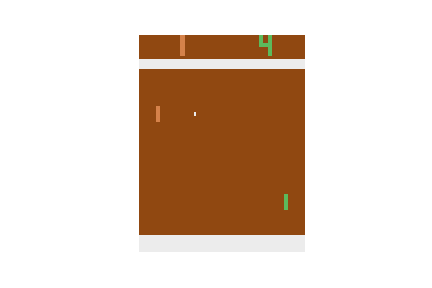
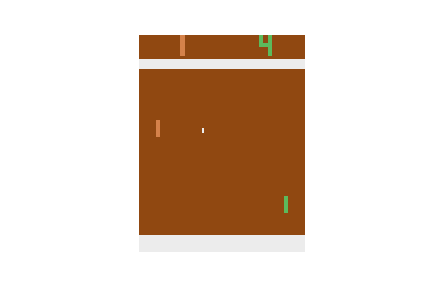
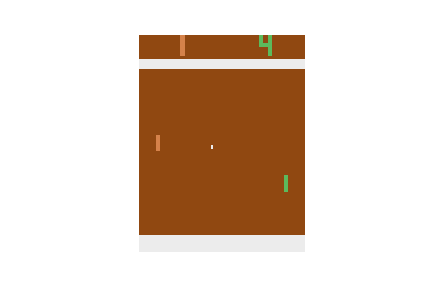
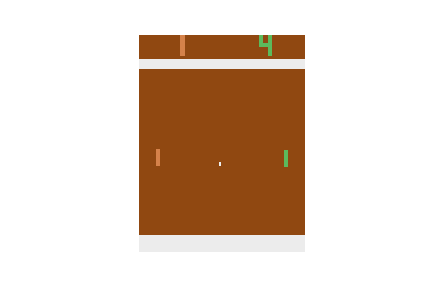
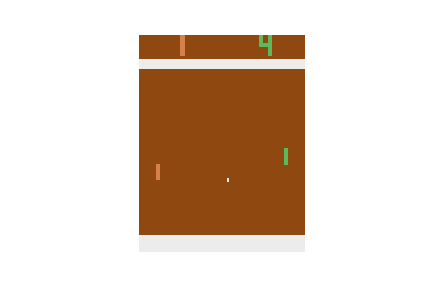
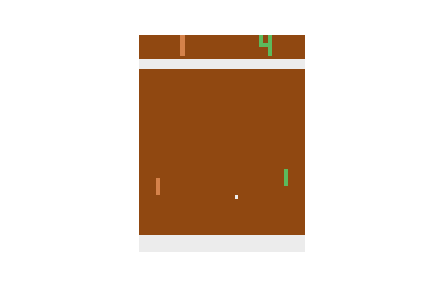
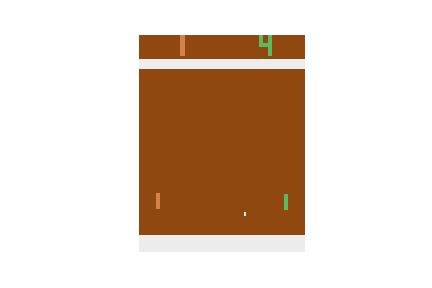
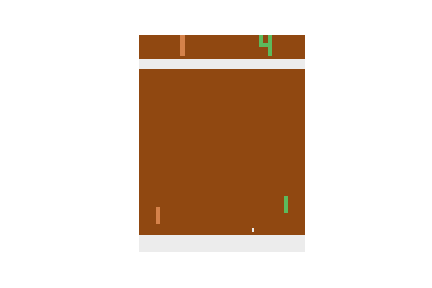
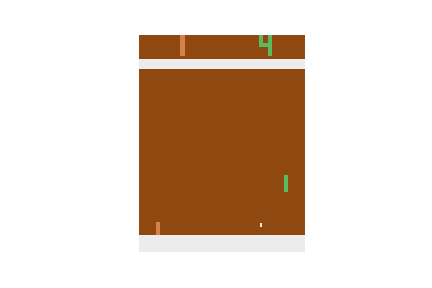
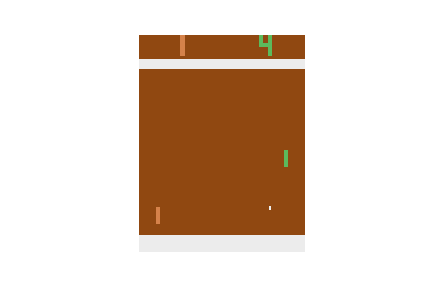
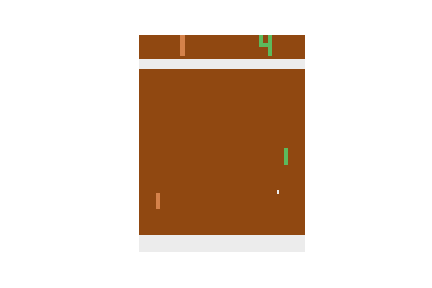
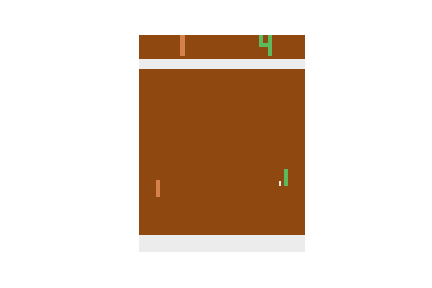
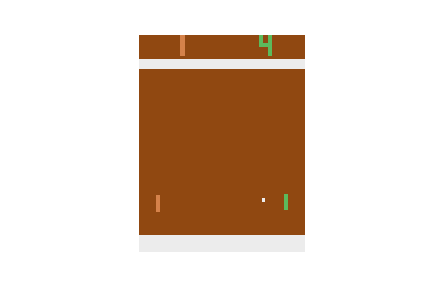
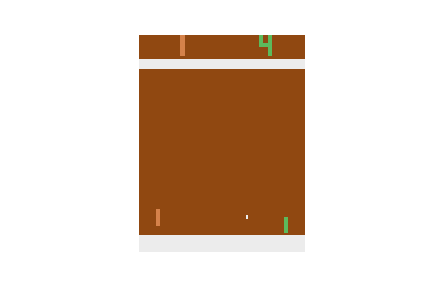
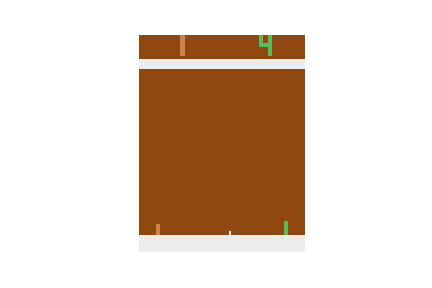
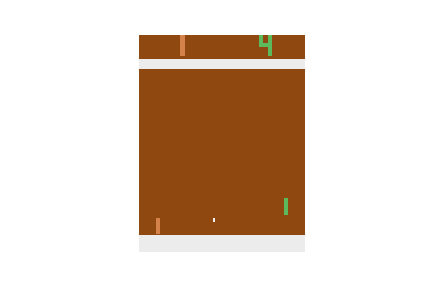
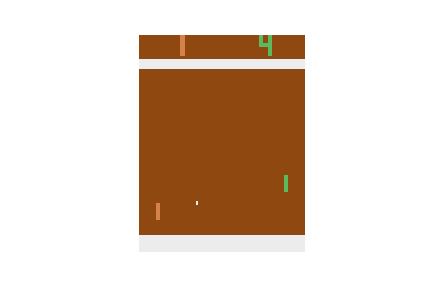
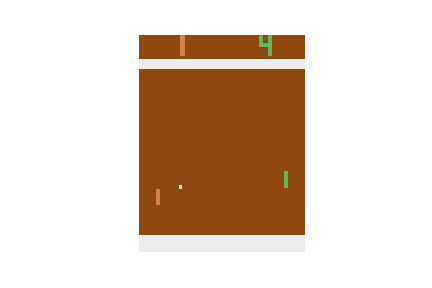
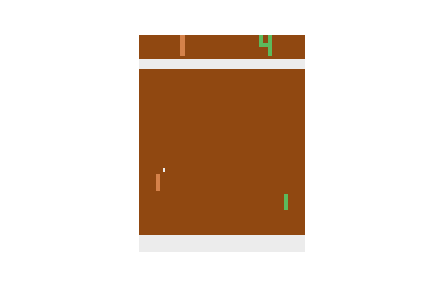
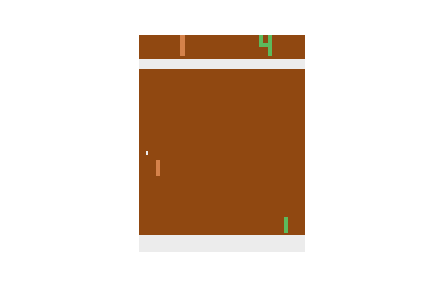
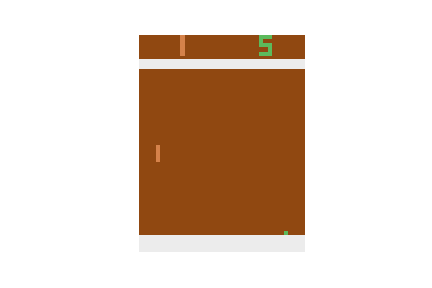
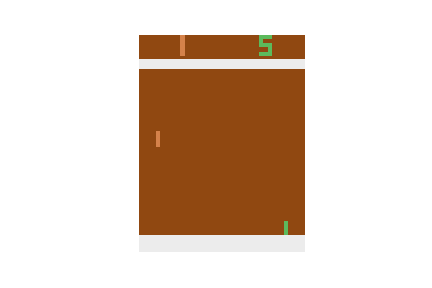
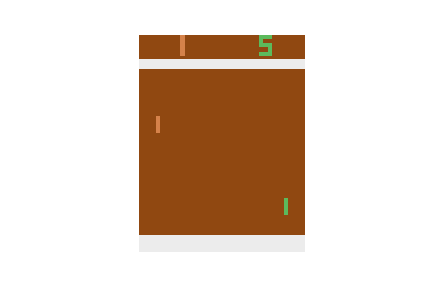
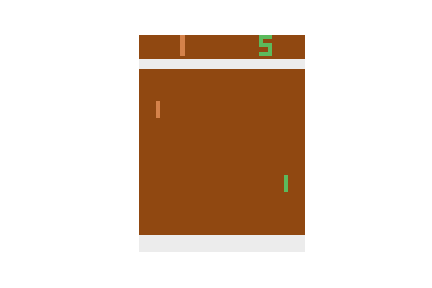
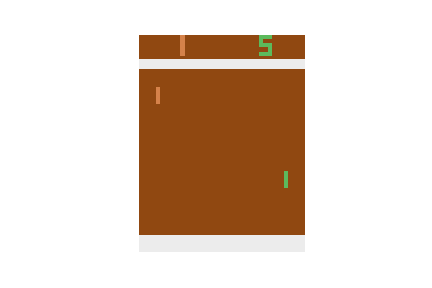
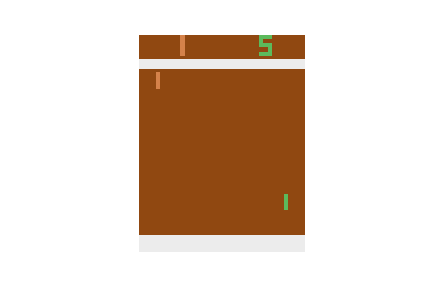
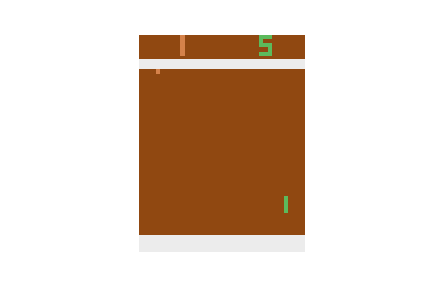
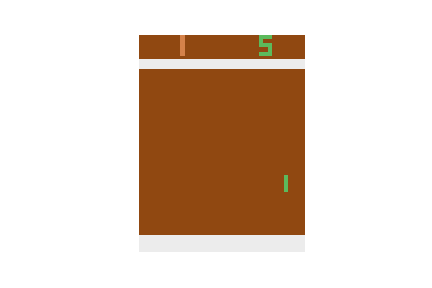
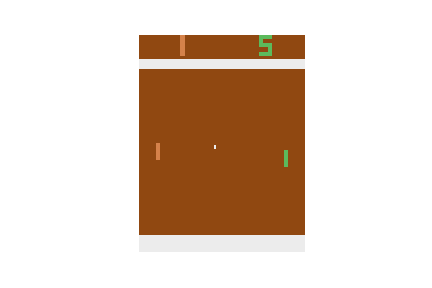
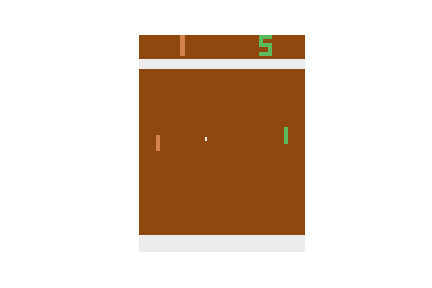
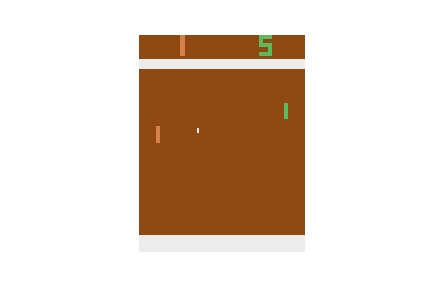
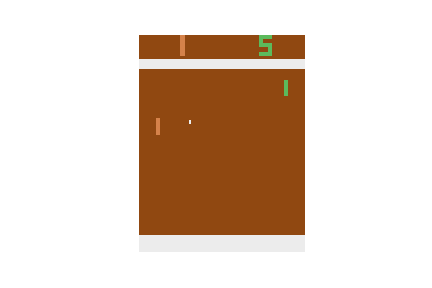
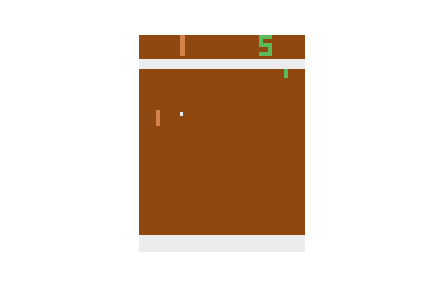
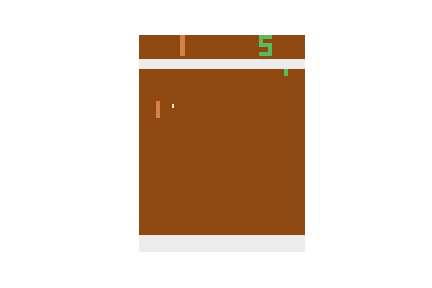
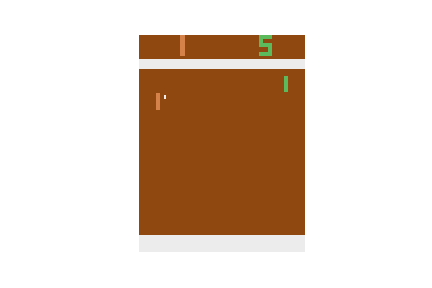
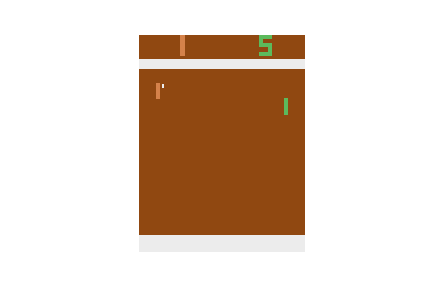
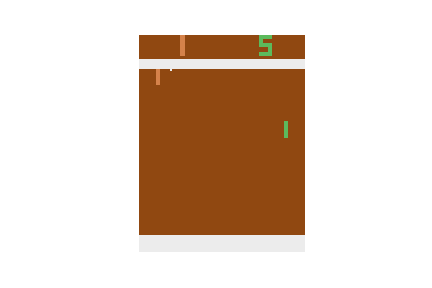
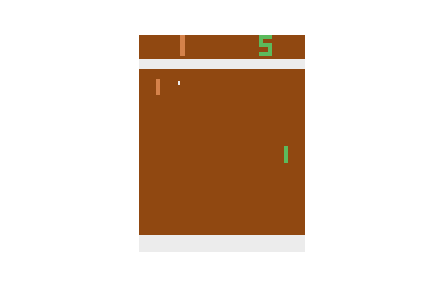
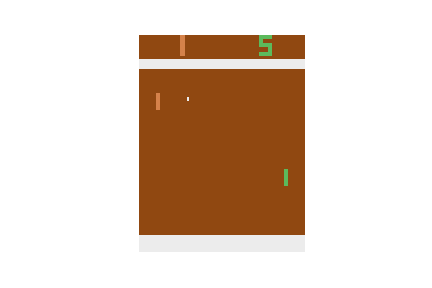
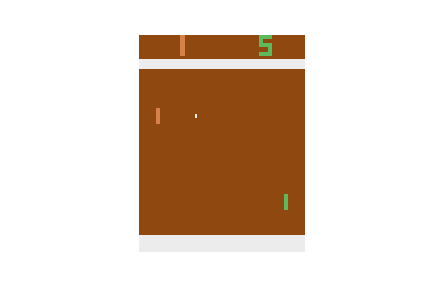
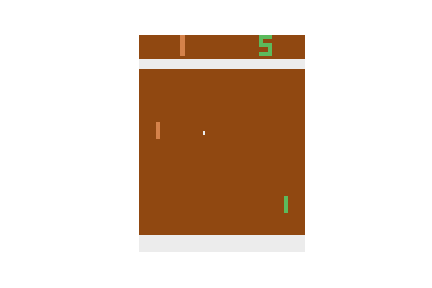
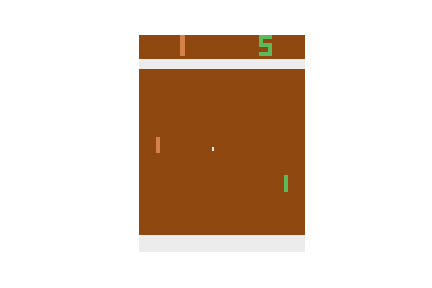
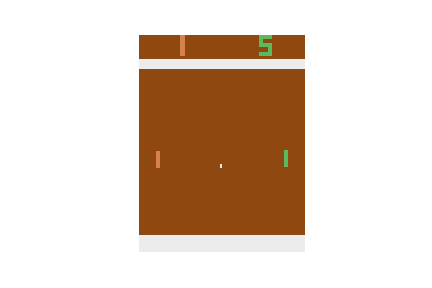
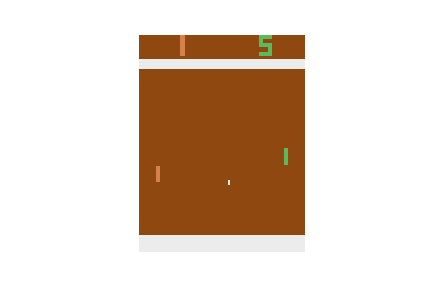
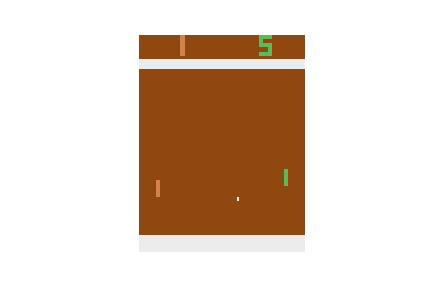
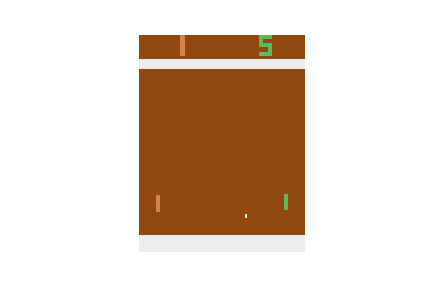
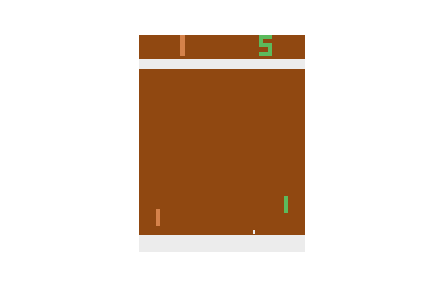
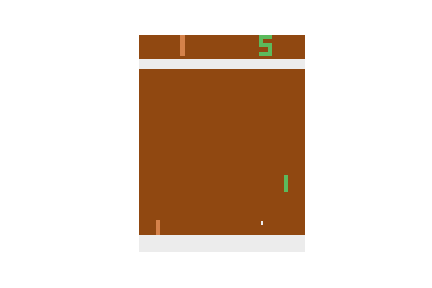
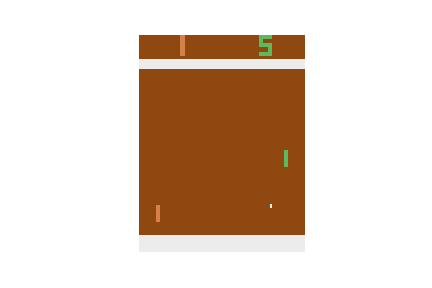
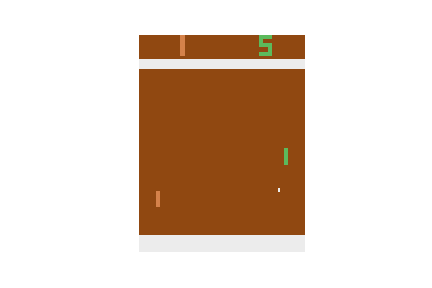
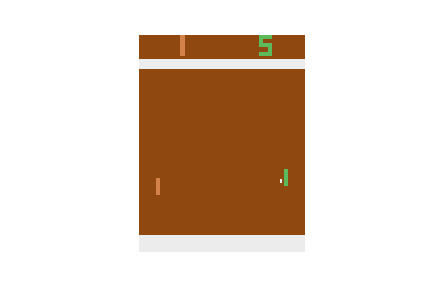
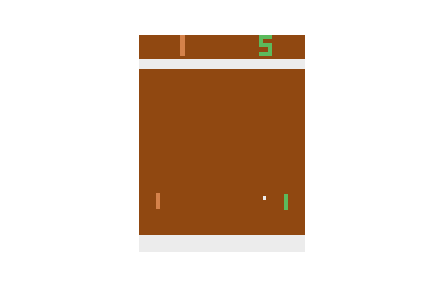
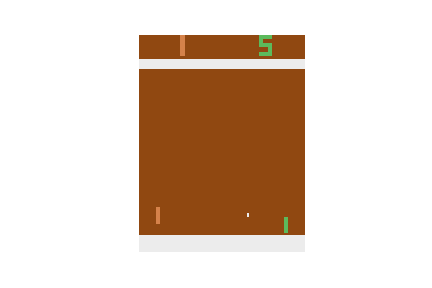
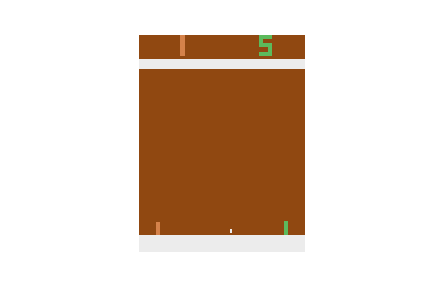
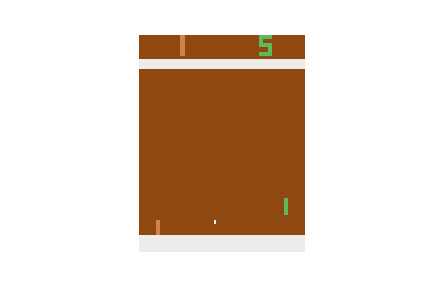
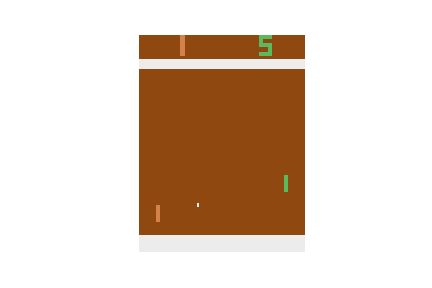
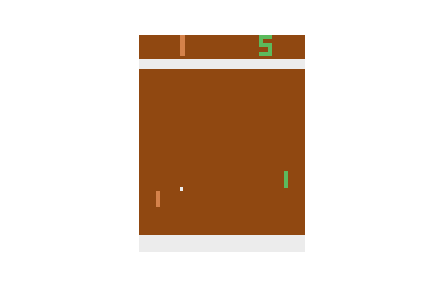
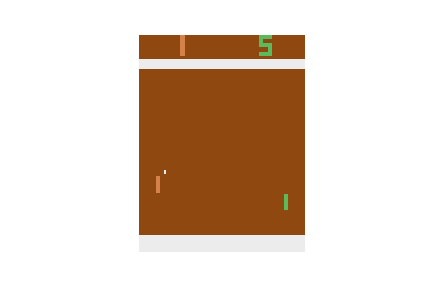
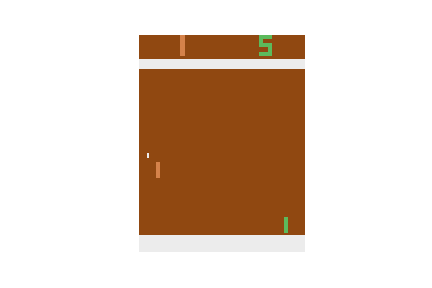
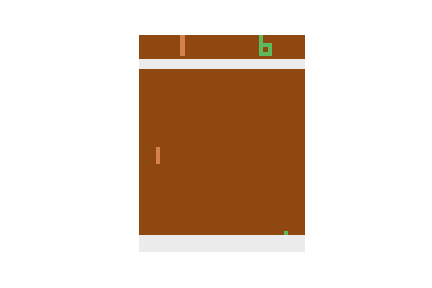
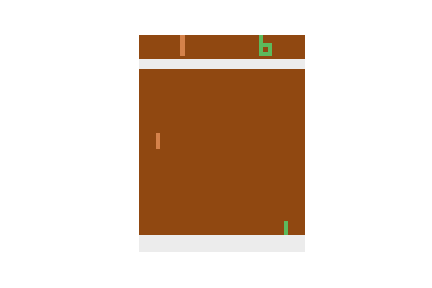
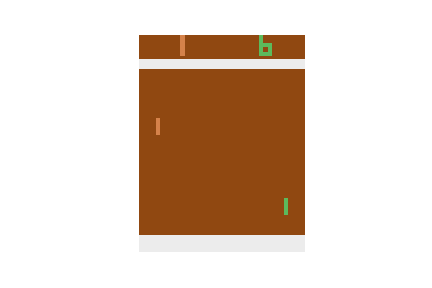
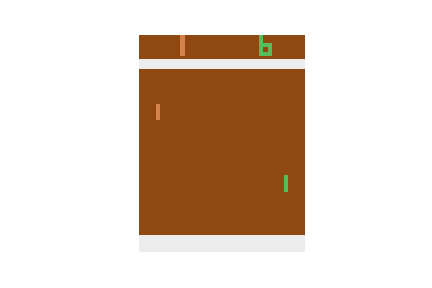
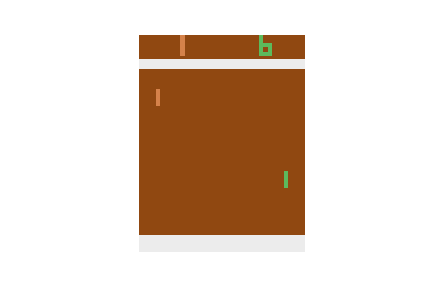
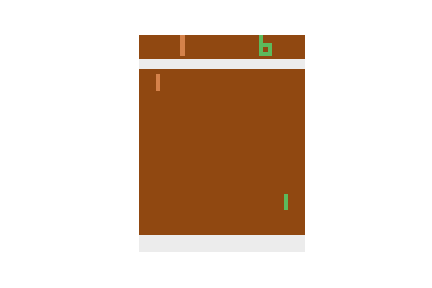
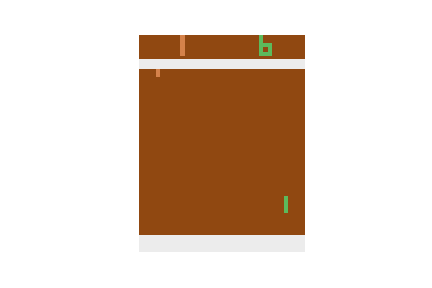
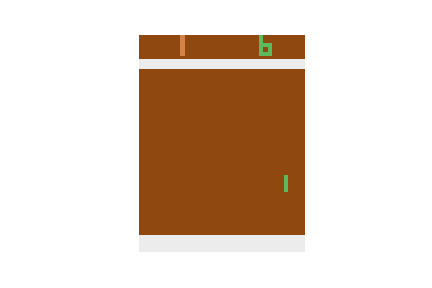
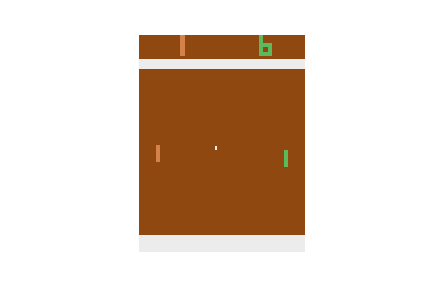
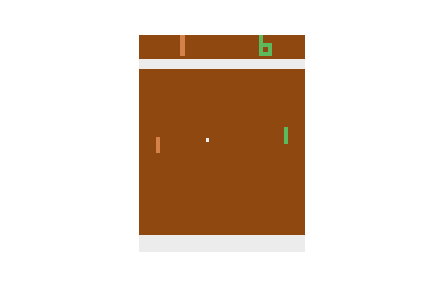
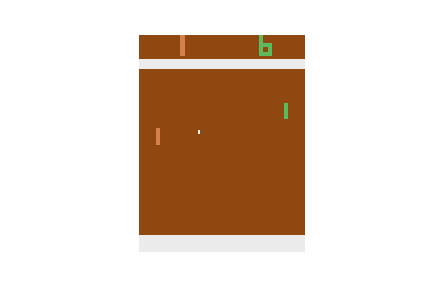
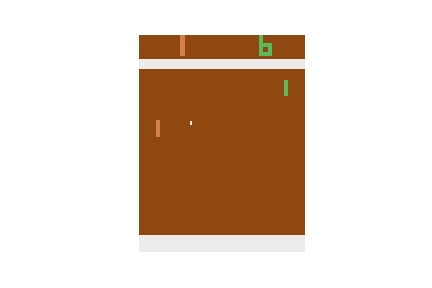
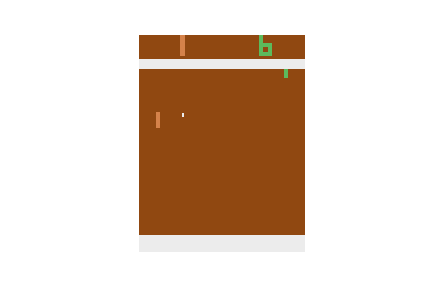
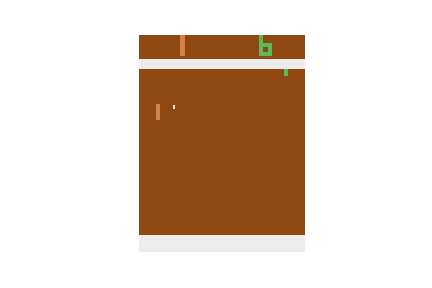
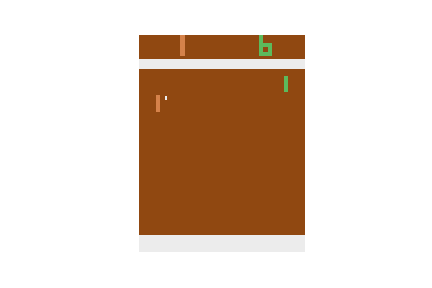
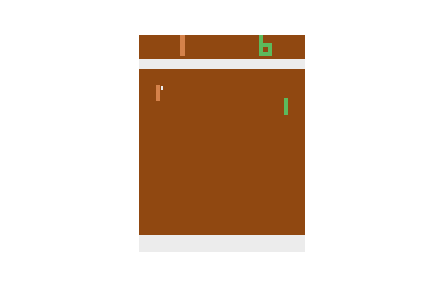
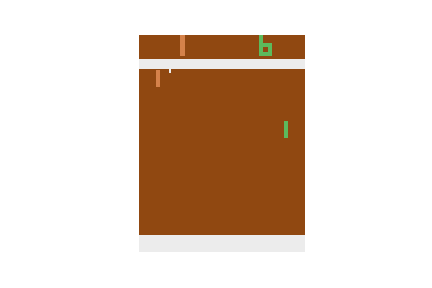
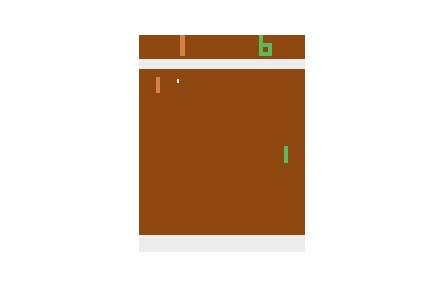
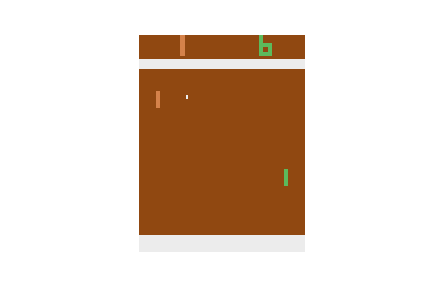
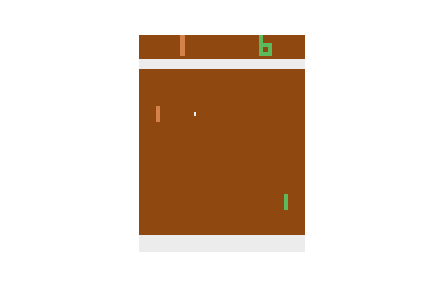
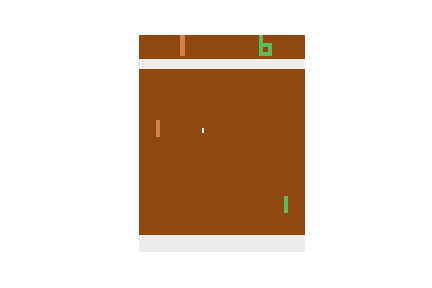
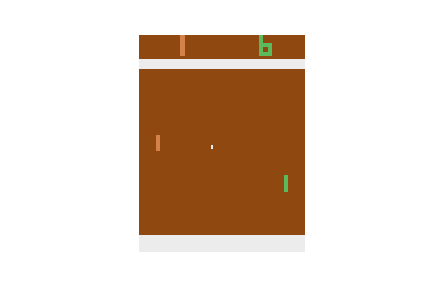
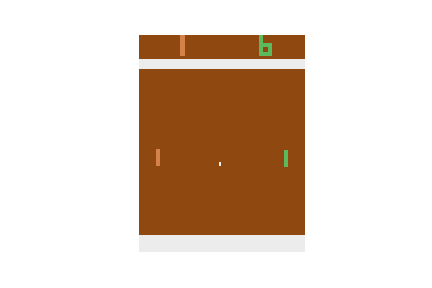
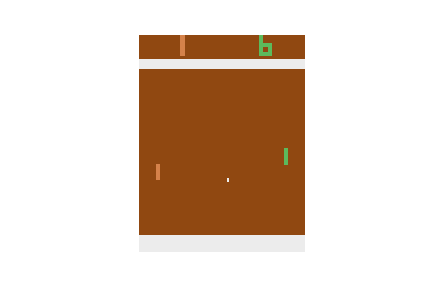
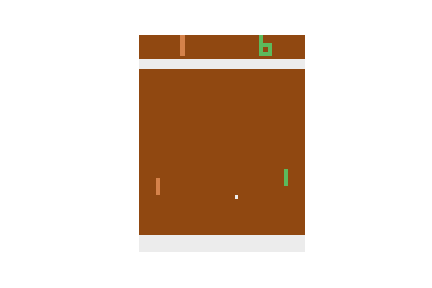
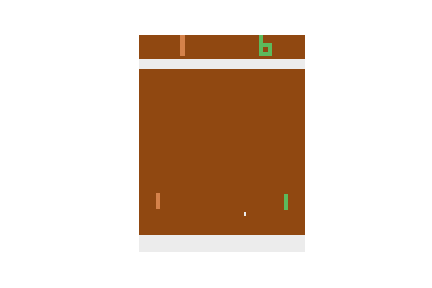
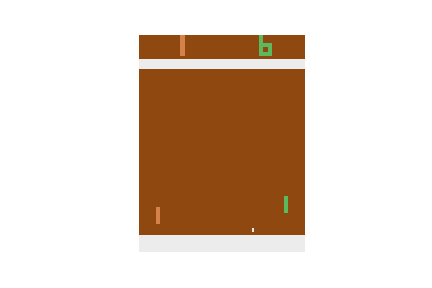
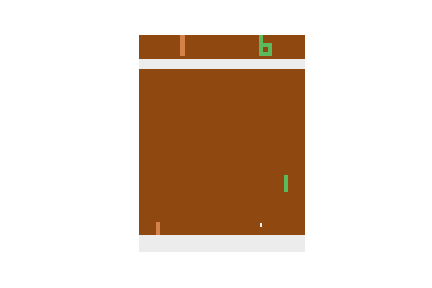
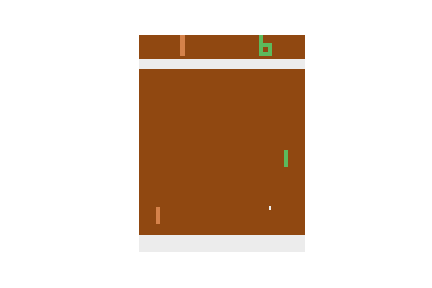
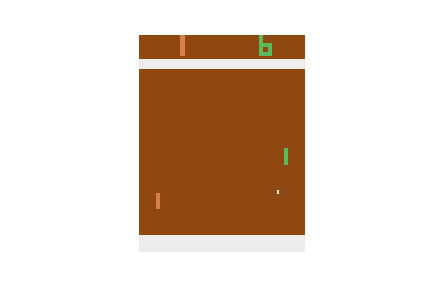
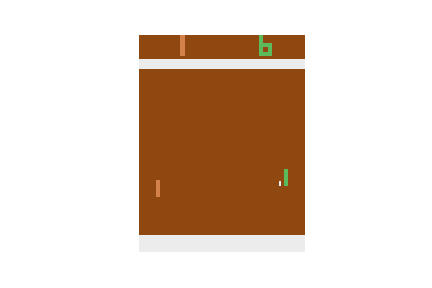
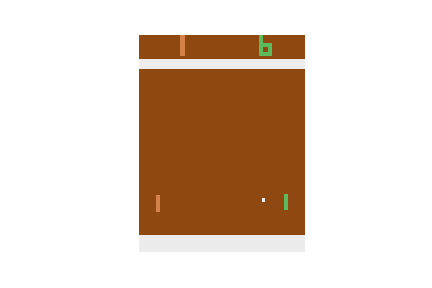
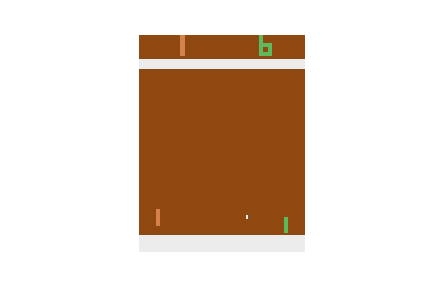
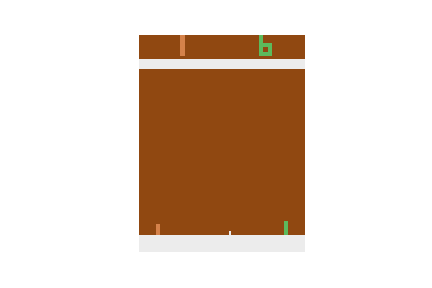
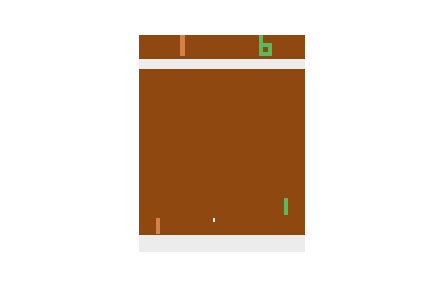
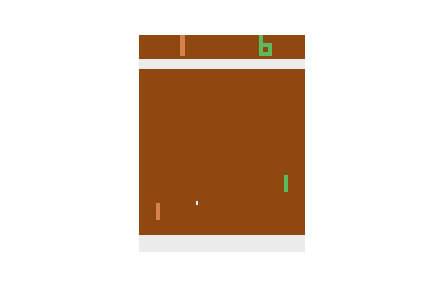
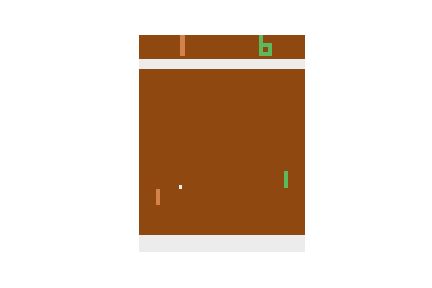
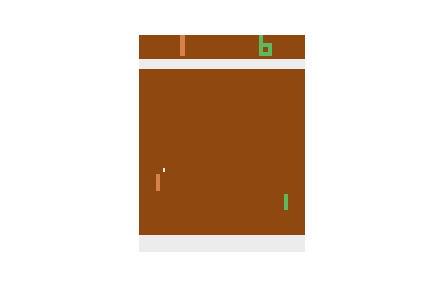
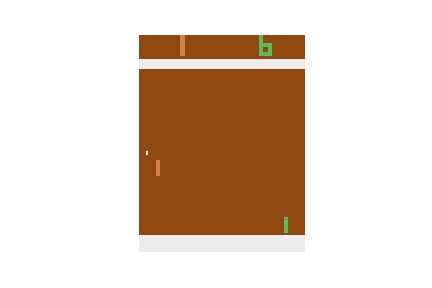
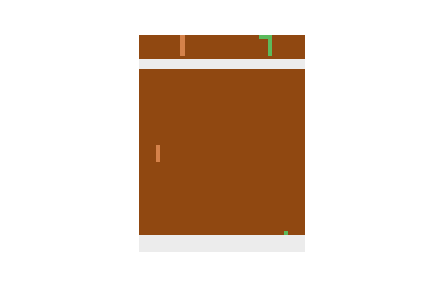
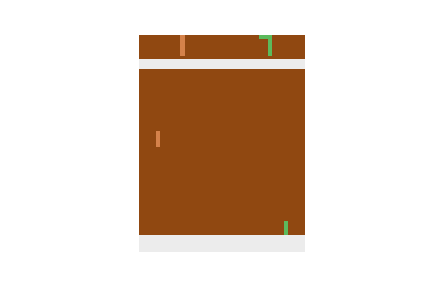
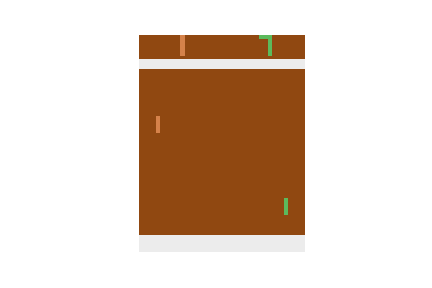
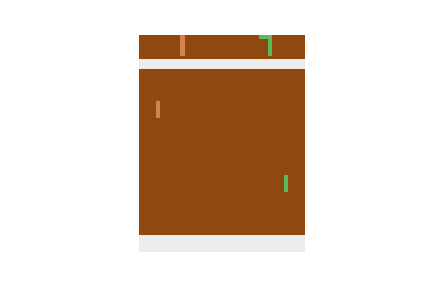
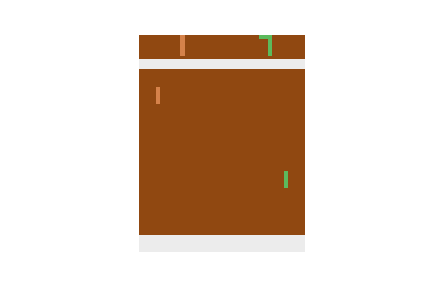
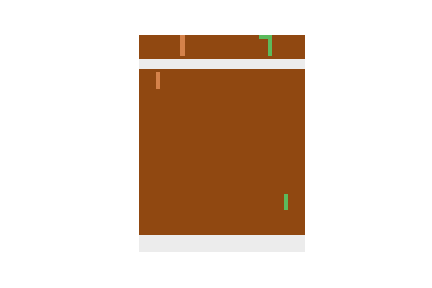
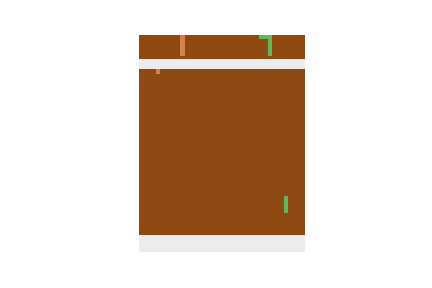
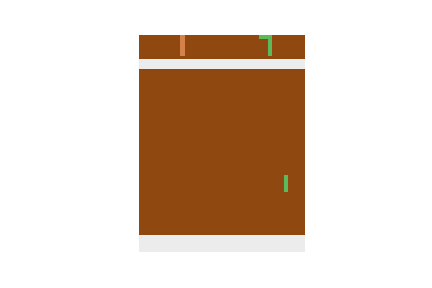
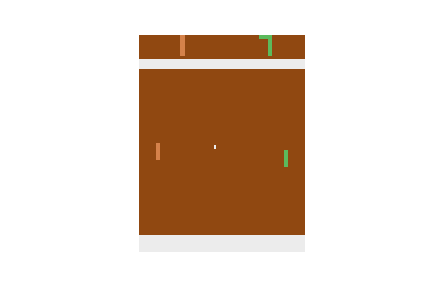
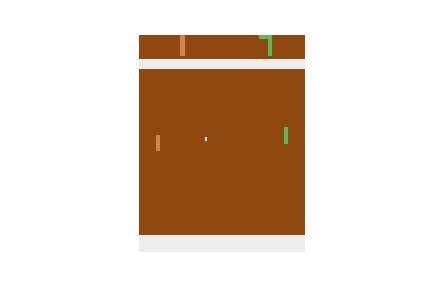
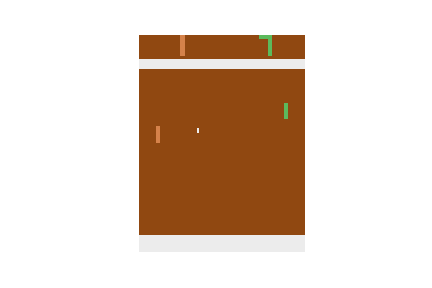
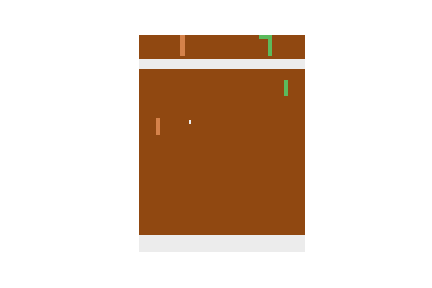
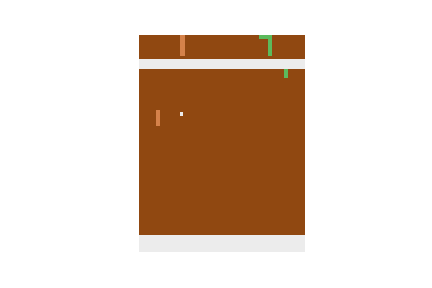
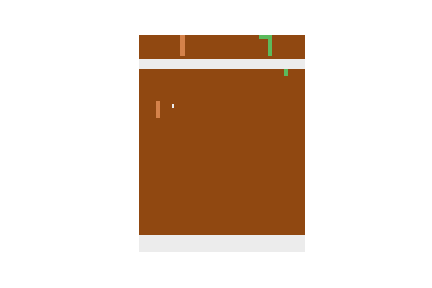
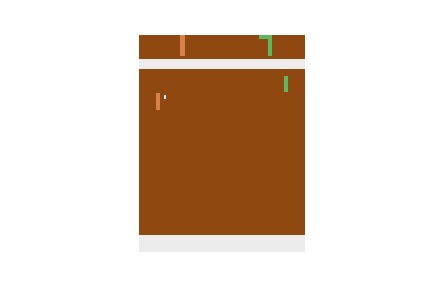
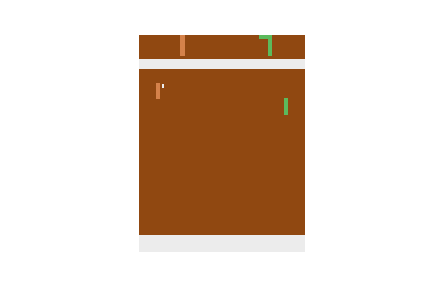
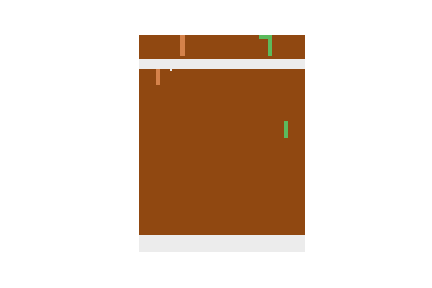
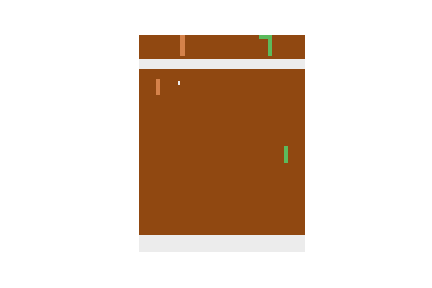
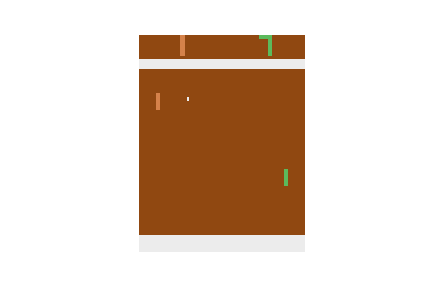
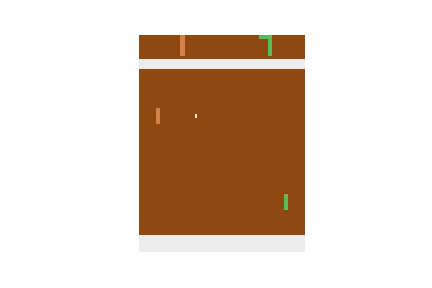
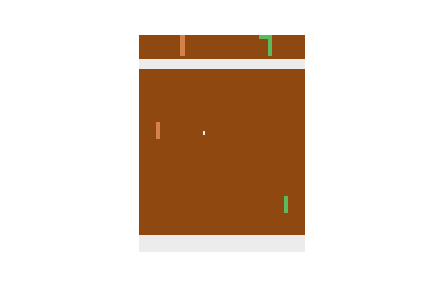
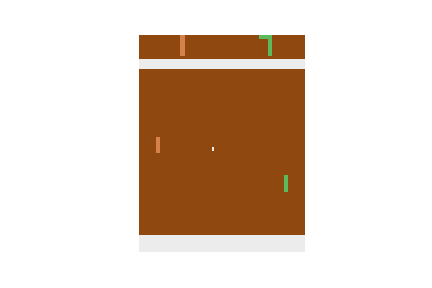
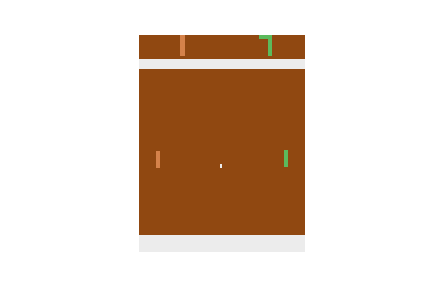
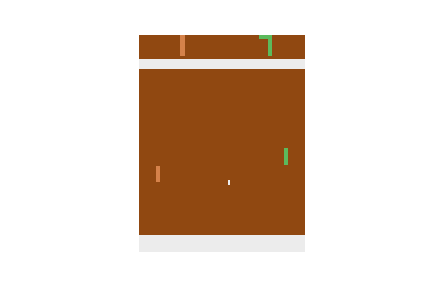
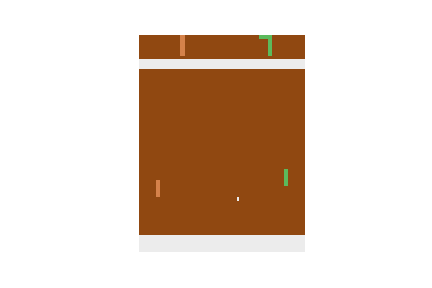
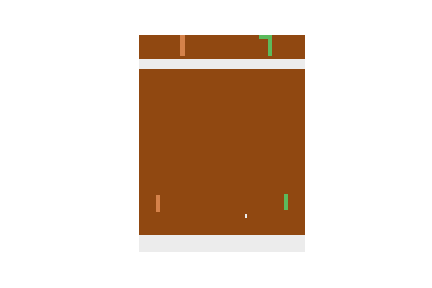
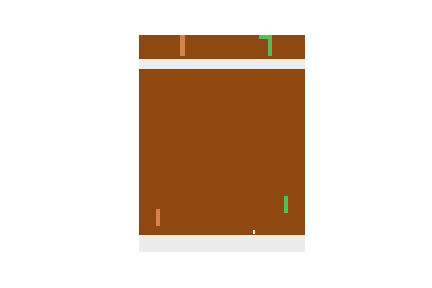
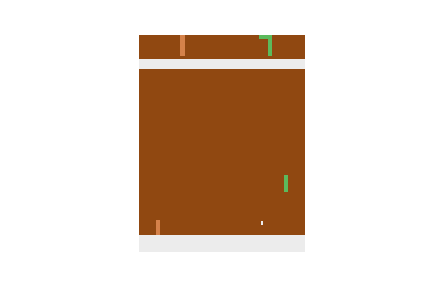
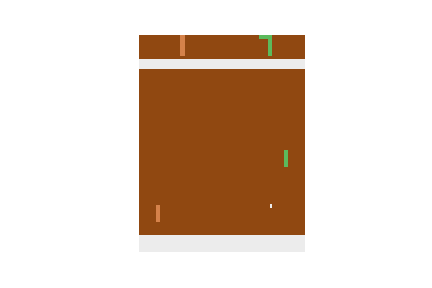
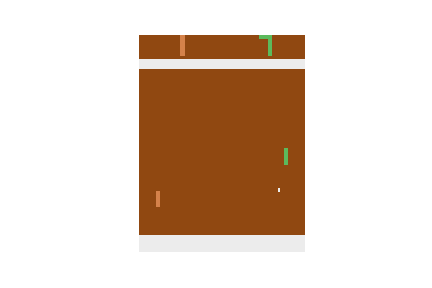
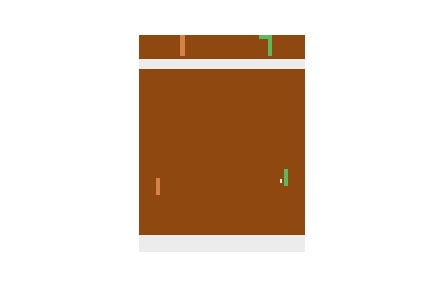
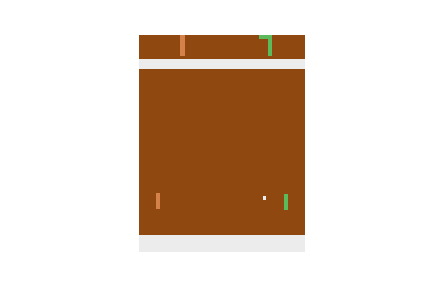
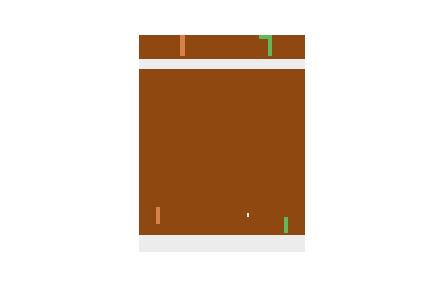
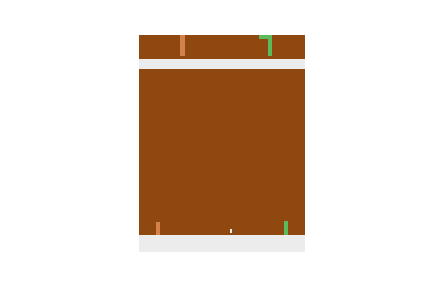
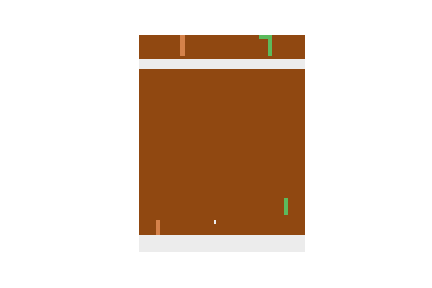
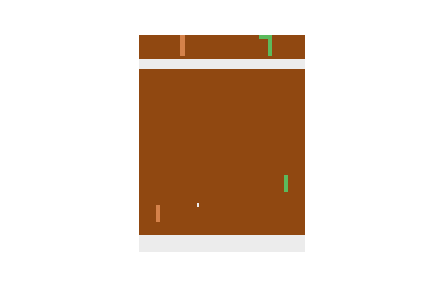
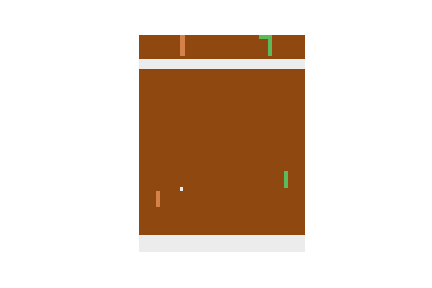
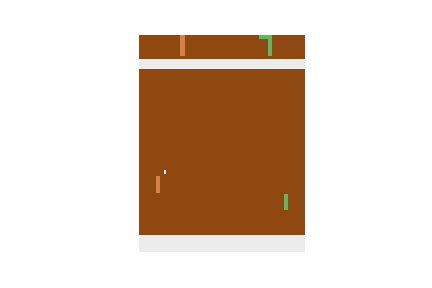
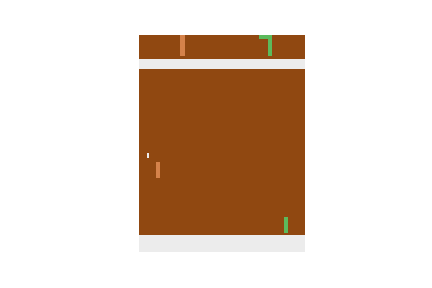
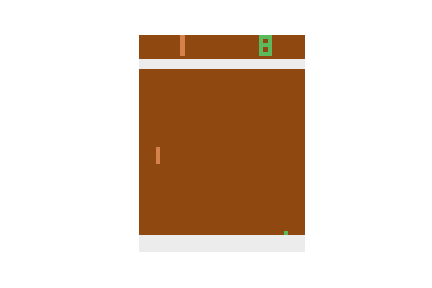
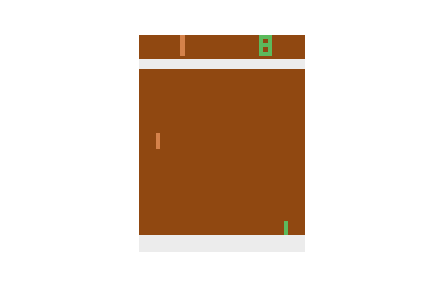
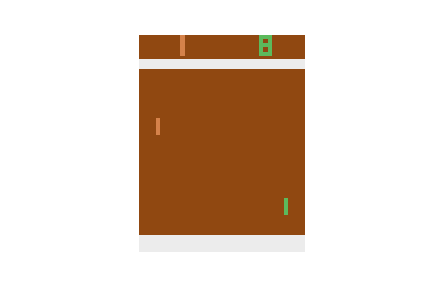
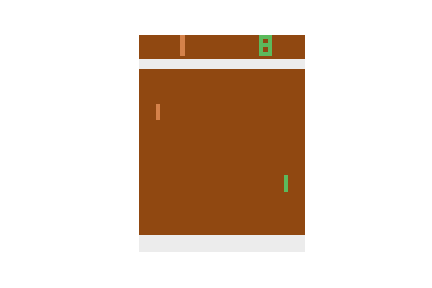
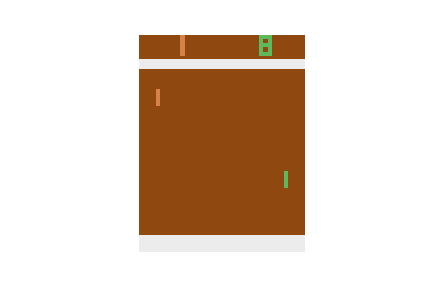
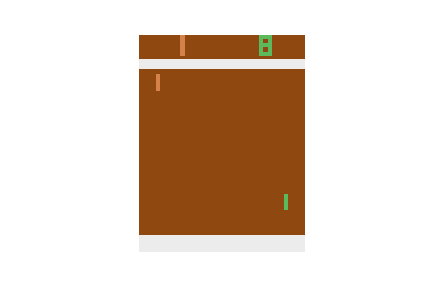
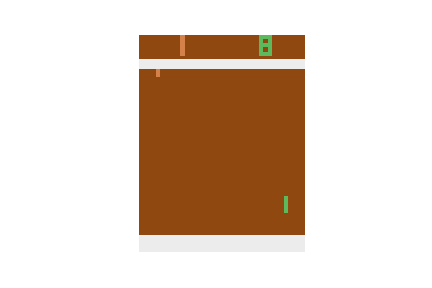
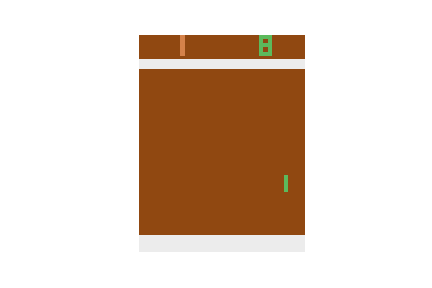
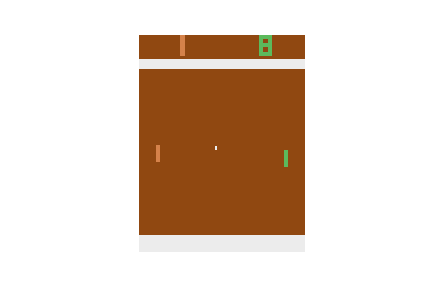
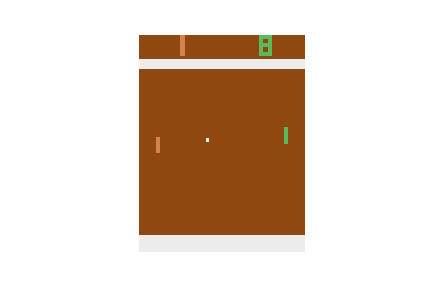
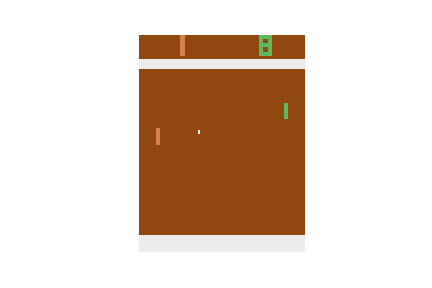
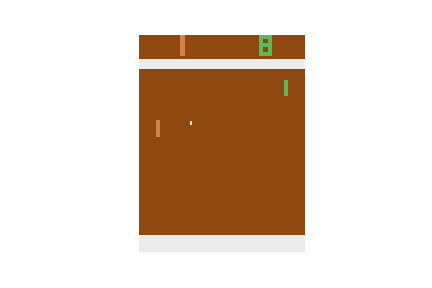
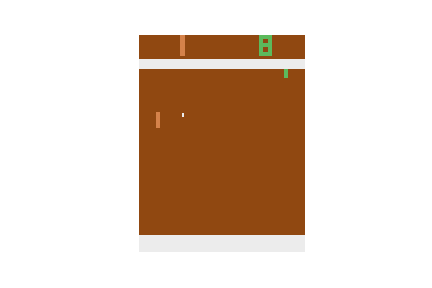
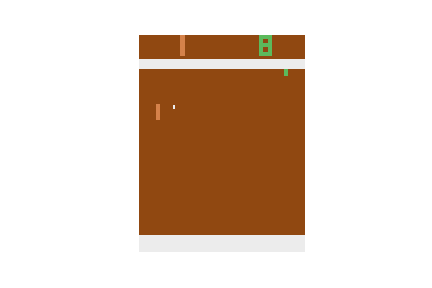
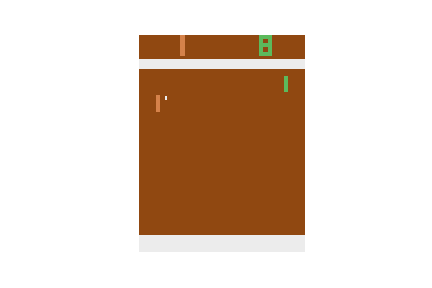
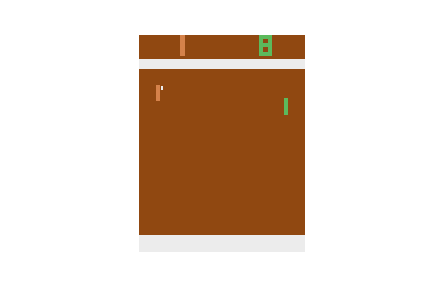
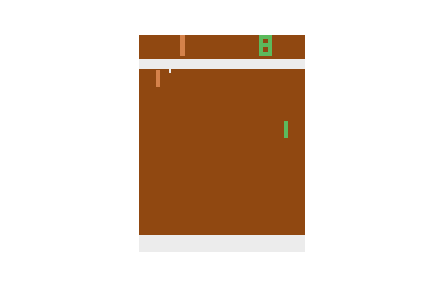
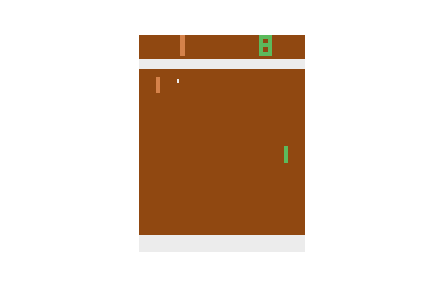
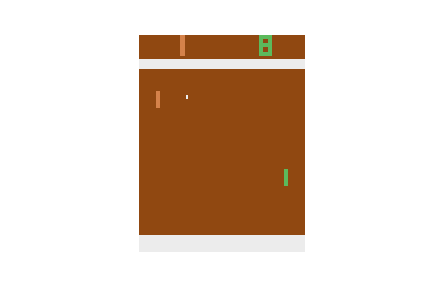
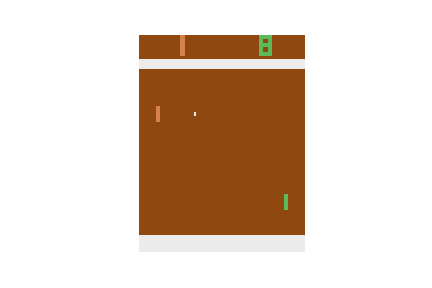
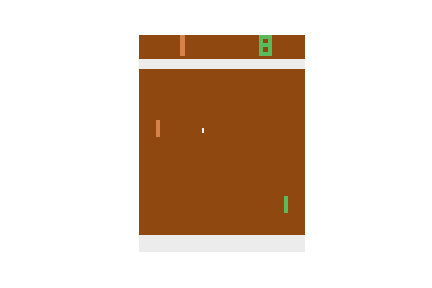
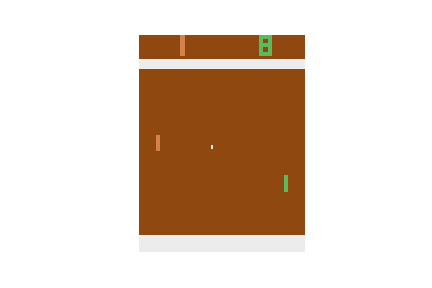
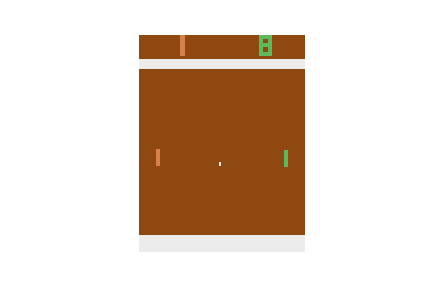
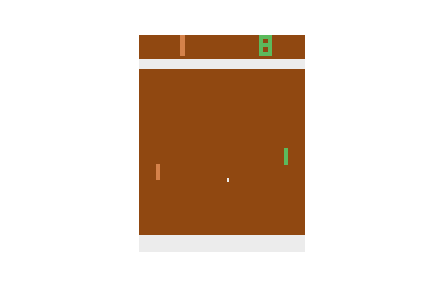
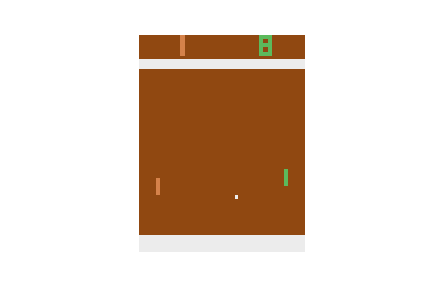
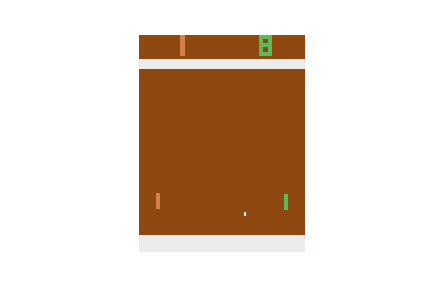
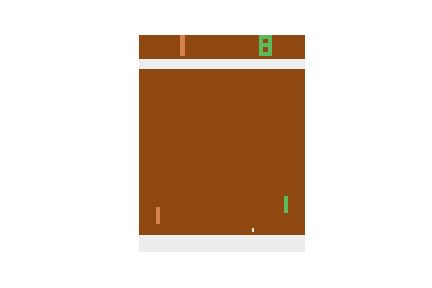
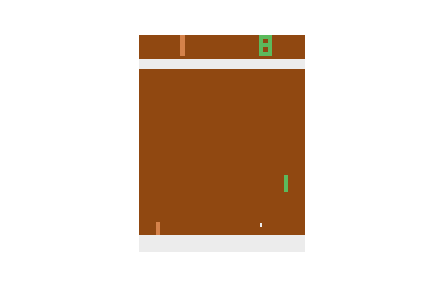
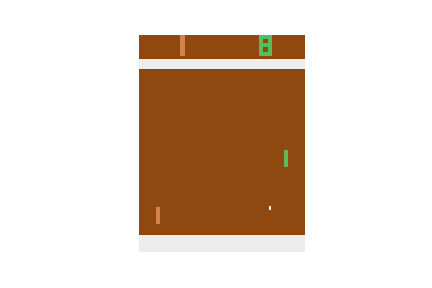
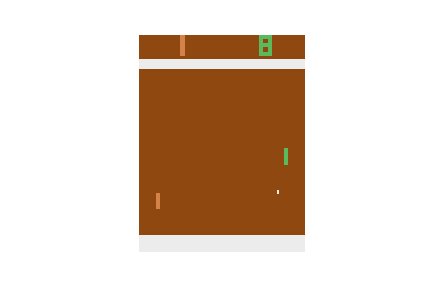
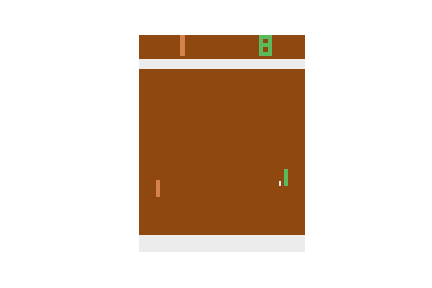
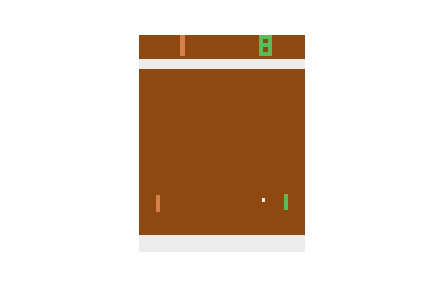
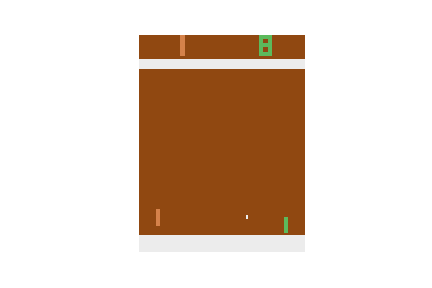
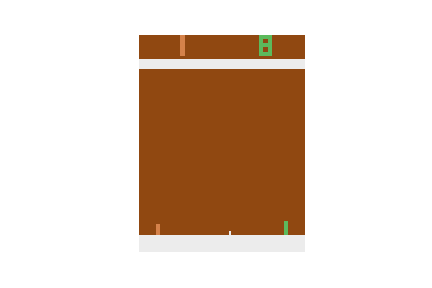
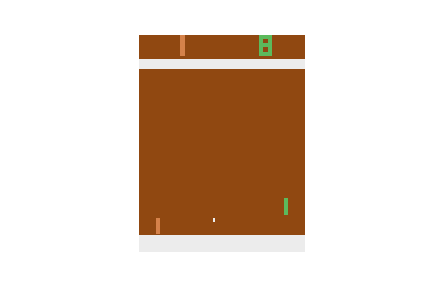
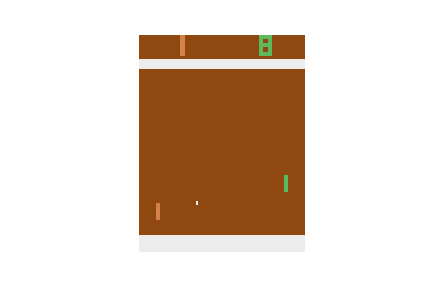
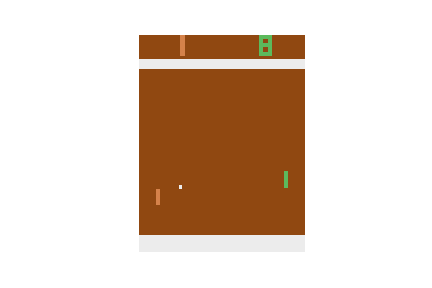
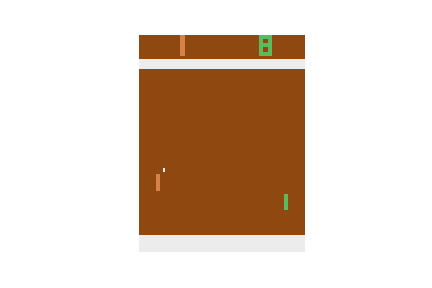
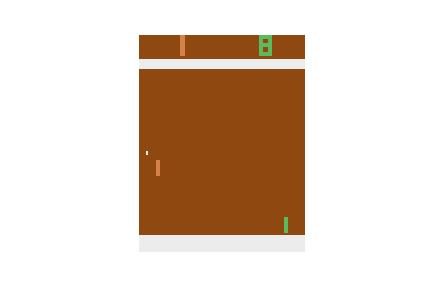
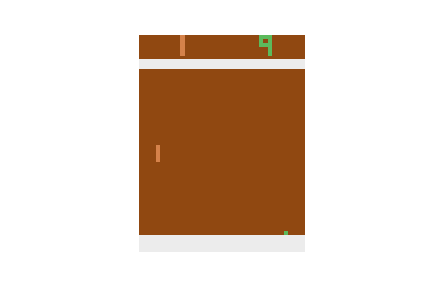
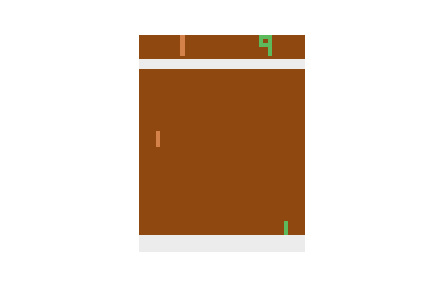
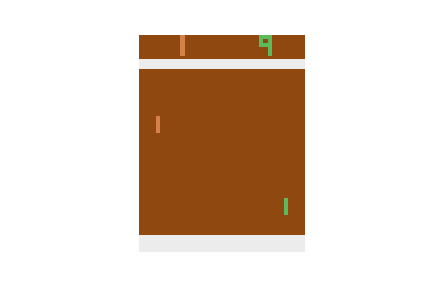
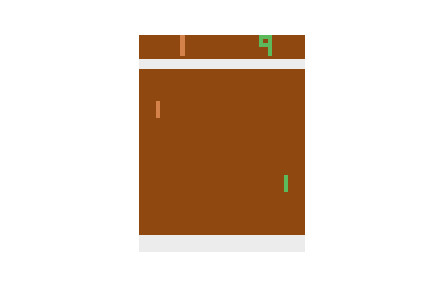
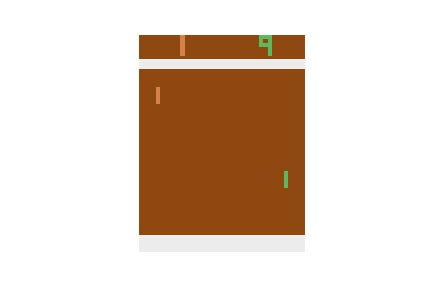
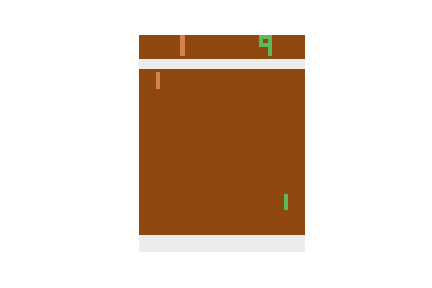
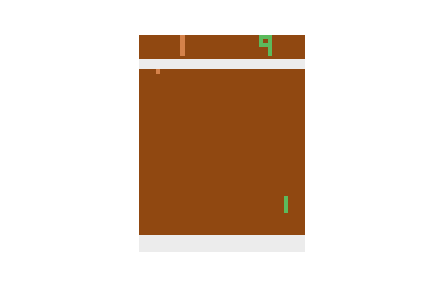
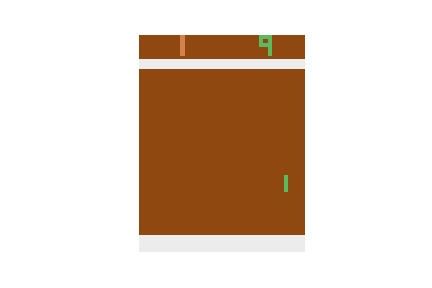
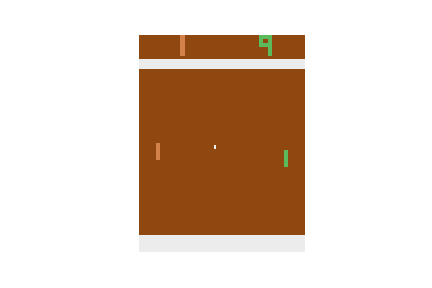
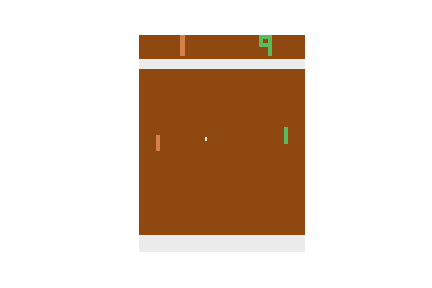
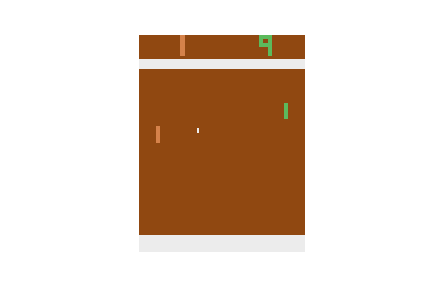
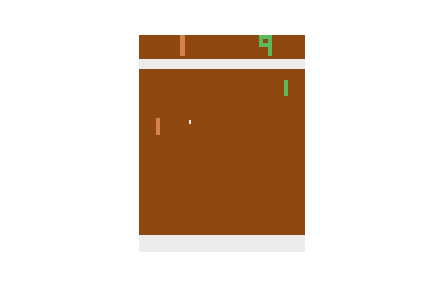
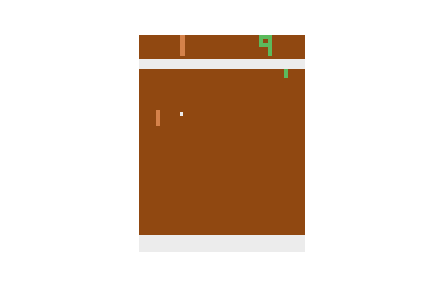
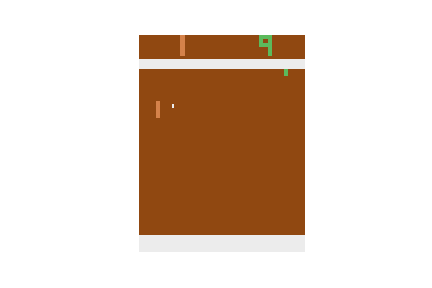
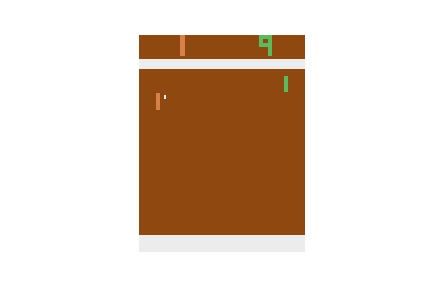
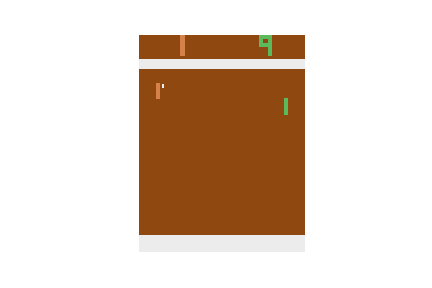
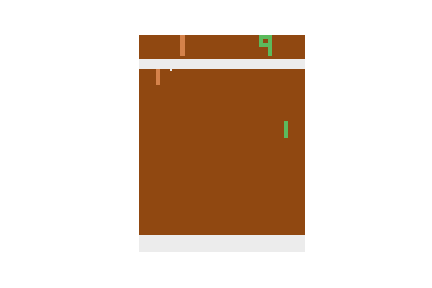
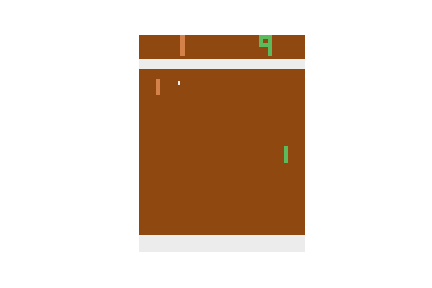
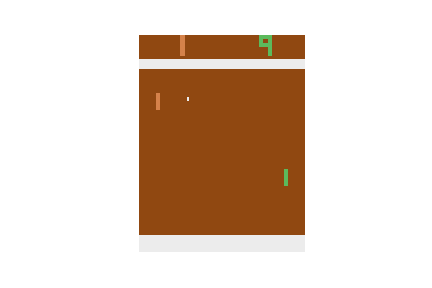
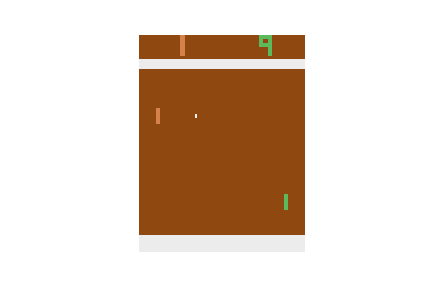
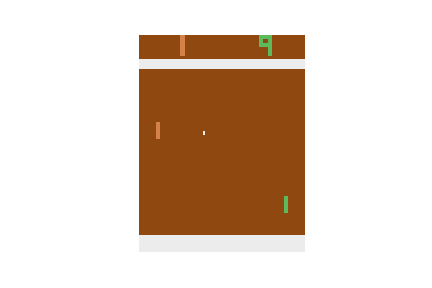
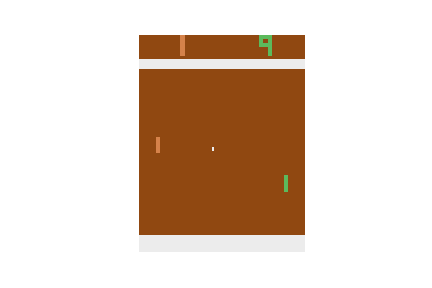
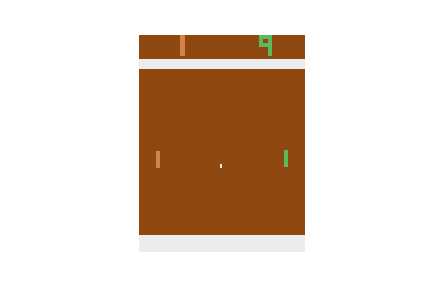
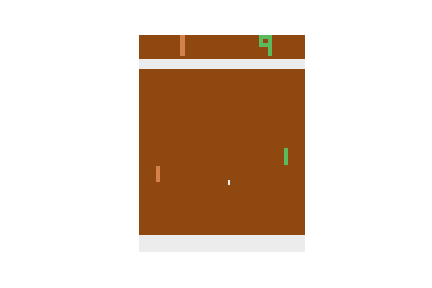
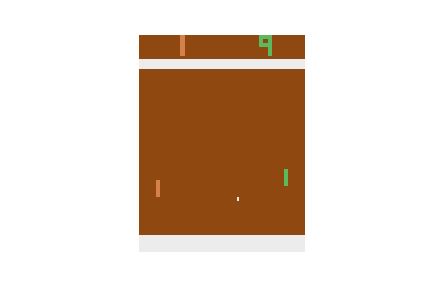
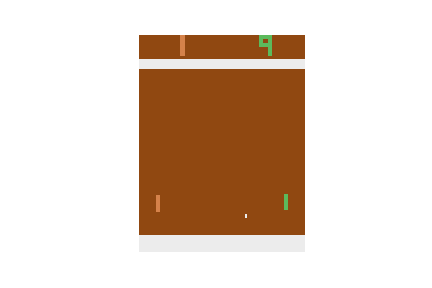
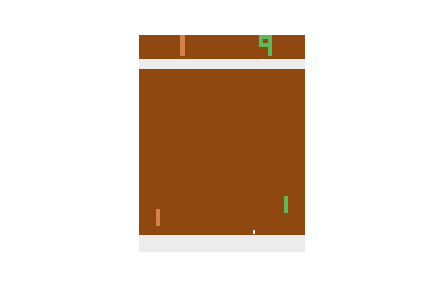
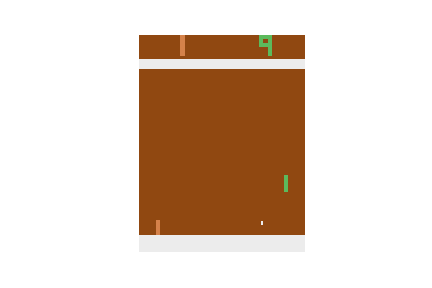
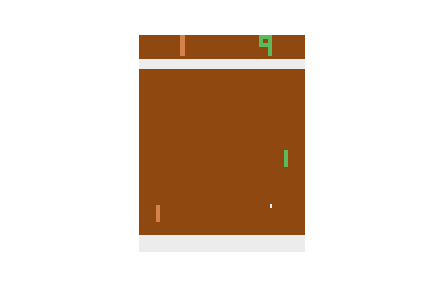
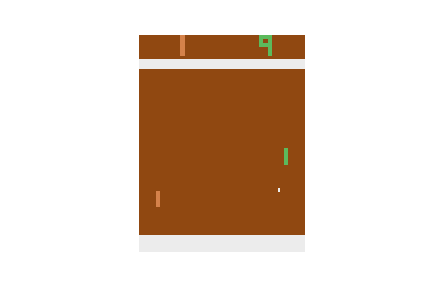
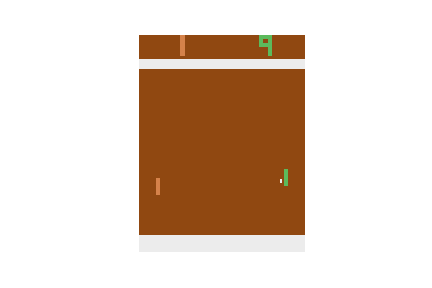
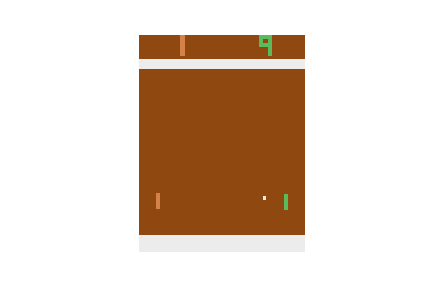
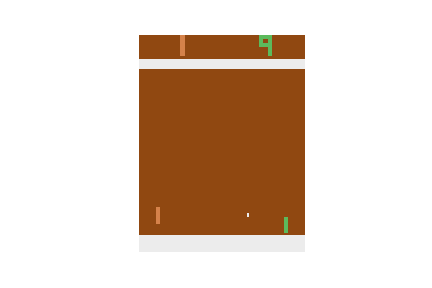
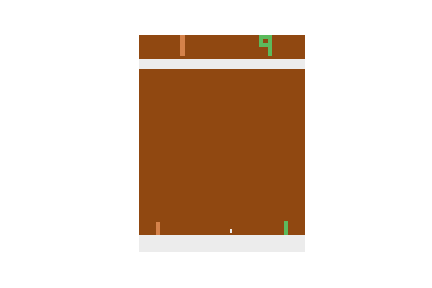
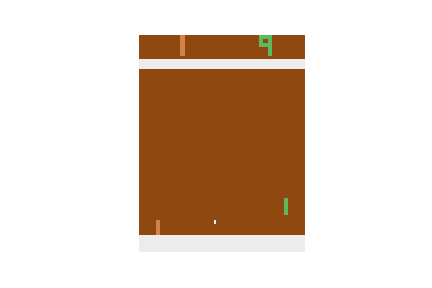
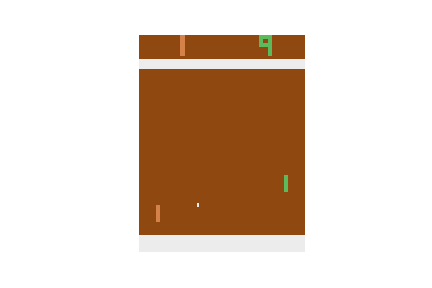
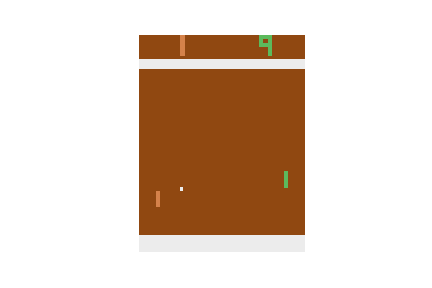
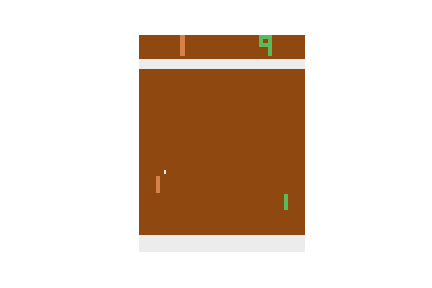
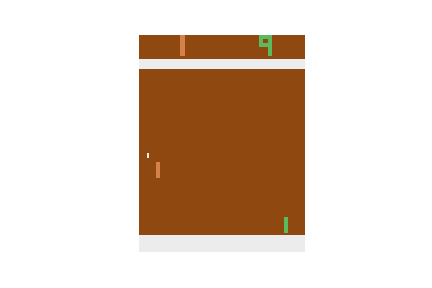
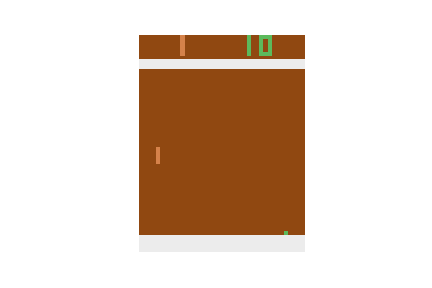
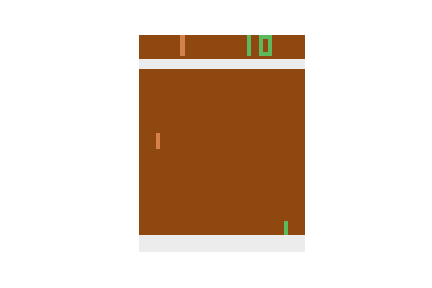
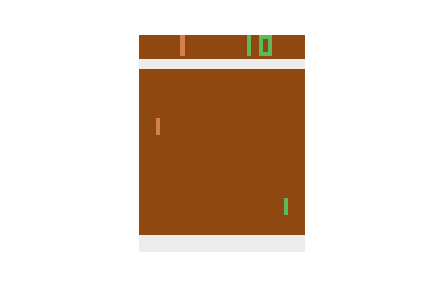
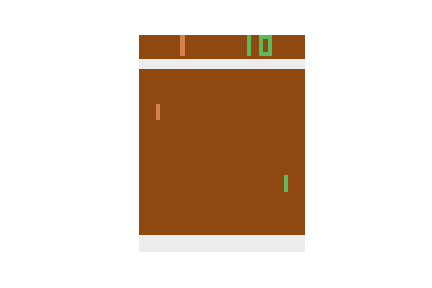
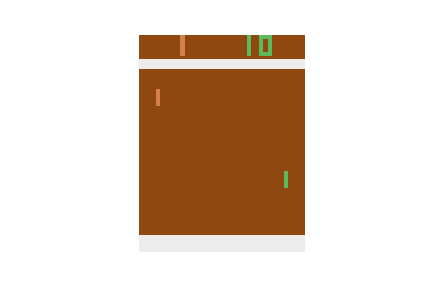
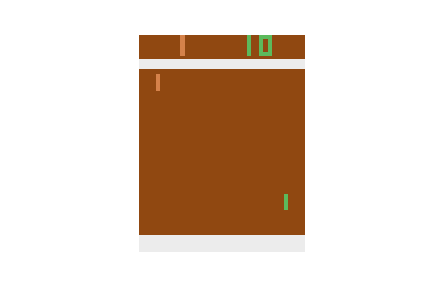
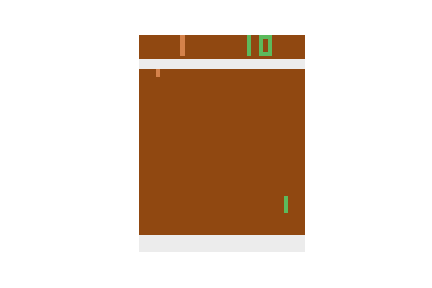
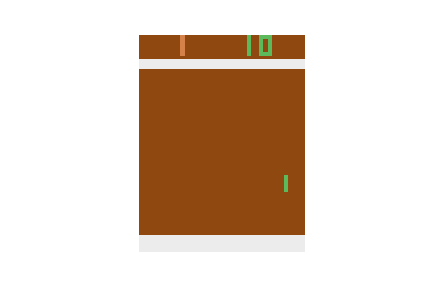
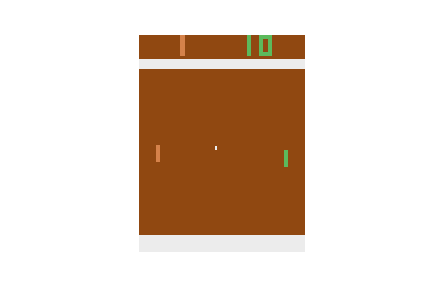
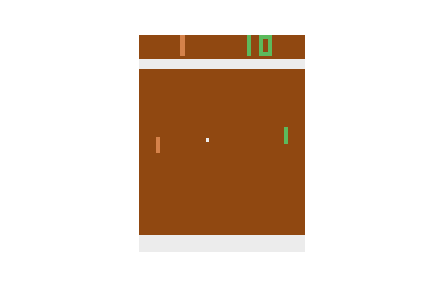
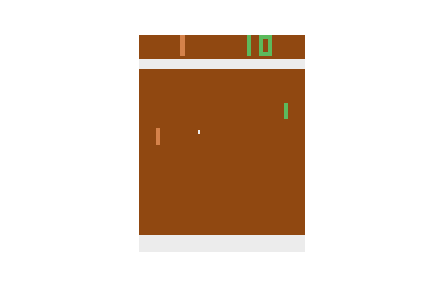
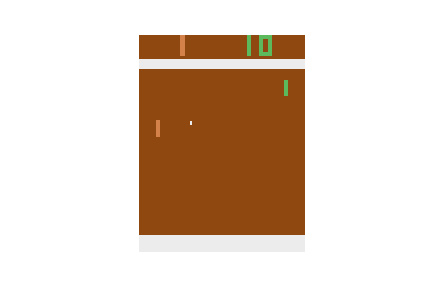
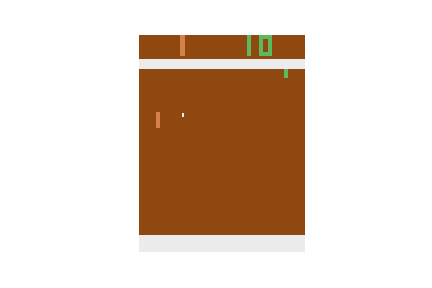
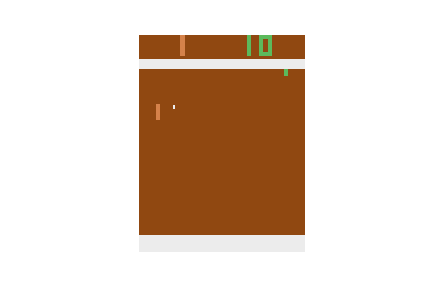
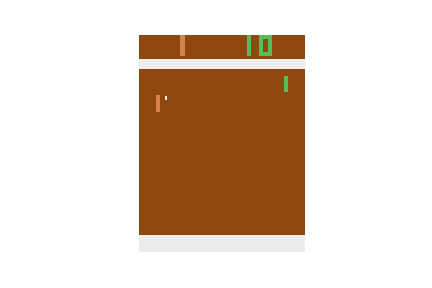
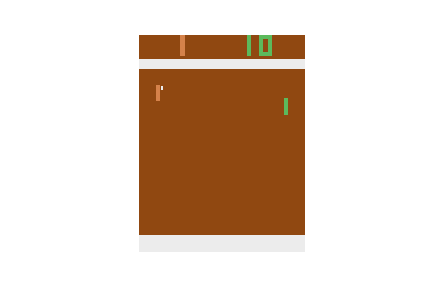
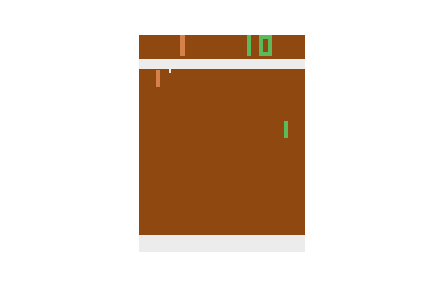
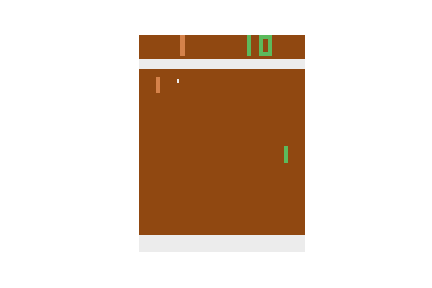
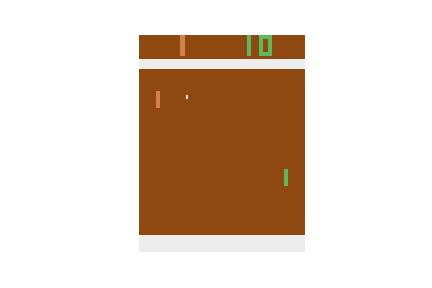
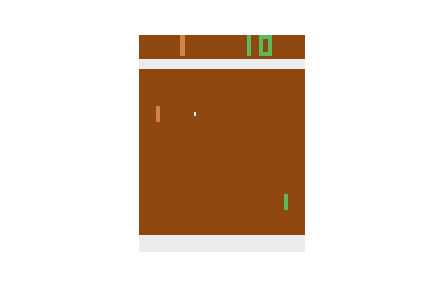
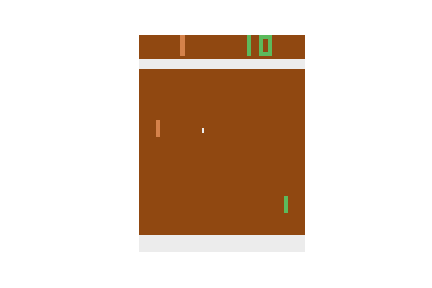
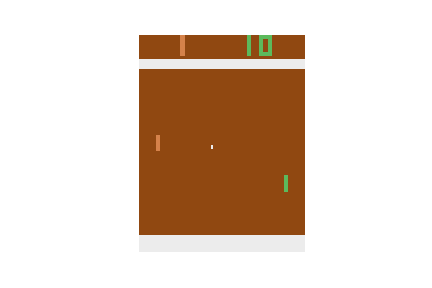
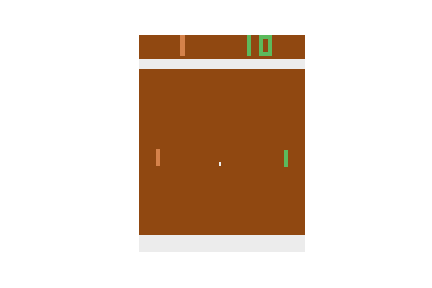
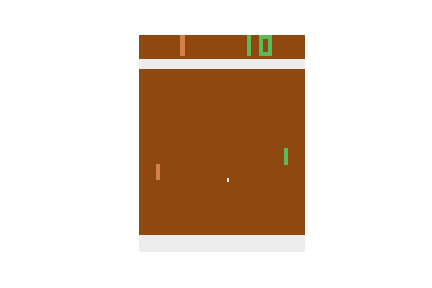
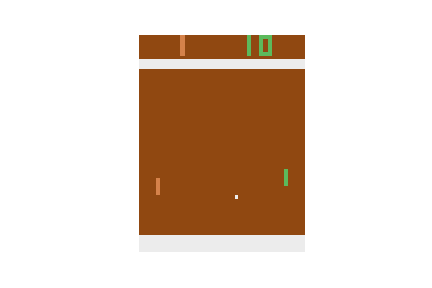
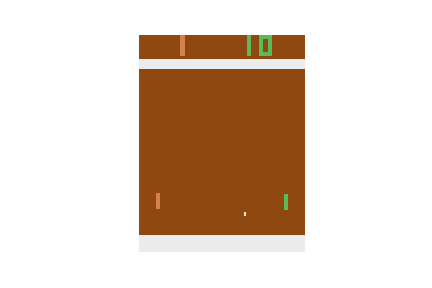
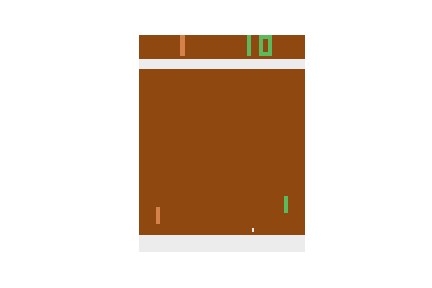
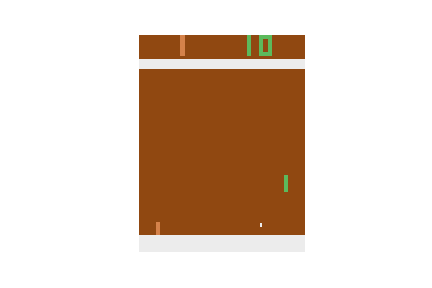
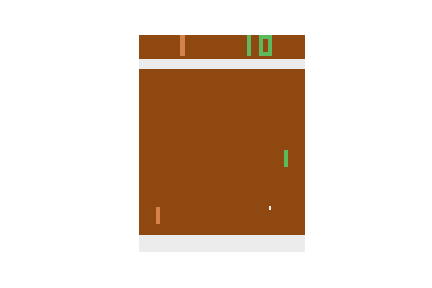
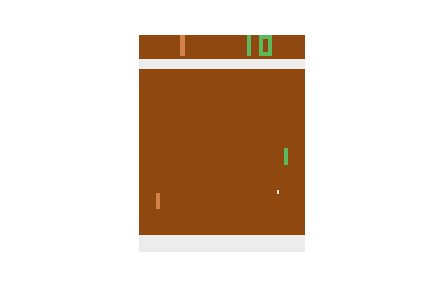
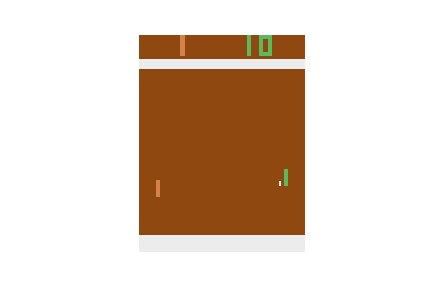
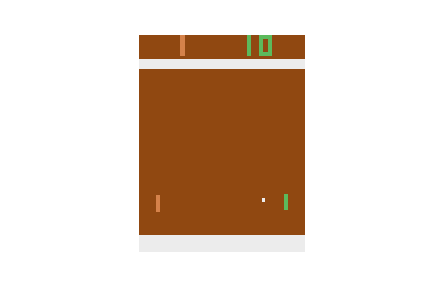
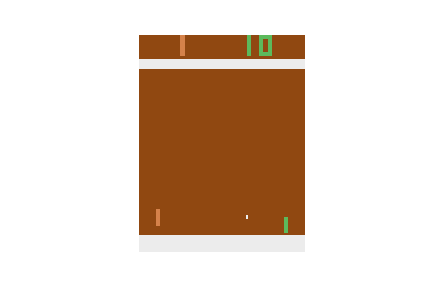
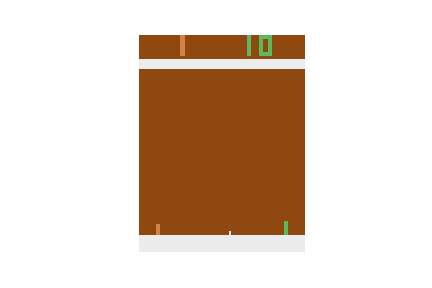
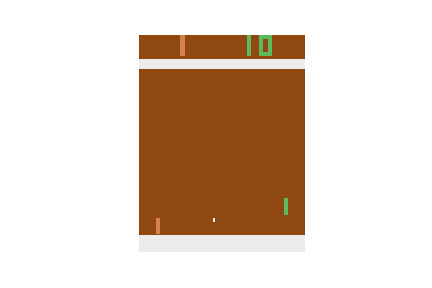
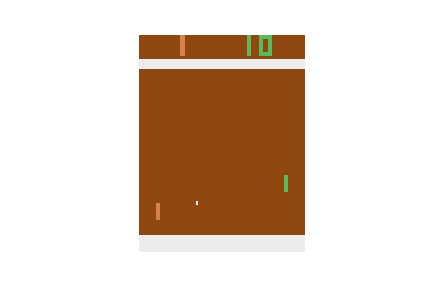
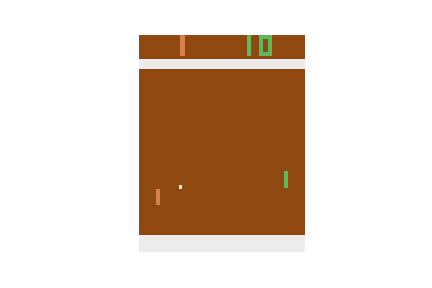
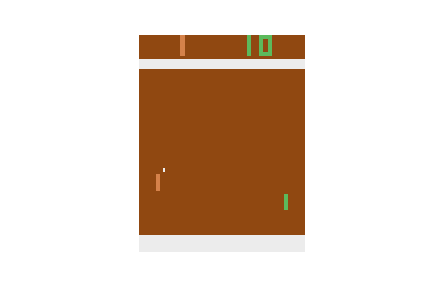
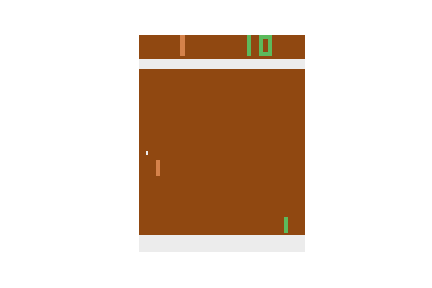
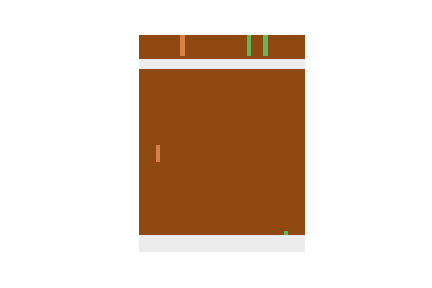
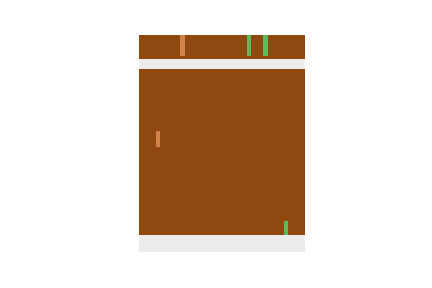
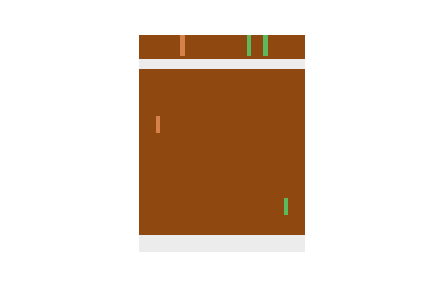
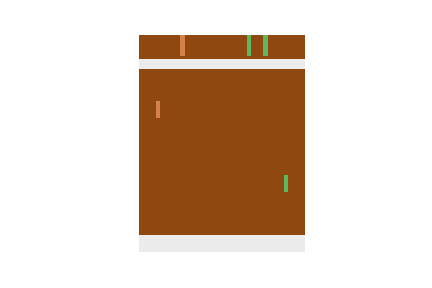
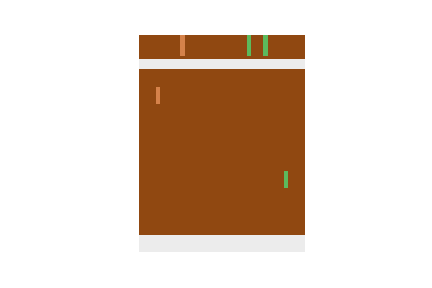
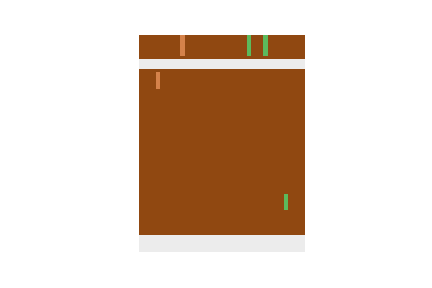
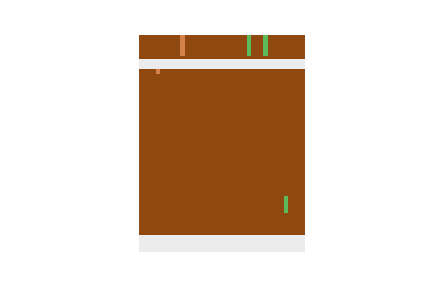
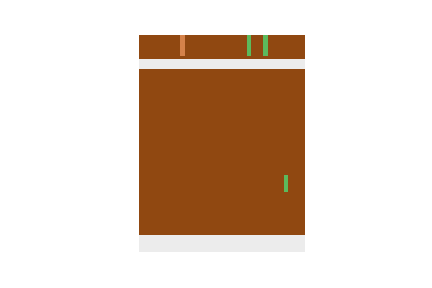
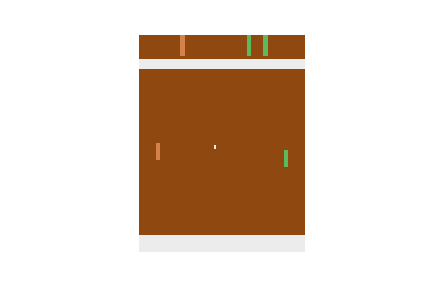
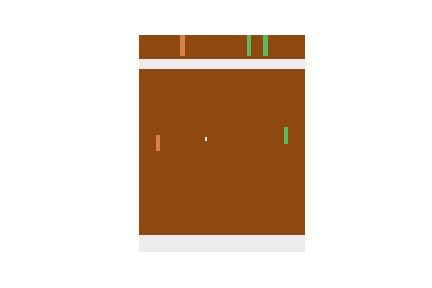
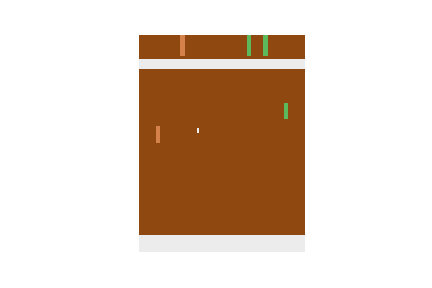
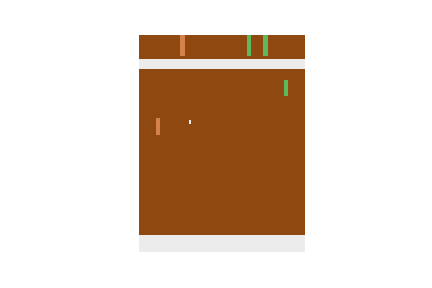
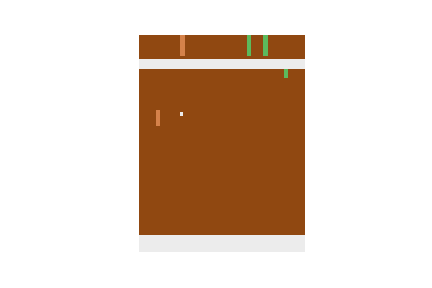
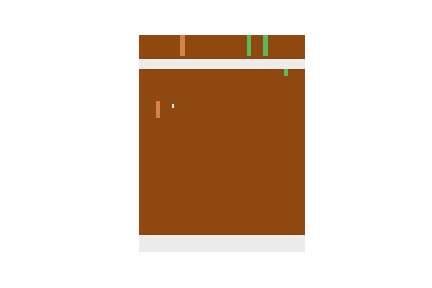
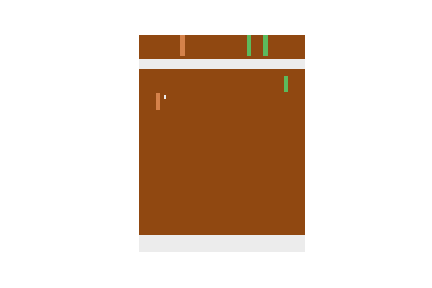
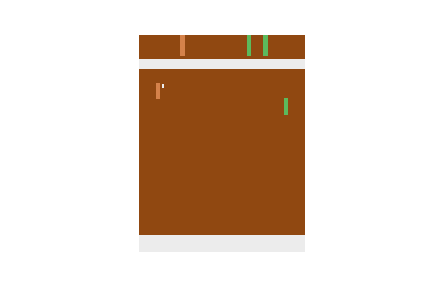
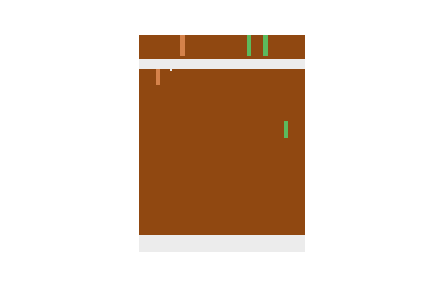
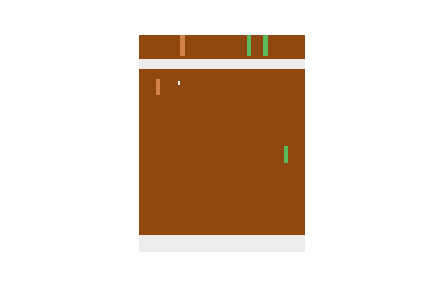
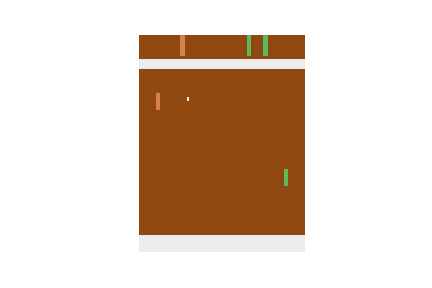
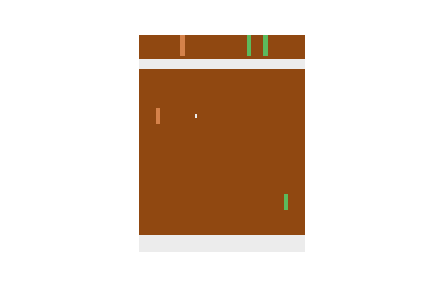
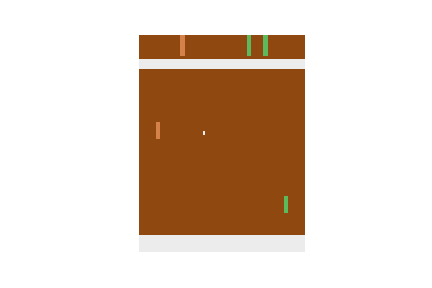
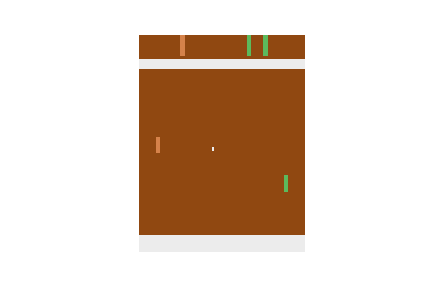
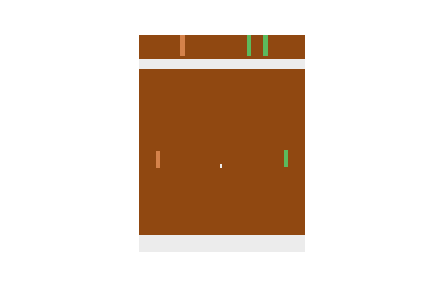
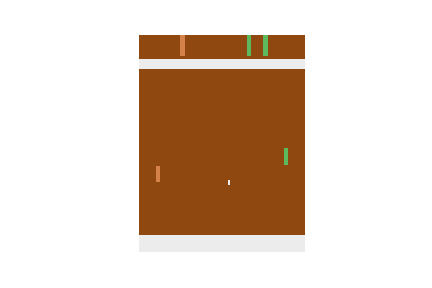
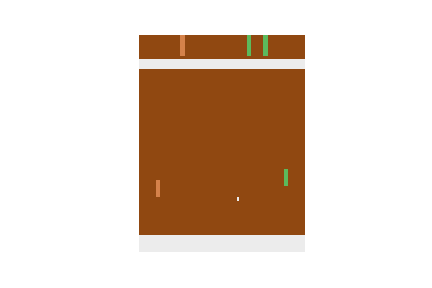
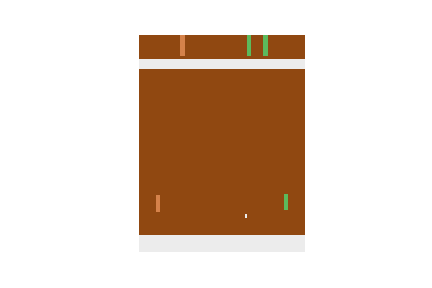
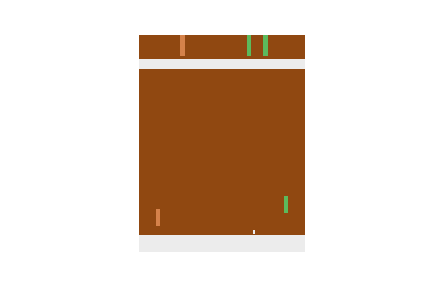
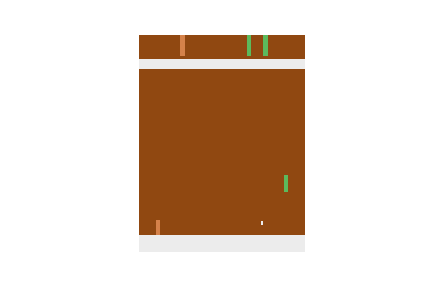
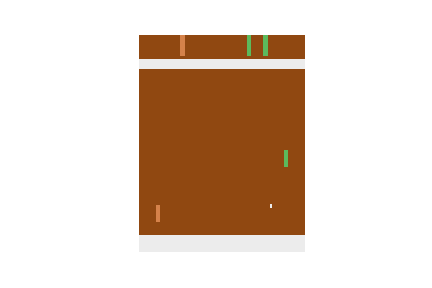
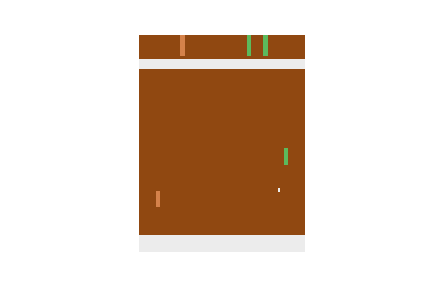
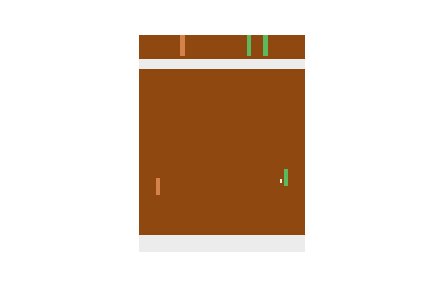
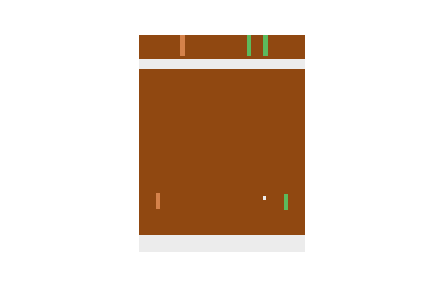
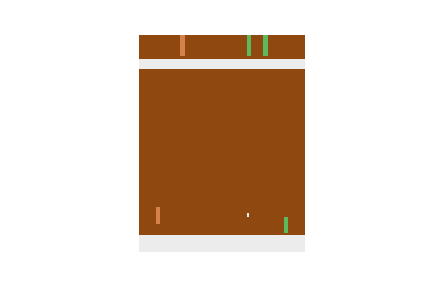
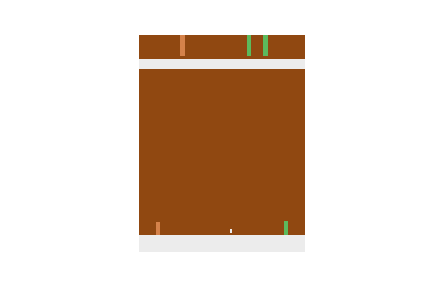
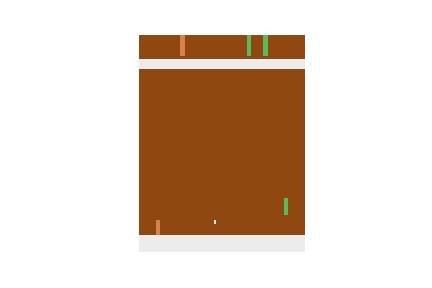
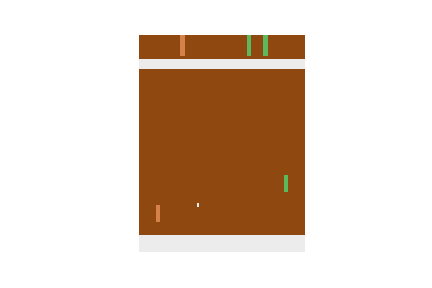
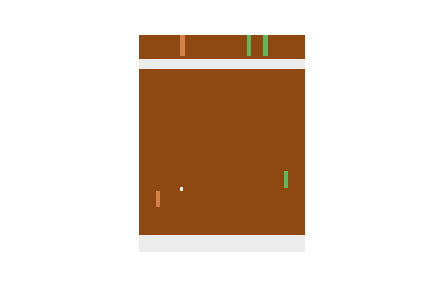
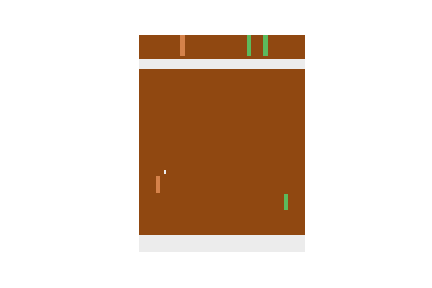
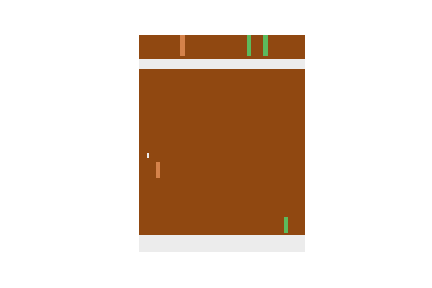
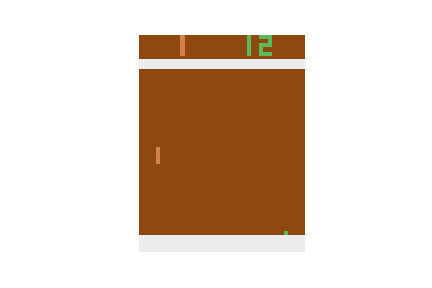
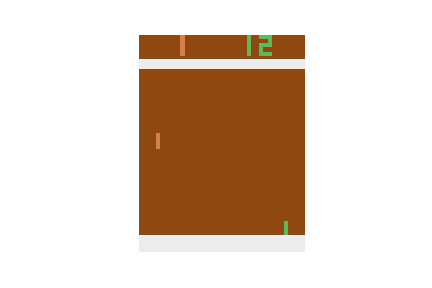
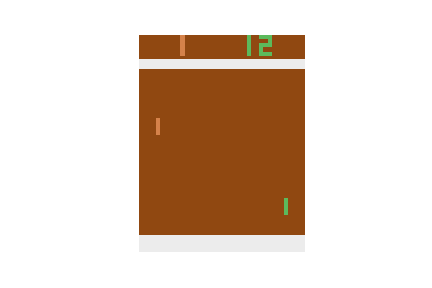
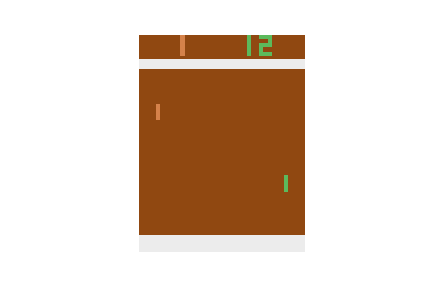
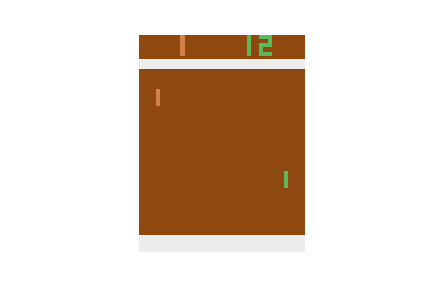
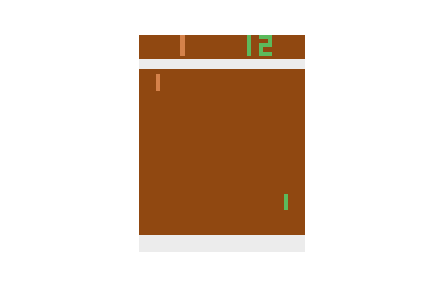
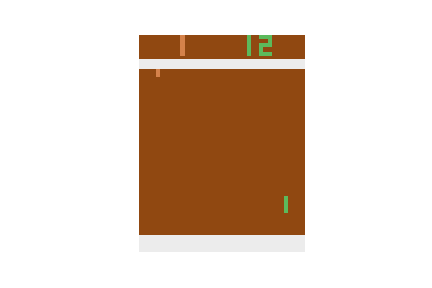
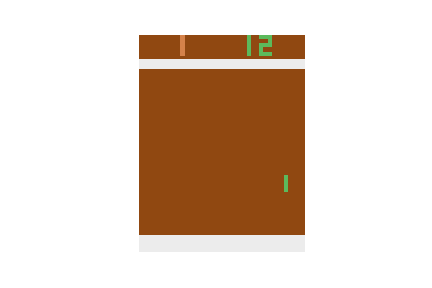
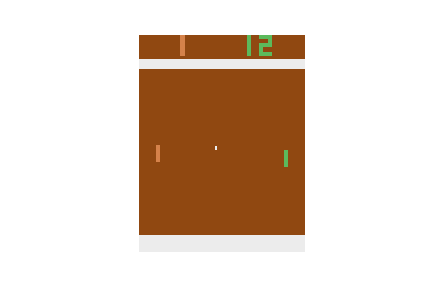
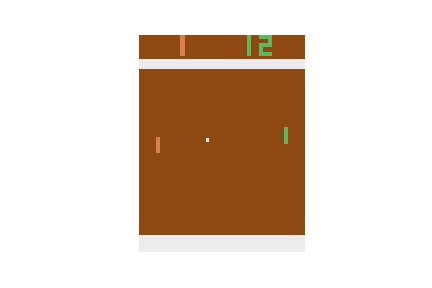
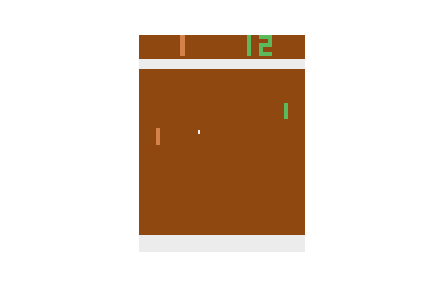
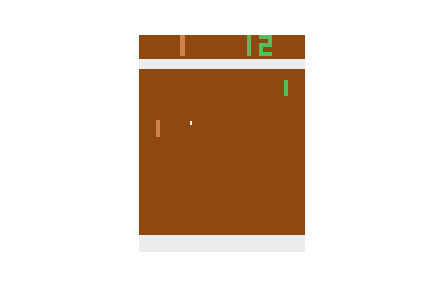
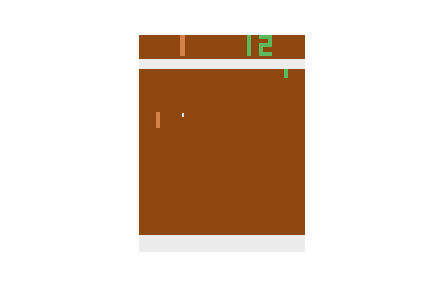
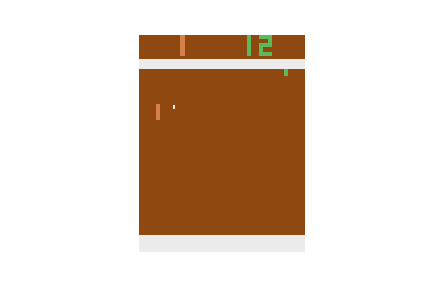
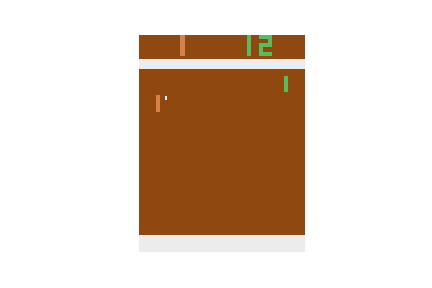
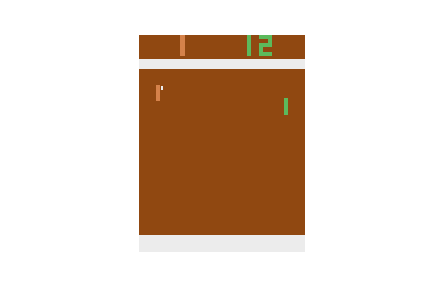
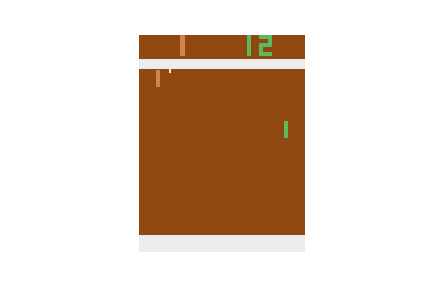
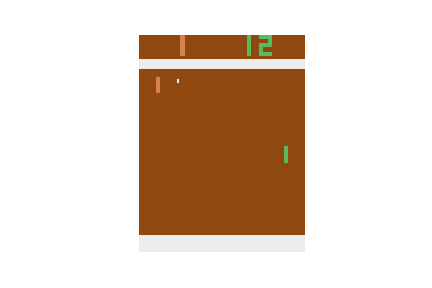
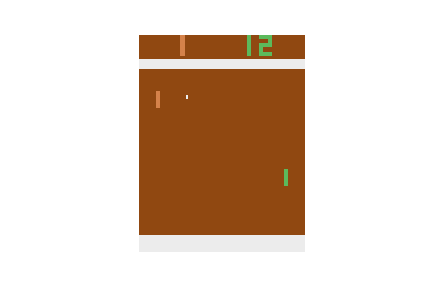
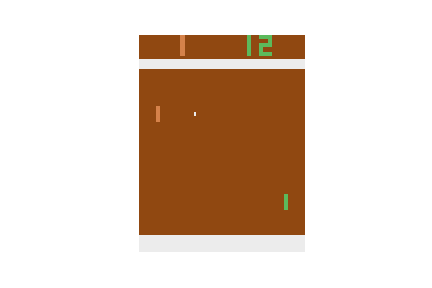
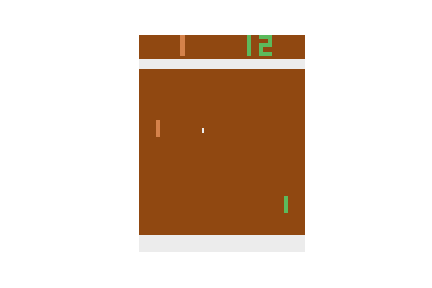
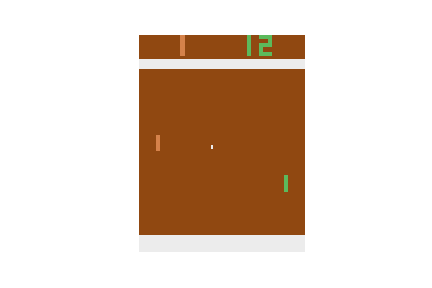
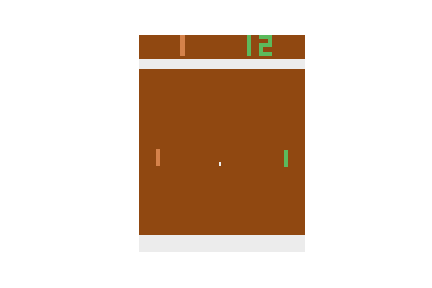
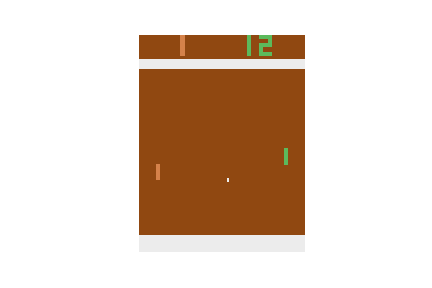
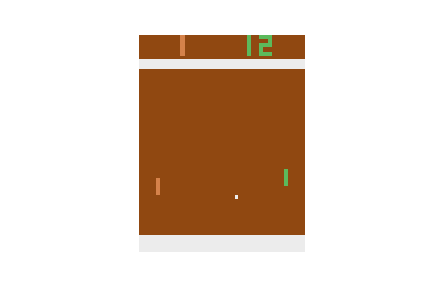
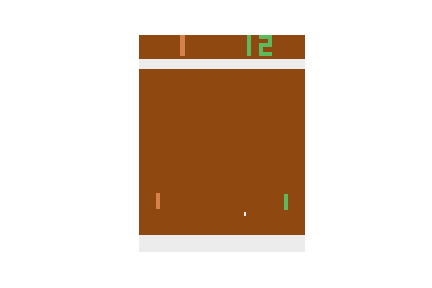
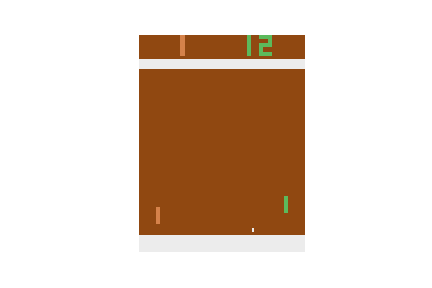
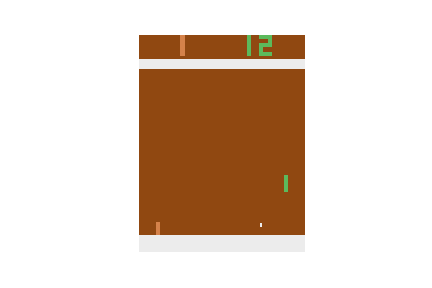
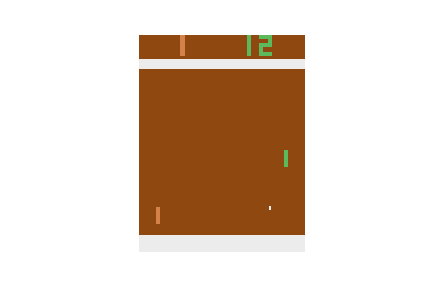
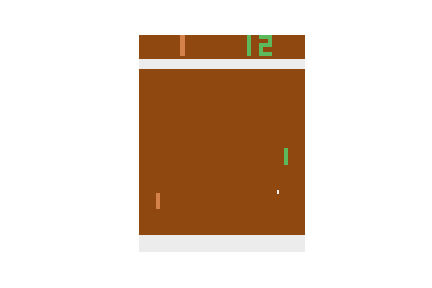
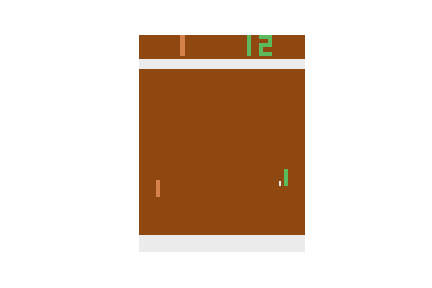
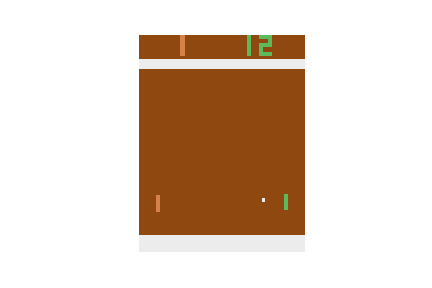
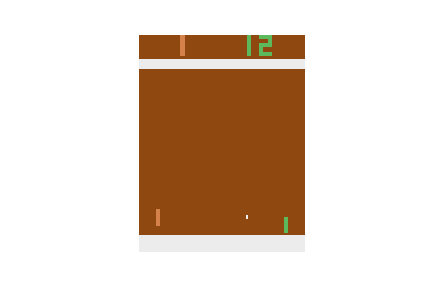
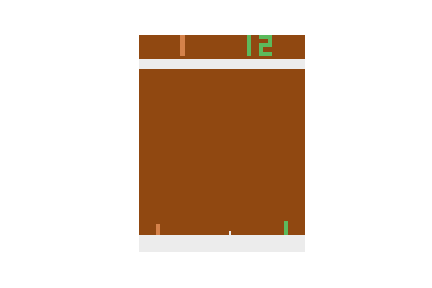
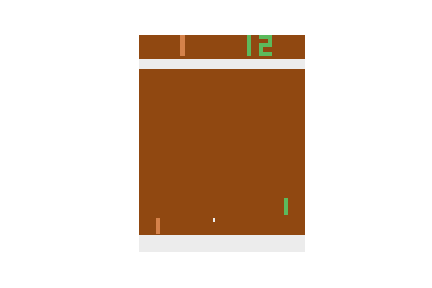
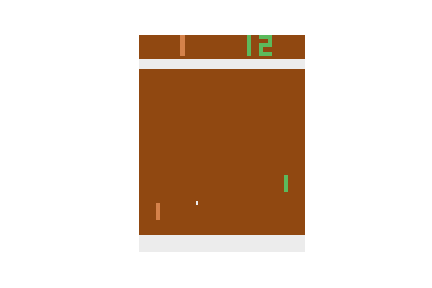
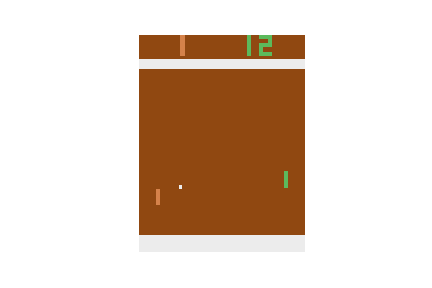
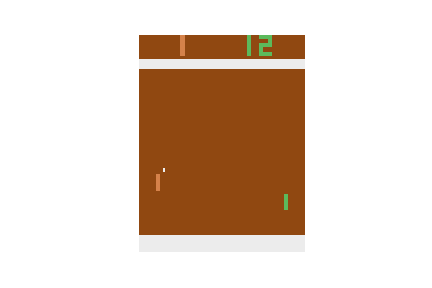
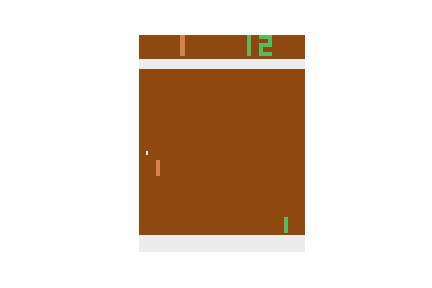
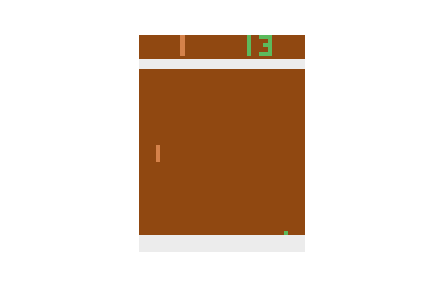
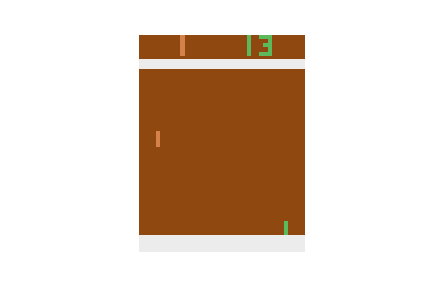
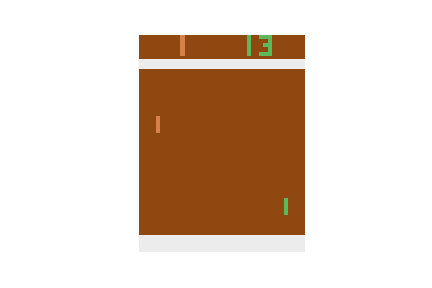
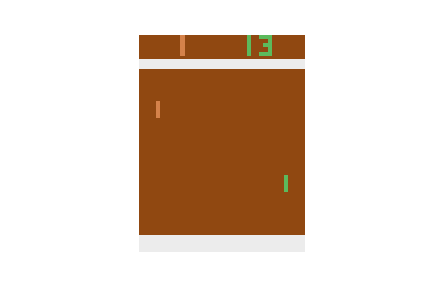
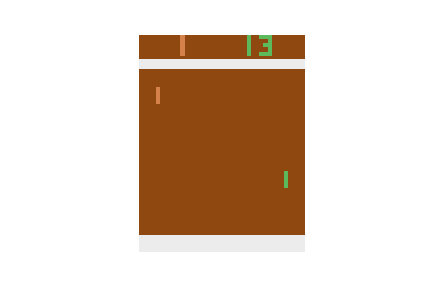
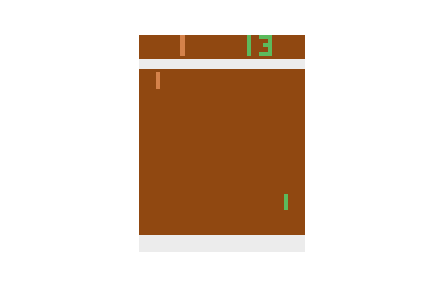
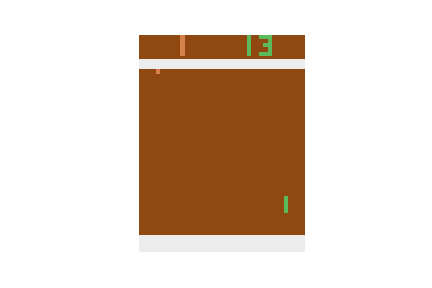
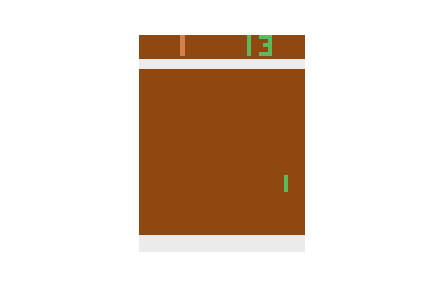
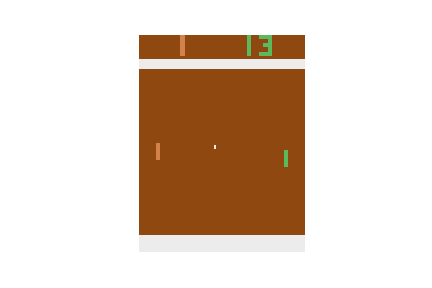
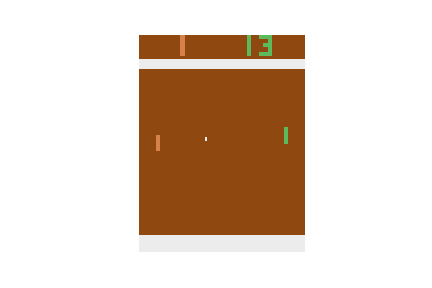
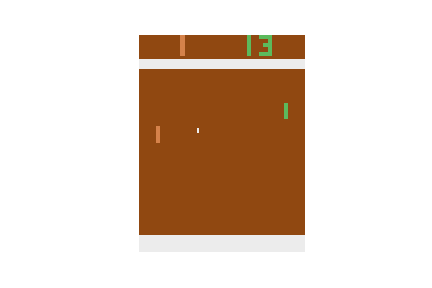
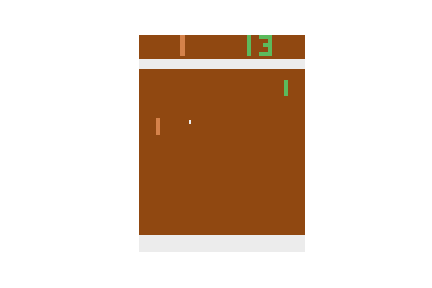
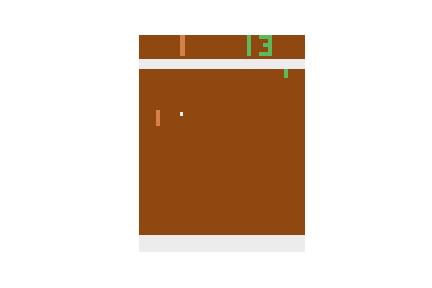
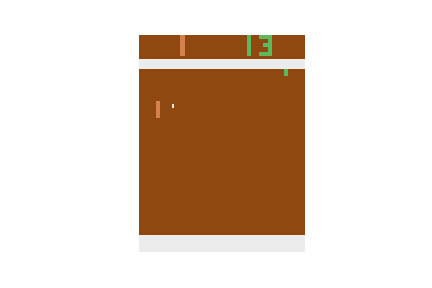
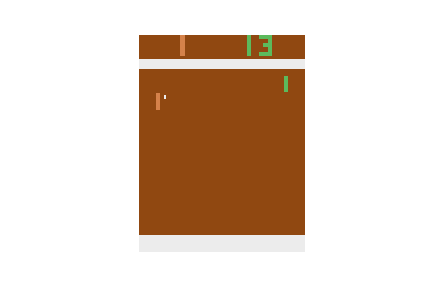
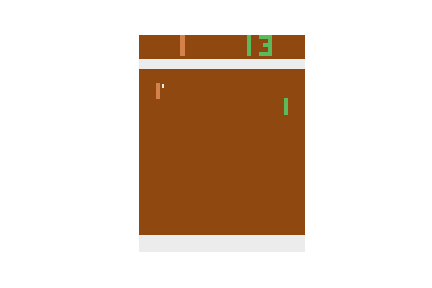
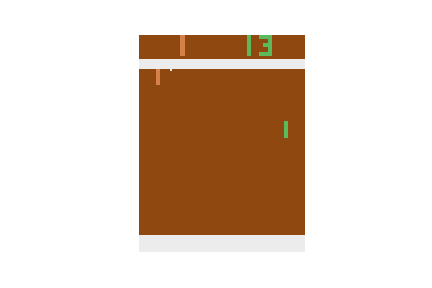
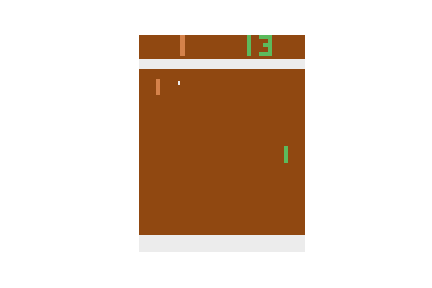
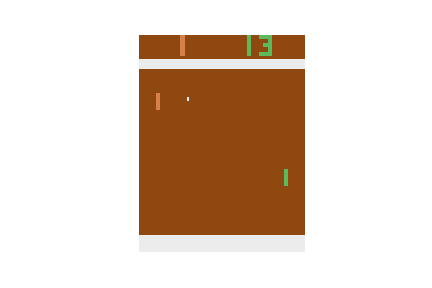
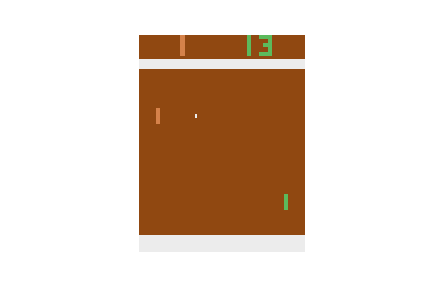
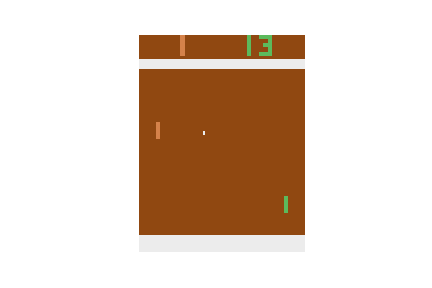
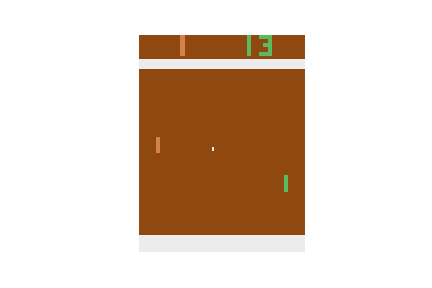
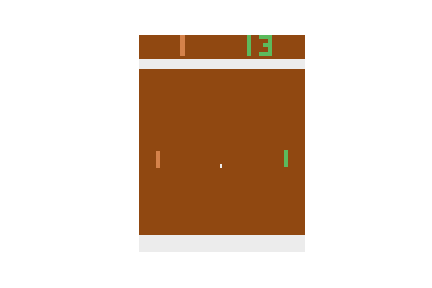
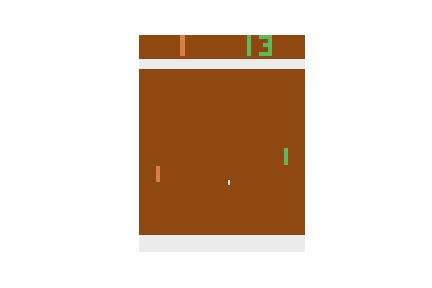
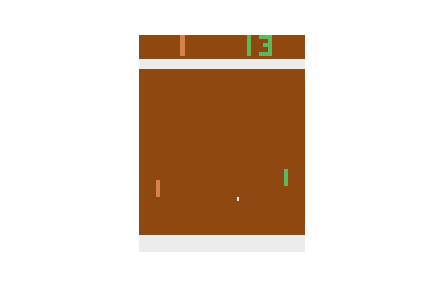
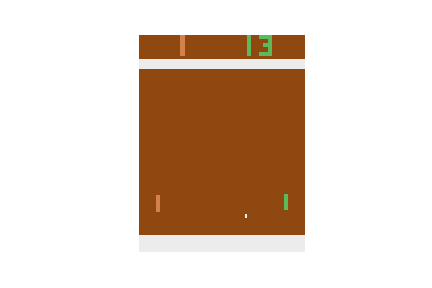
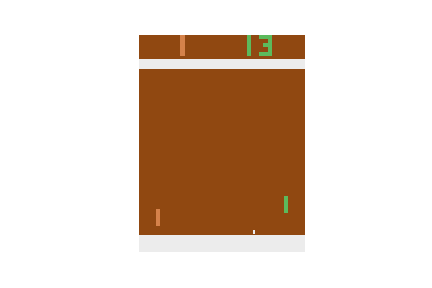
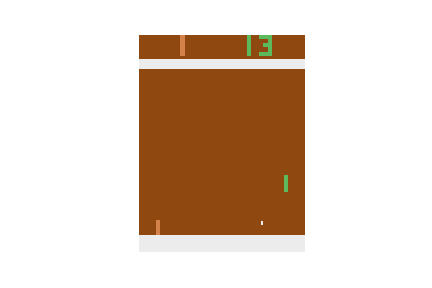
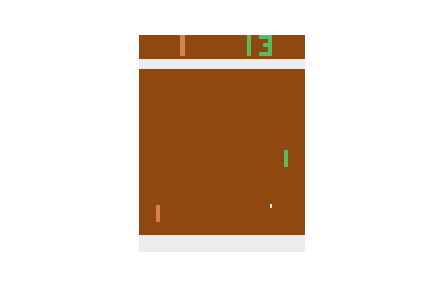
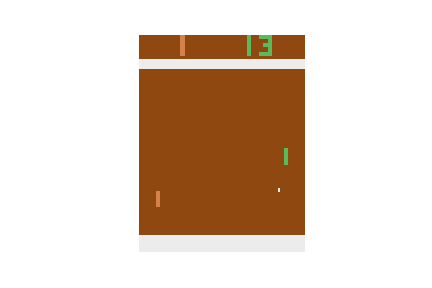
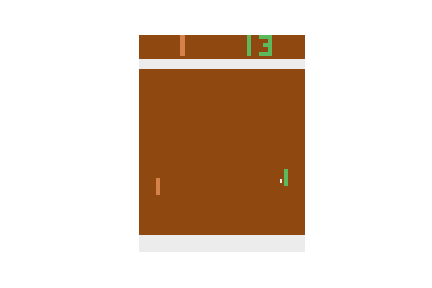
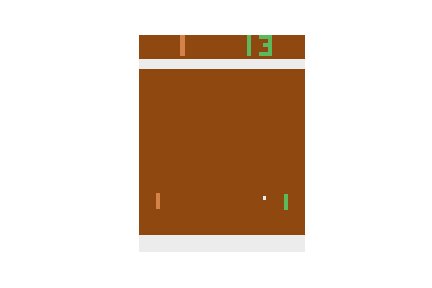
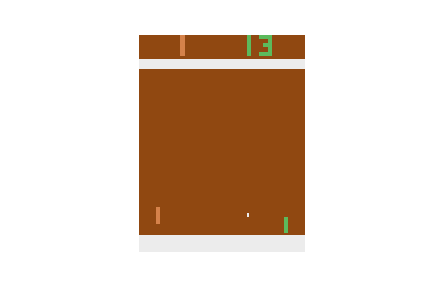
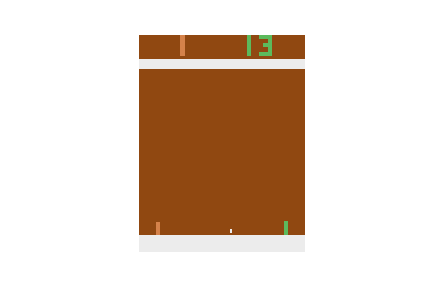
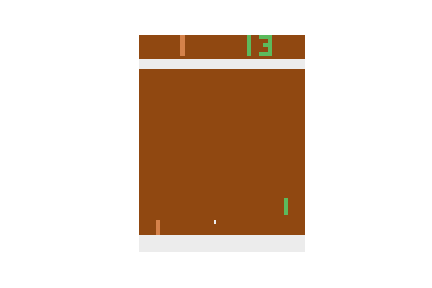
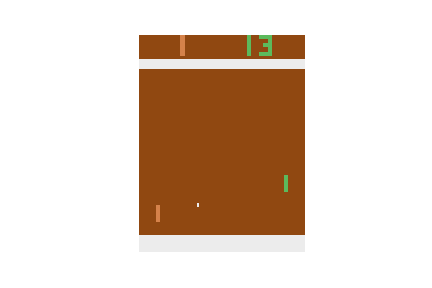
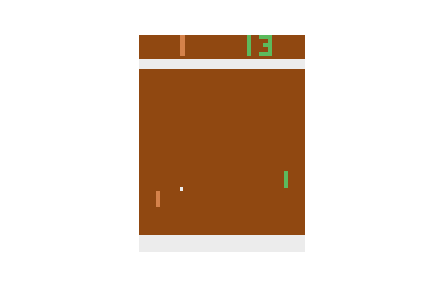
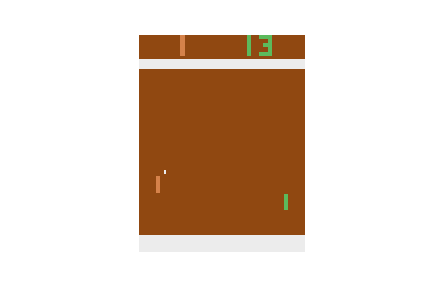
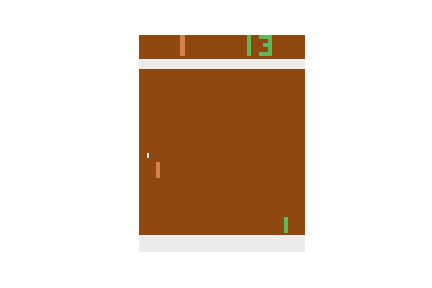
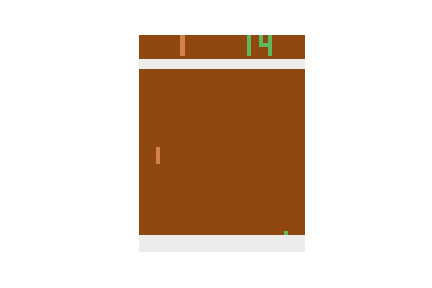
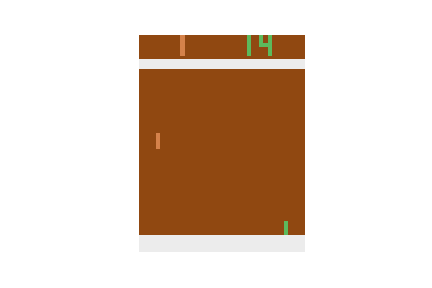
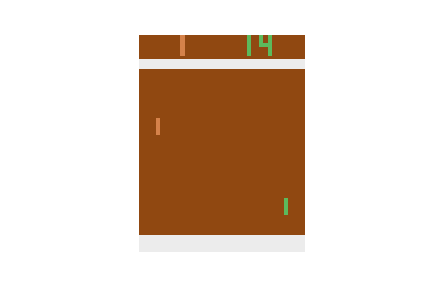
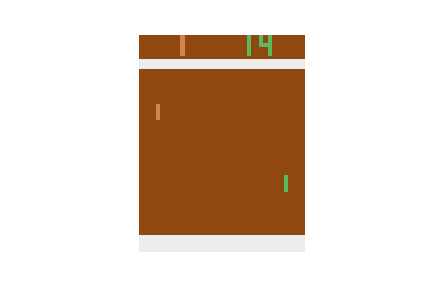
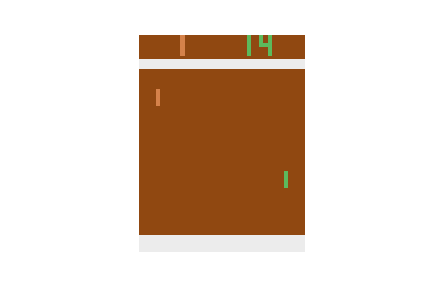
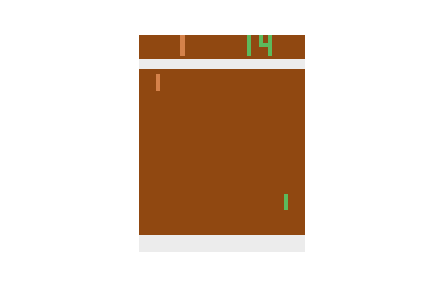
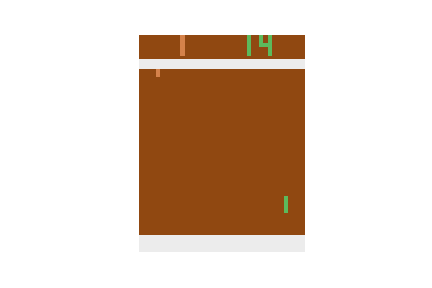
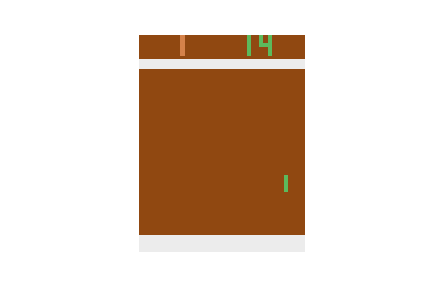
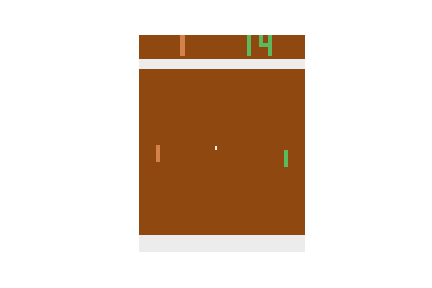
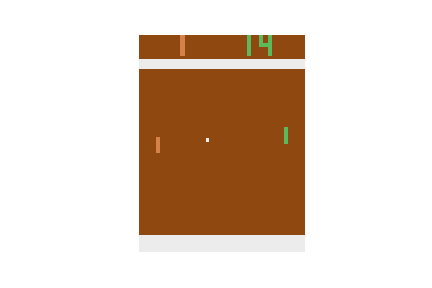
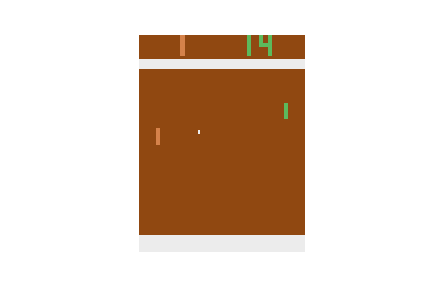
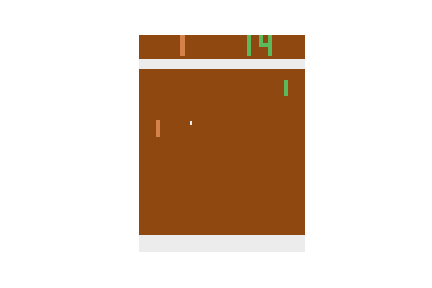
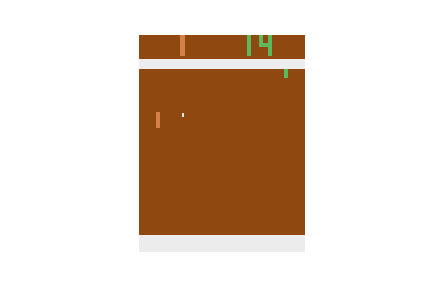
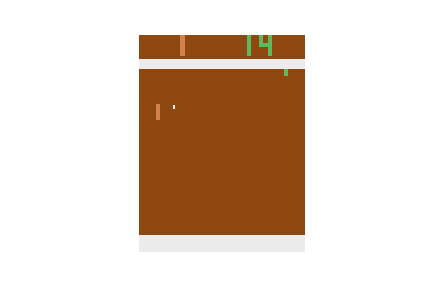
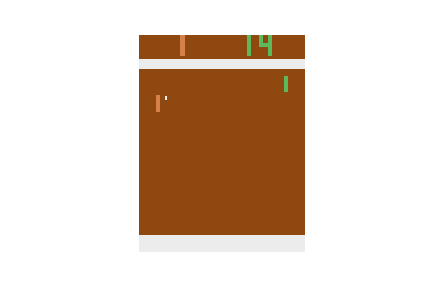
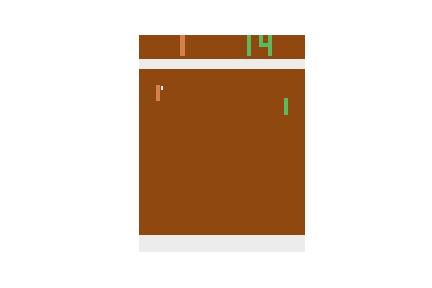
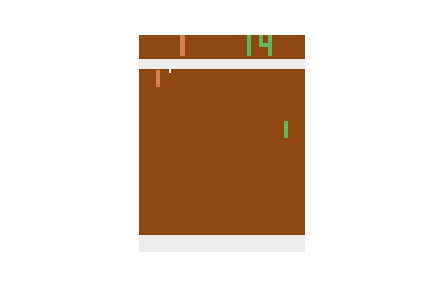
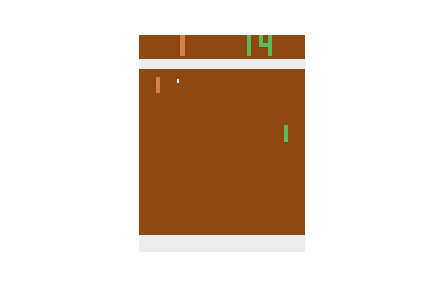
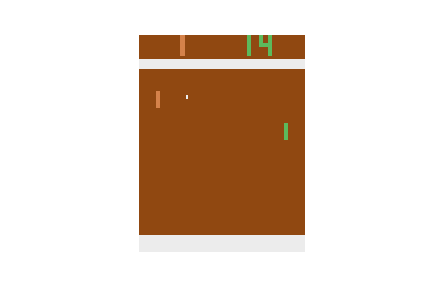
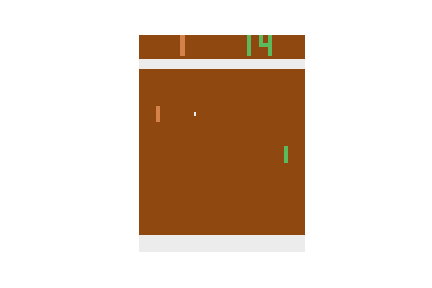
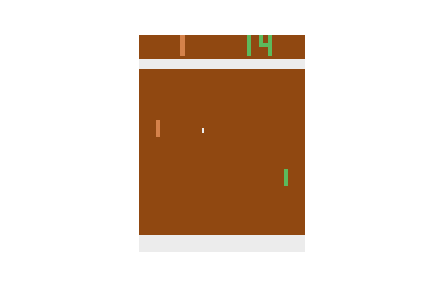
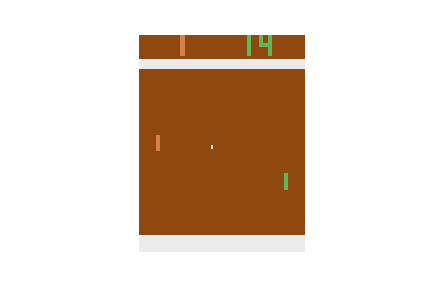
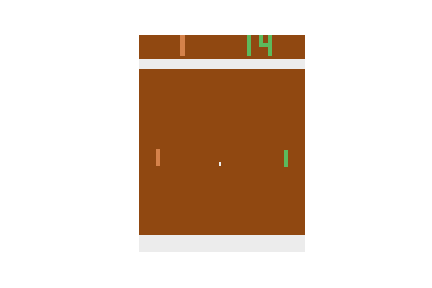
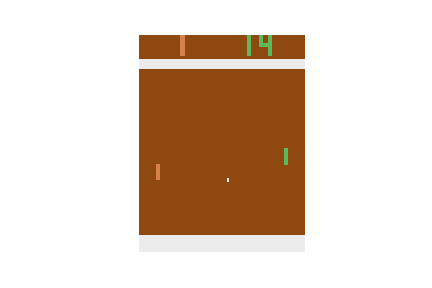
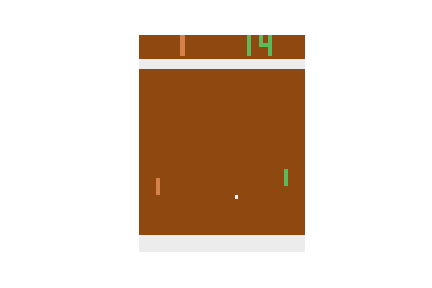
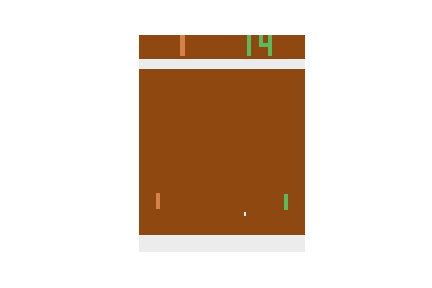
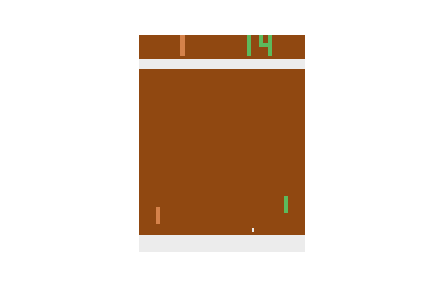
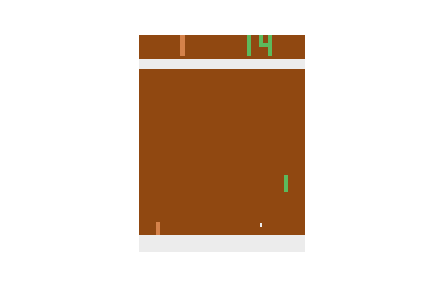
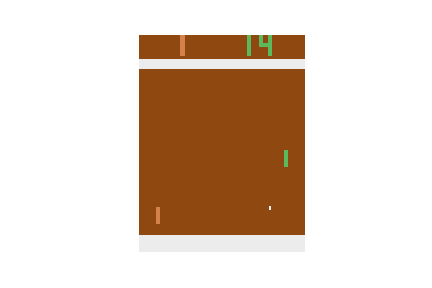
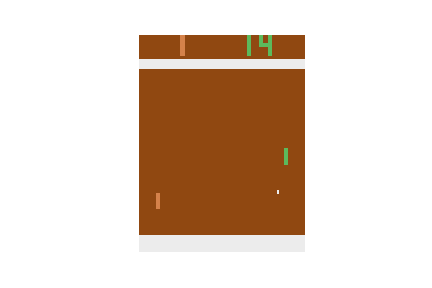
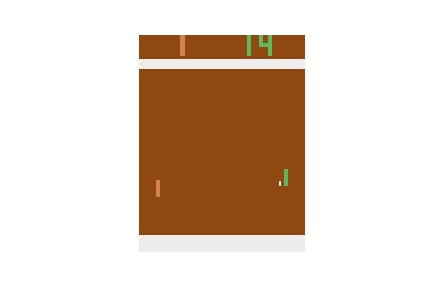
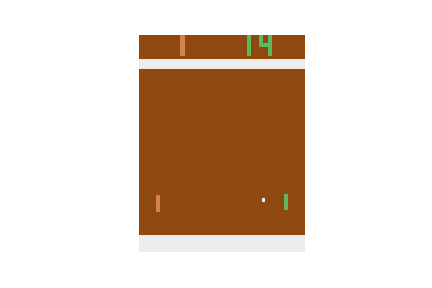
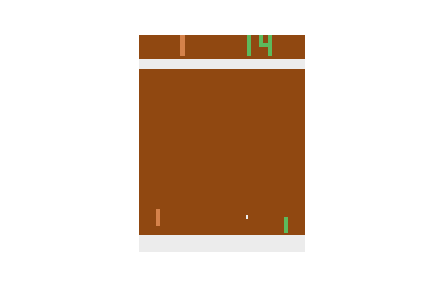
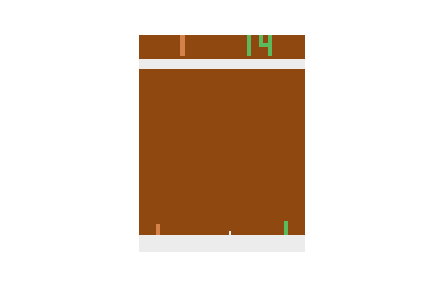
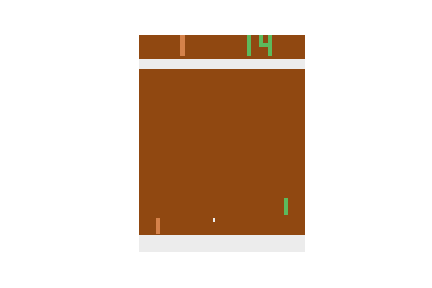
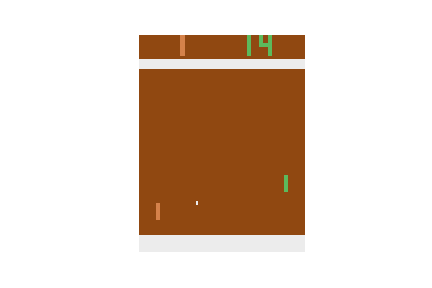
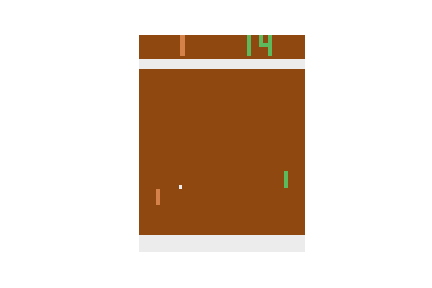
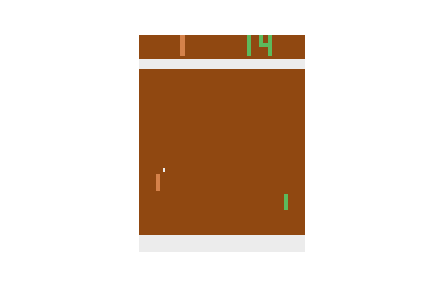
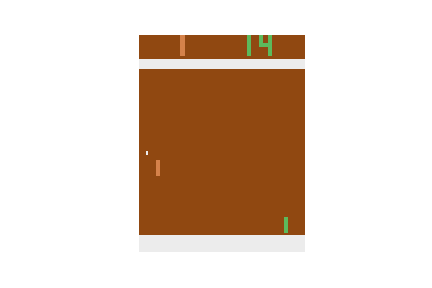
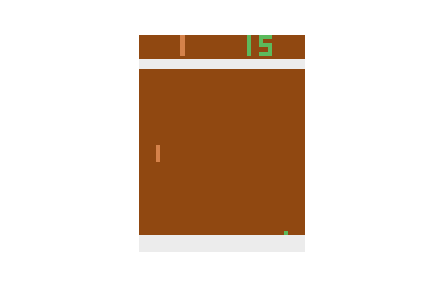
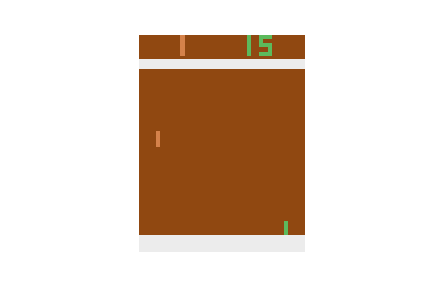
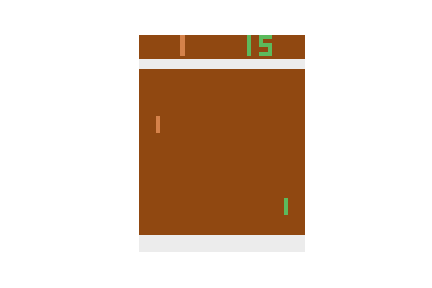
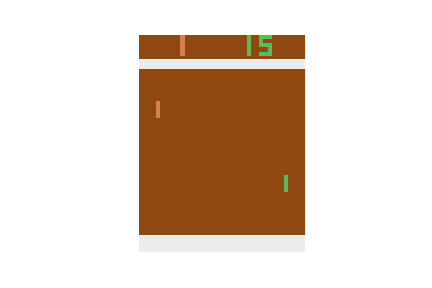
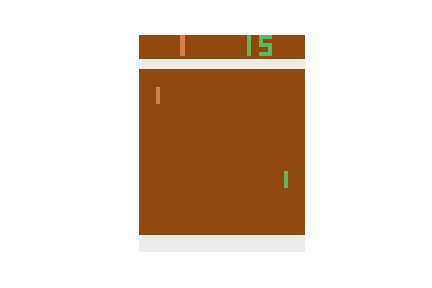
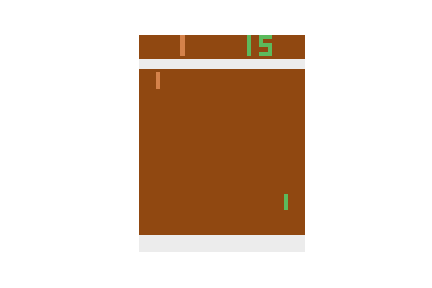
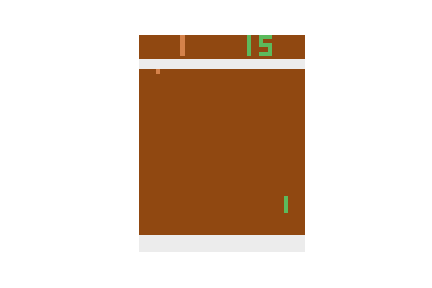
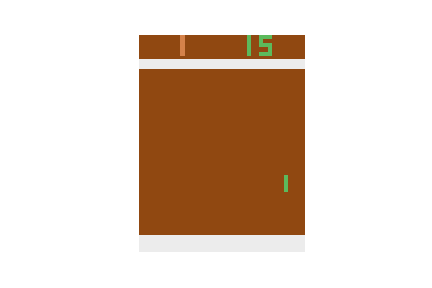
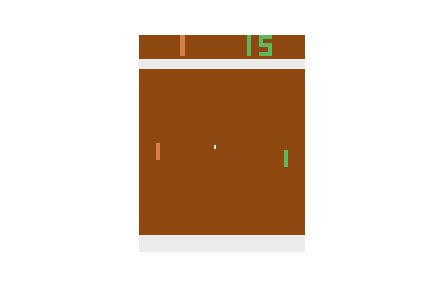
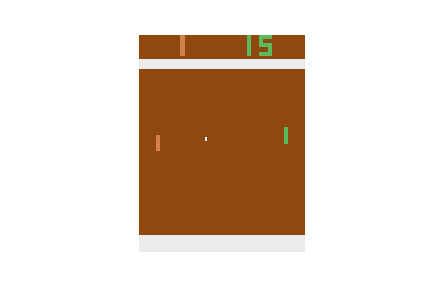
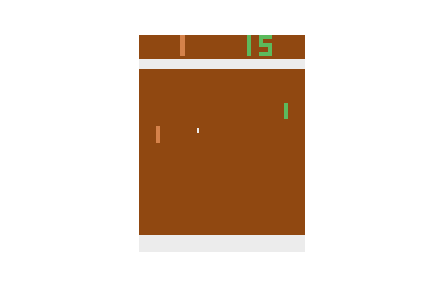
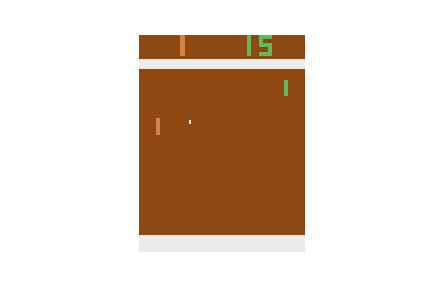
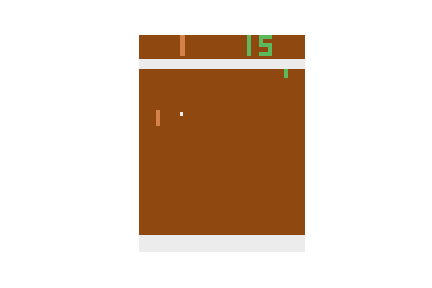
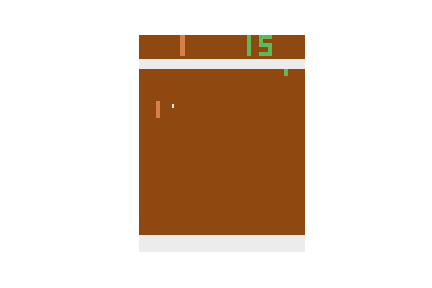
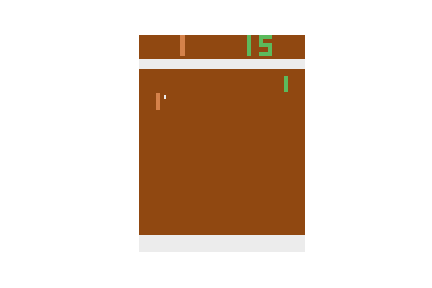
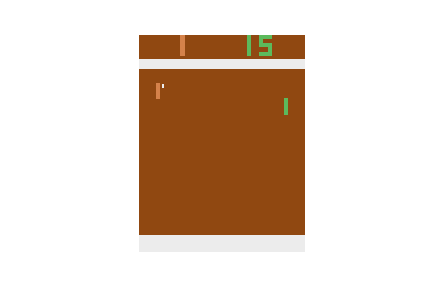
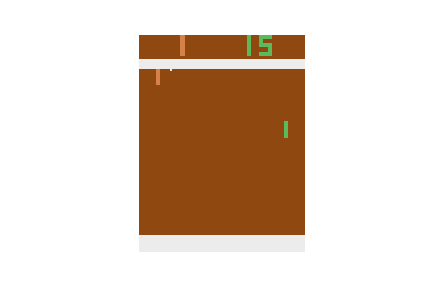
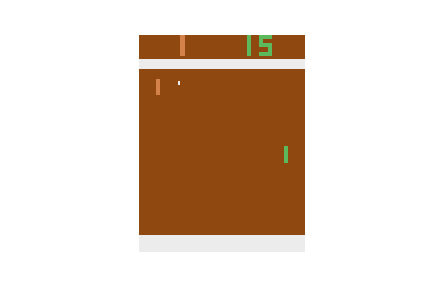
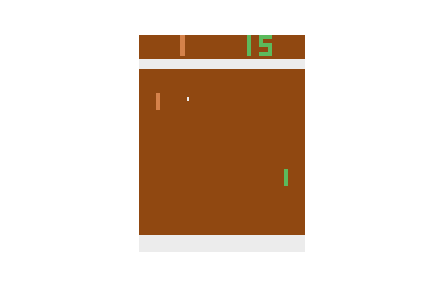
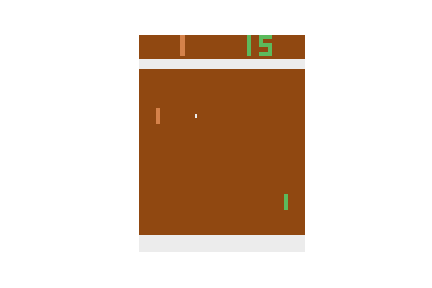
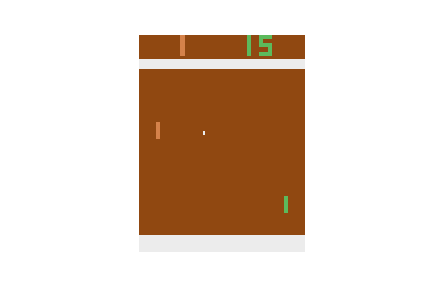
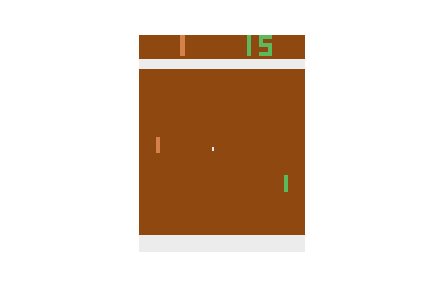
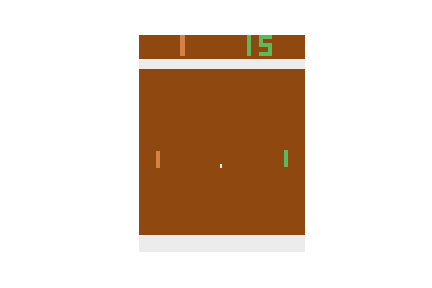
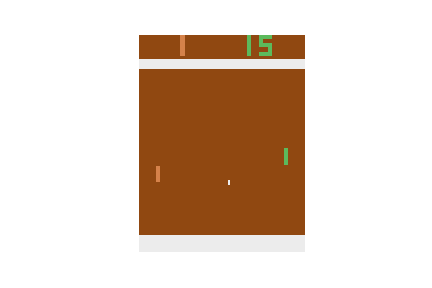
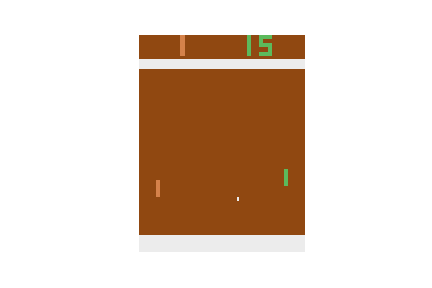
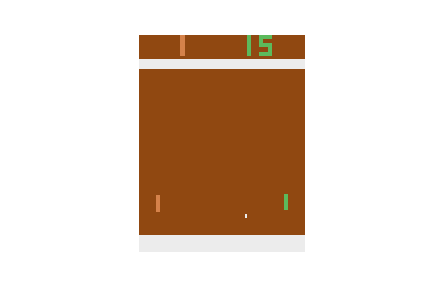
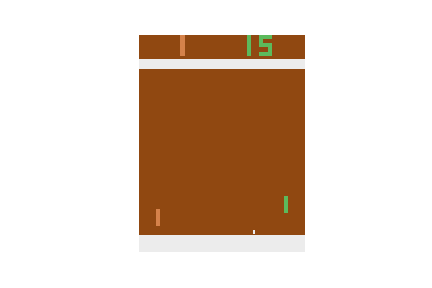
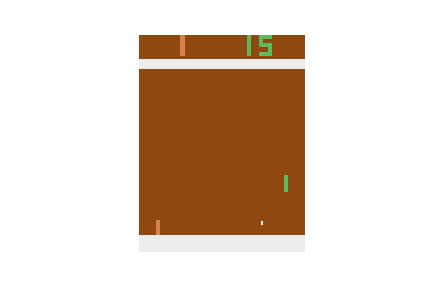
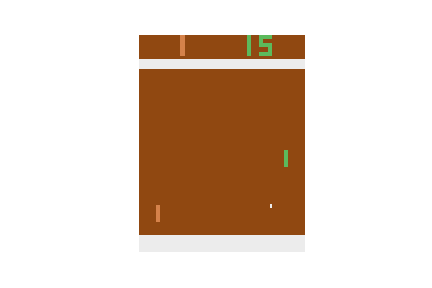
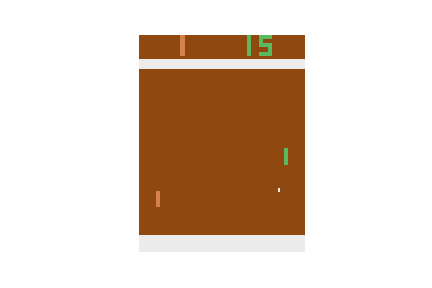
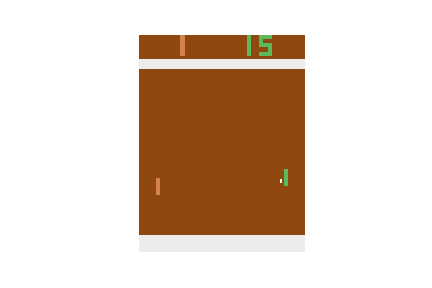
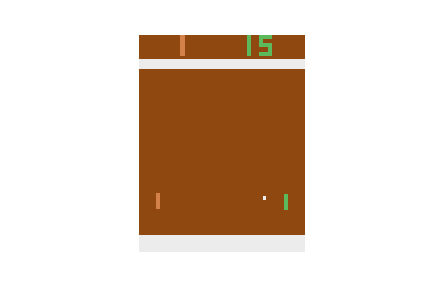
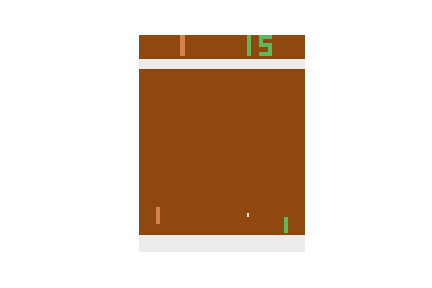
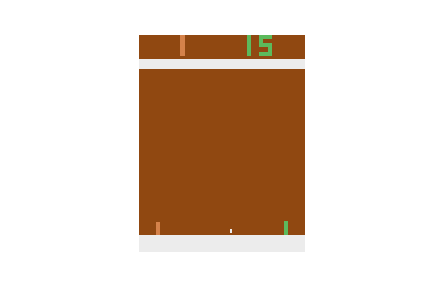
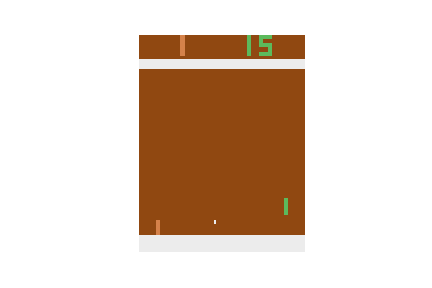
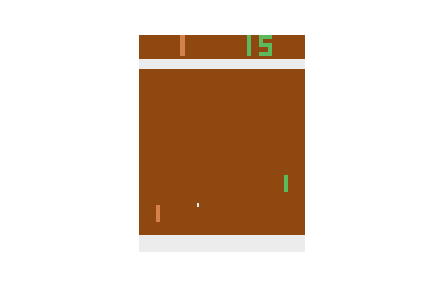
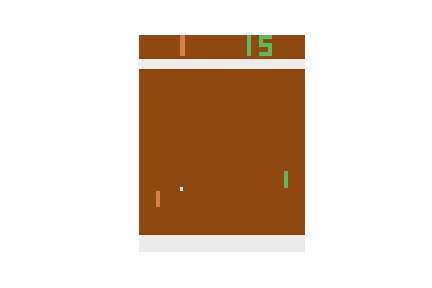
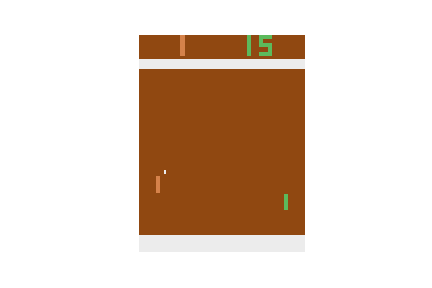
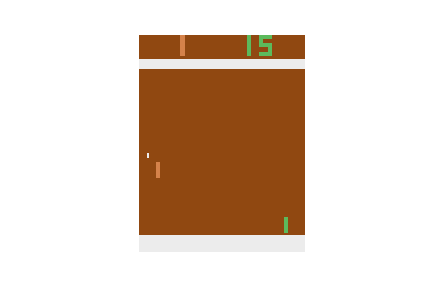
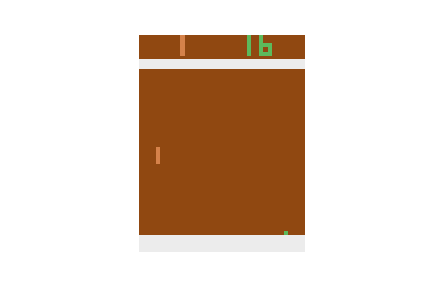
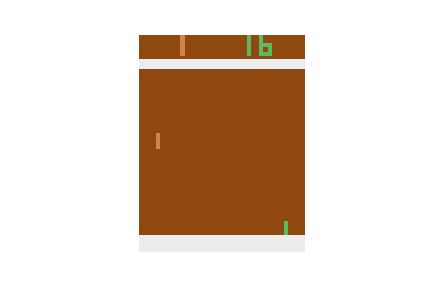
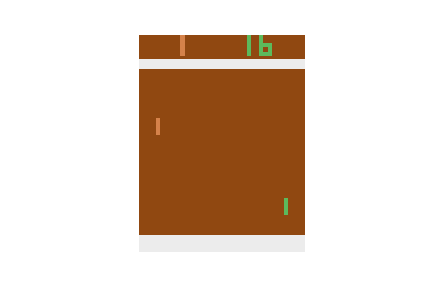
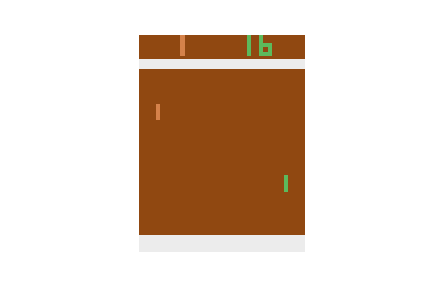
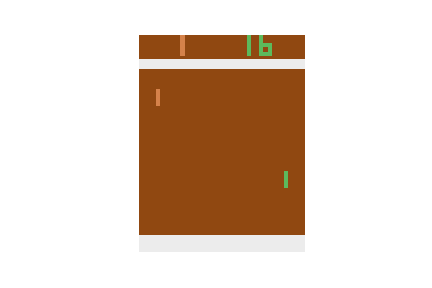
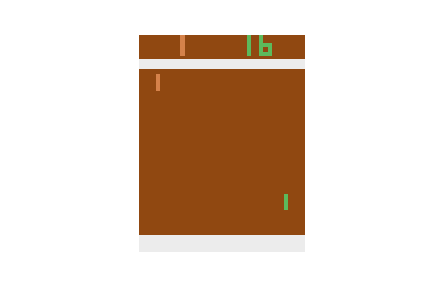
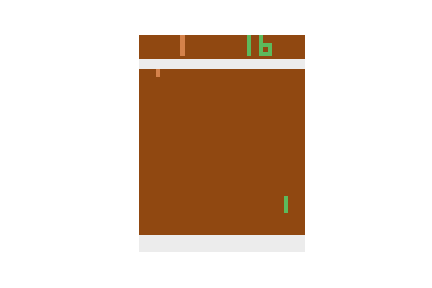
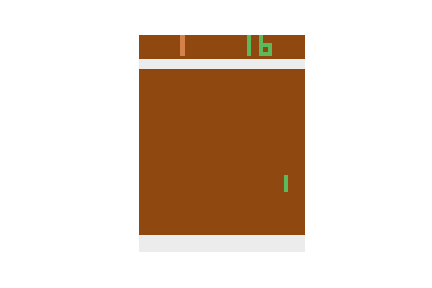
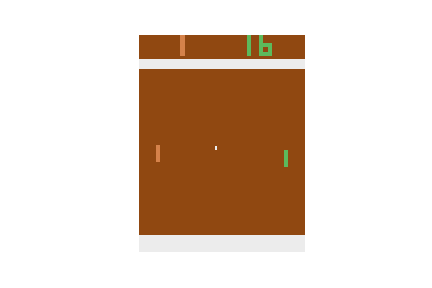
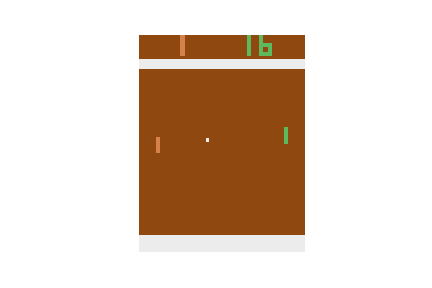
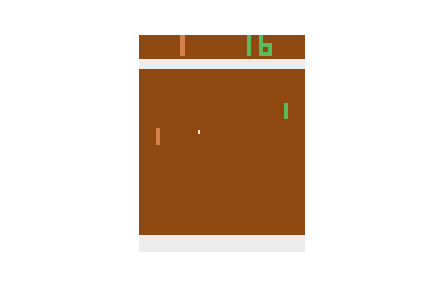
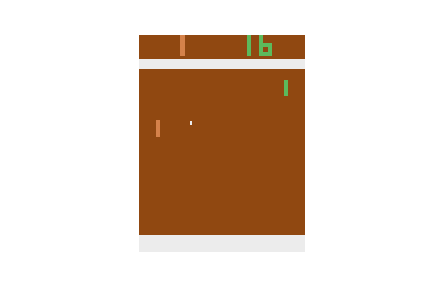
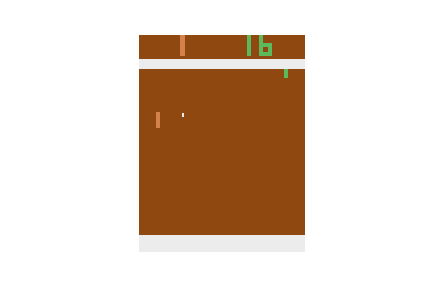
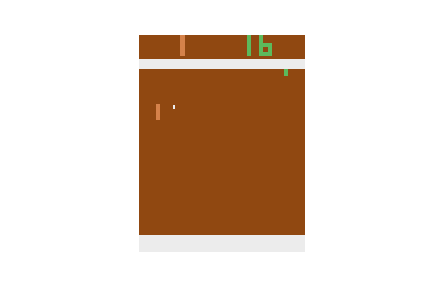
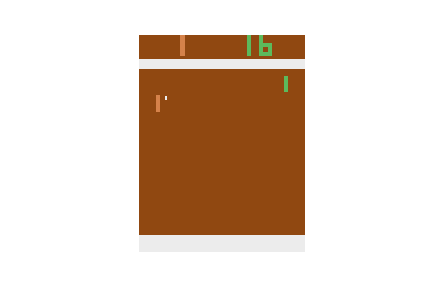
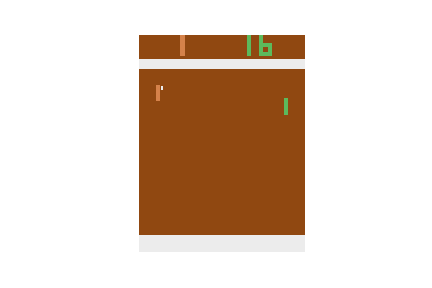
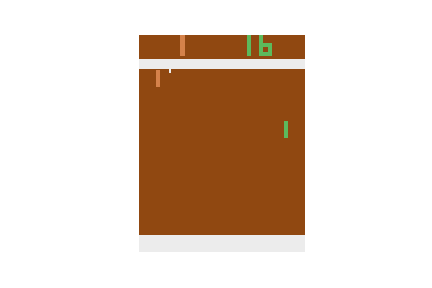
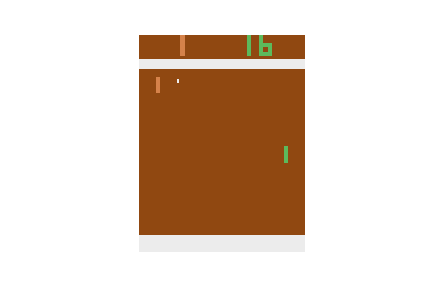
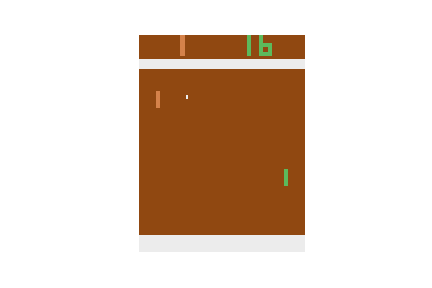
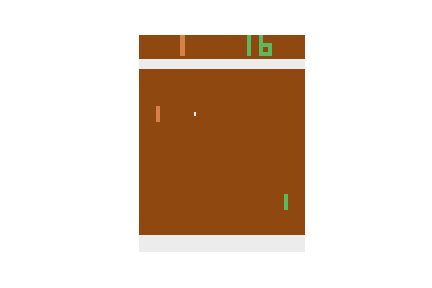
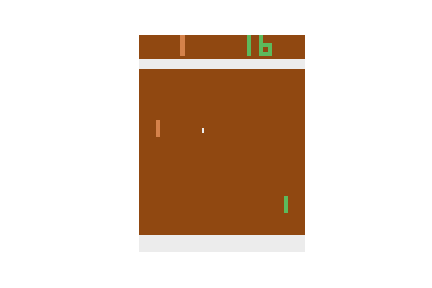
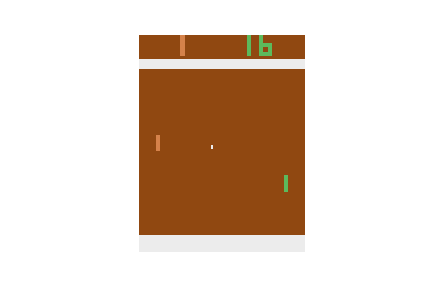
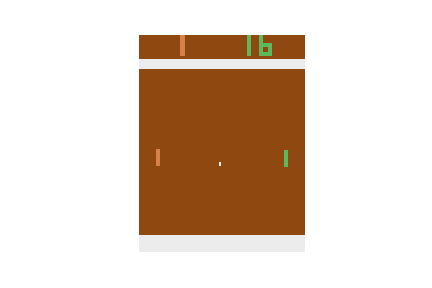
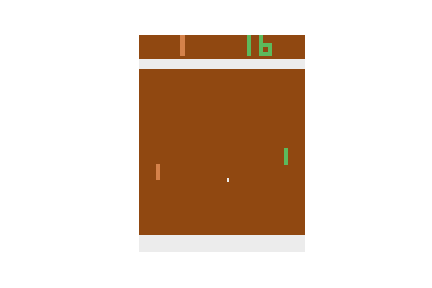
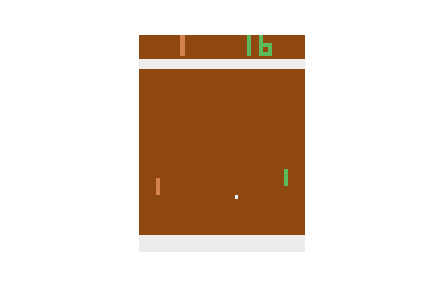
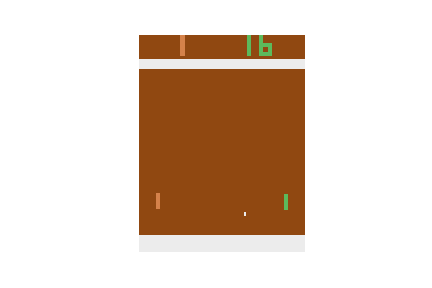
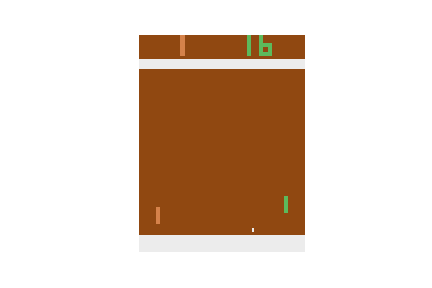
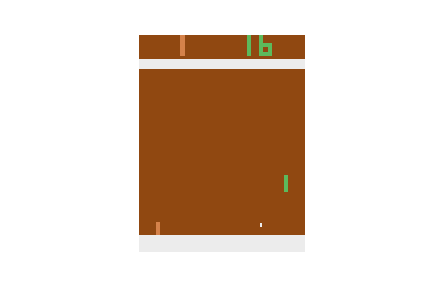
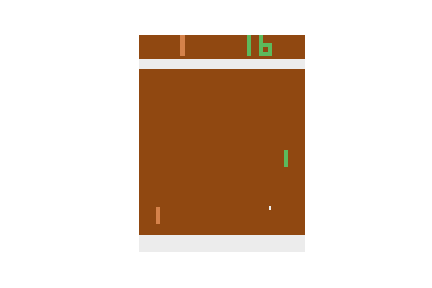
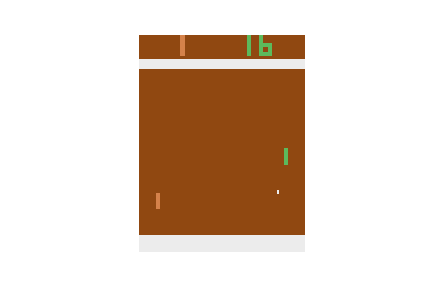
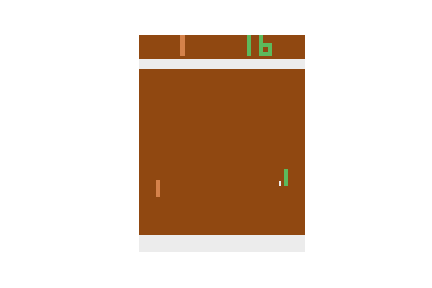
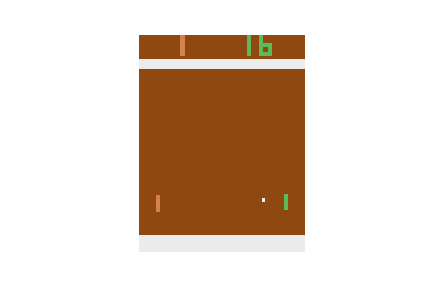
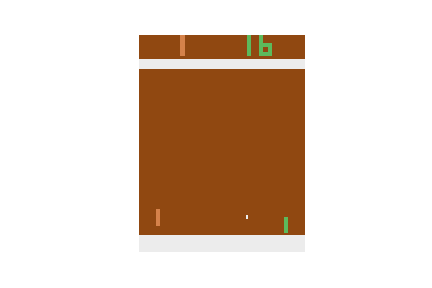
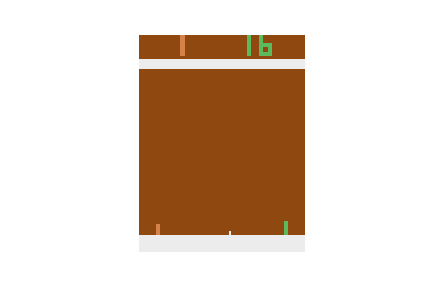
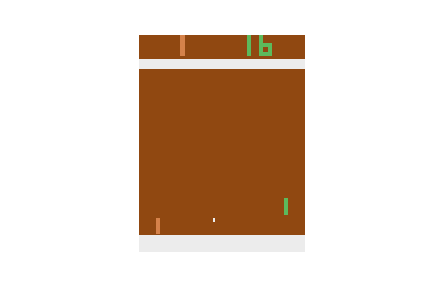
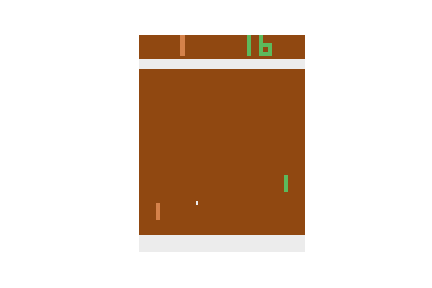
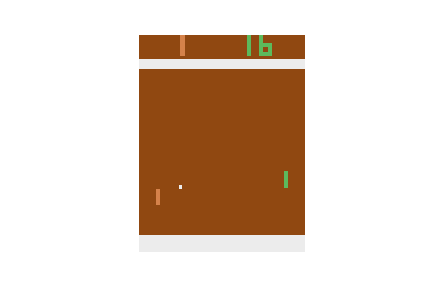
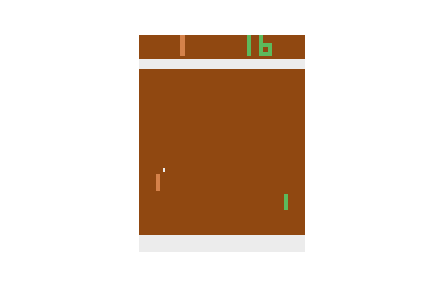
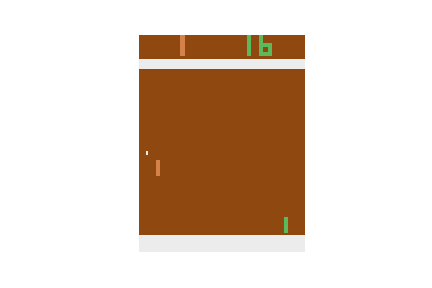
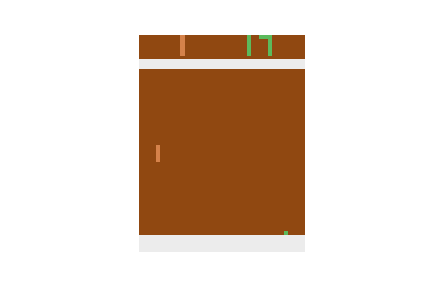
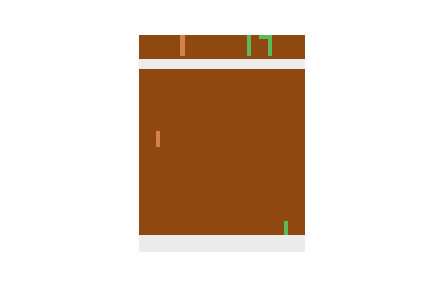
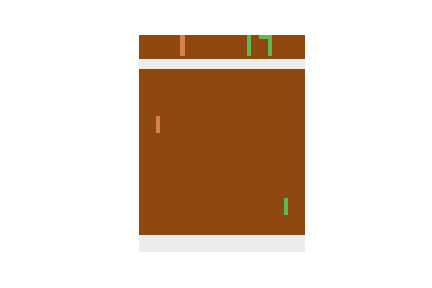
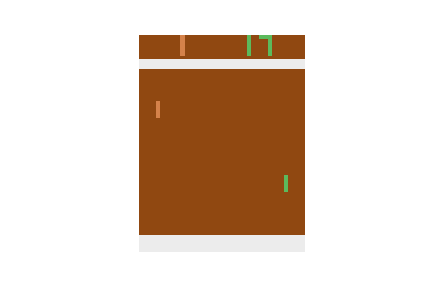
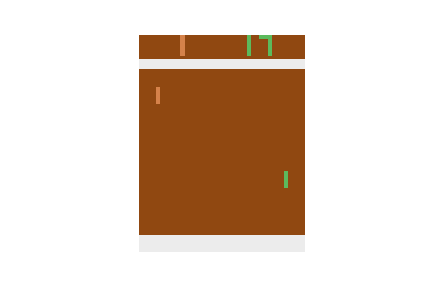
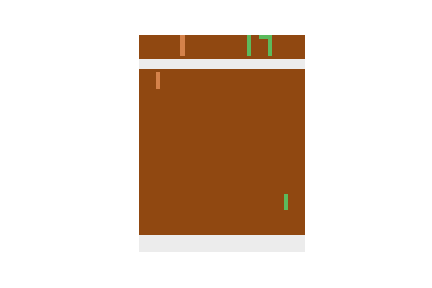
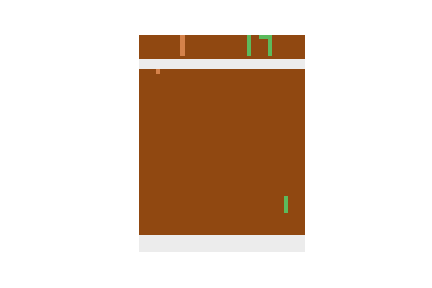
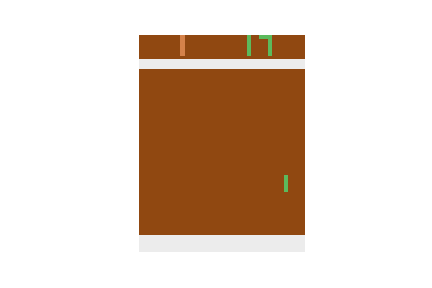
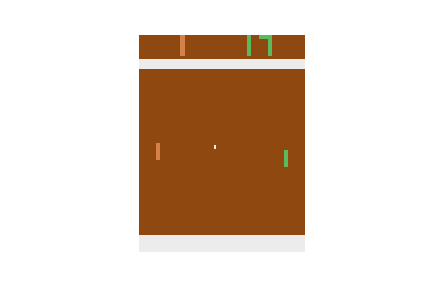
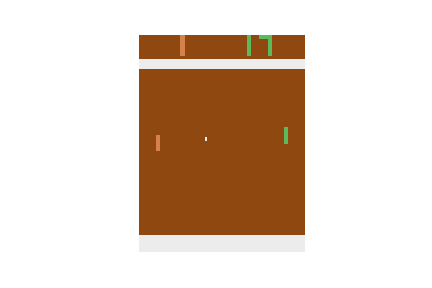
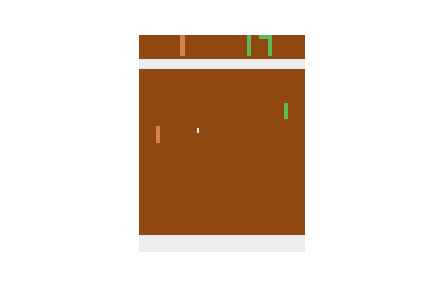
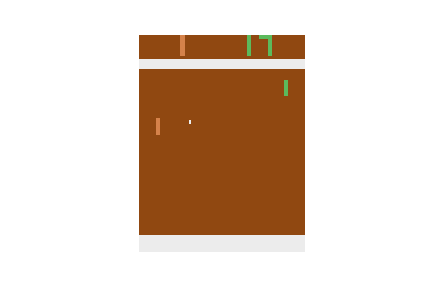
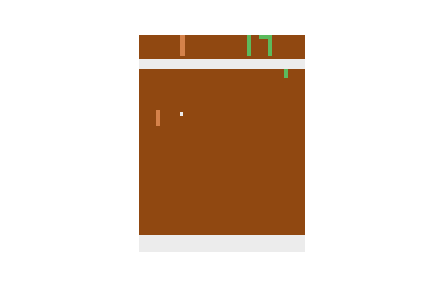
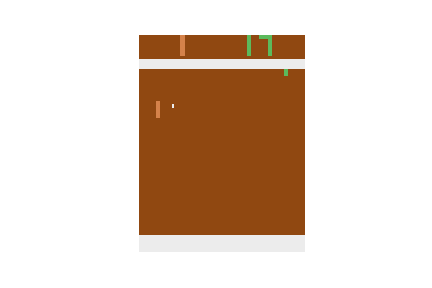
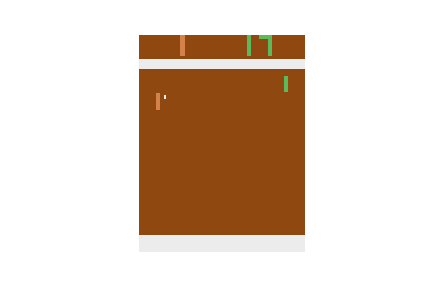
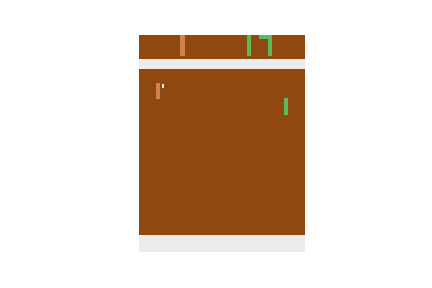
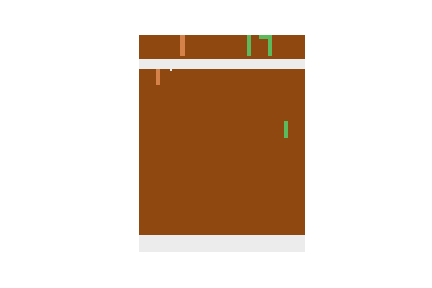
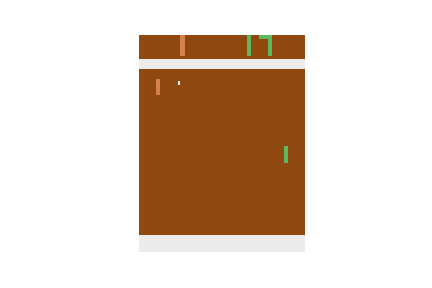
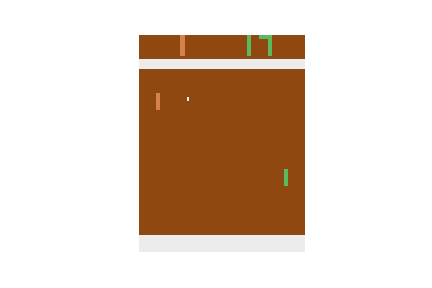
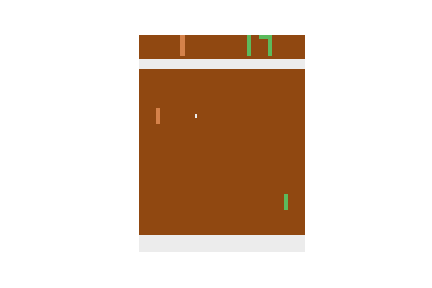
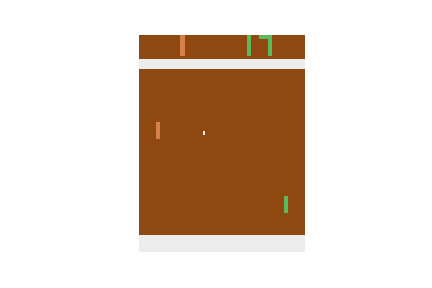
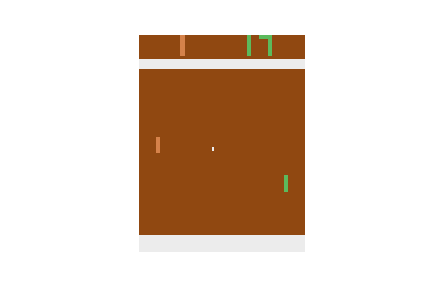
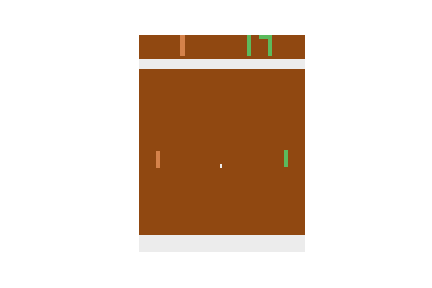
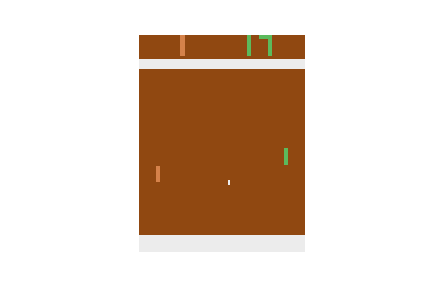
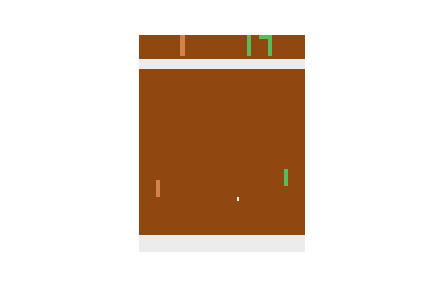
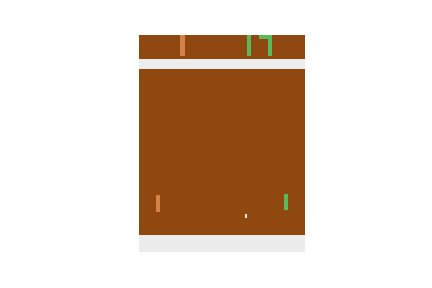
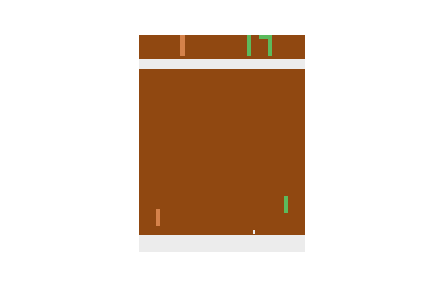
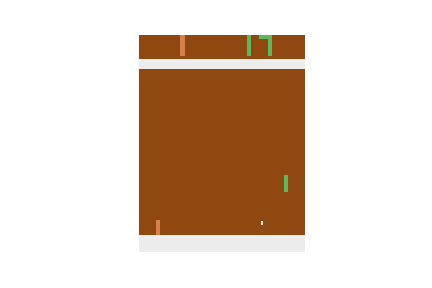
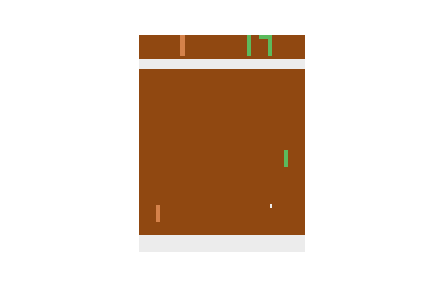
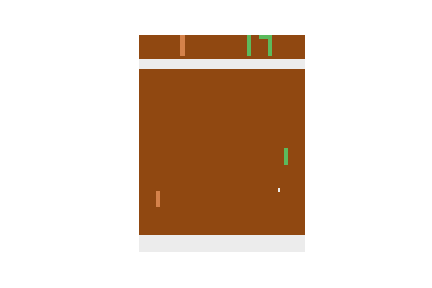
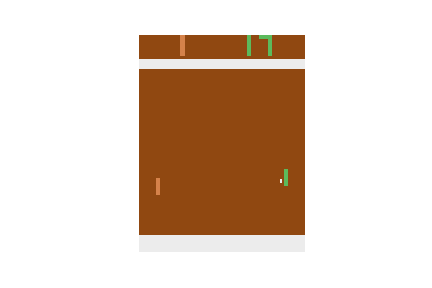
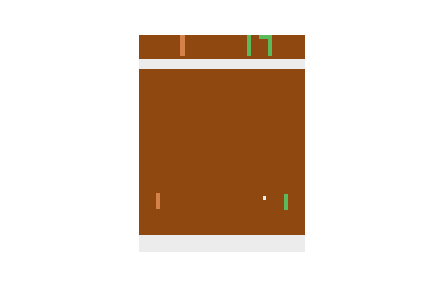
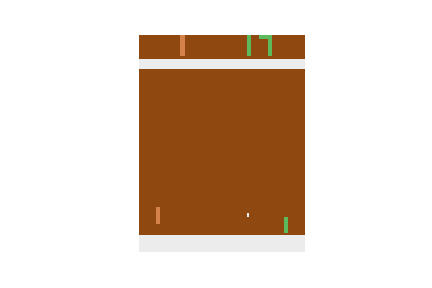
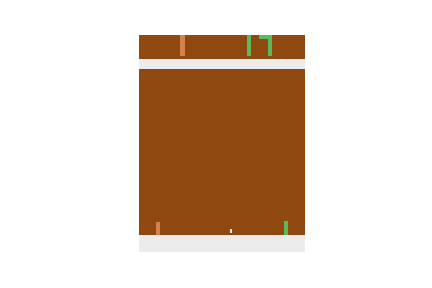
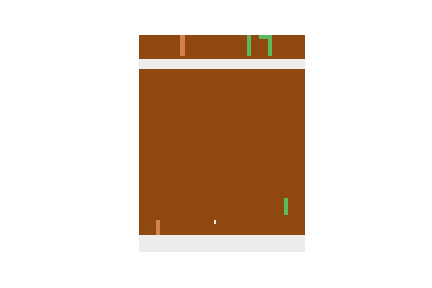
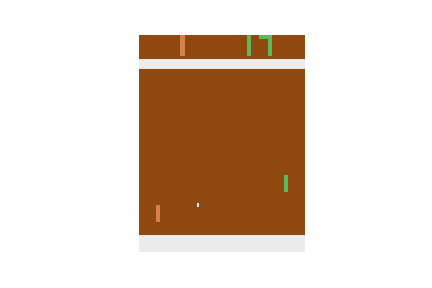
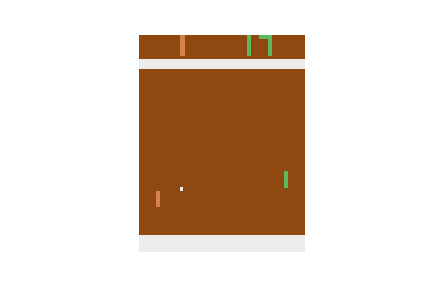
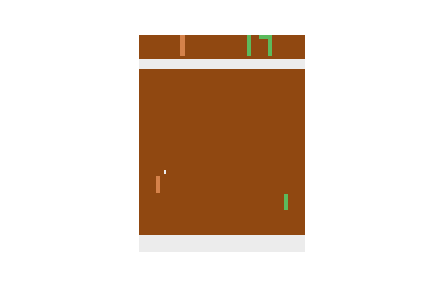
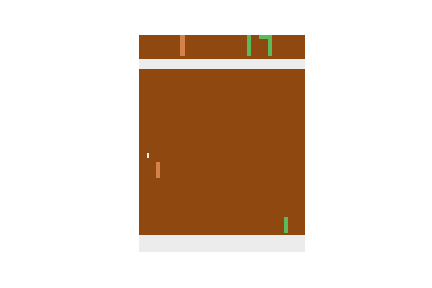
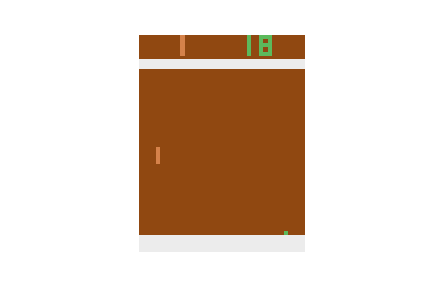
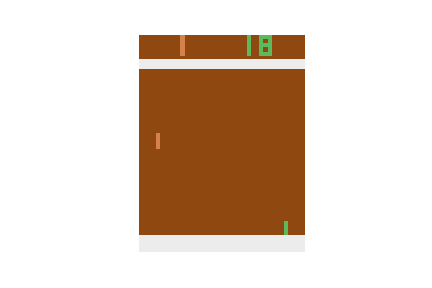
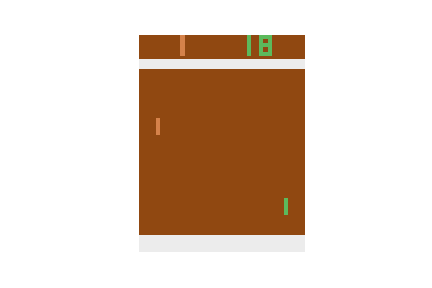
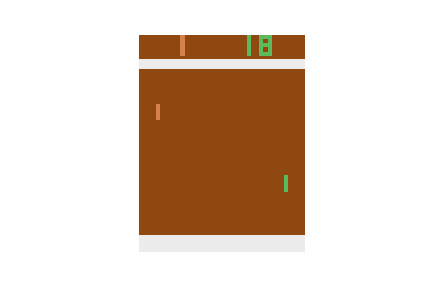
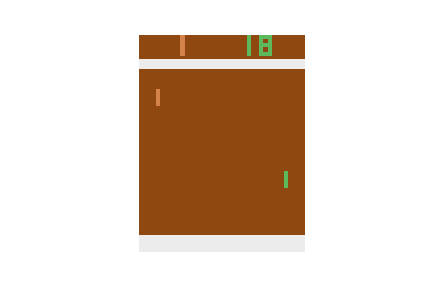
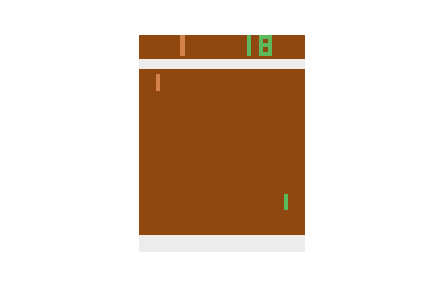
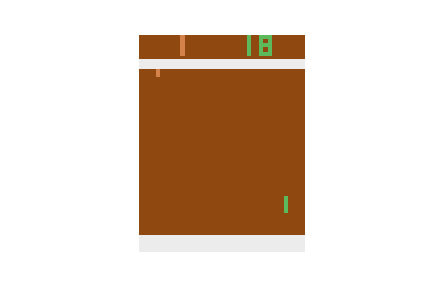
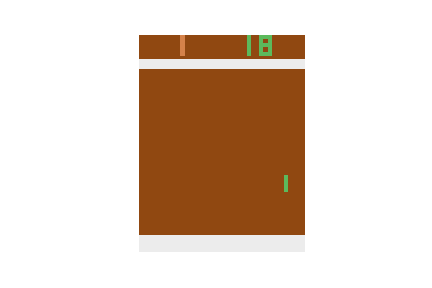
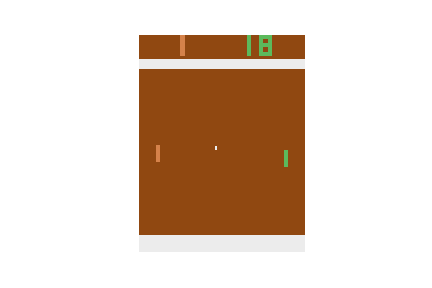
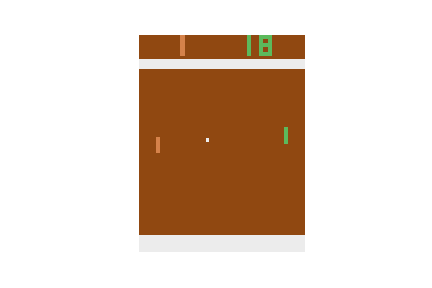
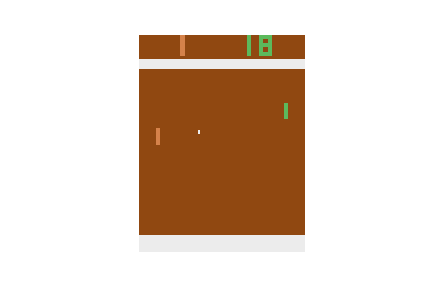
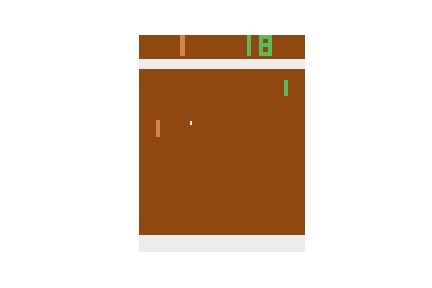
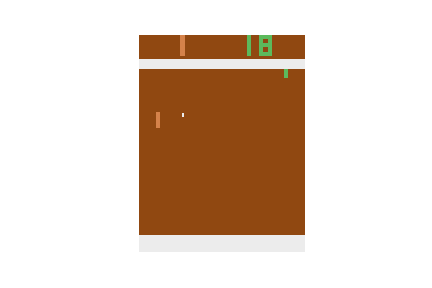
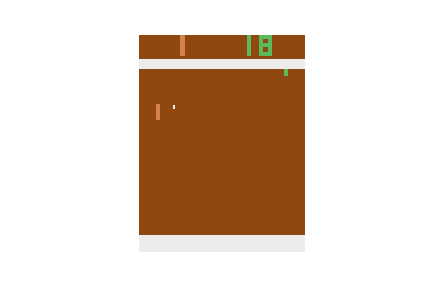
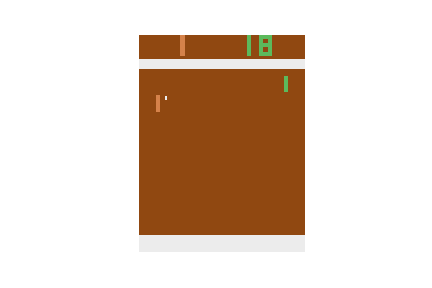
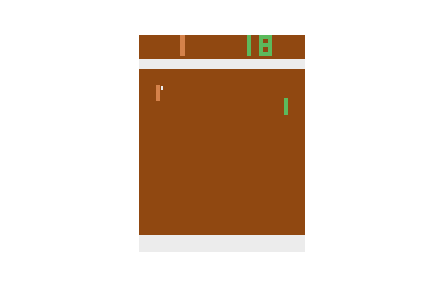
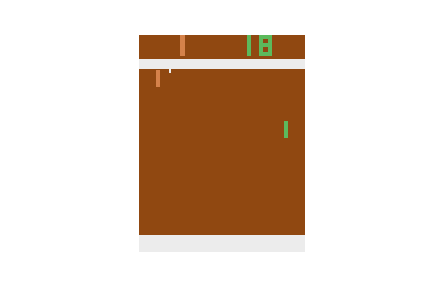
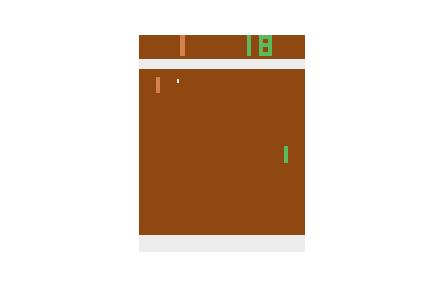
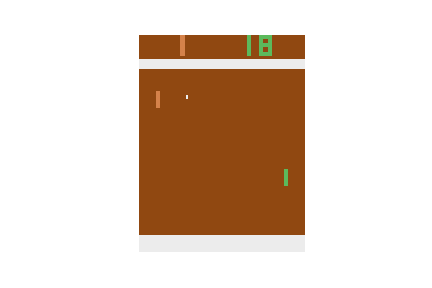
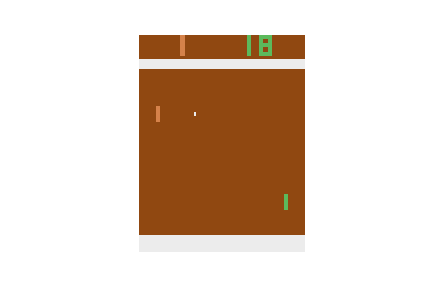
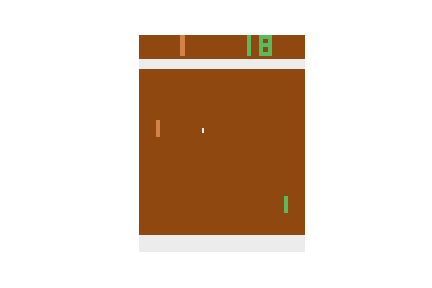
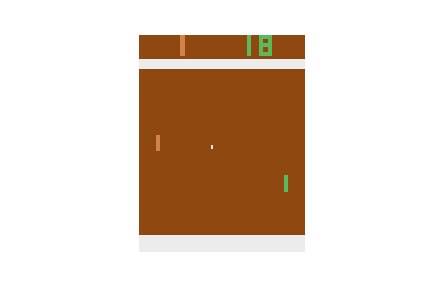
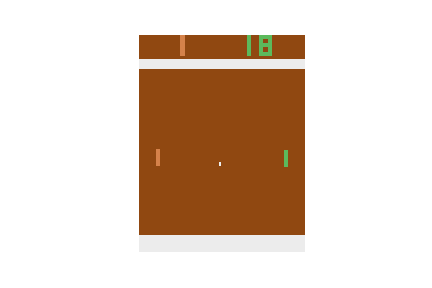
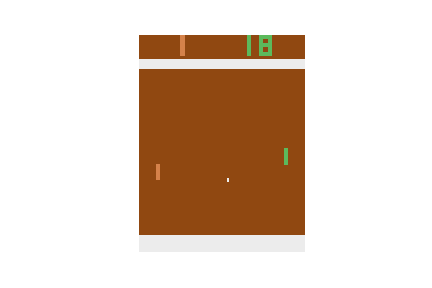
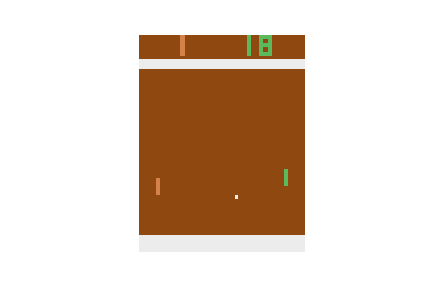
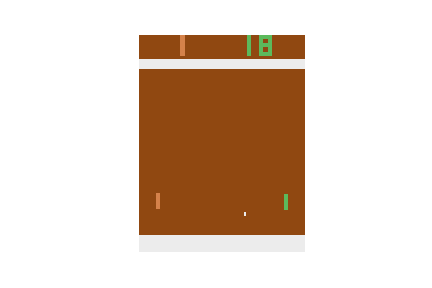
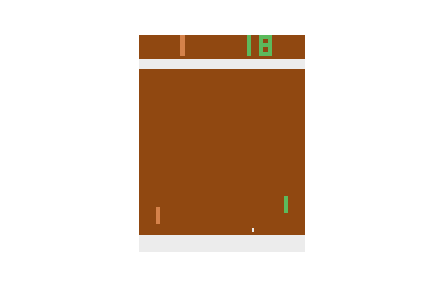
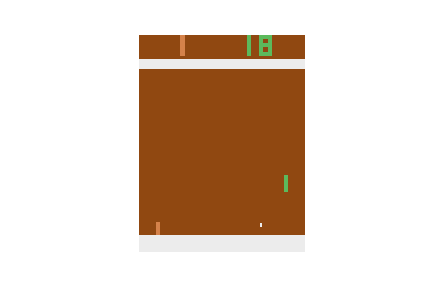
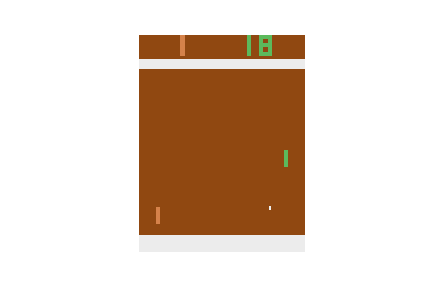
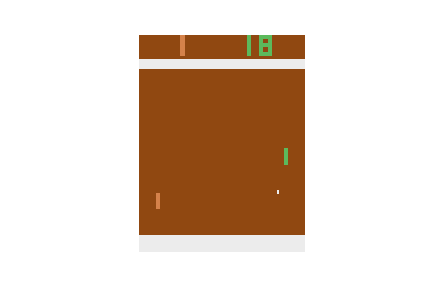
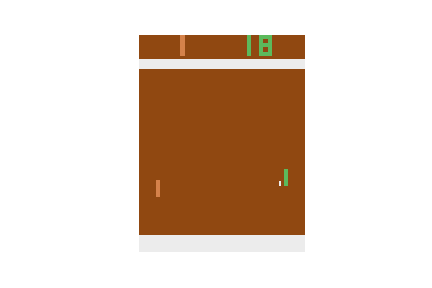
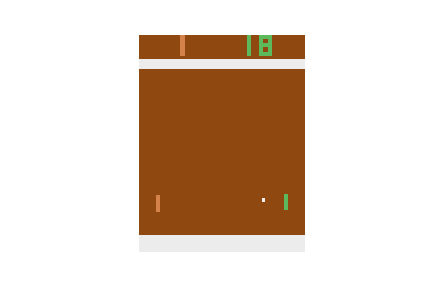
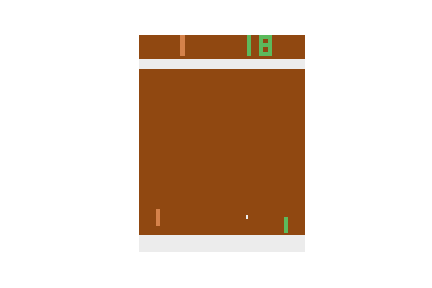
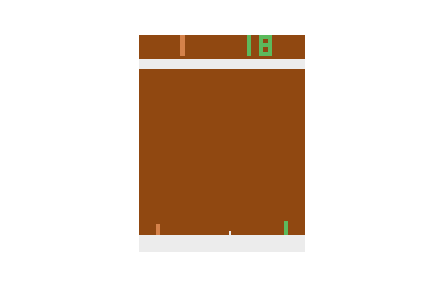
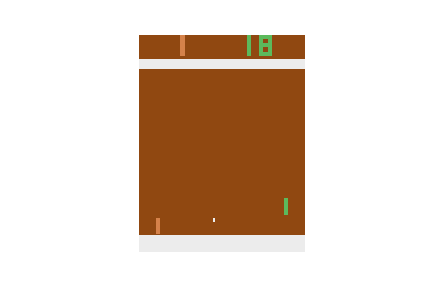
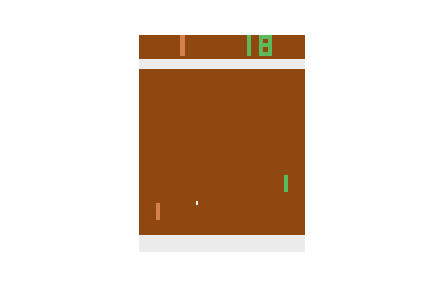
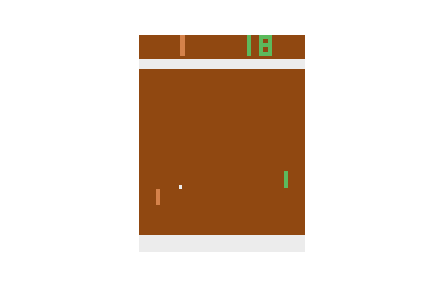
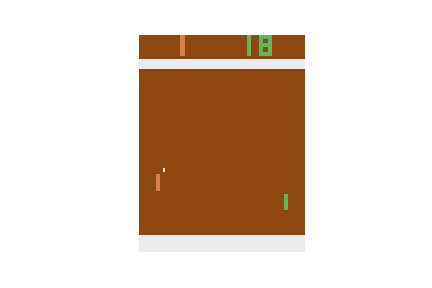
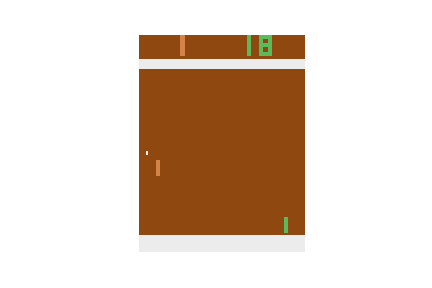
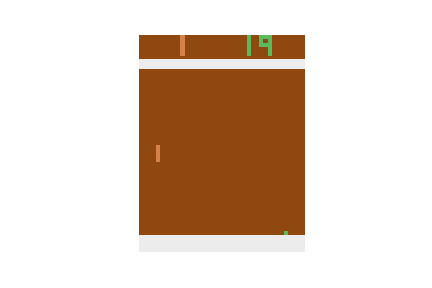
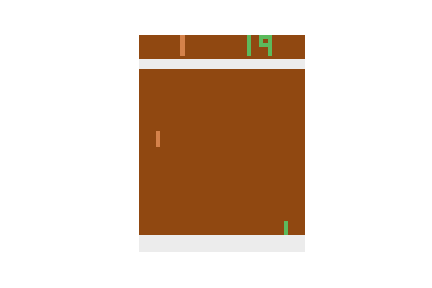
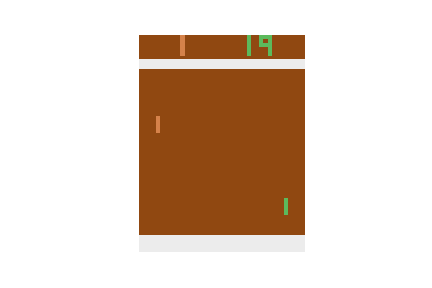
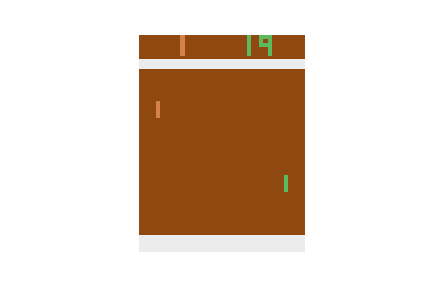
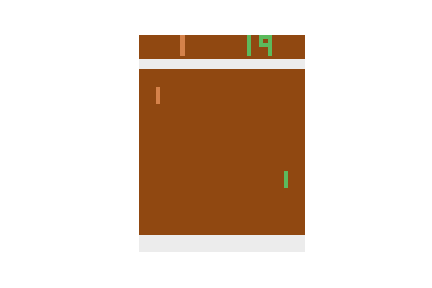
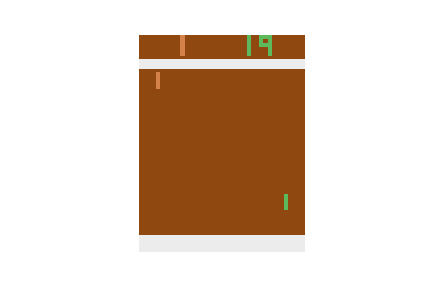
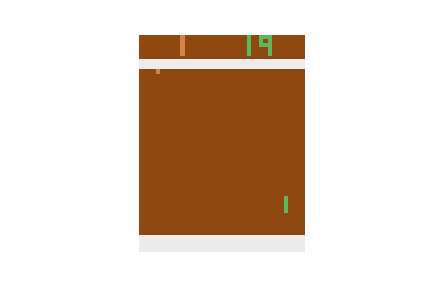
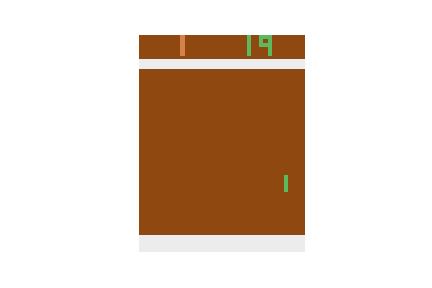
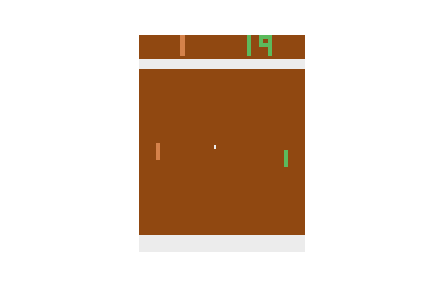
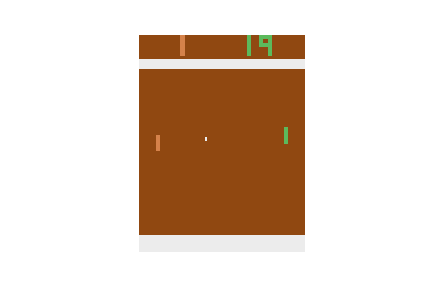
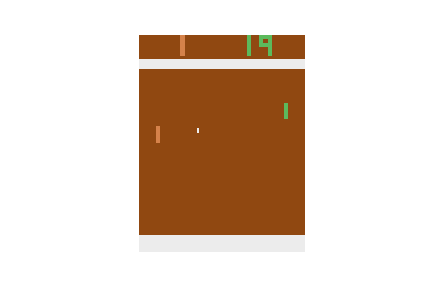
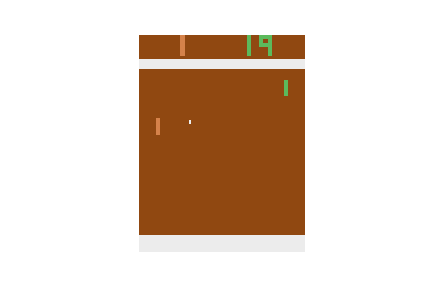
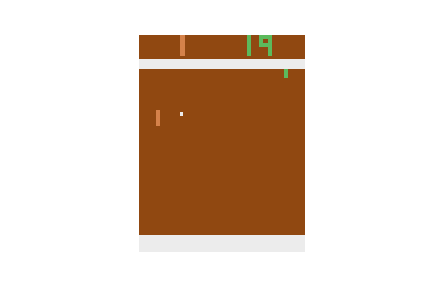
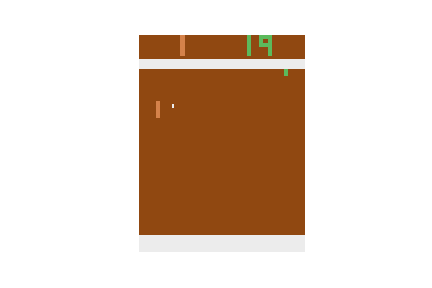
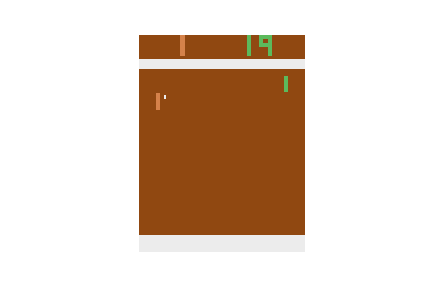
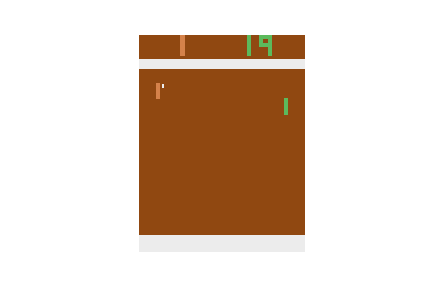
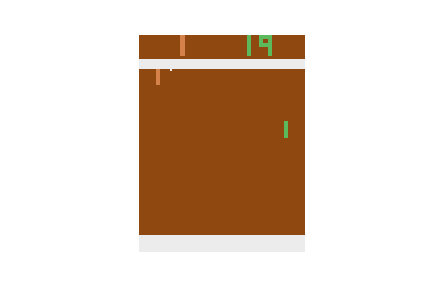
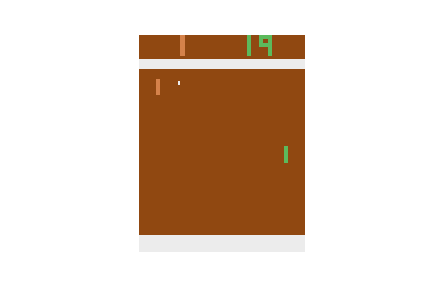
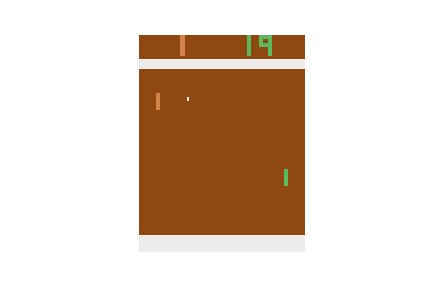
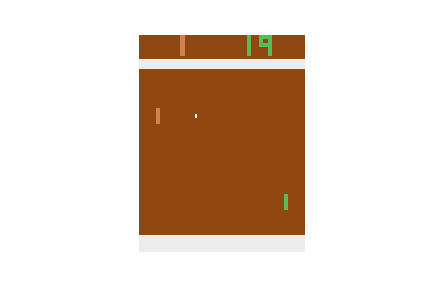
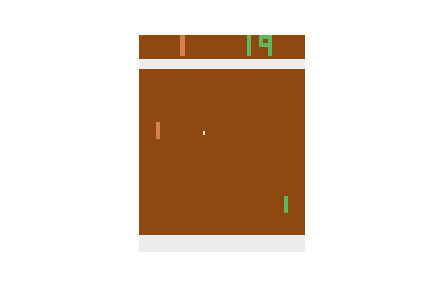
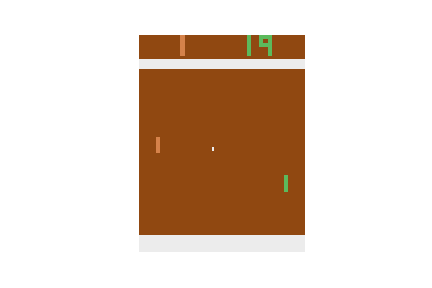
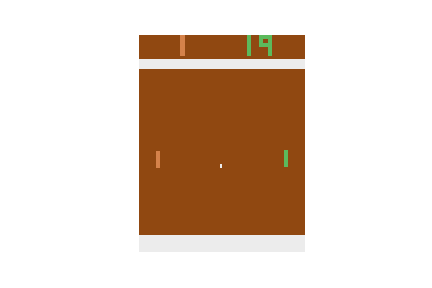
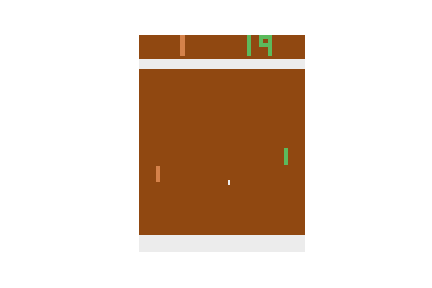
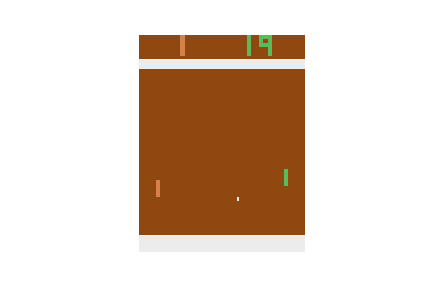
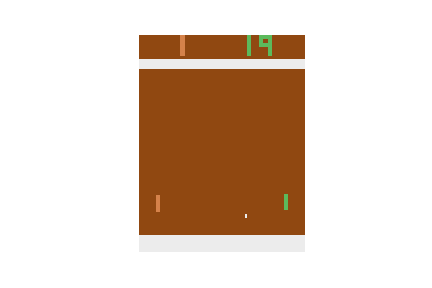
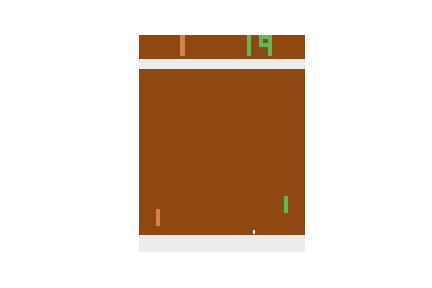
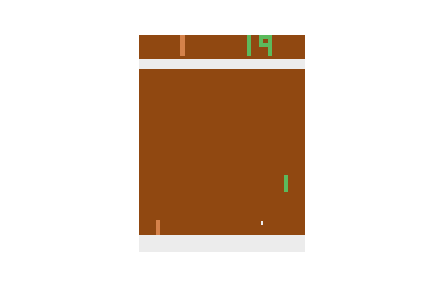
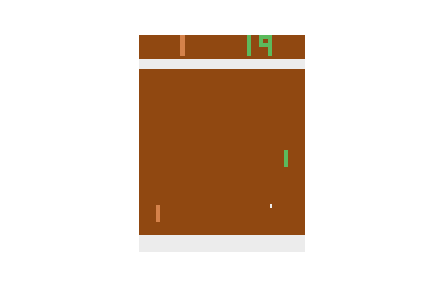
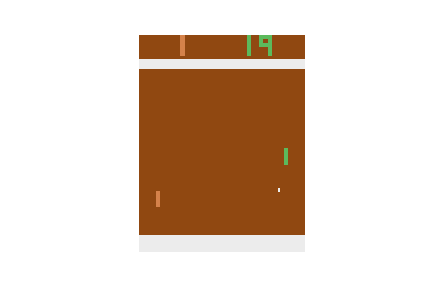
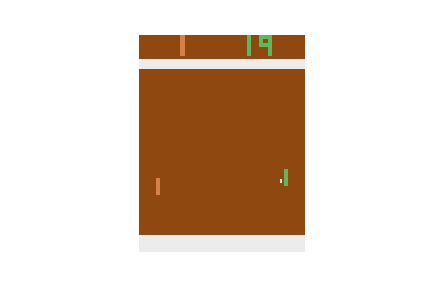
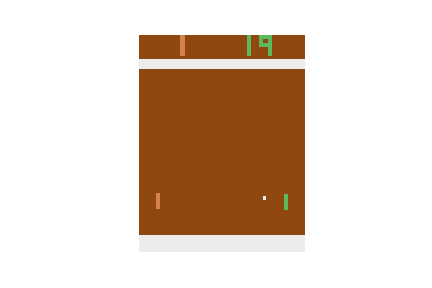
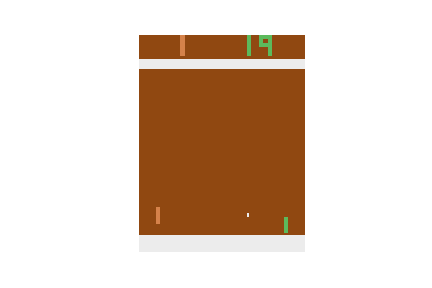
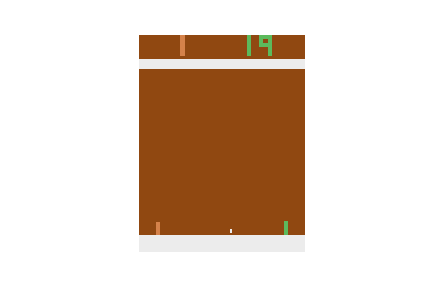
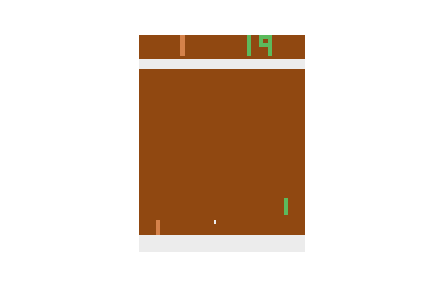
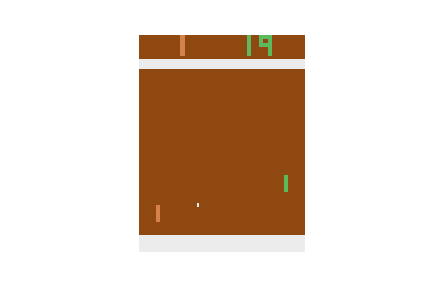
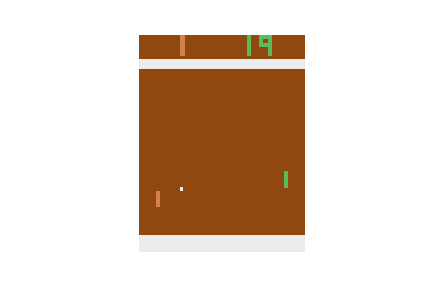
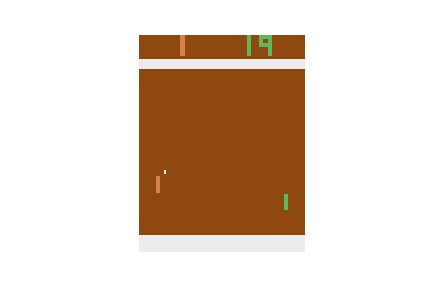
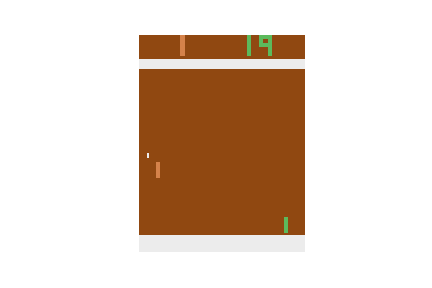
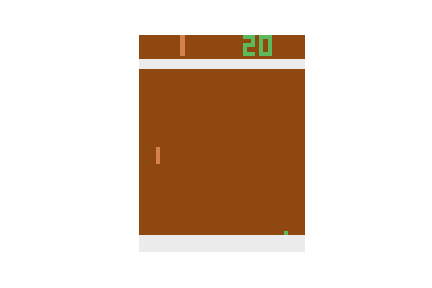
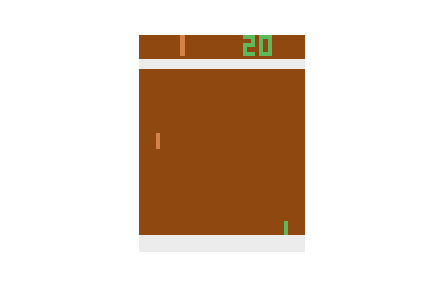
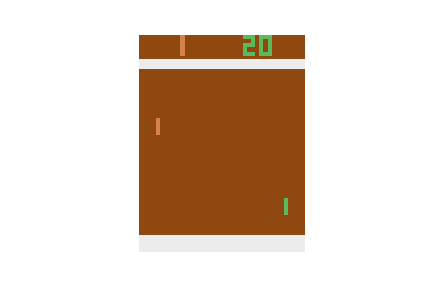
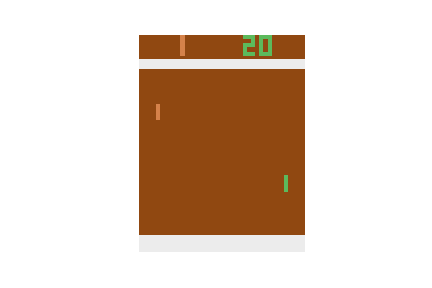
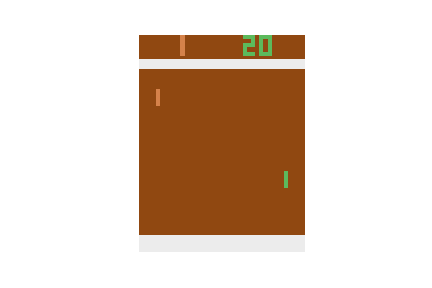
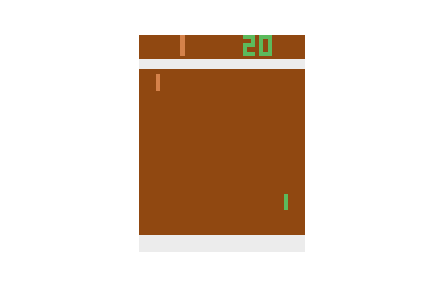
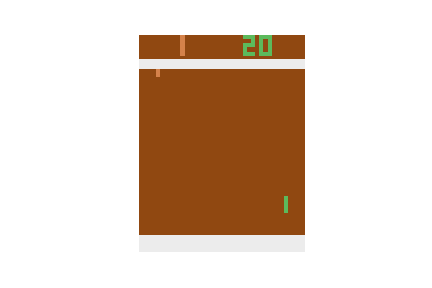
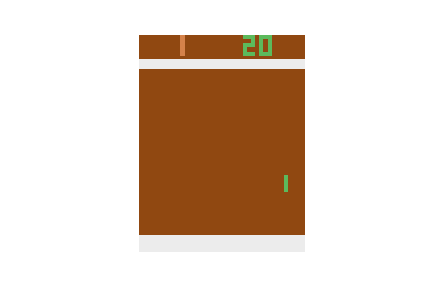
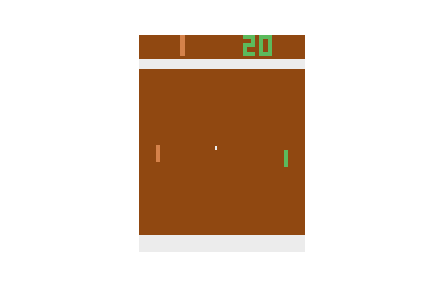
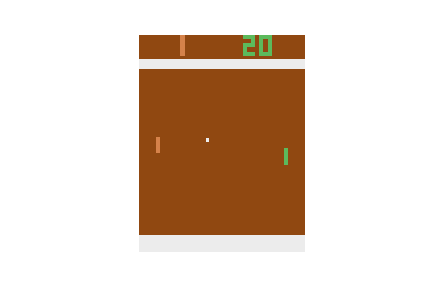
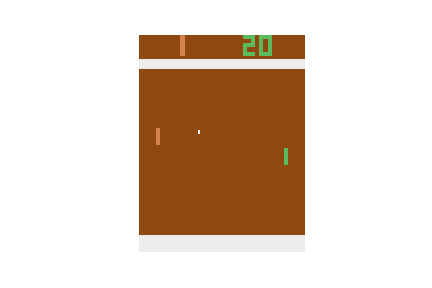
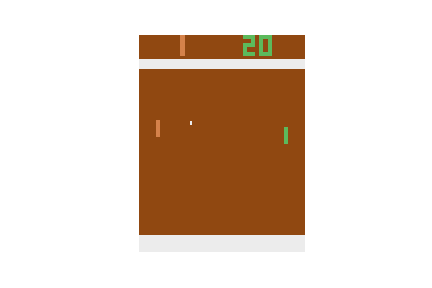
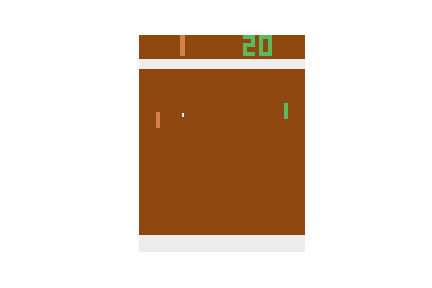
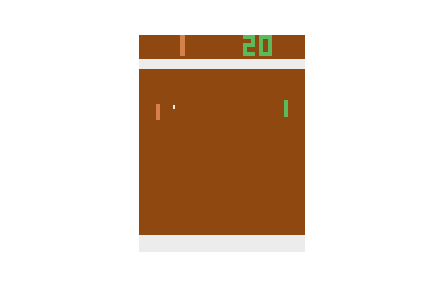
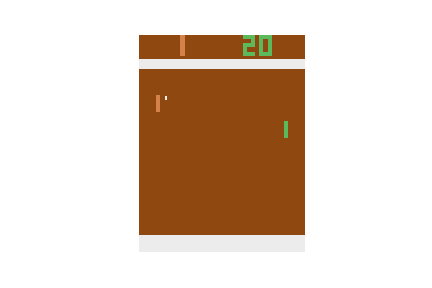
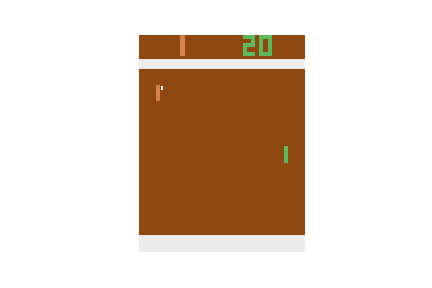
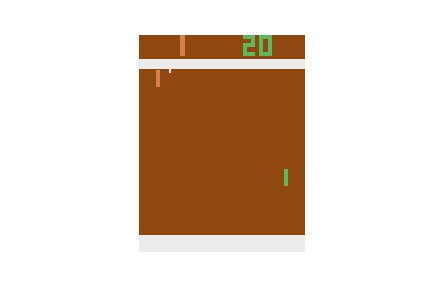
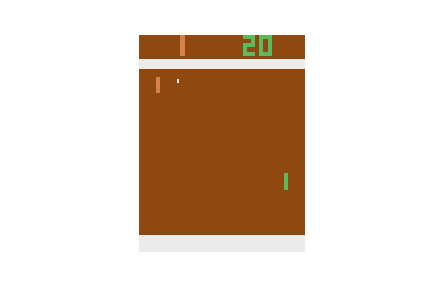
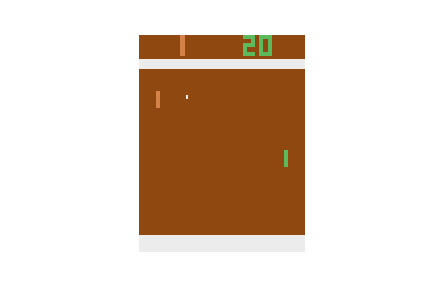
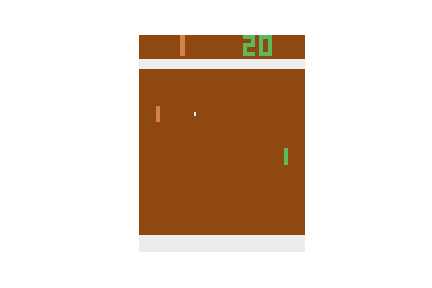
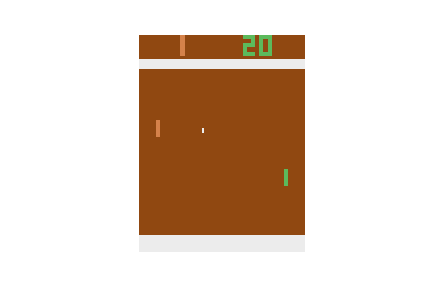
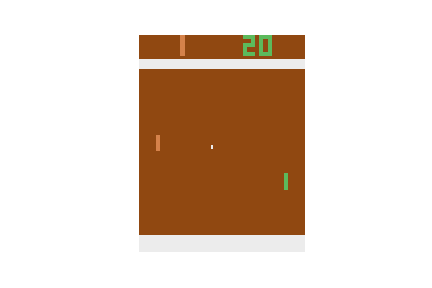
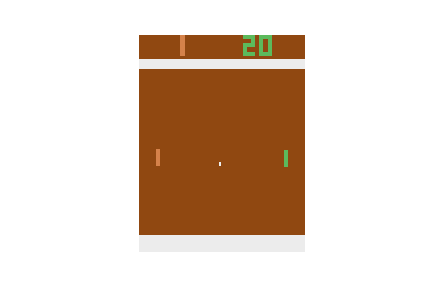
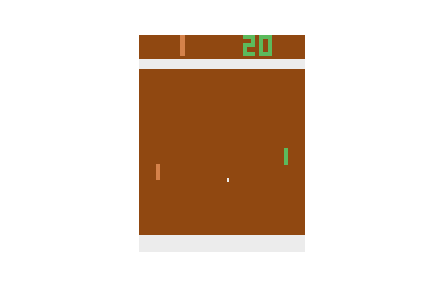
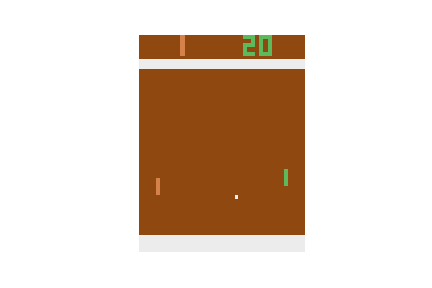
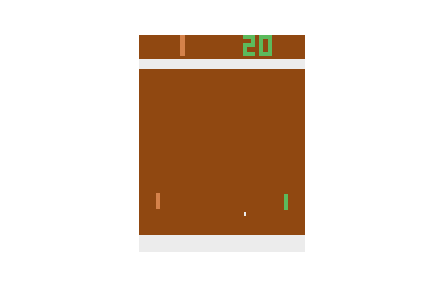
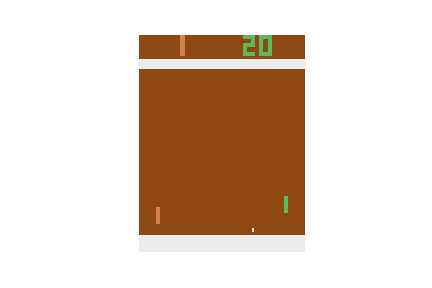
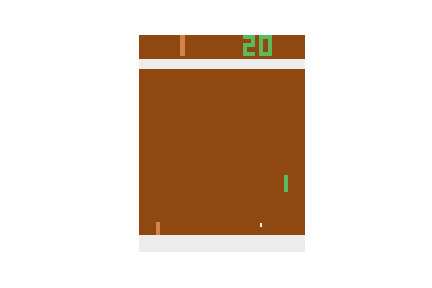
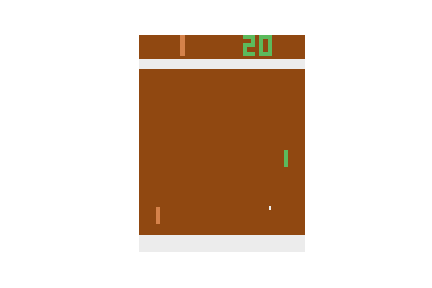
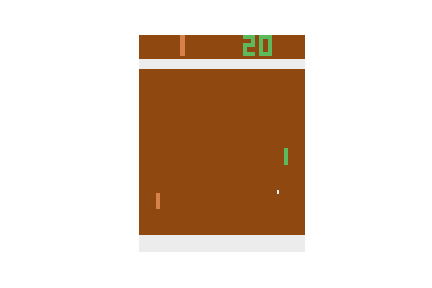
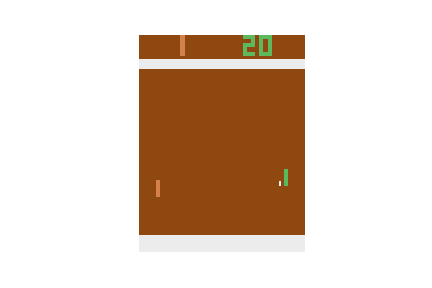
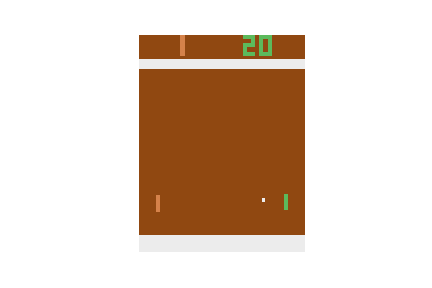
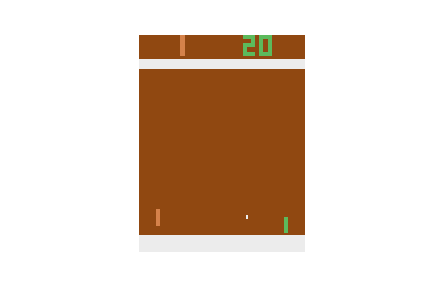
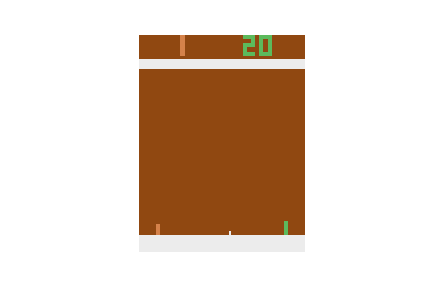
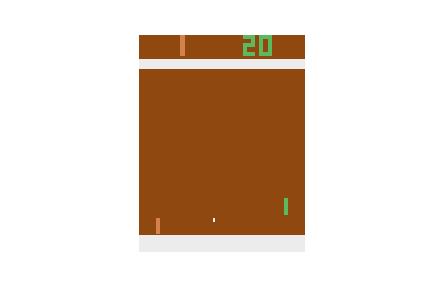
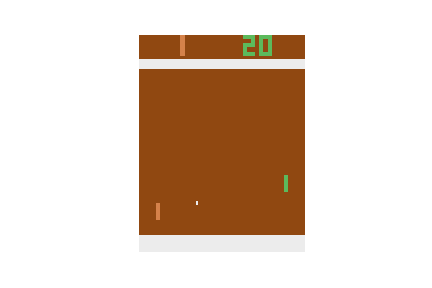
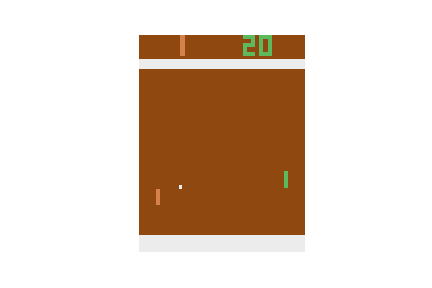
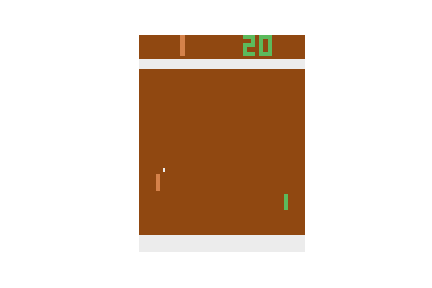
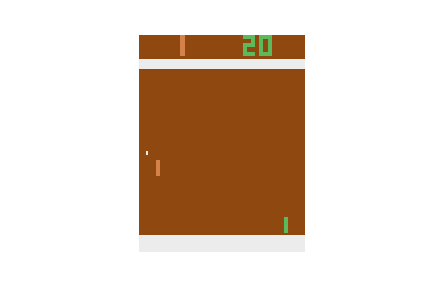

In [93]:
pong_utils.play(env, policy, time=2000) 